In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "fsv2"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 296
Categorical features: 5
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 368
Categorical Columns: 5


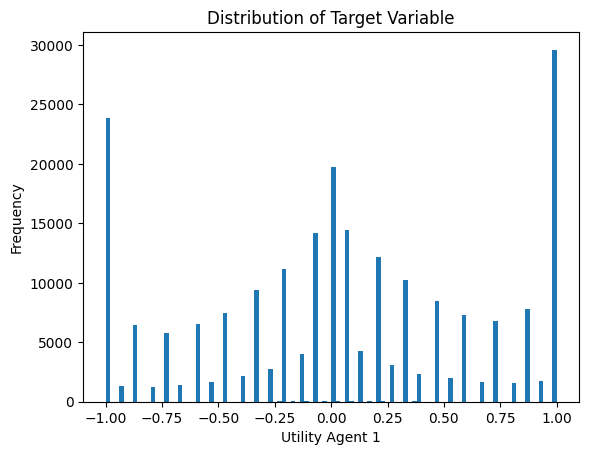

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.02,
        'depth': 10,
        'iterations': 10_000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6320641	test: 0.5535351	best: 0.5535351 (0)	total: 164ms	remaining: 27m 19s


50:	learn: 0.4941643	test: 0.5127861	best: 0.5127861 (50)	total: 4.44s	remaining: 14m 25s


100:	learn: 0.4456642	test: 0.4936490	best: 0.4936490 (100)	total: 8.74s	remaining: 14m 17s


150:	learn: 0.4186251	test: 0.4788769	best: 0.4788769 (150)	total: 13.3s	remaining: 14m 24s


200:	learn: 0.4007817	test: 0.4696071	best: 0.4696071 (200)	total: 18s	remaining: 14m 35s


250:	learn: 0.3876876	test: 0.4639589	best: 0.4639589 (250)	total: 22.8s	remaining: 14m 44s


300:	learn: 0.3777994	test: 0.4593142	best: 0.4593142 (300)	total: 27.7s	remaining: 14m 53s


350:	learn: 0.3697001	test: 0.4556888	best: 0.4556888 (350)	total: 32.6s	remaining: 14m 55s


400:	learn: 0.3623024	test: 0.4515173	best: 0.4515173 (400)	total: 37.4s	remaining: 14m 55s


450:	learn: 0.3555371	test: 0.4479520	best: 0.4479520 (450)	total: 42.2s	remaining: 14m 53s


500:	learn: 0.3501729	test: 0.4456678	best: 0.4456678 (500)	total: 46.9s	remaining: 14m 49s


550:	learn: 0.3451523	test: 0.4435506	best: 0.4435506 (550)	total: 51.6s	remaining: 14m 44s


600:	learn: 0.3408107	test: 0.4419275	best: 0.4419275 (600)	total: 56.3s	remaining: 14m 40s


650:	learn: 0.3366297	test: 0.4402361	best: 0.4402361 (650)	total: 1m 1s	remaining: 14m 36s


700:	learn: 0.3331399	test: 0.4389867	best: 0.4389867 (700)	total: 1m 5s	remaining: 14m 32s


750:	learn: 0.3296550	test: 0.4377141	best: 0.4377141 (750)	total: 1m 10s	remaining: 14m 29s


800:	learn: 0.3264146	test: 0.4366960	best: 0.4366960 (800)	total: 1m 15s	remaining: 14m 25s


850:	learn: 0.3231926	test: 0.4355544	best: 0.4355544 (850)	total: 1m 20s	remaining: 14m 20s


900:	learn: 0.3206978	test: 0.4347681	best: 0.4347637 (898)	total: 1m 24s	remaining: 14m 17s


950:	learn: 0.3180479	test: 0.4339664	best: 0.4339573 (949)	total: 1m 29s	remaining: 14m 13s


1000:	learn: 0.3156079	test: 0.4334040	best: 0.4334040 (1000)	total: 1m 34s	remaining: 14m 9s


1050:	learn: 0.3133061	test: 0.4327189	best: 0.4327189 (1050)	total: 1m 39s	remaining: 14m 6s


1100:	learn: 0.3111950	test: 0.4321702	best: 0.4321702 (1100)	total: 1m 44s	remaining: 14m 3s


1150:	learn: 0.3093829	test: 0.4316617	best: 0.4316617 (1150)	total: 1m 49s	remaining: 14m 1s


1200:	learn: 0.3074556	test: 0.4312097	best: 0.4312097 (1200)	total: 1m 54s	remaining: 13m 57s


1250:	learn: 0.3054804	test: 0.4305550	best: 0.4305550 (1250)	total: 1m 59s	remaining: 13m 53s


1300:	learn: 0.3036986	test: 0.4300485	best: 0.4300485 (1300)	total: 2m 4s	remaining: 13m 49s


1350:	learn: 0.3019307	test: 0.4294547	best: 0.4294547 (1350)	total: 2m 9s	remaining: 13m 46s


1400:	learn: 0.3002179	test: 0.4288783	best: 0.4288783 (1400)	total: 2m 14s	remaining: 13m 43s


1450:	learn: 0.2985734	test: 0.4284083	best: 0.4284083 (1450)	total: 2m 19s	remaining: 13m 39s


1500:	learn: 0.2969925	test: 0.4280665	best: 0.4280665 (1500)	total: 2m 24s	remaining: 13m 35s


1550:	learn: 0.2953882	test: 0.4276934	best: 0.4276926 (1549)	total: 2m 28s	remaining: 13m 31s


1600:	learn: 0.2938401	test: 0.4274498	best: 0.4274461 (1596)	total: 2m 33s	remaining: 13m 26s


1650:	learn: 0.2923295	test: 0.4270795	best: 0.4270795 (1650)	total: 2m 38s	remaining: 13m 23s


1700:	learn: 0.2909153	test: 0.4268495	best: 0.4268495 (1700)	total: 2m 43s	remaining: 13m 19s


1750:	learn: 0.2895189	test: 0.4265284	best: 0.4265284 (1750)	total: 2m 48s	remaining: 13m 15s


1800:	learn: 0.2881996	test: 0.4262580	best: 0.4262556 (1799)	total: 2m 53s	remaining: 13m 10s


1850:	learn: 0.2868835	test: 0.4260775	best: 0.4260775 (1850)	total: 2m 58s	remaining: 13m 6s


1900:	learn: 0.2856465	test: 0.4258188	best: 0.4258188 (1900)	total: 3m 3s	remaining: 13m 2s


1950:	learn: 0.2844127	test: 0.4255658	best: 0.4255658 (1950)	total: 3m 8s	remaining: 12m 58s


2000:	learn: 0.2832538	test: 0.4253117	best: 0.4253117 (2000)	total: 3m 13s	remaining: 12m 53s


2050:	learn: 0.2820668	test: 0.4250670	best: 0.4250670 (2050)	total: 3m 18s	remaining: 12m 49s


2100:	learn: 0.2809239	test: 0.4248938	best: 0.4248938 (2100)	total: 3m 23s	remaining: 12m 44s


2150:	learn: 0.2798239	test: 0.4247191	best: 0.4247191 (2150)	total: 3m 28s	remaining: 12m 40s


2200:	learn: 0.2787118	test: 0.4245654	best: 0.4245419 (2195)	total: 3m 33s	remaining: 12m 36s


2250:	learn: 0.2776474	test: 0.4244627	best: 0.4244591 (2249)	total: 3m 38s	remaining: 12m 32s


2300:	learn: 0.2766073	test: 0.4242520	best: 0.4242519 (2299)	total: 3m 43s	remaining: 12m 28s


2350:	learn: 0.2755869	test: 0.4241276	best: 0.4241276 (2350)	total: 3m 48s	remaining: 12m 23s


2400:	learn: 0.2745787	test: 0.4239786	best: 0.4239786 (2400)	total: 3m 53s	remaining: 12m 19s


2450:	learn: 0.2736301	test: 0.4238449	best: 0.4238427 (2449)	total: 3m 58s	remaining: 12m 14s


2500:	learn: 0.2726873	test: 0.4236795	best: 0.4236795 (2500)	total: 4m 3s	remaining: 12m 10s


2550:	learn: 0.2717122	test: 0.4235446	best: 0.4235438 (2548)	total: 4m 8s	remaining: 12m 5s


2600:	learn: 0.2707852	test: 0.4233851	best: 0.4233851 (2600)	total: 4m 13s	remaining: 12m 1s


2650:	learn: 0.2699051	test: 0.4232561	best: 0.4232561 (2650)	total: 4m 18s	remaining: 11m 56s


2700:	learn: 0.2690088	test: 0.4231233	best: 0.4231107 (2691)	total: 4m 23s	remaining: 11m 52s


2750:	learn: 0.2681541	test: 0.4230157	best: 0.4230151 (2749)	total: 4m 28s	remaining: 11m 47s


2800:	learn: 0.2673537	test: 0.4229086	best: 0.4229069 (2799)	total: 4m 33s	remaining: 11m 43s


2850:	learn: 0.2664810	test: 0.4226956	best: 0.4226911 (2849)	total: 4m 38s	remaining: 11m 38s


2900:	learn: 0.2656490	test: 0.4225863	best: 0.4225863 (2900)	total: 4m 43s	remaining: 11m 34s


2950:	learn: 0.2648104	test: 0.4224774	best: 0.4224774 (2950)	total: 4m 48s	remaining: 11m 29s


3000:	learn: 0.2639914	test: 0.4223671	best: 0.4223639 (2998)	total: 4m 53s	remaining: 11m 25s


3050:	learn: 0.2631127	test: 0.4222359	best: 0.4222359 (3050)	total: 4m 58s	remaining: 11m 20s


3100:	learn: 0.2622747	test: 0.4221423	best: 0.4221388 (3096)	total: 5m 3s	remaining: 11m 16s


3150:	learn: 0.2615055	test: 0.4220350	best: 0.4220275 (3145)	total: 5m 8s	remaining: 11m 11s


3200:	learn: 0.2607993	test: 0.4219876	best: 0.4219845 (3196)	total: 5m 14s	remaining: 11m 7s


3250:	learn: 0.2600775	test: 0.4218743	best: 0.4218743 (3250)	total: 5m 19s	remaining: 11m 2s


3300:	learn: 0.2592982	test: 0.4217598	best: 0.4217598 (3300)	total: 5m 24s	remaining: 10m 57s


3350:	learn: 0.2585729	test: 0.4216693	best: 0.4216693 (3350)	total: 5m 29s	remaining: 10m 53s


3400:	learn: 0.2578700	test: 0.4215687	best: 0.4215687 (3400)	total: 5m 34s	remaining: 10m 48s


3450:	learn: 0.2571621	test: 0.4214810	best: 0.4214741 (3448)	total: 5m 39s	remaining: 10m 44s


3500:	learn: 0.2564722	test: 0.4213624	best: 0.4213624 (3500)	total: 5m 44s	remaining: 10m 39s


3550:	learn: 0.2558769	test: 0.4213225	best: 0.4213219 (3549)	total: 5m 49s	remaining: 10m 35s


3600:	learn: 0.2551579	test: 0.4212646	best: 0.4212643 (3599)	total: 5m 54s	remaining: 10m 30s


3650:	learn: 0.2545022	test: 0.4211814	best: 0.4211810 (3649)	total: 5m 59s	remaining: 10m 25s


3700:	learn: 0.2538686	test: 0.4210657	best: 0.4210637 (3699)	total: 6m 5s	remaining: 10m 21s


3750:	learn: 0.2532471	test: 0.4210197	best: 0.4210197 (3750)	total: 6m 10s	remaining: 10m 16s


3800:	learn: 0.2526088	test: 0.4209194	best: 0.4209194 (3800)	total: 6m 15s	remaining: 10m 12s


3850:	learn: 0.2520001	test: 0.4208712	best: 0.4208712 (3850)	total: 6m 20s	remaining: 10m 7s


3900:	learn: 0.2513758	test: 0.4208196	best: 0.4208041 (3889)	total: 6m 25s	remaining: 10m 2s


3950:	learn: 0.2507723	test: 0.4207568	best: 0.4207514 (3944)	total: 6m 30s	remaining: 9m 58s


4000:	learn: 0.2501959	test: 0.4206581	best: 0.4206581 (4000)	total: 6m 35s	remaining: 9m 53s


4050:	learn: 0.2495808	test: 0.4206014	best: 0.4206014 (4050)	total: 6m 40s	remaining: 9m 48s


4100:	learn: 0.2489705	test: 0.4205533	best: 0.4205533 (4100)	total: 6m 45s	remaining: 9m 43s


4150:	learn: 0.2483839	test: 0.4204919	best: 0.4204919 (4150)	total: 6m 50s	remaining: 9m 38s


4200:	learn: 0.2478682	test: 0.4204429	best: 0.4204423 (4199)	total: 6m 55s	remaining: 9m 34s


4250:	learn: 0.2473017	test: 0.4203935	best: 0.4203935 (4250)	total: 7m 1s	remaining: 9m 29s


4300:	learn: 0.2467480	test: 0.4203637	best: 0.4203526 (4284)	total: 7m 6s	remaining: 9m 24s


4350:	learn: 0.2462201	test: 0.4202829	best: 0.4202800 (4349)	total: 7m 11s	remaining: 9m 19s


4400:	learn: 0.2456354	test: 0.4202345	best: 0.4202331 (4397)	total: 7m 16s	remaining: 9m 15s


4450:	learn: 0.2450977	test: 0.4201506	best: 0.4201504 (4449)	total: 7m 21s	remaining: 9m 10s


4500:	learn: 0.2446046	test: 0.4201104	best: 0.4201104 (4500)	total: 7m 26s	remaining: 9m 5s


4550:	learn: 0.2440467	test: 0.4200332	best: 0.4200323 (4549)	total: 7m 31s	remaining: 9m


4600:	learn: 0.2435198	test: 0.4200069	best: 0.4200069 (4600)	total: 7m 36s	remaining: 8m 56s


4650:	learn: 0.2430392	test: 0.4199588	best: 0.4199588 (4650)	total: 7m 42s	remaining: 8m 51s


4700:	learn: 0.2424912	test: 0.4198682	best: 0.4198679 (4698)	total: 7m 47s	remaining: 8m 46s


4750:	learn: 0.2419764	test: 0.4198299	best: 0.4198275 (4748)	total: 7m 52s	remaining: 8m 41s


4800:	learn: 0.2414276	test: 0.4197687	best: 0.4197687 (4800)	total: 7m 57s	remaining: 8m 37s


4850:	learn: 0.2409294	test: 0.4197142	best: 0.4197099 (4843)	total: 8m 2s	remaining: 8m 32s


4900:	learn: 0.2404291	test: 0.4196534	best: 0.4196534 (4900)	total: 8m 7s	remaining: 8m 27s


4950:	learn: 0.2399756	test: 0.4196064	best: 0.4196064 (4950)	total: 8m 13s	remaining: 8m 22s


5000:	learn: 0.2395033	test: 0.4195523	best: 0.4195523 (5000)	total: 8m 18s	remaining: 8m 18s


5050:	learn: 0.2390333	test: 0.4194901	best: 0.4194901 (5050)	total: 8m 23s	remaining: 8m 13s


5100:	learn: 0.2385736	test: 0.4194283	best: 0.4194278 (5099)	total: 8m 28s	remaining: 8m 8s


5150:	learn: 0.2380500	test: 0.4194256	best: 0.4194228 (5134)	total: 8m 33s	remaining: 8m 3s


5200:	learn: 0.2375654	test: 0.4193897	best: 0.4193897 (5200)	total: 8m 38s	remaining: 7m 58s


5250:	learn: 0.2371130	test: 0.4193649	best: 0.4193644 (5247)	total: 8m 43s	remaining: 7m 53s


5300:	learn: 0.2366173	test: 0.4192976	best: 0.4192968 (5298)	total: 8m 49s	remaining: 7m 49s


5350:	learn: 0.2361395	test: 0.4192506	best: 0.4192506 (5350)	total: 8m 54s	remaining: 7m 44s


5400:	learn: 0.2357011	test: 0.4192044	best: 0.4192044 (5400)	total: 8m 59s	remaining: 7m 39s


5450:	learn: 0.2352084	test: 0.4191890	best: 0.4191822 (5443)	total: 9m 4s	remaining: 7m 34s


5500:	learn: 0.2347730	test: 0.4191384	best: 0.4191332 (5498)	total: 9m 9s	remaining: 7m 29s


5550:	learn: 0.2342941	test: 0.4191217	best: 0.4191217 (5550)	total: 9m 14s	remaining: 7m 24s


5600:	learn: 0.2338630	test: 0.4190880	best: 0.4190880 (5600)	total: 9m 19s	remaining: 7m 19s


5650:	learn: 0.2334238	test: 0.4190746	best: 0.4190738 (5649)	total: 9m 25s	remaining: 7m 14s


5700:	learn: 0.2329596	test: 0.4190323	best: 0.4190224 (5694)	total: 9m 30s	remaining: 7m 9s


5750:	learn: 0.2325134	test: 0.4189831	best: 0.4189831 (5750)	total: 9m 35s	remaining: 7m 5s


5800:	learn: 0.2320340	test: 0.4189596	best: 0.4189596 (5800)	total: 9m 40s	remaining: 7m


5850:	learn: 0.2316037	test: 0.4189515	best: 0.4189469 (5848)	total: 9m 45s	remaining: 6m 55s


5900:	learn: 0.2311694	test: 0.4189190	best: 0.4189189 (5899)	total: 9m 50s	remaining: 6m 50s


5950:	learn: 0.2307403	test: 0.4188911	best: 0.4188904 (5948)	total: 9m 55s	remaining: 6m 45s


6000:	learn: 0.2302809	test: 0.4188709	best: 0.4188675 (5967)	total: 10m	remaining: 6m 40s


6050:	learn: 0.2298920	test: 0.4188581	best: 0.4188494 (6021)	total: 10m 6s	remaining: 6m 35s


6100:	learn: 0.2294614	test: 0.4188406	best: 0.4188314 (6070)	total: 10m 11s	remaining: 6m 30s


6150:	learn: 0.2290203	test: 0.4187771	best: 0.4187764 (6146)	total: 10m 16s	remaining: 6m 25s


6200:	learn: 0.2285992	test: 0.4187718	best: 0.4187718 (6200)	total: 10m 21s	remaining: 6m 20s


6250:	learn: 0.2281488	test: 0.4187120	best: 0.4187120 (6250)	total: 10m 26s	remaining: 6m 15s


6300:	learn: 0.2277230	test: 0.4187055	best: 0.4187005 (6261)	total: 10m 32s	remaining: 6m 11s


6350:	learn: 0.2273400	test: 0.4186948	best: 0.4186948 (6350)	total: 10m 37s	remaining: 6m 6s


6400:	learn: 0.2269532	test: 0.4186830	best: 0.4186758 (6388)	total: 10m 42s	remaining: 6m 1s


6450:	learn: 0.2265803	test: 0.4186616	best: 0.4186616 (6450)	total: 10m 47s	remaining: 5m 56s


6500:	learn: 0.2261682	test: 0.4186356	best: 0.4186291 (6493)	total: 10m 52s	remaining: 5m 51s


6550:	learn: 0.2258096	test: 0.4186002	best: 0.4185982 (6543)	total: 10m 57s	remaining: 5m 46s


6600:	learn: 0.2253937	test: 0.4185632	best: 0.4185630 (6595)	total: 11m 3s	remaining: 5m 41s


6650:	learn: 0.2250069	test: 0.4185300	best: 0.4185300 (6650)	total: 11m 8s	remaining: 5m 36s


6700:	learn: 0.2246330	test: 0.4185256	best: 0.4185234 (6653)	total: 11m 13s	remaining: 5m 31s


6750:	learn: 0.2242452	test: 0.4185008	best: 0.4184972 (6739)	total: 11m 18s	remaining: 5m 26s


6800:	learn: 0.2238935	test: 0.4185192	best: 0.4184972 (6739)	total: 11m 23s	remaining: 5m 21s


6850:	learn: 0.2235198	test: 0.4185102	best: 0.4184972 (6739)	total: 11m 28s	remaining: 5m 16s


6900:	learn: 0.2231554	test: 0.4184487	best: 0.4184487 (6900)	total: 11m 34s	remaining: 5m 11s


6950:	learn: 0.2227646	test: 0.4184185	best: 0.4184182 (6949)	total: 11m 39s	remaining: 5m 6s


7000:	learn: 0.2223999	test: 0.4183737	best: 0.4183737 (7000)	total: 11m 44s	remaining: 5m 1s


7050:	learn: 0.2220620	test: 0.4183663	best: 0.4183543 (7011)	total: 11m 49s	remaining: 4m 56s


7100:	learn: 0.2216913	test: 0.4183544	best: 0.4183499 (7081)	total: 11m 54s	remaining: 4m 51s


7150:	learn: 0.2213443	test: 0.4183188	best: 0.4183188 (7150)	total: 12m	remaining: 4m 46s


7200:	learn: 0.2209588	test: 0.4182738	best: 0.4182729 (7198)	total: 12m 5s	remaining: 4m 41s


7250:	learn: 0.2205843	test: 0.4182671	best: 0.4182611 (7220)	total: 12m 10s	remaining: 4m 36s


7300:	learn: 0.2202457	test: 0.4182488	best: 0.4182481 (7289)	total: 12m 15s	remaining: 4m 31s


7350:	learn: 0.2199031	test: 0.4182239	best: 0.4182236 (7349)	total: 12m 20s	remaining: 4m 26s


7400:	learn: 0.2195429	test: 0.4182175	best: 0.4182115 (7378)	total: 12m 25s	remaining: 4m 21s


7450:	learn: 0.2191931	test: 0.4181870	best: 0.4181863 (7449)	total: 12m 31s	remaining: 4m 16s


7500:	learn: 0.2188050	test: 0.4181675	best: 0.4181655 (7494)	total: 12m 36s	remaining: 4m 11s


7550:	learn: 0.2184658	test: 0.4181335	best: 0.4181287 (7540)	total: 12m 41s	remaining: 4m 6s


7600:	learn: 0.2180950	test: 0.4181243	best: 0.4181243 (7600)	total: 12m 46s	remaining: 4m 1s


7650:	learn: 0.2177531	test: 0.4180917	best: 0.4180905 (7645)	total: 12m 51s	remaining: 3m 56s


7700:	learn: 0.2173849	test: 0.4180637	best: 0.4180637 (7700)	total: 12m 56s	remaining: 3m 51s


7750:	learn: 0.2170350	test: 0.4180481	best: 0.4180476 (7742)	total: 13m 2s	remaining: 3m 46s


7800:	learn: 0.2166650	test: 0.4180415	best: 0.4180375 (7788)	total: 13m 7s	remaining: 3m 41s


7850:	learn: 0.2163207	test: 0.4180443	best: 0.4180336 (7827)	total: 13m 12s	remaining: 3m 36s


7900:	learn: 0.2160023	test: 0.4180219	best: 0.4180219 (7900)	total: 13m 17s	remaining: 3m 31s


7950:	learn: 0.2156920	test: 0.4179998	best: 0.4179998 (7950)	total: 13m 22s	remaining: 3m 26s


8000:	learn: 0.2153571	test: 0.4179708	best: 0.4179708 (8000)	total: 13m 27s	remaining: 3m 21s


8050:	learn: 0.2150064	test: 0.4179437	best: 0.4179437 (8050)	total: 13m 33s	remaining: 3m 16s


8100:	learn: 0.2146878	test: 0.4179280	best: 0.4179276 (8099)	total: 13m 38s	remaining: 3m 11s


8150:	learn: 0.2143725	test: 0.4179084	best: 0.4179084 (8150)	total: 13m 43s	remaining: 3m 6s


8200:	learn: 0.2140234	test: 0.4178966	best: 0.4178929 (8196)	total: 13m 48s	remaining: 3m 1s


8250:	learn: 0.2137317	test: 0.4178611	best: 0.4178611 (8250)	total: 13m 54s	remaining: 2m 56s


8300:	learn: 0.2133733	test: 0.4178459	best: 0.4178459 (8300)	total: 13m 59s	remaining: 2m 51s


8350:	learn: 0.2130813	test: 0.4178325	best: 0.4178312 (8338)	total: 14m 4s	remaining: 2m 46s


8400:	learn: 0.2127390	test: 0.4178317	best: 0.4178207 (8371)	total: 14m 9s	remaining: 2m 41s


8450:	learn: 0.2124169	test: 0.4178221	best: 0.4178199 (8423)	total: 14m 14s	remaining: 2m 36s


8500:	learn: 0.2120972	test: 0.4178037	best: 0.4178024 (8468)	total: 14m 20s	remaining: 2m 31s


8550:	learn: 0.2117954	test: 0.4178120	best: 0.4178024 (8468)	total: 14m 25s	remaining: 2m 26s


8600:	learn: 0.2115076	test: 0.4178115	best: 0.4178024 (8468)	total: 14m 30s	remaining: 2m 21s


8650:	learn: 0.2111733	test: 0.4178053	best: 0.4178024 (8468)	total: 14m 35s	remaining: 2m 16s


8700:	learn: 0.2108726	test: 0.4178176	best: 0.4178024 (8468)	total: 14m 41s	remaining: 2m 11s


8750:	learn: 0.2105531	test: 0.4178094	best: 0.4178024 (8468)	total: 14m 46s	remaining: 2m 6s


8800:	learn: 0.2102244	test: 0.4178181	best: 0.4178024 (8468)	total: 14m 51s	remaining: 2m 1s


8850:	learn: 0.2099457	test: 0.4178101	best: 0.4178024 (8468)	total: 14m 56s	remaining: 1m 56s


8900:	learn: 0.2096380	test: 0.4177860	best: 0.4177824 (8889)	total: 15m 2s	remaining: 1m 51s


8950:	learn: 0.2093066	test: 0.4177696	best: 0.4177692 (8947)	total: 15m 7s	remaining: 1m 46s


9000:	learn: 0.2089986	test: 0.4177457	best: 0.4177457 (9000)	total: 15m 12s	remaining: 1m 41s


9050:	learn: 0.2087060	test: 0.4177433	best: 0.4177349 (9013)	total: 15m 17s	remaining: 1m 36s


9100:	learn: 0.2083755	test: 0.4177426	best: 0.4177349 (9013)	total: 15m 22s	remaining: 1m 31s


9150:	learn: 0.2080381	test: 0.4177280	best: 0.4177252 (9146)	total: 15m 27s	remaining: 1m 26s


9200:	learn: 0.2077216	test: 0.4177143	best: 0.4177143 (9200)	total: 15m 32s	remaining: 1m 20s


9250:	learn: 0.2074291	test: 0.4176973	best: 0.4176972 (9249)	total: 15m 37s	remaining: 1m 15s


9300:	learn: 0.2071142	test: 0.4176841	best: 0.4176798 (9281)	total: 15m 43s	remaining: 1m 10s


9350:	learn: 0.2068263	test: 0.4176846	best: 0.4176778 (9322)	total: 15m 48s	remaining: 1m 5s


9400:	learn: 0.2065078	test: 0.4176700	best: 0.4176693 (9399)	total: 15m 53s	remaining: 1m


9450:	learn: 0.2062280	test: 0.4176508	best: 0.4176508 (9450)	total: 15m 58s	remaining: 55.7s


9500:	learn: 0.2059309	test: 0.4176437	best: 0.4176437 (9500)	total: 16m 3s	remaining: 50.6s


9550:	learn: 0.2056643	test: 0.4176188	best: 0.4176184 (9549)	total: 16m 9s	remaining: 45.6s


9600:	learn: 0.2053627	test: 0.4176200	best: 0.4176141 (9564)	total: 16m 14s	remaining: 40.5s


9650:	learn: 0.2050487	test: 0.4176040	best: 0.4176035 (9649)	total: 16m 19s	remaining: 35.4s


9700:	learn: 0.2047768	test: 0.4175858	best: 0.4175836 (9676)	total: 16m 24s	remaining: 30.3s


9750:	learn: 0.2045042	test: 0.4175660	best: 0.4175631 (9747)	total: 16m 29s	remaining: 25.3s


9800:	learn: 0.2042223	test: 0.4175575	best: 0.4175569 (9798)	total: 16m 35s	remaining: 20.2s


9850:	learn: 0.2039393	test: 0.4175428	best: 0.4175409 (9848)	total: 16m 40s	remaining: 15.1s


9900:	learn: 0.2036402	test: 0.4175264	best: 0.4175227 (9892)	total: 16m 45s	remaining: 10.1s


9950:	learn: 0.2033384	test: 0.4175094	best: 0.4175092 (9947)	total: 16m 50s	remaining: 4.98s


9999:	learn: 0.2030564	test: 0.4175185	best: 0.4175047 (9956)	total: 16m 55s	remaining: 0us

bestTest = 0.4175047174
bestIteration = 9956

Shrink model to first 9957 iterations.


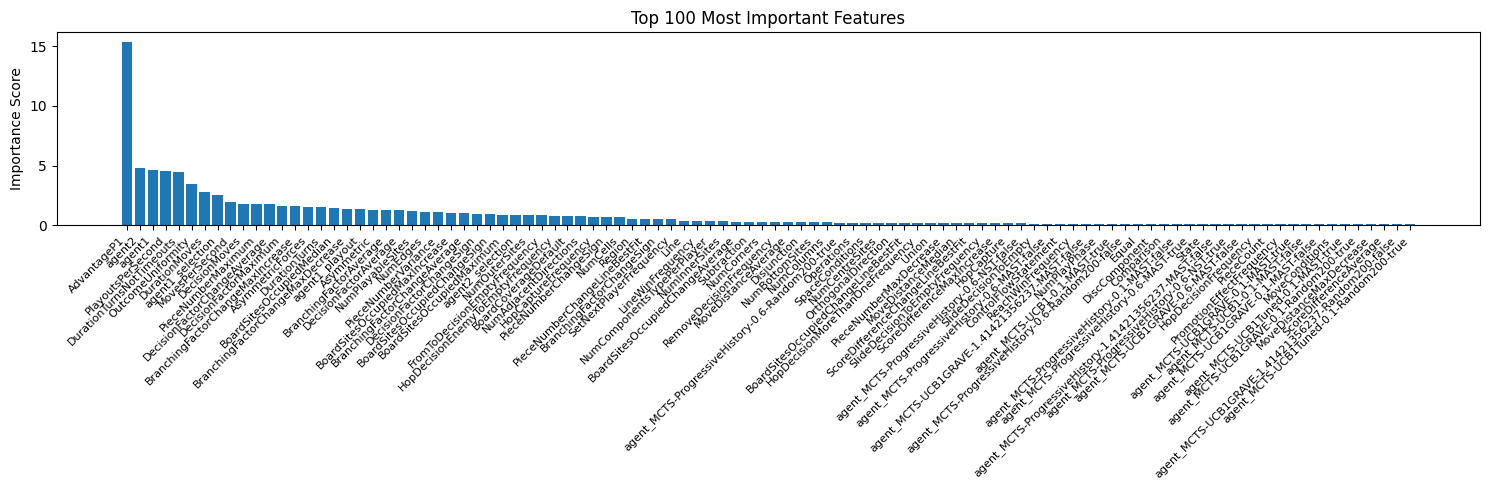

Fold 1 - RMSE: 0.41725001046573185
Fold 2


0:	learn: 0.6241940	test: 0.5890200	best: 0.5890200 (0)	total: 93.4ms	remaining: 15m 33s


50:	learn: 0.4949913	test: 0.5270793	best: 0.5270793 (50)	total: 4.38s	remaining: 14m 14s


100:	learn: 0.4490081	test: 0.5023867	best: 0.5023867 (100)	total: 8.79s	remaining: 14m 21s


150:	learn: 0.4234671	test: 0.4876199	best: 0.4876199 (150)	total: 13.3s	remaining: 14m 26s


200:	learn: 0.4058533	test: 0.4780143	best: 0.4780143 (200)	total: 18.1s	remaining: 14m 42s


250:	learn: 0.3939159	test: 0.4725364	best: 0.4725364 (250)	total: 23.1s	remaining: 14m 56s


300:	learn: 0.3841080	test: 0.4684081	best: 0.4683950 (299)	total: 28s	remaining: 15m 3s


350:	learn: 0.3758006	test: 0.4649889	best: 0.4649889 (350)	total: 33s	remaining: 15m 6s


400:	learn: 0.3690106	test: 0.4619016	best: 0.4619016 (400)	total: 37.9s	remaining: 15m 6s


450:	learn: 0.3614562	test: 0.4585554	best: 0.4585554 (450)	total: 42.5s	remaining: 15m


500:	learn: 0.3547641	test: 0.4558467	best: 0.4558467 (500)	total: 47.1s	remaining: 14m 53s


550:	learn: 0.3502875	test: 0.4546025	best: 0.4546025 (550)	total: 51.9s	remaining: 14m 49s


600:	learn: 0.3456027	test: 0.4530436	best: 0.4530436 (600)	total: 56.7s	remaining: 14m 46s


650:	learn: 0.3418962	test: 0.4518548	best: 0.4518548 (650)	total: 1m 1s	remaining: 14m 41s


700:	learn: 0.3383323	test: 0.4508218	best: 0.4508126 (698)	total: 1m 6s	remaining: 14m 39s


750:	learn: 0.3347008	test: 0.4496203	best: 0.4496203 (750)	total: 1m 10s	remaining: 14m 33s


800:	learn: 0.3319041	test: 0.4488510	best: 0.4488510 (800)	total: 1m 15s	remaining: 14m 30s


850:	learn: 0.3290079	test: 0.4477391	best: 0.4477391 (850)	total: 1m 20s	remaining: 14m 26s


900:	learn: 0.3264141	test: 0.4467572	best: 0.4467572 (900)	total: 1m 25s	remaining: 14m 22s


950:	learn: 0.3236487	test: 0.4456862	best: 0.4456862 (950)	total: 1m 30s	remaining: 14m 18s


1000:	learn: 0.3212412	test: 0.4449935	best: 0.4449935 (1000)	total: 1m 35s	remaining: 14m 15s


1050:	learn: 0.3187871	test: 0.4445245	best: 0.4445209 (1049)	total: 1m 40s	remaining: 14m 11s


1100:	learn: 0.3163847	test: 0.4439000	best: 0.4439000 (1100)	total: 1m 44s	remaining: 14m 7s


1150:	learn: 0.3143155	test: 0.4435423	best: 0.4434974 (1146)	total: 1m 49s	remaining: 14m 4s


1200:	learn: 0.3123496	test: 0.4432304	best: 0.4432304 (1200)	total: 1m 54s	remaining: 14m


1250:	learn: 0.3105649	test: 0.4428477	best: 0.4428298 (1245)	total: 1m 59s	remaining: 13m 56s


1300:	learn: 0.3087436	test: 0.4424145	best: 0.4424145 (1300)	total: 2m 4s	remaining: 13m 53s


1350:	learn: 0.3070358	test: 0.4420221	best: 0.4420221 (1350)	total: 2m 9s	remaining: 13m 48s


1400:	learn: 0.3054061	test: 0.4415689	best: 0.4415689 (1400)	total: 2m 14s	remaining: 13m 45s


1450:	learn: 0.3039230	test: 0.4413102	best: 0.4413075 (1448)	total: 2m 19s	remaining: 13m 42s


1500:	learn: 0.3025098	test: 0.4410345	best: 0.4410086 (1498)	total: 2m 24s	remaining: 13m 38s


1550:	learn: 0.3009583	test: 0.4407454	best: 0.4407454 (1550)	total: 2m 29s	remaining: 13m 34s


1600:	learn: 0.2994926	test: 0.4404197	best: 0.4404197 (1600)	total: 2m 34s	remaining: 13m 30s


1650:	learn: 0.2981250	test: 0.4401584	best: 0.4401584 (1650)	total: 2m 39s	remaining: 13m 26s


1700:	learn: 0.2967412	test: 0.4399542	best: 0.4399542 (1700)	total: 2m 44s	remaining: 13m 22s


1750:	learn: 0.2953181	test: 0.4397550	best: 0.4397550 (1750)	total: 2m 49s	remaining: 13m 18s


1800:	learn: 0.2940893	test: 0.4395145	best: 0.4395145 (1800)	total: 2m 54s	remaining: 13m 14s


1850:	learn: 0.2927242	test: 0.4392197	best: 0.4392197 (1850)	total: 2m 59s	remaining: 13m 10s


1900:	learn: 0.2914711	test: 0.4389825	best: 0.4389825 (1900)	total: 3m 4s	remaining: 13m 5s


1950:	learn: 0.2902698	test: 0.4387791	best: 0.4387791 (1950)	total: 3m 9s	remaining: 13m 1s


2000:	learn: 0.2890145	test: 0.4385875	best: 0.4385848 (1999)	total: 3m 14s	remaining: 12m 56s


2050:	learn: 0.2877127	test: 0.4384301	best: 0.4384229 (2045)	total: 3m 19s	remaining: 12m 52s


2100:	learn: 0.2866807	test: 0.4382655	best: 0.4382655 (2100)	total: 3m 24s	remaining: 12m 49s


2150:	learn: 0.2855175	test: 0.4381403	best: 0.4381301 (2148)	total: 3m 29s	remaining: 12m 44s


2200:	learn: 0.2843832	test: 0.4380268	best: 0.4380268 (2200)	total: 3m 34s	remaining: 12m 40s


2250:	learn: 0.2832659	test: 0.4379015	best: 0.4378975 (2247)	total: 3m 39s	remaining: 12m 36s


2300:	learn: 0.2821983	test: 0.4377026	best: 0.4377026 (2300)	total: 3m 44s	remaining: 12m 31s


2350:	learn: 0.2811679	test: 0.4375596	best: 0.4375596 (2350)	total: 3m 49s	remaining: 12m 27s


2400:	learn: 0.2802248	test: 0.4374360	best: 0.4374360 (2400)	total: 3m 54s	remaining: 12m 23s


2450:	learn: 0.2792502	test: 0.4373275	best: 0.4373275 (2450)	total: 3m 59s	remaining: 12m 18s


2500:	learn: 0.2782912	test: 0.4371819	best: 0.4371819 (2500)	total: 4m 4s	remaining: 12m 14s


2550:	learn: 0.2773032	test: 0.4370559	best: 0.4370559 (2550)	total: 4m 9s	remaining: 12m 9s


2600:	learn: 0.2763225	test: 0.4369475	best: 0.4369475 (2600)	total: 4m 14s	remaining: 12m 5s


2650:	learn: 0.2753434	test: 0.4369211	best: 0.4369070 (2624)	total: 4m 19s	remaining: 12m


2700:	learn: 0.2744193	test: 0.4368479	best: 0.4368435 (2699)	total: 4m 24s	remaining: 11m 55s


2750:	learn: 0.2735140	test: 0.4366929	best: 0.4366866 (2737)	total: 4m 29s	remaining: 11m 51s


2800:	learn: 0.2726440	test: 0.4365382	best: 0.4365382 (2800)	total: 4m 34s	remaining: 11m 46s


2850:	learn: 0.2718319	test: 0.4363582	best: 0.4363582 (2850)	total: 4m 39s	remaining: 11m 41s


2900:	learn: 0.2709798	test: 0.4362300	best: 0.4362300 (2900)	total: 4m 44s	remaining: 11m 37s


2950:	learn: 0.2701616	test: 0.4360786	best: 0.4360786 (2950)	total: 4m 50s	remaining: 11m 32s


3000:	learn: 0.2693837	test: 0.4359030	best: 0.4359030 (3000)	total: 4m 55s	remaining: 11m 28s


3050:	learn: 0.2685452	test: 0.4357723	best: 0.4357665 (3047)	total: 5m	remaining: 11m 23s


3100:	learn: 0.2677880	test: 0.4356675	best: 0.4356675 (3100)	total: 5m 5s	remaining: 11m 18s


3150:	learn: 0.2670329	test: 0.4355702	best: 0.4355615 (3146)	total: 5m 10s	remaining: 11m 14s


3200:	learn: 0.2662909	test: 0.4354540	best: 0.4354540 (3200)	total: 5m 15s	remaining: 11m 9s


3250:	learn: 0.2655190	test: 0.4353472	best: 0.4353373 (3243)	total: 5m 20s	remaining: 11m 4s


3300:	learn: 0.2647899	test: 0.4352856	best: 0.4352841 (3299)	total: 5m 25s	remaining: 11m


3350:	learn: 0.2640639	test: 0.4352398	best: 0.4352398 (3350)	total: 5m 30s	remaining: 10m 55s


3400:	learn: 0.2633851	test: 0.4352122	best: 0.4351798 (3386)	total: 5m 35s	remaining: 10m 50s


3450:	learn: 0.2627301	test: 0.4351398	best: 0.4351398 (3450)	total: 5m 40s	remaining: 10m 46s


3500:	learn: 0.2620448	test: 0.4350754	best: 0.4350754 (3500)	total: 5m 45s	remaining: 10m 41s


3550:	learn: 0.2613416	test: 0.4350175	best: 0.4350052 (3543)	total: 5m 50s	remaining: 10m 37s


3600:	learn: 0.2606494	test: 0.4348906	best: 0.4348906 (3600)	total: 5m 55s	remaining: 10m 32s


3650:	learn: 0.2599876	test: 0.4348295	best: 0.4348264 (3646)	total: 6m 1s	remaining: 10m 27s


3700:	learn: 0.2593120	test: 0.4347084	best: 0.4347084 (3700)	total: 6m 6s	remaining: 10m 23s


3750:	learn: 0.2586789	test: 0.4346111	best: 0.4346111 (3750)	total: 6m 11s	remaining: 10m 18s


3800:	learn: 0.2580585	test: 0.4345171	best: 0.4345171 (3800)	total: 6m 16s	remaining: 10m 13s


3850:	learn: 0.2573799	test: 0.4344626	best: 0.4344626 (3850)	total: 6m 21s	remaining: 10m 9s


3900:	learn: 0.2567892	test: 0.4344246	best: 0.4344112 (3896)	total: 6m 26s	remaining: 10m 4s


3950:	learn: 0.2561542	test: 0.4343946	best: 0.4343802 (3938)	total: 6m 31s	remaining: 9m 59s


4000:	learn: 0.2555349	test: 0.4342998	best: 0.4342998 (4000)	total: 6m 36s	remaining: 9m 54s


4050:	learn: 0.2549440	test: 0.4342138	best: 0.4342080 (4041)	total: 6m 41s	remaining: 9m 49s


4100:	learn: 0.2543216	test: 0.4341471	best: 0.4341387 (4095)	total: 6m 46s	remaining: 9m 45s


4150:	learn: 0.2536925	test: 0.4340794	best: 0.4340725 (4137)	total: 6m 51s	remaining: 9m 40s


4200:	learn: 0.2531068	test: 0.4340206	best: 0.4340206 (4200)	total: 6m 57s	remaining: 9m 35s


4250:	learn: 0.2525583	test: 0.4339687	best: 0.4339643 (4248)	total: 7m 2s	remaining: 9m 31s


4300:	learn: 0.2519317	test: 0.4338944	best: 0.4338944 (4300)	total: 7m 7s	remaining: 9m 26s


4350:	learn: 0.2513658	test: 0.4338009	best: 0.4338009 (4350)	total: 7m 12s	remaining: 9m 21s


4400:	learn: 0.2508119	test: 0.4337497	best: 0.4337439 (4393)	total: 7m 17s	remaining: 9m 16s


4450:	learn: 0.2502584	test: 0.4337325	best: 0.4337225 (4434)	total: 7m 22s	remaining: 9m 11s


4500:	learn: 0.2497034	test: 0.4336880	best: 0.4336880 (4500)	total: 7m 27s	remaining: 9m 6s


4550:	learn: 0.2491601	test: 0.4336152	best: 0.4336050 (4548)	total: 7m 32s	remaining: 9m 1s


4600:	learn: 0.2486438	test: 0.4335890	best: 0.4335879 (4577)	total: 7m 37s	remaining: 8m 57s


4650:	learn: 0.2480885	test: 0.4335327	best: 0.4335327 (4650)	total: 7m 42s	remaining: 8m 52s


4700:	learn: 0.2475177	test: 0.4334717	best: 0.4334699 (4698)	total: 7m 47s	remaining: 8m 47s


4750:	learn: 0.2470117	test: 0.4334508	best: 0.4334436 (4745)	total: 7m 52s	remaining: 8m 42s


4800:	learn: 0.2464952	test: 0.4334130	best: 0.4334121 (4791)	total: 7m 57s	remaining: 8m 37s


4850:	learn: 0.2459948	test: 0.4333363	best: 0.4333352 (4849)	total: 8m 3s	remaining: 8m 33s


4900:	learn: 0.2454664	test: 0.4332770	best: 0.4332699 (4878)	total: 8m 8s	remaining: 8m 28s


4950:	learn: 0.2449522	test: 0.4332405	best: 0.4332405 (4950)	total: 8m 13s	remaining: 8m 23s


5000:	learn: 0.2444482	test: 0.4332016	best: 0.4332016 (5000)	total: 8m 18s	remaining: 8m 18s


5050:	learn: 0.2439553	test: 0.4331673	best: 0.4331672 (5048)	total: 8m 23s	remaining: 8m 13s


5100:	learn: 0.2434323	test: 0.4331419	best: 0.4331371 (5094)	total: 8m 28s	remaining: 8m 8s


5150:	learn: 0.2429625	test: 0.4331222	best: 0.4331177 (5147)	total: 8m 33s	remaining: 8m 3s


5200:	learn: 0.2424872	test: 0.4330807	best: 0.4330752 (5195)	total: 8m 39s	remaining: 7m 58s


5250:	learn: 0.2420195	test: 0.4330282	best: 0.4330282 (5250)	total: 8m 44s	remaining: 7m 54s


5300:	learn: 0.2415350	test: 0.4329353	best: 0.4329339 (5299)	total: 8m 49s	remaining: 7m 49s


5350:	learn: 0.2410417	test: 0.4329051	best: 0.4328926 (5346)	total: 8m 54s	remaining: 7m 44s


5400:	learn: 0.2405934	test: 0.4328719	best: 0.4328707 (5398)	total: 8m 59s	remaining: 7m 39s


5450:	learn: 0.2401197	test: 0.4328259	best: 0.4328244 (5432)	total: 9m 4s	remaining: 7m 34s


5500:	learn: 0.2396326	test: 0.4327824	best: 0.4327820 (5499)	total: 9m 9s	remaining: 7m 29s


5550:	learn: 0.2391566	test: 0.4327036	best: 0.4326991 (5548)	total: 9m 14s	remaining: 7m 24s


5600:	learn: 0.2386680	test: 0.4326773	best: 0.4326708 (5592)	total: 9m 19s	remaining: 7m 19s


5650:	learn: 0.2382281	test: 0.4326325	best: 0.4326260 (5646)	total: 9m 24s	remaining: 7m 14s


5700:	learn: 0.2377938	test: 0.4325776	best: 0.4325776 (5700)	total: 9m 30s	remaining: 7m 9s


5750:	learn: 0.2373517	test: 0.4325517	best: 0.4325517 (5750)	total: 9m 35s	remaining: 7m 4s


5800:	learn: 0.2369317	test: 0.4325175	best: 0.4325080 (5794)	total: 9m 40s	remaining: 7m


5850:	learn: 0.2364717	test: 0.4324503	best: 0.4324503 (5850)	total: 9m 45s	remaining: 6m 55s


5900:	learn: 0.2360399	test: 0.4323906	best: 0.4323906 (5900)	total: 9m 50s	remaining: 6m 50s


5950:	learn: 0.2355744	test: 0.4323245	best: 0.4323245 (5950)	total: 9m 55s	remaining: 6m 45s


6000:	learn: 0.2351463	test: 0.4323112	best: 0.4323062 (5977)	total: 10m	remaining: 6m 40s


6050:	learn: 0.2347194	test: 0.4322615	best: 0.4322613 (6049)	total: 10m 5s	remaining: 6m 35s


6100:	learn: 0.2343145	test: 0.4322025	best: 0.4322021 (6099)	total: 10m 11s	remaining: 6m 30s


6150:	learn: 0.2338644	test: 0.4321871	best: 0.4321871 (6150)	total: 10m 16s	remaining: 6m 25s


6200:	learn: 0.2334570	test: 0.4321459	best: 0.4321459 (6200)	total: 10m 21s	remaining: 6m 20s


6250:	learn: 0.2330340	test: 0.4320921	best: 0.4320921 (6250)	total: 10m 26s	remaining: 6m 15s


6300:	learn: 0.2325928	test: 0.4320837	best: 0.4320792 (6297)	total: 10m 31s	remaining: 6m 10s


6350:	learn: 0.2321996	test: 0.4320483	best: 0.4320483 (6350)	total: 10m 36s	remaining: 6m 5s


6400:	learn: 0.2318110	test: 0.4320253	best: 0.4320238 (6388)	total: 10m 41s	remaining: 6m


6450:	learn: 0.2313747	test: 0.4319867	best: 0.4319867 (6450)	total: 10m 46s	remaining: 5m 55s


6500:	learn: 0.2309794	test: 0.4319196	best: 0.4319196 (6500)	total: 10m 52s	remaining: 5m 51s


6550:	learn: 0.2305812	test: 0.4318766	best: 0.4318742 (6534)	total: 10m 57s	remaining: 5m 46s


6600:	learn: 0.2301892	test: 0.4318449	best: 0.4318449 (6600)	total: 11m 2s	remaining: 5m 41s


6650:	learn: 0.2297778	test: 0.4318461	best: 0.4318367 (6641)	total: 11m 7s	remaining: 5m 36s


6700:	learn: 0.2293815	test: 0.4318085	best: 0.4318079 (6698)	total: 11m 12s	remaining: 5m 31s


6750:	learn: 0.2289916	test: 0.4317854	best: 0.4317824 (6747)	total: 11m 17s	remaining: 5m 26s


6800:	learn: 0.2286175	test: 0.4317751	best: 0.4317703 (6777)	total: 11m 22s	remaining: 5m 21s


6850:	learn: 0.2282278	test: 0.4317374	best: 0.4317363 (6849)	total: 11m 28s	remaining: 5m 16s


6900:	learn: 0.2278649	test: 0.4317153	best: 0.4317153 (6900)	total: 11m 33s	remaining: 5m 11s


6950:	learn: 0.2274769	test: 0.4316860	best: 0.4316860 (6950)	total: 11m 38s	remaining: 5m 6s


7000:	learn: 0.2270828	test: 0.4316520	best: 0.4316511 (6998)	total: 11m 43s	remaining: 5m 1s


7050:	learn: 0.2267199	test: 0.4316293	best: 0.4316268 (7042)	total: 11m 48s	remaining: 4m 56s


7100:	learn: 0.2263465	test: 0.4316003	best: 0.4316003 (7100)	total: 11m 53s	remaining: 4m 51s


7150:	learn: 0.2259611	test: 0.4315837	best: 0.4315797 (7142)	total: 11m 58s	remaining: 4m 46s


7200:	learn: 0.2256372	test: 0.4315472	best: 0.4315462 (7185)	total: 12m 4s	remaining: 4m 41s


7250:	learn: 0.2252822	test: 0.4314839	best: 0.4314839 (7250)	total: 12m 9s	remaining: 4m 36s


7300:	learn: 0.2249484	test: 0.4314632	best: 0.4314577 (7289)	total: 12m 14s	remaining: 4m 31s


7350:	learn: 0.2245856	test: 0.4314316	best: 0.4314306 (7348)	total: 12m 19s	remaining: 4m 26s


7400:	learn: 0.2242463	test: 0.4314082	best: 0.4314082 (7400)	total: 12m 24s	remaining: 4m 21s


7450:	learn: 0.2238935	test: 0.4313913	best: 0.4313854 (7444)	total: 12m 30s	remaining: 4m 16s


7500:	learn: 0.2235314	test: 0.4313817	best: 0.4313755 (7484)	total: 12m 35s	remaining: 4m 11s


7550:	learn: 0.2231891	test: 0.4313590	best: 0.4313544 (7549)	total: 12m 40s	remaining: 4m 6s


7600:	learn: 0.2228320	test: 0.4313297	best: 0.4313272 (7593)	total: 12m 45s	remaining: 4m 1s


7650:	learn: 0.2224940	test: 0.4313147	best: 0.4313143 (7649)	total: 12m 50s	remaining: 3m 56s


7700:	learn: 0.2221269	test: 0.4312966	best: 0.4312966 (7700)	total: 12m 55s	remaining: 3m 51s


7750:	learn: 0.2217655	test: 0.4312887	best: 0.4312878 (7747)	total: 13m 1s	remaining: 3m 46s


7800:	learn: 0.2214102	test: 0.4312616	best: 0.4312589 (7797)	total: 13m 6s	remaining: 3m 41s


7850:	learn: 0.2211032	test: 0.4312515	best: 0.4312515 (7850)	total: 13m 11s	remaining: 3m 36s


7900:	learn: 0.2207442	test: 0.4312705	best: 0.4312515 (7850)	total: 13m 16s	remaining: 3m 31s


7950:	learn: 0.2204195	test: 0.4312638	best: 0.4312515 (7850)	total: 13m 21s	remaining: 3m 26s


8000:	learn: 0.2200742	test: 0.4312528	best: 0.4312515 (7850)	total: 13m 26s	remaining: 3m 21s


8050:	learn: 0.2197264	test: 0.4312292	best: 0.4312263 (8047)	total: 13m 31s	remaining: 3m 16s


8100:	learn: 0.2193808	test: 0.4312010	best: 0.4311978 (8095)	total: 13m 36s	remaining: 3m 11s


8150:	learn: 0.2190257	test: 0.4311829	best: 0.4311821 (8149)	total: 13m 42s	remaining: 3m 6s


8200:	learn: 0.2186549	test: 0.4311693	best: 0.4311693 (8200)	total: 13m 47s	remaining: 3m 1s


8250:	learn: 0.2183021	test: 0.4311589	best: 0.4311571 (8249)	total: 13m 52s	remaining: 2m 56s


8300:	learn: 0.2179817	test: 0.4311459	best: 0.4311432 (8290)	total: 13m 57s	remaining: 2m 51s


8350:	learn: 0.2176640	test: 0.4311283	best: 0.4311282 (8349)	total: 14m 2s	remaining: 2m 46s


8400:	learn: 0.2173554	test: 0.4311100	best: 0.4311097 (8399)	total: 14m 7s	remaining: 2m 41s


8450:	learn: 0.2170288	test: 0.4311211	best: 0.4311048 (8408)	total: 14m 13s	remaining: 2m 36s


8500:	learn: 0.2167094	test: 0.4311134	best: 0.4311048 (8408)	total: 14m 18s	remaining: 2m 31s


8550:	learn: 0.2163923	test: 0.4310972	best: 0.4310970 (8548)	total: 14m 23s	remaining: 2m 26s


8600:	learn: 0.2160686	test: 0.4311000	best: 0.4310887 (8579)	total: 14m 28s	remaining: 2m 21s


8650:	learn: 0.2157449	test: 0.4310887	best: 0.4310846 (8627)	total: 14m 33s	remaining: 2m 16s


8700:	learn: 0.2154130	test: 0.4310467	best: 0.4310467 (8700)	total: 14m 38s	remaining: 2m 11s


8750:	learn: 0.2150813	test: 0.4310335	best: 0.4310324 (8743)	total: 14m 44s	remaining: 2m 6s


8800:	learn: 0.2147470	test: 0.4310078	best: 0.4310073 (8795)	total: 14m 49s	remaining: 2m 1s


8850:	learn: 0.2144470	test: 0.4309908	best: 0.4309899 (8844)	total: 14m 54s	remaining: 1m 56s


8900:	learn: 0.2141084	test: 0.4309559	best: 0.4309559 (8900)	total: 14m 59s	remaining: 1m 51s


8950:	learn: 0.2138060	test: 0.4309412	best: 0.4309391 (8949)	total: 15m 4s	remaining: 1m 46s


9000:	learn: 0.2135148	test: 0.4309205	best: 0.4309177 (8987)	total: 15m 9s	remaining: 1m 40s


9050:	learn: 0.2131647	test: 0.4308956	best: 0.4308956 (9050)	total: 15m 15s	remaining: 1m 35s


9100:	learn: 0.2128277	test: 0.4308820	best: 0.4308734 (9088)	total: 15m 20s	remaining: 1m 30s


9150:	learn: 0.2125465	test: 0.4308685	best: 0.4308634 (9143)	total: 15m 25s	remaining: 1m 25s


9200:	learn: 0.2122593	test: 0.4308655	best: 0.4308623 (9176)	total: 15m 30s	remaining: 1m 20s


9250:	learn: 0.2119451	test: 0.4308451	best: 0.4308451 (9250)	total: 15m 35s	remaining: 1m 15s


9300:	learn: 0.2116494	test: 0.4308211	best: 0.4308205 (9297)	total: 15m 40s	remaining: 1m 10s


9350:	learn: 0.2113588	test: 0.4308090	best: 0.4308087 (9349)	total: 15m 45s	remaining: 1m 5s


9400:	learn: 0.2110537	test: 0.4307946	best: 0.4307946 (9400)	total: 15m 51s	remaining: 1m


9450:	learn: 0.2107603	test: 0.4307829	best: 0.4307814 (9449)	total: 15m 56s	remaining: 55.5s


9500:	learn: 0.2104489	test: 0.4307481	best: 0.4307418 (9489)	total: 16m 1s	remaining: 50.5s


9550:	learn: 0.2101675	test: 0.4307290	best: 0.4307268 (9544)	total: 16m 6s	remaining: 45.4s


9600:	learn: 0.2098506	test: 0.4306895	best: 0.4306873 (9598)	total: 16m 11s	remaining: 40.4s


9650:	learn: 0.2095638	test: 0.4306702	best: 0.4306644 (9643)	total: 16m 16s	remaining: 35.3s


9700:	learn: 0.2092767	test: 0.4306570	best: 0.4306558 (9697)	total: 16m 21s	remaining: 30.3s


9750:	learn: 0.2089795	test: 0.4306729	best: 0.4306555 (9707)	total: 16m 26s	remaining: 25.2s


9800:	learn: 0.2086915	test: 0.4306637	best: 0.4306555 (9707)	total: 16m 32s	remaining: 20.1s


9850:	learn: 0.2083937	test: 0.4306352	best: 0.4306344 (9846)	total: 16m 37s	remaining: 15.1s


9900:	learn: 0.2080949	test: 0.4306259	best: 0.4306246 (9892)	total: 16m 42s	remaining: 10s


9950:	learn: 0.2078122	test: 0.4306143	best: 0.4306130 (9925)	total: 16m 47s	remaining: 4.96s


9999:	learn: 0.2075186	test: 0.4305894	best: 0.4305855 (9975)	total: 16m 52s	remaining: 0us

bestTest = 0.4305855258
bestIteration = 9975

Shrink model to first 9976 iterations.


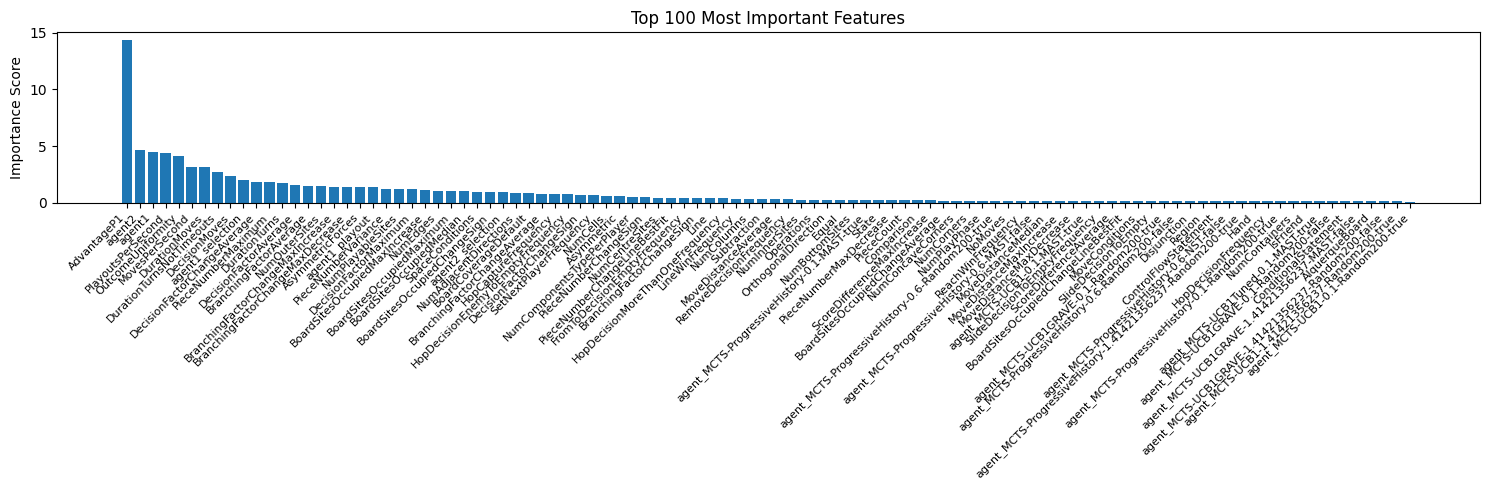

Fold 2 - RMSE: 0.4302510877522118
Fold 3


0:	learn: 0.6210455	test: 0.6058324	best: 0.6058324 (0)	total: 88.2ms	remaining: 14m 41s


50:	learn: 0.4930329	test: 0.5297153	best: 0.5297153 (50)	total: 4.34s	remaining: 14m 6s


100:	learn: 0.4489284	test: 0.4966029	best: 0.4966029 (100)	total: 8.81s	remaining: 14m 23s


150:	learn: 0.4230450	test: 0.4818547	best: 0.4818547 (150)	total: 13.4s	remaining: 14m 31s


200:	learn: 0.4068245	test: 0.4720968	best: 0.4720968 (200)	total: 18.1s	remaining: 14m 44s


250:	learn: 0.3944168	test: 0.4663348	best: 0.4663348 (250)	total: 22.9s	remaining: 14m 49s


300:	learn: 0.3846891	test: 0.4617131	best: 0.4617131 (300)	total: 27.8s	remaining: 14m 55s


350:	learn: 0.3764093	test: 0.4576484	best: 0.4576484 (350)	total: 32.7s	remaining: 14m 57s


400:	learn: 0.3686266	test: 0.4543387	best: 0.4543387 (400)	total: 37.4s	remaining: 14m 54s


450:	learn: 0.3620805	test: 0.4510292	best: 0.4510292 (450)	total: 42.2s	remaining: 14m 54s


500:	learn: 0.3563523	test: 0.4482391	best: 0.4482391 (500)	total: 46.9s	remaining: 14m 48s


550:	learn: 0.3515630	test: 0.4463522	best: 0.4463281 (548)	total: 51.5s	remaining: 14m 43s


600:	learn: 0.3471248	test: 0.4448438	best: 0.4448438 (600)	total: 56.3s	remaining: 14m 39s


650:	learn: 0.3430552	test: 0.4431322	best: 0.4431322 (650)	total: 1m 1s	remaining: 14m 36s


700:	learn: 0.3393691	test: 0.4416815	best: 0.4416815 (700)	total: 1m 5s	remaining: 14m 31s


750:	learn: 0.3358121	test: 0.4405056	best: 0.4404854 (749)	total: 1m 10s	remaining: 14m 25s


800:	learn: 0.3327686	test: 0.4393008	best: 0.4393008 (800)	total: 1m 15s	remaining: 14m 22s


850:	learn: 0.3297398	test: 0.4382244	best: 0.4382244 (850)	total: 1m 19s	remaining: 14m 18s


900:	learn: 0.3271025	test: 0.4372063	best: 0.4372063 (900)	total: 1m 24s	remaining: 14m 15s


950:	learn: 0.3243550	test: 0.4362485	best: 0.4362485 (950)	total: 1m 29s	remaining: 14m 11s


1000:	learn: 0.3219377	test: 0.4354213	best: 0.4354213 (1000)	total: 1m 34s	remaining: 14m 7s


1050:	learn: 0.3196206	test: 0.4349491	best: 0.4349491 (1050)	total: 1m 39s	remaining: 14m 3s


1100:	learn: 0.3173960	test: 0.4343459	best: 0.4343459 (1100)	total: 1m 43s	remaining: 13m 58s


1150:	learn: 0.3152943	test: 0.4335598	best: 0.4335598 (1150)	total: 1m 48s	remaining: 13m 54s


1200:	learn: 0.3132694	test: 0.4331102	best: 0.4331102 (1200)	total: 1m 53s	remaining: 13m 49s


1250:	learn: 0.3113090	test: 0.4326161	best: 0.4326153 (1249)	total: 1m 58s	remaining: 13m 45s


1300:	learn: 0.3093661	test: 0.4321265	best: 0.4321265 (1300)	total: 2m 2s	remaining: 13m 41s


1350:	learn: 0.3075762	test: 0.4316481	best: 0.4316481 (1350)	total: 2m 7s	remaining: 13m 37s


1400:	learn: 0.3058198	test: 0.4312678	best: 0.4312678 (1400)	total: 2m 12s	remaining: 13m 33s


1450:	learn: 0.3040419	test: 0.4308390	best: 0.4308292 (1447)	total: 2m 17s	remaining: 13m 29s


1500:	learn: 0.3023752	test: 0.4305217	best: 0.4305217 (1500)	total: 2m 22s	remaining: 13m 25s


1550:	learn: 0.3007914	test: 0.4302936	best: 0.4302936 (1550)	total: 2m 27s	remaining: 13m 21s


1600:	learn: 0.2992857	test: 0.4299445	best: 0.4299445 (1600)	total: 2m 31s	remaining: 13m 17s


1650:	learn: 0.2978537	test: 0.4295626	best: 0.4295620 (1649)	total: 2m 36s	remaining: 13m 12s


1700:	learn: 0.2963666	test: 0.4292891	best: 0.4292845 (1698)	total: 2m 41s	remaining: 13m 9s


1750:	learn: 0.2948456	test: 0.4290117	best: 0.4290117 (1750)	total: 2m 46s	remaining: 13m 4s


1800:	learn: 0.2934274	test: 0.4286005	best: 0.4286005 (1800)	total: 2m 51s	remaining: 13m


1850:	learn: 0.2921582	test: 0.4283373	best: 0.4283373 (1850)	total: 2m 56s	remaining: 12m 56s


1900:	learn: 0.2909069	test: 0.4280831	best: 0.4280831 (1900)	total: 3m 1s	remaining: 12m 51s


1950:	learn: 0.2897194	test: 0.4277993	best: 0.4277993 (1950)	total: 3m 6s	remaining: 12m 47s


2000:	learn: 0.2885539	test: 0.4275961	best: 0.4275961 (2000)	total: 3m 10s	remaining: 12m 43s


2050:	learn: 0.2874719	test: 0.4273792	best: 0.4273792 (2050)	total: 3m 15s	remaining: 12m 38s


2100:	learn: 0.2863807	test: 0.4271954	best: 0.4271935 (2099)	total: 3m 20s	remaining: 12m 34s


2150:	learn: 0.2853044	test: 0.4270071	best: 0.4270042 (2146)	total: 3m 25s	remaining: 12m 30s


2200:	learn: 0.2842907	test: 0.4268229	best: 0.4268181 (2198)	total: 3m 30s	remaining: 12m 26s


2250:	learn: 0.2831105	test: 0.4266960	best: 0.4266960 (2250)	total: 3m 35s	remaining: 12m 22s


2300:	learn: 0.2820192	test: 0.4264941	best: 0.4264941 (2300)	total: 3m 40s	remaining: 12m 17s


2350:	learn: 0.2809216	test: 0.4262561	best: 0.4262561 (2350)	total: 3m 45s	remaining: 12m 13s


2400:	learn: 0.2800186	test: 0.4260450	best: 0.4260434 (2396)	total: 3m 50s	remaining: 12m 9s


2450:	learn: 0.2790488	test: 0.4258855	best: 0.4258742 (2446)	total: 3m 55s	remaining: 12m 4s


2500:	learn: 0.2781056	test: 0.4257605	best: 0.4257605 (2500)	total: 4m	remaining: 12m


2550:	learn: 0.2772141	test: 0.4256424	best: 0.4256361 (2548)	total: 4m 5s	remaining: 11m 56s


2600:	learn: 0.2762787	test: 0.4255093	best: 0.4255093 (2600)	total: 4m 10s	remaining: 11m 51s


2650:	learn: 0.2753113	test: 0.4253797	best: 0.4253797 (2650)	total: 4m 15s	remaining: 11m 47s


2700:	learn: 0.2742605	test: 0.4251407	best: 0.4251407 (2700)	total: 4m 20s	remaining: 11m 42s


2750:	learn: 0.2734245	test: 0.4250449	best: 0.4250449 (2750)	total: 4m 25s	remaining: 11m 38s


2800:	learn: 0.2725294	test: 0.4248699	best: 0.4248649 (2799)	total: 4m 29s	remaining: 11m 33s


2850:	learn: 0.2716257	test: 0.4247454	best: 0.4247454 (2850)	total: 4m 35s	remaining: 11m 29s


2900:	learn: 0.2708305	test: 0.4246532	best: 0.4246532 (2898)	total: 4m 40s	remaining: 11m 25s


2950:	learn: 0.2699585	test: 0.4245400	best: 0.4245384 (2947)	total: 4m 44s	remaining: 11m 20s


3000:	learn: 0.2691713	test: 0.4244345	best: 0.4244345 (3000)	total: 4m 49s	remaining: 11m 16s


3050:	learn: 0.2683411	test: 0.4243634	best: 0.4243634 (3050)	total: 4m 54s	remaining: 11m 11s


3100:	learn: 0.2675192	test: 0.4242981	best: 0.4242981 (3100)	total: 4m 59s	remaining: 11m 6s


3150:	learn: 0.2667349	test: 0.4241273	best: 0.4241273 (3150)	total: 5m 4s	remaining: 11m 2s


3200:	learn: 0.2659934	test: 0.4240588	best: 0.4240588 (3200)	total: 5m 9s	remaining: 10m 57s


3250:	learn: 0.2652130	test: 0.4239816	best: 0.4239816 (3250)	total: 5m 14s	remaining: 10m 53s


3300:	learn: 0.2644764	test: 0.4238584	best: 0.4238584 (3300)	total: 5m 19s	remaining: 10m 48s


3350:	learn: 0.2637505	test: 0.4237923	best: 0.4237829 (3344)	total: 5m 24s	remaining: 10m 44s


3400:	learn: 0.2629804	test: 0.4237098	best: 0.4237098 (3400)	total: 5m 29s	remaining: 10m 40s


3450:	learn: 0.2622676	test: 0.4236665	best: 0.4236600 (3429)	total: 5m 34s	remaining: 10m 35s


3500:	learn: 0.2615317	test: 0.4236292	best: 0.4236287 (3499)	total: 5m 39s	remaining: 10m 30s


3550:	learn: 0.2608833	test: 0.4235543	best: 0.4235543 (3550)	total: 5m 44s	remaining: 10m 26s


3600:	learn: 0.2601584	test: 0.4234596	best: 0.4234596 (3600)	total: 5m 50s	remaining: 10m 21s


3650:	learn: 0.2594923	test: 0.4233570	best: 0.4233570 (3650)	total: 5m 55s	remaining: 10m 17s


3700:	learn: 0.2588235	test: 0.4232623	best: 0.4232623 (3700)	total: 6m	remaining: 10m 12s


3750:	learn: 0.2581653	test: 0.4232208	best: 0.4232120 (3748)	total: 6m 4s	remaining: 10m 7s


3800:	learn: 0.2575187	test: 0.4231429	best: 0.4231393 (3795)	total: 6m 9s	remaining: 10m 3s


3850:	learn: 0.2568139	test: 0.4230401	best: 0.4230401 (3849)	total: 6m 14s	remaining: 9m 58s


3900:	learn: 0.2562284	test: 0.4229822	best: 0.4229800 (3891)	total: 6m 19s	remaining: 9m 53s


3950:	learn: 0.2555690	test: 0.4229259	best: 0.4229259 (3950)	total: 6m 24s	remaining: 9m 48s


4000:	learn: 0.2549533	test: 0.4228613	best: 0.4228479 (3997)	total: 6m 29s	remaining: 9m 44s


4050:	learn: 0.2542809	test: 0.4227670	best: 0.4227670 (4050)	total: 6m 34s	remaining: 9m 39s


4100:	learn: 0.2536917	test: 0.4227123	best: 0.4227123 (4100)	total: 6m 39s	remaining: 9m 34s


4150:	learn: 0.2530360	test: 0.4226805	best: 0.4226800 (4149)	total: 6m 44s	remaining: 9m 29s


4200:	learn: 0.2524407	test: 0.4226473	best: 0.4226404 (4195)	total: 6m 49s	remaining: 9m 25s


4250:	learn: 0.2518709	test: 0.4225571	best: 0.4225571 (4250)	total: 6m 54s	remaining: 9m 20s


4300:	learn: 0.2512964	test: 0.4224783	best: 0.4224737 (4297)	total: 6m 59s	remaining: 9m 16s


4350:	learn: 0.2507273	test: 0.4224063	best: 0.4224063 (4350)	total: 7m 4s	remaining: 9m 11s


4400:	learn: 0.2501690	test: 0.4223983	best: 0.4223900 (4372)	total: 7m 9s	remaining: 9m 6s


4450:	learn: 0.2496301	test: 0.4223227	best: 0.4223227 (4450)	total: 7m 14s	remaining: 9m 2s


4500:	learn: 0.2490629	test: 0.4222590	best: 0.4222590 (4500)	total: 7m 19s	remaining: 8m 57s


4550:	learn: 0.2485594	test: 0.4222168	best: 0.4222168 (4550)	total: 7m 24s	remaining: 8m 52s


4600:	learn: 0.2480226	test: 0.4221248	best: 0.4221247 (4592)	total: 7m 30s	remaining: 8m 48s


4650:	learn: 0.2475152	test: 0.4220659	best: 0.4220659 (4649)	total: 7m 35s	remaining: 8m 43s


4700:	learn: 0.2470225	test: 0.4219992	best: 0.4219992 (4700)	total: 7m 40s	remaining: 8m 38s


4750:	learn: 0.2464413	test: 0.4219045	best: 0.4219045 (4750)	total: 7m 45s	remaining: 8m 33s


4800:	learn: 0.2458989	test: 0.4218648	best: 0.4218543 (4794)	total: 7m 49s	remaining: 8m 28s


4850:	learn: 0.2454212	test: 0.4218304	best: 0.4218275 (4838)	total: 7m 54s	remaining: 8m 24s


4900:	learn: 0.2448637	test: 0.4217713	best: 0.4217711 (4899)	total: 7m 59s	remaining: 8m 19s


4950:	learn: 0.2443395	test: 0.4217132	best: 0.4217132 (4950)	total: 8m 4s	remaining: 8m 14s


5000:	learn: 0.2438282	test: 0.4216697	best: 0.4216697 (5000)	total: 8m 10s	remaining: 8m 9s


5050:	learn: 0.2433760	test: 0.4216369	best: 0.4216369 (5050)	total: 8m 15s	remaining: 8m 5s


5100:	learn: 0.2429011	test: 0.4216346	best: 0.4216297 (5080)	total: 8m 20s	remaining: 8m


5150:	learn: 0.2423955	test: 0.4215943	best: 0.4215943 (5150)	total: 8m 25s	remaining: 7m 55s


5200:	learn: 0.2419238	test: 0.4215725	best: 0.4215725 (5192)	total: 8m 30s	remaining: 7m 50s


5250:	learn: 0.2414529	test: 0.4215620	best: 0.4215533 (5245)	total: 8m 35s	remaining: 7m 46s


5300:	learn: 0.2409660	test: 0.4215434	best: 0.4215426 (5286)	total: 8m 40s	remaining: 7m 41s


5350:	learn: 0.2404580	test: 0.4214782	best: 0.4214782 (5350)	total: 8m 45s	remaining: 7m 36s


5400:	learn: 0.2400099	test: 0.4214692	best: 0.4214650 (5398)	total: 8m 50s	remaining: 7m 31s


5450:	learn: 0.2395524	test: 0.4214545	best: 0.4214456 (5447)	total: 8m 55s	remaining: 7m 26s


5500:	learn: 0.2390444	test: 0.4214315	best: 0.4214312 (5499)	total: 9m	remaining: 7m 22s


5550:	learn: 0.2385521	test: 0.4213694	best: 0.4213694 (5550)	total: 9m 5s	remaining: 7m 17s


5600:	learn: 0.2381370	test: 0.4213239	best: 0.4213239 (5600)	total: 9m 10s	remaining: 7m 12s


5650:	learn: 0.2376716	test: 0.4213219	best: 0.4213106 (5618)	total: 9m 15s	remaining: 7m 7s


5700:	learn: 0.2372459	test: 0.4212810	best: 0.4212792 (5699)	total: 9m 21s	remaining: 7m 3s


5750:	learn: 0.2367901	test: 0.4212736	best: 0.4212667 (5723)	total: 9m 26s	remaining: 6m 58s


5800:	learn: 0.2363337	test: 0.4211932	best: 0.4211930 (5796)	total: 9m 31s	remaining: 6m 53s


5850:	learn: 0.2359107	test: 0.4211883	best: 0.4211763 (5823)	total: 9m 36s	remaining: 6m 48s


5900:	learn: 0.2354832	test: 0.4211455	best: 0.4211318 (5883)	total: 9m 41s	remaining: 6m 43s


5950:	learn: 0.2350616	test: 0.4210794	best: 0.4210755 (5944)	total: 9m 46s	remaining: 6m 39s


6000:	learn: 0.2346293	test: 0.4210363	best: 0.4210363 (6000)	total: 9m 51s	remaining: 6m 34s


6050:	learn: 0.2341884	test: 0.4210120	best: 0.4210052 (6043)	total: 9m 56s	remaining: 6m 29s


6100:	learn: 0.2337610	test: 0.4209786	best: 0.4209786 (6100)	total: 10m 1s	remaining: 6m 24s


6150:	learn: 0.2333122	test: 0.4209710	best: 0.4209676 (6139)	total: 10m 6s	remaining: 6m 19s


6200:	learn: 0.2328992	test: 0.4209404	best: 0.4209387 (6199)	total: 10m 11s	remaining: 6m 14s


6250:	learn: 0.2324954	test: 0.4209043	best: 0.4209020 (6249)	total: 10m 16s	remaining: 6m 9s


6300:	learn: 0.2320538	test: 0.4208795	best: 0.4208778 (6296)	total: 10m 21s	remaining: 6m 5s


6350:	learn: 0.2316390	test: 0.4208324	best: 0.4208315 (6348)	total: 10m 26s	remaining: 6m


6400:	learn: 0.2312597	test: 0.4208002	best: 0.4207977 (6387)	total: 10m 31s	remaining: 5m 55s


6450:	learn: 0.2308655	test: 0.4207659	best: 0.4207634 (6443)	total: 10m 36s	remaining: 5m 50s


6500:	learn: 0.2304713	test: 0.4207139	best: 0.4207122 (6495)	total: 10m 42s	remaining: 5m 45s


6550:	learn: 0.2300398	test: 0.4207055	best: 0.4207010 (6524)	total: 10m 47s	remaining: 5m 40s


6600:	learn: 0.2296265	test: 0.4206763	best: 0.4206763 (6600)	total: 10m 52s	remaining: 5m 35s


6650:	learn: 0.2292422	test: 0.4206325	best: 0.4206325 (6650)	total: 10m 57s	remaining: 5m 30s


6700:	learn: 0.2288381	test: 0.4206008	best: 0.4206008 (6700)	total: 11m 2s	remaining: 5m 25s


6750:	learn: 0.2284158	test: 0.4205551	best: 0.4205551 (6750)	total: 11m 7s	remaining: 5m 21s


6800:	learn: 0.2280133	test: 0.4205316	best: 0.4205236 (6787)	total: 11m 12s	remaining: 5m 16s


6850:	learn: 0.2276208	test: 0.4205190	best: 0.4205093 (6846)	total: 11m 17s	remaining: 5m 11s


6900:	learn: 0.2272379	test: 0.4204933	best: 0.4204927 (6899)	total: 11m 22s	remaining: 5m 6s


6950:	learn: 0.2268725	test: 0.4204847	best: 0.4204830 (6937)	total: 11m 27s	remaining: 5m 1s


7000:	learn: 0.2264897	test: 0.4204569	best: 0.4204569 (7000)	total: 11m 32s	remaining: 4m 56s


7050:	learn: 0.2261168	test: 0.4204475	best: 0.4204475 (7050)	total: 11m 37s	remaining: 4m 51s


7100:	learn: 0.2257228	test: 0.4204474	best: 0.4204424 (7090)	total: 11m 42s	remaining: 4m 46s


7150:	learn: 0.2253327	test: 0.4204359	best: 0.4204338 (7148)	total: 11m 47s	remaining: 4m 41s


7200:	learn: 0.2249225	test: 0.4204207	best: 0.4204207 (7200)	total: 11m 52s	remaining: 4m 36s


7250:	learn: 0.2245523	test: 0.4203845	best: 0.4203845 (7250)	total: 11m 57s	remaining: 4m 31s


7300:	learn: 0.2241551	test: 0.4203607	best: 0.4203589 (7291)	total: 12m 2s	remaining: 4m 27s


7350:	learn: 0.2237805	test: 0.4203214	best: 0.4203214 (7350)	total: 12m 7s	remaining: 4m 22s


7400:	learn: 0.2234284	test: 0.4203382	best: 0.4203214 (7350)	total: 12m 12s	remaining: 4m 17s


7450:	learn: 0.2230485	test: 0.4202988	best: 0.4202981 (7449)	total: 12m 17s	remaining: 4m 12s


7500:	learn: 0.2226858	test: 0.4202834	best: 0.4202834 (7500)	total: 12m 22s	remaining: 4m 7s


7550:	learn: 0.2223122	test: 0.4202498	best: 0.4202498 (7550)	total: 12m 27s	remaining: 4m 2s


7600:	learn: 0.2219306	test: 0.4202529	best: 0.4202436 (7569)	total: 12m 32s	remaining: 3m 57s


7650:	learn: 0.2215092	test: 0.4201947	best: 0.4201937 (7648)	total: 12m 37s	remaining: 3m 52s


7700:	learn: 0.2211534	test: 0.4201827	best: 0.4201827 (7700)	total: 12m 42s	remaining: 3m 47s


7750:	learn: 0.2207980	test: 0.4201877	best: 0.4201776 (7710)	total: 12m 47s	remaining: 3m 42s


7800:	learn: 0.2204890	test: 0.4201693	best: 0.4201677 (7799)	total: 12m 52s	remaining: 3m 37s


7850:	learn: 0.2201416	test: 0.4201428	best: 0.4201428 (7850)	total: 12m 57s	remaining: 3m 32s


7900:	learn: 0.2197693	test: 0.4201311	best: 0.4201311 (7900)	total: 13m 2s	remaining: 3m 27s


7950:	learn: 0.2194094	test: 0.4201087	best: 0.4201065 (7930)	total: 13m 7s	remaining: 3m 22s


8000:	learn: 0.2190612	test: 0.4200689	best: 0.4200674 (7997)	total: 13m 12s	remaining: 3m 18s


8050:	learn: 0.2186943	test: 0.4200513	best: 0.4200465 (8036)	total: 13m 17s	remaining: 3m 13s


8100:	learn: 0.2183521	test: 0.4200487	best: 0.4200464 (8070)	total: 13m 22s	remaining: 3m 8s


8150:	learn: 0.2180015	test: 0.4200525	best: 0.4200387 (8125)	total: 13m 27s	remaining: 3m 3s


8200:	learn: 0.2176715	test: 0.4200254	best: 0.4200251 (8199)	total: 13m 32s	remaining: 2m 58s


8250:	learn: 0.2173251	test: 0.4200155	best: 0.4200154 (8248)	total: 13m 37s	remaining: 2m 53s


8300:	learn: 0.2169635	test: 0.4199989	best: 0.4199989 (8300)	total: 13m 42s	remaining: 2m 48s


8350:	learn: 0.2166389	test: 0.4199901	best: 0.4199874 (8341)	total: 13m 47s	remaining: 2m 43s


8400:	learn: 0.2163385	test: 0.4199810	best: 0.4199802 (8399)	total: 13m 53s	remaining: 2m 38s


8450:	learn: 0.2160196	test: 0.4199702	best: 0.4199695 (8439)	total: 13m 58s	remaining: 2m 33s


8500:	learn: 0.2156859	test: 0.4199235	best: 0.4199235 (8499)	total: 14m 3s	remaining: 2m 28s


8550:	learn: 0.2153592	test: 0.4198910	best: 0.4198895 (8544)	total: 14m 8s	remaining: 2m 23s


8600:	learn: 0.2150390	test: 0.4198630	best: 0.4198582 (8587)	total: 14m 13s	remaining: 2m 18s


8650:	learn: 0.2147143	test: 0.4198626	best: 0.4198582 (8587)	total: 14m 18s	remaining: 2m 13s


8700:	learn: 0.2143740	test: 0.4198413	best: 0.4198413 (8700)	total: 14m 23s	remaining: 2m 8s


8750:	learn: 0.2140488	test: 0.4198283	best: 0.4198224 (8725)	total: 14m 28s	remaining: 2m 3s


8800:	learn: 0.2137226	test: 0.4197943	best: 0.4197937 (8798)	total: 14m 33s	remaining: 1m 58s


8850:	learn: 0.2134113	test: 0.4197760	best: 0.4197755 (8849)	total: 14m 38s	remaining: 1m 54s


8900:	learn: 0.2130832	test: 0.4197444	best: 0.4197444 (8900)	total: 14m 43s	remaining: 1m 49s


8950:	learn: 0.2127904	test: 0.4197315	best: 0.4197315 (8950)	total: 14m 48s	remaining: 1m 44s


9000:	learn: 0.2124876	test: 0.4197109	best: 0.4197109 (9000)	total: 14m 53s	remaining: 1m 39s


9050:	learn: 0.2121649	test: 0.4197005	best: 0.4196943 (9036)	total: 14m 58s	remaining: 1m 34s


9100:	learn: 0.2118547	test: 0.4196693	best: 0.4196691 (9099)	total: 15m 3s	remaining: 1m 29s


9150:	learn: 0.2115143	test: 0.4196817	best: 0.4196670 (9140)	total: 15m 8s	remaining: 1m 24s


9200:	learn: 0.2112030	test: 0.4196704	best: 0.4196664 (9181)	total: 15m 13s	remaining: 1m 19s


9250:	learn: 0.2108575	test: 0.4196425	best: 0.4196425 (9250)	total: 15m 18s	remaining: 1m 14s


9300:	learn: 0.2105447	test: 0.4196602	best: 0.4196425 (9250)	total: 15m 23s	remaining: 1m 9s


9350:	learn: 0.2102390	test: 0.4196279	best: 0.4196275 (9347)	total: 15m 28s	remaining: 1m 4s


9400:	learn: 0.2099361	test: 0.4196051	best: 0.4196051 (9400)	total: 15m 34s	remaining: 59.5s


9450:	learn: 0.2096032	test: 0.4195821	best: 0.4195811 (9433)	total: 15m 38s	remaining: 54.5s


9500:	learn: 0.2093088	test: 0.4195912	best: 0.4195811 (9433)	total: 15m 44s	remaining: 49.6s


9550:	learn: 0.2089957	test: 0.4195670	best: 0.4195646 (9548)	total: 15m 49s	remaining: 44.6s


9600:	learn: 0.2087021	test: 0.4195626	best: 0.4195595 (9594)	total: 15m 54s	remaining: 39.7s


9650:	learn: 0.2083942	test: 0.4195468	best: 0.4195437 (9649)	total: 15m 59s	remaining: 34.7s


9700:	learn: 0.2080919	test: 0.4195577	best: 0.4195426 (9664)	total: 16m 4s	remaining: 29.7s


9750:	learn: 0.2077978	test: 0.4195453	best: 0.4195426 (9664)	total: 16m 9s	remaining: 24.8s


9800:	learn: 0.2075004	test: 0.4195221	best: 0.4195221 (9800)	total: 16m 14s	remaining: 19.8s


9850:	learn: 0.2072134	test: 0.4195113	best: 0.4195113 (9850)	total: 16m 19s	remaining: 14.8s


9900:	learn: 0.2068892	test: 0.4194890	best: 0.4194860 (9899)	total: 16m 24s	remaining: 9.84s


9950:	learn: 0.2066100	test: 0.4194550	best: 0.4194550 (9950)	total: 16m 29s	remaining: 4.87s


9999:	learn: 0.2063252	test: 0.4194278	best: 0.4194278 (9999)	total: 16m 34s	remaining: 0us

bestTest = 0.419427786
bestIteration = 9999



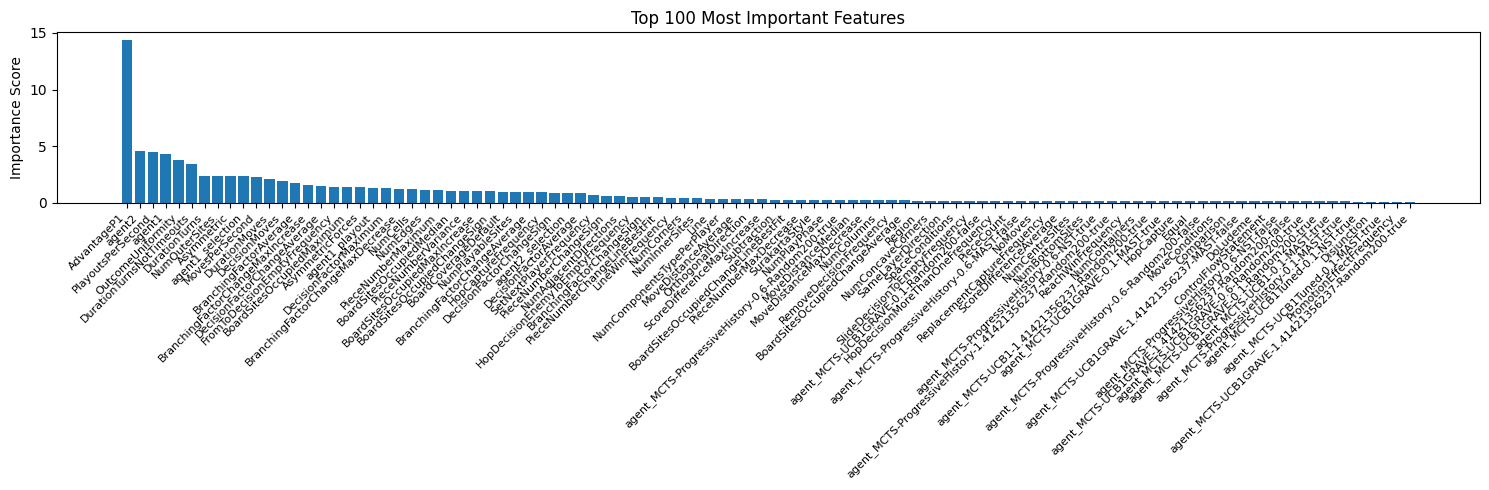

Fold 3 - RMSE: 0.4190606575518477
Fold 4


0:	learn: 0.6230795	test: 0.5970144	best: 0.5970144 (0)	total: 93.3ms	remaining: 15m 32s


50:	learn: 0.4879643	test: 0.5371600	best: 0.5371600 (50)	total: 4.34s	remaining: 14m 6s


100:	learn: 0.4434083	test: 0.5158152	best: 0.5158152 (100)	total: 8.64s	remaining: 14m 6s


150:	learn: 0.4187797	test: 0.5028495	best: 0.5028495 (150)	total: 13.1s	remaining: 14m 16s


200:	learn: 0.4030202	test: 0.4924311	best: 0.4924311 (200)	total: 18s	remaining: 14m 36s


250:	learn: 0.3911788	test: 0.4851485	best: 0.4851485 (250)	total: 22.8s	remaining: 14m 46s


300:	learn: 0.3827687	test: 0.4808669	best: 0.4808669 (300)	total: 27.8s	remaining: 14m 55s


350:	learn: 0.3748222	test: 0.4762348	best: 0.4762348 (350)	total: 32.8s	remaining: 15m 1s


400:	learn: 0.3672706	test: 0.4717981	best: 0.4717981 (400)	total: 37.5s	remaining: 14m 57s


450:	learn: 0.3606344	test: 0.4681298	best: 0.4681298 (450)	total: 42.1s	remaining: 14m 51s


500:	learn: 0.3546948	test: 0.4652626	best: 0.4652626 (500)	total: 46.8s	remaining: 14m 46s


550:	learn: 0.3493782	test: 0.4629243	best: 0.4629243 (550)	total: 51.4s	remaining: 14m 41s


600:	learn: 0.3446402	test: 0.4614796	best: 0.4614345 (598)	total: 56s	remaining: 14m 36s


650:	learn: 0.3404412	test: 0.4600362	best: 0.4600362 (650)	total: 1m	remaining: 14m 32s


700:	learn: 0.3367206	test: 0.4589756	best: 0.4589756 (700)	total: 1m 5s	remaining: 14m 27s


750:	learn: 0.3331303	test: 0.4579236	best: 0.4579236 (750)	total: 1m 10s	remaining: 14m 22s


800:	learn: 0.3295945	test: 0.4565459	best: 0.4565459 (800)	total: 1m 14s	remaining: 14m 16s


850:	learn: 0.3264259	test: 0.4556627	best: 0.4556627 (850)	total: 1m 19s	remaining: 14m 12s


900:	learn: 0.3235863	test: 0.4549491	best: 0.4549491 (900)	total: 1m 23s	remaining: 14m 8s


950:	learn: 0.3208877	test: 0.4542964	best: 0.4542964 (950)	total: 1m 28s	remaining: 14m 3s


1000:	learn: 0.3181235	test: 0.4536491	best: 0.4536362 (999)	total: 1m 33s	remaining: 13m 58s


1050:	learn: 0.3157270	test: 0.4529769	best: 0.4529769 (1050)	total: 1m 37s	remaining: 13m 53s


1100:	learn: 0.3134504	test: 0.4524124	best: 0.4524124 (1100)	total: 1m 42s	remaining: 13m 49s


1150:	learn: 0.3113874	test: 0.4520201	best: 0.4520201 (1150)	total: 1m 47s	remaining: 13m 45s


1200:	learn: 0.3091971	test: 0.4515939	best: 0.4515939 (1200)	total: 1m 52s	remaining: 13m 41s


1250:	learn: 0.3072242	test: 0.4511498	best: 0.4511498 (1250)	total: 1m 56s	remaining: 13m 37s


1300:	learn: 0.3052061	test: 0.4506642	best: 0.4506642 (1300)	total: 2m 1s	remaining: 13m 33s


1350:	learn: 0.3033339	test: 0.4501825	best: 0.4501825 (1350)	total: 2m 6s	remaining: 13m 28s


1400:	learn: 0.3015617	test: 0.4498507	best: 0.4498410 (1397)	total: 2m 11s	remaining: 13m 24s


1450:	learn: 0.3000819	test: 0.4494046	best: 0.4494046 (1450)	total: 2m 15s	remaining: 13m 20s


1500:	learn: 0.2984605	test: 0.4489875	best: 0.4489875 (1500)	total: 2m 20s	remaining: 13m 17s


1550:	learn: 0.2969428	test: 0.4487863	best: 0.4487863 (1550)	total: 2m 25s	remaining: 13m 13s


1600:	learn: 0.2955293	test: 0.4484954	best: 0.4484954 (1600)	total: 2m 30s	remaining: 13m 9s


1650:	learn: 0.2940370	test: 0.4480783	best: 0.4480783 (1650)	total: 2m 35s	remaining: 13m 5s


1700:	learn: 0.2927194	test: 0.4478267	best: 0.4478202 (1699)	total: 2m 40s	remaining: 13m 1s


1750:	learn: 0.2914365	test: 0.4476148	best: 0.4476148 (1750)	total: 2m 45s	remaining: 12m 57s


1800:	learn: 0.2900469	test: 0.4472298	best: 0.4472298 (1800)	total: 2m 50s	remaining: 12m 54s


1850:	learn: 0.2887190	test: 0.4470022	best: 0.4470022 (1850)	total: 2m 54s	remaining: 12m 49s


1900:	learn: 0.2874603	test: 0.4467718	best: 0.4467683 (1899)	total: 2m 59s	remaining: 12m 45s


1950:	learn: 0.2863307	test: 0.4465245	best: 0.4465245 (1950)	total: 3m 4s	remaining: 12m 42s


2000:	learn: 0.2849671	test: 0.4461729	best: 0.4461711 (1999)	total: 3m 9s	remaining: 12m 37s


2050:	learn: 0.2837507	test: 0.4458881	best: 0.4458881 (2050)	total: 3m 14s	remaining: 12m 33s


2100:	learn: 0.2825697	test: 0.4457257	best: 0.4457257 (2100)	total: 3m 19s	remaining: 12m 29s


2150:	learn: 0.2814479	test: 0.4454827	best: 0.4454827 (2150)	total: 3m 24s	remaining: 12m 25s


2200:	learn: 0.2803418	test: 0.4452088	best: 0.4452088 (2200)	total: 3m 29s	remaining: 12m 20s


2250:	learn: 0.2792302	test: 0.4449957	best: 0.4449957 (2250)	total: 3m 33s	remaining: 12m 16s


2300:	learn: 0.2782420	test: 0.4448586	best: 0.4448516 (2293)	total: 3m 38s	remaining: 12m 12s


2350:	learn: 0.2772431	test: 0.4446627	best: 0.4446534 (2348)	total: 3m 43s	remaining: 12m 8s


2400:	learn: 0.2762120	test: 0.4445633	best: 0.4445182 (2374)	total: 3m 48s	remaining: 12m 3s


2450:	learn: 0.2750835	test: 0.4444413	best: 0.4444413 (2450)	total: 3m 53s	remaining: 11m 59s


2500:	learn: 0.2742086	test: 0.4442236	best: 0.4442236 (2500)	total: 3m 58s	remaining: 11m 54s


2550:	learn: 0.2732318	test: 0.4440688	best: 0.4440688 (2550)	total: 4m 3s	remaining: 11m 50s


2600:	learn: 0.2722821	test: 0.4438904	best: 0.4438899 (2598)	total: 4m 8s	remaining: 11m 46s


2650:	learn: 0.2713481	test: 0.4437338	best: 0.4437319 (2649)	total: 4m 13s	remaining: 11m 42s


2700:	learn: 0.2704795	test: 0.4436221	best: 0.4436221 (2700)	total: 4m 18s	remaining: 11m 37s


2750:	learn: 0.2696258	test: 0.4434632	best: 0.4434632 (2750)	total: 4m 23s	remaining: 11m 33s


2800:	learn: 0.2688039	test: 0.4433089	best: 0.4433039 (2799)	total: 4m 28s	remaining: 11m 28s


2850:	learn: 0.2679092	test: 0.4431748	best: 0.4431748 (2850)	total: 4m 32s	remaining: 11m 24s


2900:	learn: 0.2670011	test: 0.4430044	best: 0.4430044 (2900)	total: 4m 37s	remaining: 11m 19s


2950:	learn: 0.2661638	test: 0.4428590	best: 0.4428590 (2950)	total: 4m 42s	remaining: 11m 15s


3000:	learn: 0.2653361	test: 0.4427199	best: 0.4427199 (3000)	total: 4m 47s	remaining: 11m 10s


3050:	learn: 0.2644790	test: 0.4425564	best: 0.4425529 (3049)	total: 4m 52s	remaining: 11m 6s


3100:	learn: 0.2637111	test: 0.4423742	best: 0.4423712 (3098)	total: 4m 57s	remaining: 11m 1s


3150:	learn: 0.2628364	test: 0.4422362	best: 0.4422362 (3150)	total: 5m 2s	remaining: 10m 56s


3200:	learn: 0.2620432	test: 0.4421448	best: 0.4421416 (3199)	total: 5m 7s	remaining: 10m 52s


3250:	learn: 0.2612996	test: 0.4420091	best: 0.4420063 (3248)	total: 5m 12s	remaining: 10m 47s


3300:	learn: 0.2605779	test: 0.4419258	best: 0.4419258 (3300)	total: 5m 17s	remaining: 10m 43s


3350:	learn: 0.2598592	test: 0.4418634	best: 0.4418634 (3350)	total: 5m 22s	remaining: 10m 38s


3400:	learn: 0.2590991	test: 0.4417341	best: 0.4417341 (3400)	total: 5m 26s	remaining: 10m 34s


3450:	learn: 0.2583809	test: 0.4416267	best: 0.4416267 (3450)	total: 5m 31s	remaining: 10m 29s


3500:	learn: 0.2577044	test: 0.4414761	best: 0.4414761 (3500)	total: 5m 36s	remaining: 10m 25s


3550:	learn: 0.2569953	test: 0.4413701	best: 0.4413686 (3549)	total: 5m 41s	remaining: 10m 20s


3600:	learn: 0.2563487	test: 0.4412565	best: 0.4412531 (3598)	total: 5m 47s	remaining: 10m 16s


3650:	learn: 0.2556371	test: 0.4411324	best: 0.4411324 (3650)	total: 5m 51s	remaining: 10m 12s


3700:	learn: 0.2549889	test: 0.4409963	best: 0.4409888 (3699)	total: 5m 56s	remaining: 10m 7s


3750:	learn: 0.2543055	test: 0.4409689	best: 0.4409566 (3729)	total: 6m 1s	remaining: 10m 2s


3800:	learn: 0.2536938	test: 0.4408921	best: 0.4408902 (3798)	total: 6m 6s	remaining: 9m 58s


3850:	learn: 0.2530387	test: 0.4408523	best: 0.4408447 (3847)	total: 6m 11s	remaining: 9m 53s


3900:	learn: 0.2523961	test: 0.4407289	best: 0.4407289 (3900)	total: 6m 16s	remaining: 9m 49s


3950:	learn: 0.2518198	test: 0.4406493	best: 0.4406426 (3948)	total: 6m 21s	remaining: 9m 44s


4000:	learn: 0.2511722	test: 0.4405377	best: 0.4405377 (4000)	total: 6m 26s	remaining: 9m 39s


4050:	learn: 0.2505456	test: 0.4404360	best: 0.4404345 (4047)	total: 6m 31s	remaining: 9m 35s


4100:	learn: 0.2499174	test: 0.4403746	best: 0.4403670 (4095)	total: 6m 36s	remaining: 9m 30s


4150:	learn: 0.2493140	test: 0.4403266	best: 0.4403221 (4140)	total: 6m 41s	remaining: 9m 25s


4200:	learn: 0.2487340	test: 0.4402482	best: 0.4402374 (4196)	total: 6m 46s	remaining: 9m 21s


4250:	learn: 0.2481703	test: 0.4401978	best: 0.4401919 (4245)	total: 6m 51s	remaining: 9m 16s


4300:	learn: 0.2475733	test: 0.4401670	best: 0.4401473 (4285)	total: 6m 56s	remaining: 9m 11s


4350:	learn: 0.2470166	test: 0.4401527	best: 0.4401472 (4343)	total: 7m 1s	remaining: 9m 6s


4400:	learn: 0.2464487	test: 0.4400998	best: 0.4400964 (4397)	total: 7m 6s	remaining: 9m 2s


4450:	learn: 0.2458751	test: 0.4400038	best: 0.4399953 (4442)	total: 7m 11s	remaining: 8m 57s


4500:	learn: 0.2453257	test: 0.4399675	best: 0.4399673 (4499)	total: 7m 16s	remaining: 8m 52s


4550:	learn: 0.2447884	test: 0.4399074	best: 0.4399019 (4547)	total: 7m 21s	remaining: 8m 48s


4600:	learn: 0.2442614	test: 0.4398853	best: 0.4398819 (4581)	total: 7m 26s	remaining: 8m 43s


4650:	learn: 0.2437119	test: 0.4398254	best: 0.4398254 (4650)	total: 7m 31s	remaining: 8m 38s


4700:	learn: 0.2432066	test: 0.4398005	best: 0.4397980 (4699)	total: 7m 36s	remaining: 8m 34s


4750:	learn: 0.2426814	test: 0.4397295	best: 0.4397292 (4749)	total: 7m 41s	remaining: 8m 29s


4800:	learn: 0.2421464	test: 0.4396536	best: 0.4396536 (4800)	total: 7m 46s	remaining: 8m 24s


4850:	learn: 0.2416119	test: 0.4396159	best: 0.4396109 (4826)	total: 7m 51s	remaining: 8m 20s


4900:	learn: 0.2410874	test: 0.4395561	best: 0.4395558 (4899)	total: 7m 56s	remaining: 8m 15s


4950:	learn: 0.2405843	test: 0.4395075	best: 0.4395066 (4949)	total: 8m 1s	remaining: 8m 10s


5000:	learn: 0.2400778	test: 0.4394914	best: 0.4394826 (4992)	total: 8m 6s	remaining: 8m 5s


5050:	learn: 0.2395841	test: 0.4394265	best: 0.4394265 (5050)	total: 8m 10s	remaining: 8m 1s


5100:	learn: 0.2390525	test: 0.4393679	best: 0.4393661 (5099)	total: 8m 15s	remaining: 7m 56s


5150:	learn: 0.2385534	test: 0.4393263	best: 0.4393263 (5150)	total: 8m 20s	remaining: 7m 51s


5200:	learn: 0.2380703	test: 0.4392734	best: 0.4392734 (5200)	total: 8m 25s	remaining: 7m 46s


5250:	learn: 0.2376125	test: 0.4392358	best: 0.4392349 (5248)	total: 8m 31s	remaining: 7m 42s


5300:	learn: 0.2370875	test: 0.4391963	best: 0.4391963 (5300)	total: 8m 35s	remaining: 7m 37s


5350:	learn: 0.2366160	test: 0.4391317	best: 0.4391309 (5345)	total: 8m 40s	remaining: 7m 32s


5400:	learn: 0.2361414	test: 0.4390957	best: 0.4390907 (5392)	total: 8m 45s	remaining: 7m 27s


5450:	learn: 0.2356954	test: 0.4390749	best: 0.4390749 (5450)	total: 8m 51s	remaining: 7m 23s


5500:	learn: 0.2352558	test: 0.4389948	best: 0.4389948 (5500)	total: 8m 56s	remaining: 7m 18s


5550:	learn: 0.2348211	test: 0.4389627	best: 0.4389586 (5544)	total: 9m 1s	remaining: 7m 13s


5600:	learn: 0.2343842	test: 0.4389249	best: 0.4389249 (5600)	total: 9m 6s	remaining: 7m 8s


5650:	learn: 0.2339717	test: 0.4388935	best: 0.4388891 (5641)	total: 9m 11s	remaining: 7m 4s


5700:	learn: 0.2335164	test: 0.4388481	best: 0.4388452 (5694)	total: 9m 16s	remaining: 6m 59s


5750:	learn: 0.2330800	test: 0.4388237	best: 0.4388147 (5736)	total: 9m 21s	remaining: 6m 54s


5800:	learn: 0.2325897	test: 0.4387500	best: 0.4387500 (5800)	total: 9m 25s	remaining: 6m 49s


5850:	learn: 0.2321620	test: 0.4387347	best: 0.4387281 (5814)	total: 9m 30s	remaining: 6m 44s


5900:	learn: 0.2317208	test: 0.4387060	best: 0.4387060 (5900)	total: 9m 35s	remaining: 6m 40s


5950:	learn: 0.2312504	test: 0.4386581	best: 0.4386581 (5950)	total: 9m 40s	remaining: 6m 35s


6000:	learn: 0.2308101	test: 0.4386245	best: 0.4386245 (6000)	total: 9m 45s	remaining: 6m 30s


6050:	learn: 0.2303955	test: 0.4385852	best: 0.4385815 (6042)	total: 9m 50s	remaining: 6m 25s


6100:	learn: 0.2299543	test: 0.4385402	best: 0.4385402 (6100)	total: 9m 55s	remaining: 6m 20s


6150:	learn: 0.2295437	test: 0.4385015	best: 0.4385001 (6148)	total: 10m	remaining: 6m 15s


6200:	learn: 0.2291253	test: 0.4384524	best: 0.4384524 (6200)	total: 10m 5s	remaining: 6m 11s


6250:	learn: 0.2286885	test: 0.4384257	best: 0.4384257 (6250)	total: 10m 10s	remaining: 6m 6s


6300:	learn: 0.2282747	test: 0.4383946	best: 0.4383939 (6297)	total: 10m 15s	remaining: 6m 1s


6350:	learn: 0.2278502	test: 0.4383562	best: 0.4383553 (6349)	total: 10m 20s	remaining: 5m 56s


6400:	learn: 0.2274158	test: 0.4383040	best: 0.4383017 (6399)	total: 10m 25s	remaining: 5m 51s


6450:	learn: 0.2270271	test: 0.4382737	best: 0.4382737 (6450)	total: 10m 30s	remaining: 5m 47s


6500:	learn: 0.2266129	test: 0.4382437	best: 0.4382431 (6493)	total: 10m 35s	remaining: 5m 42s


6550:	learn: 0.2262187	test: 0.4382273	best: 0.4382266 (6549)	total: 10m 41s	remaining: 5m 37s


6600:	learn: 0.2258340	test: 0.4381991	best: 0.4381973 (6599)	total: 10m 46s	remaining: 5m 32s


6650:	learn: 0.2254246	test: 0.4381819	best: 0.4381802 (6645)	total: 10m 50s	remaining: 5m 27s


6700:	learn: 0.2250106	test: 0.4381700	best: 0.4381635 (6671)	total: 10m 56s	remaining: 5m 22s


6750:	learn: 0.2246236	test: 0.4381423	best: 0.4381382 (6740)	total: 11m 1s	remaining: 5m 18s


6800:	learn: 0.2242196	test: 0.4381076	best: 0.4381076 (6800)	total: 11m 6s	remaining: 5m 13s


6850:	learn: 0.2237819	test: 0.4380869	best: 0.4380869 (6850)	total: 11m 10s	remaining: 5m 8s


6900:	learn: 0.2234145	test: 0.4380788	best: 0.4380665 (6881)	total: 11m 15s	remaining: 5m 3s


6950:	learn: 0.2230112	test: 0.4380518	best: 0.4380506 (6944)	total: 11m 20s	remaining: 4m 58s


7000:	learn: 0.2226306	test: 0.4380111	best: 0.4380111 (7000)	total: 11m 25s	remaining: 4m 53s


7050:	learn: 0.2222456	test: 0.4379840	best: 0.4379840 (7050)	total: 11m 30s	remaining: 4m 48s


7100:	learn: 0.2218820	test: 0.4379476	best: 0.4379448 (7097)	total: 11m 35s	remaining: 4m 44s


7150:	learn: 0.2214860	test: 0.4379325	best: 0.4379312 (7144)	total: 11m 40s	remaining: 4m 39s


7200:	learn: 0.2210949	test: 0.4379175	best: 0.4379078 (7191)	total: 11m 45s	remaining: 4m 34s


7250:	learn: 0.2207406	test: 0.4379036	best: 0.4379034 (7248)	total: 11m 50s	remaining: 4m 29s


7300:	learn: 0.2203812	test: 0.4378829	best: 0.4378806 (7298)	total: 11m 55s	remaining: 4m 24s


7350:	learn: 0.2200501	test: 0.4378755	best: 0.4378731 (7340)	total: 12m	remaining: 4m 19s


7400:	learn: 0.2197096	test: 0.4378568	best: 0.4378566 (7394)	total: 12m 5s	remaining: 4m 14s


7450:	learn: 0.2193347	test: 0.4377988	best: 0.4377988 (7450)	total: 12m 10s	remaining: 4m 10s


7500:	learn: 0.2189765	test: 0.4377847	best: 0.4377813 (7494)	total: 12m 15s	remaining: 4m 5s


7550:	learn: 0.2186529	test: 0.4377390	best: 0.4377390 (7550)	total: 12m 20s	remaining: 4m


7600:	learn: 0.2183070	test: 0.4377096	best: 0.4377096 (7600)	total: 12m 25s	remaining: 3m 55s


7650:	learn: 0.2179460	test: 0.4376795	best: 0.4376789 (7646)	total: 12m 30s	remaining: 3m 50s


7700:	learn: 0.2176020	test: 0.4376617	best: 0.4376617 (7700)	total: 12m 35s	remaining: 3m 45s


7750:	learn: 0.2172707	test: 0.4376458	best: 0.4376458 (7750)	total: 12m 40s	remaining: 3m 40s


7800:	learn: 0.2169165	test: 0.4376243	best: 0.4376243 (7800)	total: 12m 45s	remaining: 3m 35s


7850:	learn: 0.2165866	test: 0.4375922	best: 0.4375922 (7850)	total: 12m 50s	remaining: 3m 30s


7900:	learn: 0.2162643	test: 0.4375753	best: 0.4375725 (7896)	total: 12m 55s	remaining: 3m 26s


7950:	learn: 0.2159248	test: 0.4375571	best: 0.4375571 (7950)	total: 13m	remaining: 3m 21s


8000:	learn: 0.2156001	test: 0.4375283	best: 0.4375242 (7994)	total: 13m 5s	remaining: 3m 16s


8050:	learn: 0.2152395	test: 0.4375120	best: 0.4375104 (8048)	total: 13m 10s	remaining: 3m 11s


8100:	learn: 0.2149343	test: 0.4374892	best: 0.4374892 (8100)	total: 13m 15s	remaining: 3m 6s


8150:	learn: 0.2145749	test: 0.4374607	best: 0.4374592 (8149)	total: 13m 20s	remaining: 3m 1s


8200:	learn: 0.2142478	test: 0.4374069	best: 0.4374069 (8200)	total: 13m 25s	remaining: 2m 56s


8250:	learn: 0.2139159	test: 0.4373930	best: 0.4373913 (8249)	total: 13m 30s	remaining: 2m 51s


8300:	learn: 0.2135720	test: 0.4373565	best: 0.4373565 (8300)	total: 13m 35s	remaining: 2m 46s


8350:	learn: 0.2132486	test: 0.4373221	best: 0.4373215 (8349)	total: 13m 40s	remaining: 2m 42s


8400:	learn: 0.2129099	test: 0.4373053	best: 0.4373053 (8400)	total: 13m 45s	remaining: 2m 37s


8450:	learn: 0.2125995	test: 0.4373060	best: 0.4372894 (8416)	total: 13m 50s	remaining: 2m 32s


8500:	learn: 0.2122371	test: 0.4372933	best: 0.4372876 (8485)	total: 13m 55s	remaining: 2m 27s


8550:	learn: 0.2119237	test: 0.4372720	best: 0.4372708 (8548)	total: 14m	remaining: 2m 22s


8600:	learn: 0.2115796	test: 0.4372597	best: 0.4372546 (8583)	total: 14m 5s	remaining: 2m 17s


8650:	learn: 0.2112319	test: 0.4372455	best: 0.4372439 (8630)	total: 14m 10s	remaining: 2m 12s


8700:	learn: 0.2109257	test: 0.4372211	best: 0.4372211 (8700)	total: 14m 15s	remaining: 2m 7s


8750:	learn: 0.2106312	test: 0.4372102	best: 0.4372046 (8738)	total: 14m 21s	remaining: 2m 2s


8800:	learn: 0.2102949	test: 0.4371757	best: 0.4371719 (8791)	total: 14m 26s	remaining: 1m 57s


8850:	learn: 0.2099805	test: 0.4371475	best: 0.4371475 (8850)	total: 14m 31s	remaining: 1m 53s


8900:	learn: 0.2096452	test: 0.4371514	best: 0.4371347 (8876)	total: 14m 36s	remaining: 1m 48s


8950:	learn: 0.2093380	test: 0.4371593	best: 0.4371347 (8876)	total: 14m 41s	remaining: 1m 43s


9000:	learn: 0.2090246	test: 0.4371246	best: 0.4371246 (9000)	total: 14m 46s	remaining: 1m 38s


9050:	learn: 0.2087288	test: 0.4371123	best: 0.4371123 (9050)	total: 14m 51s	remaining: 1m 33s


9100:	learn: 0.2084258	test: 0.4371084	best: 0.4371047 (9094)	total: 14m 56s	remaining: 1m 28s


9150:	learn: 0.2081253	test: 0.4370995	best: 0.4370956 (9124)	total: 15m 1s	remaining: 1m 23s


9200:	learn: 0.2078290	test: 0.4370904	best: 0.4370898 (9197)	total: 15m 6s	remaining: 1m 18s


9250:	learn: 0.2075354	test: 0.4370727	best: 0.4370675 (9240)	total: 15m 11s	remaining: 1m 13s


9300:	learn: 0.2072284	test: 0.4370553	best: 0.4370501 (9279)	total: 15m 16s	remaining: 1m 8s


9350:	learn: 0.2069469	test: 0.4370379	best: 0.4370347 (9344)	total: 15m 21s	remaining: 1m 3s


9400:	learn: 0.2066617	test: 0.4370284	best: 0.4370250 (9395)	total: 15m 26s	remaining: 59s


9450:	learn: 0.2063641	test: 0.4369996	best: 0.4369996 (9450)	total: 15m 31s	remaining: 54.1s


9500:	learn: 0.2061080	test: 0.4370046	best: 0.4369989 (9452)	total: 15m 36s	remaining: 49.2s


9550:	learn: 0.2058364	test: 0.4369816	best: 0.4369803 (9549)	total: 15m 41s	remaining: 44.3s


9600:	learn: 0.2055480	test: 0.4369707	best: 0.4369703 (9590)	total: 15m 46s	remaining: 39.3s


9650:	learn: 0.2052415	test: 0.4369609	best: 0.4369609 (9650)	total: 15m 51s	remaining: 34.4s


9700:	learn: 0.2049427	test: 0.4369643	best: 0.4369597 (9678)	total: 15m 56s	remaining: 29.5s


9750:	learn: 0.2046583	test: 0.4369487	best: 0.4369461 (9749)	total: 16m 1s	remaining: 24.6s


9800:	learn: 0.2043640	test: 0.4369408	best: 0.4369352 (9787)	total: 16m 6s	remaining: 19.6s


9850:	learn: 0.2040688	test: 0.4369340	best: 0.4369340 (9850)	total: 16m 11s	remaining: 14.7s


9900:	learn: 0.2037834	test: 0.4369206	best: 0.4369205 (9895)	total: 16m 16s	remaining: 9.77s


9950:	learn: 0.2035173	test: 0.4369081	best: 0.4369081 (9950)	total: 16m 21s	remaining: 4.83s


9999:	learn: 0.2032734	test: 0.4368805	best: 0.4368805 (9999)	total: 16m 26s	remaining: 0us

bestTest = 0.436880529
bestIteration = 9999



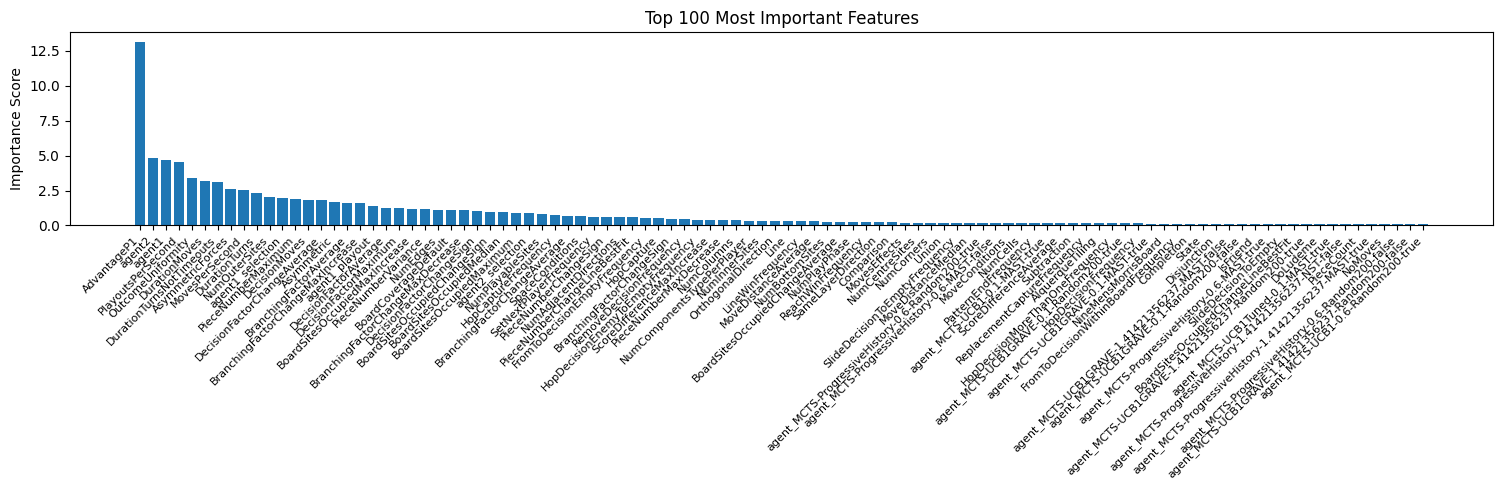

Fold 4 - RMSE: 0.43631806153404457
Fold 5


0:	learn: 0.6347297	test: 0.5480537	best: 0.5480537 (0)	total: 81.7ms	remaining: 13m 37s


50:	learn: 0.4981412	test: 0.5059310	best: 0.5059310 (50)	total: 4.27s	remaining: 13m 52s


100:	learn: 0.4524376	test: 0.4842279	best: 0.4842279 (100)	total: 8.49s	remaining: 13m 52s


150:	learn: 0.4271172	test: 0.4665596	best: 0.4665596 (150)	total: 12.8s	remaining: 13m 54s


200:	learn: 0.4114702	test: 0.4551519	best: 0.4551519 (200)	total: 17.5s	remaining: 14m 13s


250:	learn: 0.3992710	test: 0.4481522	best: 0.4481522 (250)	total: 22.3s	remaining: 14m 25s


300:	learn: 0.3895781	test: 0.4422983	best: 0.4422983 (300)	total: 27.2s	remaining: 14m 37s


350:	learn: 0.3818179	test: 0.4383779	best: 0.4383779 (350)	total: 32s	remaining: 14m 39s


400:	learn: 0.3749139	test: 0.4349684	best: 0.4349684 (400)	total: 36.8s	remaining: 14m 40s


450:	learn: 0.3676467	test: 0.4306805	best: 0.4306805 (450)	total: 41.4s	remaining: 14m 36s


500:	learn: 0.3622368	test: 0.4281171	best: 0.4281118 (499)	total: 46.1s	remaining: 14m 33s


550:	learn: 0.3574764	test: 0.4260862	best: 0.4260848 (549)	total: 50.6s	remaining: 14m 28s


600:	learn: 0.3527301	test: 0.4241642	best: 0.4241642 (600)	total: 55.3s	remaining: 14m 24s


650:	learn: 0.3485176	test: 0.4225646	best: 0.4225646 (650)	total: 60s	remaining: 14m 21s


700:	learn: 0.3450765	test: 0.4215328	best: 0.4215328 (700)	total: 1m 4s	remaining: 14m 19s


750:	learn: 0.3417522	test: 0.4203220	best: 0.4203220 (750)	total: 1m 9s	remaining: 14m 15s


800:	learn: 0.3384820	test: 0.4193513	best: 0.4193513 (800)	total: 1m 14s	remaining: 14m 11s


850:	learn: 0.3356856	test: 0.4185874	best: 0.4185874 (850)	total: 1m 18s	remaining: 14m 8s


900:	learn: 0.3330681	test: 0.4179085	best: 0.4179085 (900)	total: 1m 23s	remaining: 14m 4s


950:	learn: 0.3304907	test: 0.4171853	best: 0.4171853 (950)	total: 1m 28s	remaining: 14m 1s


1000:	learn: 0.3281428	test: 0.4164704	best: 0.4164704 (999)	total: 1m 33s	remaining: 13m 57s


1050:	learn: 0.3258639	test: 0.4159620	best: 0.4159620 (1050)	total: 1m 38s	remaining: 13m 54s


1100:	learn: 0.3236211	test: 0.4153463	best: 0.4153463 (1100)	total: 1m 42s	remaining: 13m 49s


1150:	learn: 0.3214277	test: 0.4146474	best: 0.4146474 (1150)	total: 1m 47s	remaining: 13m 46s


1200:	learn: 0.3194432	test: 0.4142204	best: 0.4142204 (1200)	total: 1m 52s	remaining: 13m 43s


1250:	learn: 0.3173599	test: 0.4136373	best: 0.4136373 (1250)	total: 1m 57s	remaining: 13m 39s


1300:	learn: 0.3151046	test: 0.4130424	best: 0.4130424 (1300)	total: 2m 1s	remaining: 13m 35s


1350:	learn: 0.3131526	test: 0.4125605	best: 0.4125605 (1350)	total: 2m 6s	remaining: 13m 30s


1400:	learn: 0.3112783	test: 0.4121035	best: 0.4121035 (1400)	total: 2m 11s	remaining: 13m 26s


1450:	learn: 0.3095392	test: 0.4116290	best: 0.4116290 (1450)	total: 2m 16s	remaining: 13m 23s


1500:	learn: 0.3077927	test: 0.4111746	best: 0.4111746 (1500)	total: 2m 21s	remaining: 13m 18s


1550:	learn: 0.3059652	test: 0.4107069	best: 0.4107069 (1550)	total: 2m 25s	remaining: 13m 14s


1600:	learn: 0.3042224	test: 0.4103383	best: 0.4103288 (1599)	total: 2m 30s	remaining: 13m 9s


1650:	learn: 0.3025976	test: 0.4099281	best: 0.4099078 (1649)	total: 2m 35s	remaining: 13m 5s


1700:	learn: 0.3011608	test: 0.4096014	best: 0.4096014 (1700)	total: 2m 40s	remaining: 13m


1750:	learn: 0.2996842	test: 0.4091796	best: 0.4091796 (1750)	total: 2m 44s	remaining: 12m 56s


1800:	learn: 0.2981002	test: 0.4087527	best: 0.4087527 (1800)	total: 2m 49s	remaining: 12m 52s


1850:	learn: 0.2965425	test: 0.4083827	best: 0.4083827 (1850)	total: 2m 54s	remaining: 12m 47s


1900:	learn: 0.2952926	test: 0.4083343	best: 0.4082732 (1881)	total: 2m 59s	remaining: 12m 43s


1950:	learn: 0.2939036	test: 0.4080106	best: 0.4080106 (1950)	total: 3m 3s	remaining: 12m 39s


2000:	learn: 0.2925096	test: 0.4076079	best: 0.4076063 (1998)	total: 3m 8s	remaining: 12m 34s


2050:	learn: 0.2911798	test: 0.4072894	best: 0.4072878 (2049)	total: 3m 13s	remaining: 12m 30s


2100:	learn: 0.2899462	test: 0.4070427	best: 0.4070427 (2100)	total: 3m 18s	remaining: 12m 26s


2150:	learn: 0.2886981	test: 0.4068749	best: 0.4068749 (2150)	total: 3m 23s	remaining: 12m 21s


2200:	learn: 0.2875446	test: 0.4067020	best: 0.4067020 (2200)	total: 3m 28s	remaining: 12m 17s


2250:	learn: 0.2863628	test: 0.4064238	best: 0.4064238 (2250)	total: 3m 32s	remaining: 12m 12s


2300:	learn: 0.2853242	test: 0.4062382	best: 0.4062289 (2294)	total: 3m 37s	remaining: 12m 8s


2350:	learn: 0.2842684	test: 0.4060557	best: 0.4060557 (2350)	total: 3m 42s	remaining: 12m 4s


2400:	learn: 0.2831314	test: 0.4058878	best: 0.4058878 (2400)	total: 3m 47s	remaining: 11m 59s


2450:	learn: 0.2821462	test: 0.4056923	best: 0.4056923 (2450)	total: 3m 52s	remaining: 11m 55s


2500:	learn: 0.2811802	test: 0.4054965	best: 0.4054668 (2494)	total: 3m 57s	remaining: 11m 51s


2550:	learn: 0.2801325	test: 0.4052722	best: 0.4052722 (2550)	total: 4m 2s	remaining: 11m 46s


2600:	learn: 0.2791726	test: 0.4051442	best: 0.4051442 (2600)	total: 4m 7s	remaining: 11m 42s


2650:	learn: 0.2782128	test: 0.4049563	best: 0.4049563 (2650)	total: 4m 11s	remaining: 11m 38s


2700:	learn: 0.2773125	test: 0.4047749	best: 0.4047749 (2700)	total: 4m 16s	remaining: 11m 33s


2750:	learn: 0.2762810	test: 0.4045352	best: 0.4045325 (2749)	total: 4m 21s	remaining: 11m 29s


2800:	learn: 0.2753942	test: 0.4044049	best: 0.4043847 (2791)	total: 4m 26s	remaining: 11m 25s


2850:	learn: 0.2744921	test: 0.4042779	best: 0.4042779 (2850)	total: 4m 31s	remaining: 11m 20s


2900:	learn: 0.2736287	test: 0.4042019	best: 0.4042010 (2899)	total: 4m 36s	remaining: 11m 15s


2950:	learn: 0.2727700	test: 0.4040538	best: 0.4040493 (2943)	total: 4m 41s	remaining: 11m 11s


3000:	learn: 0.2719638	test: 0.4039034	best: 0.4039034 (3000)	total: 4m 45s	remaining: 11m 6s


3050:	learn: 0.2711565	test: 0.4037850	best: 0.4037819 (3047)	total: 4m 50s	remaining: 11m 2s


3100:	learn: 0.2703606	test: 0.4036033	best: 0.4036033 (3100)	total: 4m 55s	remaining: 10m 57s


3150:	learn: 0.2695956	test: 0.4035271	best: 0.4035271 (3150)	total: 5m	remaining: 10m 53s


3200:	learn: 0.2688717	test: 0.4034227	best: 0.4034173 (3190)	total: 5m 5s	remaining: 10m 49s


3250:	learn: 0.2681158	test: 0.4033201	best: 0.4033201 (3250)	total: 5m 10s	remaining: 10m 44s


3300:	learn: 0.2673218	test: 0.4031779	best: 0.4031716 (3299)	total: 5m 15s	remaining: 10m 40s


3350:	learn: 0.2665779	test: 0.4031059	best: 0.4030896 (3327)	total: 5m 20s	remaining: 10m 35s


3400:	learn: 0.2658961	test: 0.4030401	best: 0.4030367 (3398)	total: 5m 25s	remaining: 10m 31s


3450:	learn: 0.2652273	test: 0.4029732	best: 0.4029725 (3449)	total: 5m 30s	remaining: 10m 26s


3500:	learn: 0.2644917	test: 0.4028677	best: 0.4028677 (3500)	total: 5m 35s	remaining: 10m 22s


3550:	learn: 0.2638451	test: 0.4027259	best: 0.4027207 (3549)	total: 5m 40s	remaining: 10m 18s


3600:	learn: 0.2631349	test: 0.4025741	best: 0.4025676 (3598)	total: 5m 45s	remaining: 10m 13s


3650:	learn: 0.2624163	test: 0.4024583	best: 0.4024580 (3649)	total: 5m 49s	remaining: 10m 8s


3700:	learn: 0.2617889	test: 0.4024032	best: 0.4024032 (3700)	total: 5m 54s	remaining: 10m 4s


3750:	learn: 0.2611590	test: 0.4023393	best: 0.4023393 (3750)	total: 5m 59s	remaining: 9m 59s


3800:	learn: 0.2604239	test: 0.4022468	best: 0.4022329 (3788)	total: 6m 4s	remaining: 9m 54s


3850:	learn: 0.2597643	test: 0.4021156	best: 0.4021031 (3848)	total: 6m 9s	remaining: 9m 50s


3900:	learn: 0.2590699	test: 0.4020429	best: 0.4020429 (3900)	total: 6m 14s	remaining: 9m 45s


3950:	learn: 0.2584668	test: 0.4019675	best: 0.4019675 (3950)	total: 6m 19s	remaining: 9m 41s


4000:	learn: 0.2578349	test: 0.4019244	best: 0.4019194 (3991)	total: 6m 24s	remaining: 9m 36s


4050:	learn: 0.2571830	test: 0.4018868	best: 0.4018791 (4049)	total: 6m 29s	remaining: 9m 31s


4100:	learn: 0.2565675	test: 0.4017842	best: 0.4017838 (4098)	total: 6m 34s	remaining: 9m 27s


4150:	learn: 0.2559198	test: 0.4016796	best: 0.4016773 (4149)	total: 6m 39s	remaining: 9m 22s


4200:	learn: 0.2552723	test: 0.4015997	best: 0.4015995 (4186)	total: 6m 44s	remaining: 9m 17s


4250:	learn: 0.2546363	test: 0.4015252	best: 0.4015138 (4245)	total: 6m 49s	remaining: 9m 13s


4300:	learn: 0.2540431	test: 0.4014900	best: 0.4014808 (4284)	total: 6m 53s	remaining: 9m 8s


4350:	learn: 0.2533952	test: 0.4014343	best: 0.4014343 (4350)	total: 6m 58s	remaining: 9m 3s


4400:	learn: 0.2527534	test: 0.4013056	best: 0.4013056 (4400)	total: 7m 3s	remaining: 8m 59s


4450:	learn: 0.2521356	test: 0.4012230	best: 0.4012230 (4450)	total: 7m 8s	remaining: 8m 54s


4500:	learn: 0.2515455	test: 0.4011923	best: 0.4011923 (4500)	total: 7m 13s	remaining: 8m 49s


4550:	learn: 0.2509343	test: 0.4011478	best: 0.4011396 (4546)	total: 7m 18s	remaining: 8m 45s


4600:	learn: 0.2503472	test: 0.4011275	best: 0.4011271 (4595)	total: 7m 23s	remaining: 8m 40s


4650:	learn: 0.2498024	test: 0.4010868	best: 0.4010852 (4645)	total: 7m 28s	remaining: 8m 35s


4700:	learn: 0.2492570	test: 0.4009781	best: 0.4009781 (4700)	total: 7m 33s	remaining: 8m 31s


4750:	learn: 0.2487249	test: 0.4009037	best: 0.4009014 (4743)	total: 7m 38s	remaining: 8m 26s


4800:	learn: 0.2481926	test: 0.4008380	best: 0.4008380 (4800)	total: 7m 43s	remaining: 8m 21s


4850:	learn: 0.2476500	test: 0.4007893	best: 0.4007893 (4850)	total: 7m 48s	remaining: 8m 17s


4900:	learn: 0.2471110	test: 0.4007310	best: 0.4007307 (4899)	total: 7m 53s	remaining: 8m 12s


4950:	learn: 0.2466063	test: 0.4006774	best: 0.4006760 (4949)	total: 7m 58s	remaining: 8m 7s


5000:	learn: 0.2460706	test: 0.4006191	best: 0.4005915 (4992)	total: 8m 3s	remaining: 8m 2s


5050:	learn: 0.2455665	test: 0.4005669	best: 0.4005669 (5050)	total: 8m 8s	remaining: 7m 58s


5100:	learn: 0.2450451	test: 0.4005465	best: 0.4005280 (5092)	total: 8m 13s	remaining: 7m 53s


5150:	learn: 0.2444971	test: 0.4004826	best: 0.4004760 (5138)	total: 8m 17s	remaining: 7m 48s


5200:	learn: 0.2439698	test: 0.4003905	best: 0.4003853 (5198)	total: 8m 22s	remaining: 7m 43s


5250:	learn: 0.2434358	test: 0.4003475	best: 0.4003475 (5250)	total: 8m 27s	remaining: 7m 39s


5300:	learn: 0.2429357	test: 0.4002947	best: 0.4002947 (5300)	total: 8m 32s	remaining: 7m 34s


5350:	learn: 0.2424541	test: 0.4002286	best: 0.4002273 (5347)	total: 8m 37s	remaining: 7m 29s


5400:	learn: 0.2419606	test: 0.4001997	best: 0.4001981 (5398)	total: 8m 42s	remaining: 7m 24s


5450:	learn: 0.2414667	test: 0.4001810	best: 0.4001722 (5414)	total: 8m 47s	remaining: 7m 20s


5500:	learn: 0.2409634	test: 0.4001414	best: 0.4001398 (5499)	total: 8m 52s	remaining: 7m 15s


5550:	learn: 0.2404831	test: 0.4000766	best: 0.4000694 (5549)	total: 8m 57s	remaining: 7m 10s


5600:	learn: 0.2400048	test: 0.4000076	best: 0.4000076 (5600)	total: 9m 2s	remaining: 7m 5s


5650:	learn: 0.2395402	test: 0.4000023	best: 0.3999966 (5639)	total: 9m 7s	remaining: 7m 1s


5700:	learn: 0.2390391	test: 0.3999335	best: 0.3999321 (5699)	total: 9m 12s	remaining: 6m 56s


5750:	learn: 0.2385982	test: 0.3998943	best: 0.3998943 (5750)	total: 9m 17s	remaining: 6m 51s


5800:	learn: 0.2381337	test: 0.3998691	best: 0.3998691 (5800)	total: 9m 22s	remaining: 6m 46s


5850:	learn: 0.2376525	test: 0.3998165	best: 0.3997977 (5847)	total: 9m 27s	remaining: 6m 42s


5900:	learn: 0.2371895	test: 0.3997600	best: 0.3997600 (5900)	total: 9m 32s	remaining: 6m 37s


5950:	learn: 0.2366969	test: 0.3997207	best: 0.3997207 (5950)	total: 9m 37s	remaining: 6m 32s


6000:	learn: 0.2361944	test: 0.3996907	best: 0.3996907 (6000)	total: 9m 41s	remaining: 6m 27s


6050:	learn: 0.2357328	test: 0.3996337	best: 0.3996281 (6048)	total: 9m 46s	remaining: 6m 23s


6100:	learn: 0.2352978	test: 0.3995818	best: 0.3995783 (6094)	total: 9m 51s	remaining: 6m 18s


6150:	learn: 0.2348587	test: 0.3995065	best: 0.3995065 (6150)	total: 9m 56s	remaining: 6m 13s


6200:	learn: 0.2344021	test: 0.3994550	best: 0.3994550 (6200)	total: 10m 1s	remaining: 6m 8s


6250:	learn: 0.2339527	test: 0.3993803	best: 0.3993803 (6250)	total: 10m 6s	remaining: 6m 3s


6300:	learn: 0.2335499	test: 0.3993244	best: 0.3993213 (6296)	total: 10m 11s	remaining: 5m 59s


6350:	learn: 0.2331247	test: 0.3993000	best: 0.3992990 (6344)	total: 10m 16s	remaining: 5m 54s


6400:	learn: 0.2326946	test: 0.3992737	best: 0.3992661 (6394)	total: 10m 21s	remaining: 5m 49s


6450:	learn: 0.2322536	test: 0.3992648	best: 0.3992617 (6440)	total: 10m 26s	remaining: 5m 44s


6500:	learn: 0.2318104	test: 0.3992099	best: 0.3992099 (6500)	total: 10m 31s	remaining: 5m 39s


6550:	learn: 0.2313896	test: 0.3991515	best: 0.3991461 (6546)	total: 10m 36s	remaining: 5m 35s


6600:	learn: 0.2309554	test: 0.3991294	best: 0.3991294 (6600)	total: 10m 41s	remaining: 5m 30s


6650:	learn: 0.2305336	test: 0.3990629	best: 0.3990625 (6648)	total: 10m 46s	remaining: 5m 25s


6700:	learn: 0.2301291	test: 0.3990671	best: 0.3990557 (6687)	total: 10m 51s	remaining: 5m 20s


6750:	learn: 0.2297309	test: 0.3990526	best: 0.3990526 (6750)	total: 10m 56s	remaining: 5m 15s


6800:	learn: 0.2293445	test: 0.3990061	best: 0.3990061 (6800)	total: 11m 1s	remaining: 5m 11s


6850:	learn: 0.2289167	test: 0.3989532	best: 0.3989502 (6843)	total: 11m 6s	remaining: 5m 6s


6900:	learn: 0.2285085	test: 0.3989274	best: 0.3989267 (6894)	total: 11m 11s	remaining: 5m 1s


6950:	learn: 0.2281314	test: 0.3988821	best: 0.3988821 (6950)	total: 11m 16s	remaining: 4m 56s


7000:	learn: 0.2277631	test: 0.3988644	best: 0.3988567 (6994)	total: 11m 21s	remaining: 4m 51s


7050:	learn: 0.2273393	test: 0.3988299	best: 0.3988291 (7035)	total: 11m 26s	remaining: 4m 46s


7100:	learn: 0.2269125	test: 0.3988029	best: 0.3987987 (7073)	total: 11m 31s	remaining: 4m 42s


7150:	learn: 0.2265344	test: 0.3987813	best: 0.3987813 (7150)	total: 11m 35s	remaining: 4m 37s


7200:	learn: 0.2261252	test: 0.3987294	best: 0.3987294 (7200)	total: 11m 40s	remaining: 4m 32s


7250:	learn: 0.2257308	test: 0.3986925	best: 0.3986925 (7250)	total: 11m 45s	remaining: 4m 27s


7300:	learn: 0.2253476	test: 0.3986689	best: 0.3986689 (7300)	total: 11m 50s	remaining: 4m 22s


7350:	learn: 0.2249473	test: 0.3986376	best: 0.3986376 (7350)	total: 11m 55s	remaining: 4m 17s


7400:	learn: 0.2245591	test: 0.3985821	best: 0.3985816 (7399)	total: 12m	remaining: 4m 13s


7450:	learn: 0.2241247	test: 0.3985496	best: 0.3985467 (7448)	total: 12m 5s	remaining: 4m 8s


7500:	learn: 0.2237352	test: 0.3985246	best: 0.3985246 (7500)	total: 12m 10s	remaining: 4m 3s


7550:	learn: 0.2233552	test: 0.3984875	best: 0.3984865 (7549)	total: 12m 15s	remaining: 3m 58s


7600:	learn: 0.2230046	test: 0.3984691	best: 0.3984666 (7572)	total: 12m 20s	remaining: 3m 53s


7650:	learn: 0.2226054	test: 0.3984329	best: 0.3984310 (7638)	total: 12m 25s	remaining: 3m 48s


7700:	learn: 0.2222180	test: 0.3983982	best: 0.3983971 (7699)	total: 12m 30s	remaining: 3m 43s


7750:	learn: 0.2218872	test: 0.3984011	best: 0.3983935 (7705)	total: 12m 35s	remaining: 3m 39s


7800:	learn: 0.2215384	test: 0.3983809	best: 0.3983785 (7791)	total: 12m 40s	remaining: 3m 34s


7850:	learn: 0.2211596	test: 0.3983489	best: 0.3983489 (7845)	total: 12m 45s	remaining: 3m 29s


7900:	learn: 0.2207789	test: 0.3983098	best: 0.3983098 (7900)	total: 12m 50s	remaining: 3m 24s


7950:	learn: 0.2204135	test: 0.3982724	best: 0.3982695 (7943)	total: 12m 55s	remaining: 3m 19s


8000:	learn: 0.2200288	test: 0.3982506	best: 0.3982506 (8000)	total: 12m 59s	remaining: 3m 14s


8050:	learn: 0.2196726	test: 0.3982282	best: 0.3982279 (8047)	total: 13m 4s	remaining: 3m 10s


8100:	learn: 0.2192648	test: 0.3982067	best: 0.3982037 (8092)	total: 13m 9s	remaining: 3m 5s


8150:	learn: 0.2189416	test: 0.3981863	best: 0.3981840 (8143)	total: 13m 14s	remaining: 3m


8200:	learn: 0.2186104	test: 0.3981635	best: 0.3981635 (8200)	total: 13m 19s	remaining: 2m 55s


8250:	learn: 0.2182334	test: 0.3981074	best: 0.3981074 (8250)	total: 13m 24s	remaining: 2m 50s


8300:	learn: 0.2178750	test: 0.3980758	best: 0.3980758 (8300)	total: 13m 29s	remaining: 2m 45s


8350:	learn: 0.2175281	test: 0.3980475	best: 0.3980398 (8336)	total: 13m 34s	remaining: 2m 40s


8400:	learn: 0.2171873	test: 0.3980158	best: 0.3980158 (8400)	total: 13m 39s	remaining: 2m 36s


8450:	learn: 0.2168139	test: 0.3980033	best: 0.3980033 (8450)	total: 13m 44s	remaining: 2m 31s


8500:	learn: 0.2164550	test: 0.3979791	best: 0.3979785 (8499)	total: 13m 49s	remaining: 2m 26s


8550:	learn: 0.2161303	test: 0.3979438	best: 0.3979438 (8550)	total: 13m 54s	remaining: 2m 21s


8600:	learn: 0.2157993	test: 0.3979253	best: 0.3979182 (8587)	total: 13m 59s	remaining: 2m 16s


8650:	learn: 0.2154496	test: 0.3979155	best: 0.3979140 (8648)	total: 14m 4s	remaining: 2m 11s


8700:	learn: 0.2151118	test: 0.3979141	best: 0.3978997 (8683)	total: 14m 9s	remaining: 2m 6s


8750:	learn: 0.2147644	test: 0.3978898	best: 0.3978889 (8748)	total: 14m 14s	remaining: 2m 1s


8800:	learn: 0.2143942	test: 0.3978937	best: 0.3978858 (8764)	total: 14m 19s	remaining: 1m 57s


8850:	learn: 0.2140471	test: 0.3978842	best: 0.3978825 (8845)	total: 14m 24s	remaining: 1m 52s


8900:	learn: 0.2137070	test: 0.3978668	best: 0.3978644 (8892)	total: 14m 29s	remaining: 1m 47s


8950:	learn: 0.2133746	test: 0.3978386	best: 0.3978386 (8950)	total: 14m 34s	remaining: 1m 42s


9000:	learn: 0.2130396	test: 0.3977907	best: 0.3977907 (9000)	total: 14m 39s	remaining: 1m 37s


9050:	learn: 0.2127311	test: 0.3977760	best: 0.3977760 (9050)	total: 14m 44s	remaining: 1m 32s


9100:	learn: 0.2124236	test: 0.3977725	best: 0.3977702 (9052)	total: 14m 49s	remaining: 1m 27s


9150:	learn: 0.2120983	test: 0.3977518	best: 0.3977515 (9147)	total: 14m 54s	remaining: 1m 22s


9200:	learn: 0.2117725	test: 0.3977372	best: 0.3977317 (9182)	total: 14m 59s	remaining: 1m 18s


9250:	learn: 0.2114583	test: 0.3977125	best: 0.3977095 (9235)	total: 15m 4s	remaining: 1m 13s


9300:	learn: 0.2111438	test: 0.3977279	best: 0.3977094 (9255)	total: 15m 9s	remaining: 1m 8s


9350:	learn: 0.2108089	test: 0.3977032	best: 0.3977032 (9350)	total: 15m 14s	remaining: 1m 3s


9400:	learn: 0.2104957	test: 0.3976782	best: 0.3976739 (9391)	total: 15m 19s	remaining: 58.6s


9450:	learn: 0.2101651	test: 0.3976395	best: 0.3976389 (9449)	total: 15m 24s	remaining: 53.7s


9500:	learn: 0.2098570	test: 0.3976397	best: 0.3976359 (9463)	total: 15m 29s	remaining: 48.8s


9550:	learn: 0.2095353	test: 0.3976419	best: 0.3976334 (9541)	total: 15m 34s	remaining: 43.9s


9600:	learn: 0.2092097	test: 0.3976282	best: 0.3976275 (9597)	total: 15m 39s	remaining: 39s


9650:	learn: 0.2089018	test: 0.3976392	best: 0.3976275 (9597)	total: 15m 44s	remaining: 34.1s


9700:	learn: 0.2086146	test: 0.3976233	best: 0.3976210 (9684)	total: 15m 49s	remaining: 29.3s


9750:	learn: 0.2082956	test: 0.3976168	best: 0.3976094 (9732)	total: 15m 53s	remaining: 24.4s


9800:	learn: 0.2080079	test: 0.3976094	best: 0.3976085 (9798)	total: 15m 58s	remaining: 19.5s


9850:	learn: 0.2076964	test: 0.3976173	best: 0.3976054 (9804)	total: 16m 3s	remaining: 14.6s


9900:	learn: 0.2073946	test: 0.3975915	best: 0.3975911 (9897)	total: 16m 8s	remaining: 9.69s


9950:	learn: 0.2070864	test: 0.3975675	best: 0.3975675 (9950)	total: 16m 13s	remaining: 4.79s


9999:	learn: 0.2067675	test: 0.3975548	best: 0.3975533 (9996)	total: 16m 18s	remaining: 0us

bestTest = 0.3975533221
bestIteration = 9996

Shrink model to first 9997 iterations.


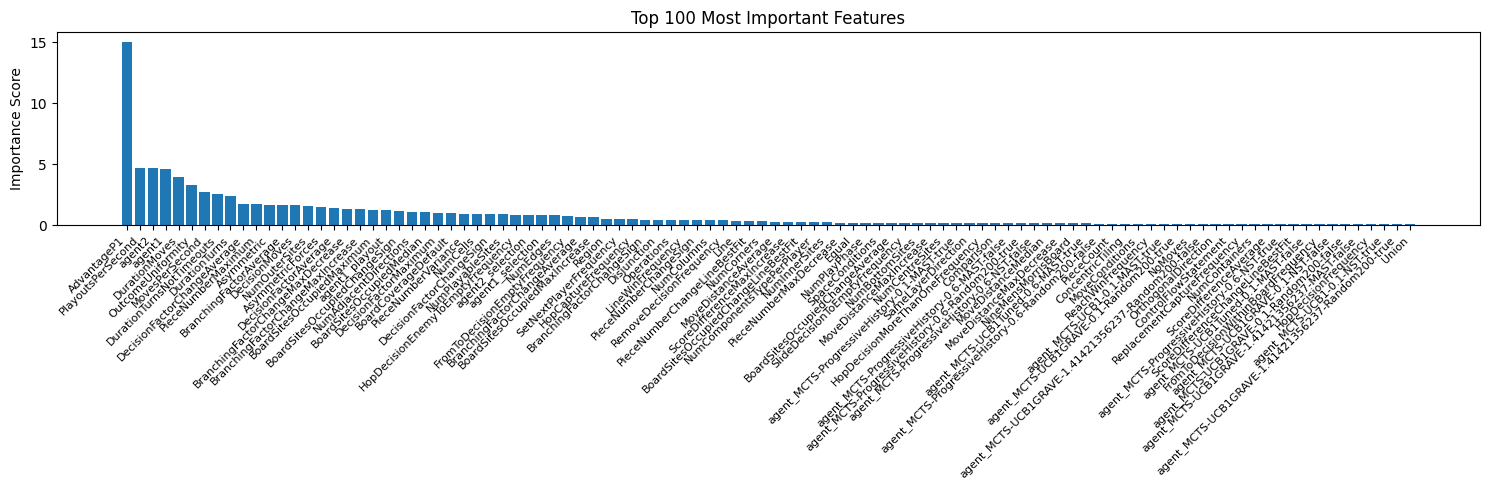

Fold 5 - RMSE: 0.3972456189325651
List of oof scores: [0.41725001046573185, 0.4302510877522118, 0.4190606575518477, 0.43631806153404457, 0.3972456189325651]
Average oof score: 0.4200250872472802


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6371477	test: 0.5358462	best: 0.5358462 (0)	total: 87.1ms	remaining: 14m 31s


50:	learn: 0.4984418	test: 0.4941954	best: 0.4941954 (50)	total: 4.24s	remaining: 13m 46s


100:	learn: 0.4515916	test: 0.4755571	best: 0.4755571 (100)	total: 8.49s	remaining: 13m 52s


150:	learn: 0.4253633	test: 0.4626150	best: 0.4626150 (150)	total: 12.9s	remaining: 14m 4s


200:	learn: 0.4069980	test: 0.4525949	best: 0.4525949 (200)	total: 17.6s	remaining: 14m 18s


250:	learn: 0.3944793	test: 0.4465648	best: 0.4465648 (250)	total: 22.4s	remaining: 14m 30s


300:	learn: 0.3844772	test: 0.4421631	best: 0.4421631 (300)	total: 27.3s	remaining: 14m 39s


350:	learn: 0.3763720	test: 0.4389494	best: 0.4389492 (349)	total: 32.1s	remaining: 14m 42s


400:	learn: 0.3690513	test: 0.4361245	best: 0.4361245 (400)	total: 36.9s	remaining: 14m 42s


450:	learn: 0.3620915	test: 0.4332759	best: 0.4332759 (450)	total: 41.5s	remaining: 14m 38s


500:	learn: 0.3555468	test: 0.4310443	best: 0.4310443 (500)	total: 46.1s	remaining: 14m 33s


550:	learn: 0.3499602	test: 0.4292905	best: 0.4292905 (550)	total: 50.6s	remaining: 14m 28s


600:	learn: 0.3455988	test: 0.4282822	best: 0.4282822 (600)	total: 55.3s	remaining: 14m 24s


650:	learn: 0.3415652	test: 0.4273581	best: 0.4273581 (650)	total: 59.9s	remaining: 14m 20s


700:	learn: 0.3378452	test: 0.4265350	best: 0.4265350 (700)	total: 1m 4s	remaining: 14m 16s


750:	learn: 0.3346288	test: 0.4259222	best: 0.4259222 (750)	total: 1m 9s	remaining: 14m 11s


800:	learn: 0.3315187	test: 0.4250268	best: 0.4250254 (799)	total: 1m 13s	remaining: 14m 8s


850:	learn: 0.3286165	test: 0.4243421	best: 0.4243279 (847)	total: 1m 18s	remaining: 14m 3s


900:	learn: 0.3261148	test: 0.4237488	best: 0.4237488 (900)	total: 1m 23s	remaining: 14m 1s


950:	learn: 0.3235609	test: 0.4233883	best: 0.4233708 (944)	total: 1m 27s	remaining: 13m 56s


1000:	learn: 0.3210937	test: 0.4227139	best: 0.4227139 (1000)	total: 1m 32s	remaining: 13m 53s


1050:	learn: 0.3187805	test: 0.4222935	best: 0.4222935 (1050)	total: 1m 37s	remaining: 13m 49s


1100:	learn: 0.3165590	test: 0.4217707	best: 0.4217689 (1098)	total: 1m 42s	remaining: 13m 45s


1150:	learn: 0.3143391	test: 0.4211940	best: 0.4211940 (1150)	total: 1m 46s	remaining: 13m 40s


1200:	learn: 0.3124398	test: 0.4206643	best: 0.4206503 (1196)	total: 1m 51s	remaining: 13m 37s


1250:	learn: 0.3104807	test: 0.4203056	best: 0.4203056 (1250)	total: 1m 56s	remaining: 13m 33s


1300:	learn: 0.3086985	test: 0.4198882	best: 0.4198882 (1300)	total: 2m 1s	remaining: 13m 30s


1350:	learn: 0.3068066	test: 0.4194713	best: 0.4194713 (1350)	total: 2m 5s	remaining: 13m 26s


1400:	learn: 0.3050432	test: 0.4191732	best: 0.4191730 (1398)	total: 2m 10s	remaining: 13m 22s


1450:	learn: 0.3033098	test: 0.4187666	best: 0.4187666 (1450)	total: 2m 15s	remaining: 13m 18s


1500:	learn: 0.3016956	test: 0.4184223	best: 0.4184203 (1499)	total: 2m 20s	remaining: 13m 15s


1550:	learn: 0.3000805	test: 0.4180880	best: 0.4180880 (1550)	total: 2m 25s	remaining: 13m 11s


1600:	learn: 0.2985763	test: 0.4177476	best: 0.4177476 (1600)	total: 2m 29s	remaining: 13m 6s


1650:	learn: 0.2970742	test: 0.4174610	best: 0.4174585 (1648)	total: 2m 34s	remaining: 13m 2s


1700:	learn: 0.2956311	test: 0.4171900	best: 0.4171900 (1700)	total: 2m 39s	remaining: 12m 59s


1750:	learn: 0.2942611	test: 0.4169119	best: 0.4169119 (1750)	total: 2m 44s	remaining: 12m 55s


1800:	learn: 0.2928261	test: 0.4166017	best: 0.4165964 (1795)	total: 2m 49s	remaining: 12m 50s


1850:	learn: 0.2914384	test: 0.4163283	best: 0.4163203 (1849)	total: 2m 54s	remaining: 12m 46s


1900:	learn: 0.2901345	test: 0.4162050	best: 0.4162001 (1899)	total: 2m 58s	remaining: 12m 42s


1950:	learn: 0.2887937	test: 0.4159651	best: 0.4159633 (1949)	total: 3m 3s	remaining: 12m 37s


2000:	learn: 0.2875218	test: 0.4157013	best: 0.4157013 (2000)	total: 3m 8s	remaining: 12m 33s


2050:	learn: 0.2862076	test: 0.4154088	best: 0.4153938 (2045)	total: 3m 13s	remaining: 12m 28s


2100:	learn: 0.2849883	test: 0.4152413	best: 0.4152413 (2100)	total: 3m 18s	remaining: 12m 24s


2150:	learn: 0.2837680	test: 0.4150186	best: 0.4150186 (2150)	total: 3m 22s	remaining: 12m 20s


2200:	learn: 0.2825225	test: 0.4148537	best: 0.4148537 (2200)	total: 3m 27s	remaining: 12m 15s


2250:	learn: 0.2814315	test: 0.4146883	best: 0.4146846 (2247)	total: 3m 32s	remaining: 12m 11s


2300:	learn: 0.2804241	test: 0.4145072	best: 0.4144821 (2291)	total: 3m 37s	remaining: 12m 7s


2350:	learn: 0.2793864	test: 0.4143724	best: 0.4143724 (2350)	total: 3m 42s	remaining: 12m 2s


2400:	learn: 0.2783411	test: 0.4142699	best: 0.4142668 (2399)	total: 3m 47s	remaining: 11m 58s


2450:	learn: 0.2772712	test: 0.4141314	best: 0.4141314 (2450)	total: 3m 51s	remaining: 11m 54s


2500:	learn: 0.2761456	test: 0.4139237	best: 0.4139022 (2496)	total: 3m 56s	remaining: 11m 49s


2550:	learn: 0.2751963	test: 0.4137550	best: 0.4137550 (2550)	total: 4m 1s	remaining: 11m 45s


2600:	learn: 0.2742471	test: 0.4136183	best: 0.4136180 (2599)	total: 4m 6s	remaining: 11m 41s


2650:	learn: 0.2732861	test: 0.4134388	best: 0.4134380 (2649)	total: 4m 11s	remaining: 11m 36s


2700:	learn: 0.2722971	test: 0.4133050	best: 0.4133039 (2695)	total: 4m 16s	remaining: 11m 32s


2750:	learn: 0.2713716	test: 0.4131748	best: 0.4131692 (2749)	total: 4m 20s	remaining: 11m 27s


2800:	learn: 0.2704999	test: 0.4130723	best: 0.4130723 (2800)	total: 4m 25s	remaining: 11m 22s


2850:	learn: 0.2695908	test: 0.4129747	best: 0.4129747 (2850)	total: 4m 30s	remaining: 11m 18s


2900:	learn: 0.2688034	test: 0.4128183	best: 0.4128131 (2898)	total: 4m 35s	remaining: 11m 14s


2950:	learn: 0.2679542	test: 0.4126373	best: 0.4126348 (2948)	total: 4m 40s	remaining: 11m 9s


3000:	learn: 0.2671698	test: 0.4125270	best: 0.4125158 (2998)	total: 4m 45s	remaining: 11m 5s


3050:	learn: 0.2663360	test: 0.4124072	best: 0.4124072 (3050)	total: 4m 50s	remaining: 11m


3100:	learn: 0.2654828	test: 0.4122808	best: 0.4122808 (3100)	total: 4m 55s	remaining: 10m 56s


3150:	learn: 0.2646595	test: 0.4121795	best: 0.4121737 (3149)	total: 4m 59s	remaining: 10m 51s


3200:	learn: 0.2638905	test: 0.4120325	best: 0.4120325 (3200)	total: 5m 4s	remaining: 10m 47s


3250:	learn: 0.2631054	test: 0.4119563	best: 0.4119563 (3250)	total: 5m 9s	remaining: 10m 42s


3300:	learn: 0.2623432	test: 0.4118472	best: 0.4118472 (3300)	total: 5m 14s	remaining: 10m 38s


3350:	learn: 0.2615209	test: 0.4117177	best: 0.4117177 (3350)	total: 5m 19s	remaining: 10m 33s


3400:	learn: 0.2607940	test: 0.4116691	best: 0.4116653 (3384)	total: 5m 24s	remaining: 10m 29s


3450:	learn: 0.2600914	test: 0.4115294	best: 0.4115294 (3450)	total: 5m 29s	remaining: 10m 24s


3500:	learn: 0.2593327	test: 0.4114392	best: 0.4114350 (3491)	total: 5m 33s	remaining: 10m 19s


3550:	learn: 0.2586519	test: 0.4113858	best: 0.4113858 (3550)	total: 5m 38s	remaining: 10m 15s


3600:	learn: 0.2579364	test: 0.4112975	best: 0.4112975 (3600)	total: 5m 43s	remaining: 10m 10s


3650:	learn: 0.2572392	test: 0.4111991	best: 0.4111980 (3649)	total: 5m 48s	remaining: 10m 6s


3700:	learn: 0.2565716	test: 0.4110835	best: 0.4110822 (3699)	total: 5m 53s	remaining: 10m 1s


3750:	learn: 0.2558836	test: 0.4109913	best: 0.4109913 (3750)	total: 5m 58s	remaining: 9m 57s


3800:	learn: 0.2551910	test: 0.4109100	best: 0.4109100 (3800)	total: 6m 3s	remaining: 9m 52s


3850:	learn: 0.2545283	test: 0.4108312	best: 0.4108312 (3850)	total: 6m 8s	remaining: 9m 47s


3900:	learn: 0.2538749	test: 0.4107309	best: 0.4107309 (3900)	total: 6m 13s	remaining: 9m 43s


3950:	learn: 0.2532018	test: 0.4106925	best: 0.4106826 (3943)	total: 6m 17s	remaining: 9m 38s


4000:	learn: 0.2525270	test: 0.4106362	best: 0.4106362 (4000)	total: 6m 22s	remaining: 9m 34s


4050:	learn: 0.2518881	test: 0.4105851	best: 0.4105844 (4049)	total: 6m 27s	remaining: 9m 29s


4100:	learn: 0.2512892	test: 0.4105424	best: 0.4105424 (4100)	total: 6m 32s	remaining: 9m 24s


4150:	learn: 0.2506965	test: 0.4105119	best: 0.4105119 (4150)	total: 6m 37s	remaining: 9m 20s


4200:	learn: 0.2501329	test: 0.4104846	best: 0.4104846 (4200)	total: 6m 42s	remaining: 9m 15s


4250:	learn: 0.2495235	test: 0.4104191	best: 0.4104189 (4249)	total: 6m 47s	remaining: 9m 11s


4300:	learn: 0.2489394	test: 0.4103549	best: 0.4103549 (4300)	total: 6m 52s	remaining: 9m 6s


4350:	learn: 0.2483663	test: 0.4102826	best: 0.4102777 (4348)	total: 6m 57s	remaining: 9m 1s


4400:	learn: 0.2478040	test: 0.4102698	best: 0.4102672 (4398)	total: 7m 2s	remaining: 8m 56s


4450:	learn: 0.2471858	test: 0.4102108	best: 0.4102108 (4450)	total: 7m 7s	remaining: 8m 52s


4500:	learn: 0.2466236	test: 0.4101371	best: 0.4101320 (4498)	total: 7m 11s	remaining: 8m 47s


4550:	learn: 0.2460421	test: 0.4100744	best: 0.4100744 (4550)	total: 7m 16s	remaining: 8m 42s


4600:	learn: 0.2454727	test: 0.4100206	best: 0.4100206 (4600)	total: 7m 21s	remaining: 8m 38s


4650:	learn: 0.2448885	test: 0.4099645	best: 0.4099612 (4648)	total: 7m 26s	remaining: 8m 33s


4700:	learn: 0.2443953	test: 0.4099246	best: 0.4099245 (4699)	total: 7m 31s	remaining: 8m 28s


4750:	learn: 0.2438828	test: 0.4098941	best: 0.4098920 (4747)	total: 7m 36s	remaining: 8m 24s


4800:	learn: 0.2433309	test: 0.4098611	best: 0.4098567 (4784)	total: 7m 41s	remaining: 8m 19s


4850:	learn: 0.2428432	test: 0.4098251	best: 0.4098251 (4850)	total: 7m 46s	remaining: 8m 14s


4900:	learn: 0.2423238	test: 0.4097888	best: 0.4097885 (4899)	total: 7m 51s	remaining: 8m 10s


4950:	learn: 0.2417823	test: 0.4097121	best: 0.4097093 (4945)	total: 7m 56s	remaining: 8m 5s


5000:	learn: 0.2412280	test: 0.4096686	best: 0.4096667 (4999)	total: 8m 1s	remaining: 8m


5050:	learn: 0.2407492	test: 0.4096136	best: 0.4096136 (5050)	total: 8m 6s	remaining: 7m 56s


5100:	learn: 0.2402882	test: 0.4095651	best: 0.4095600 (5097)	total: 8m 10s	remaining: 7m 51s


5150:	learn: 0.2397935	test: 0.4095226	best: 0.4095226 (5150)	total: 8m 15s	remaining: 7m 46s


5200:	learn: 0.2393282	test: 0.4094708	best: 0.4094708 (5200)	total: 8m 21s	remaining: 7m 42s


5250:	learn: 0.2388045	test: 0.4094410	best: 0.4094410 (5250)	total: 8m 25s	remaining: 7m 37s


5300:	learn: 0.2383247	test: 0.4094249	best: 0.4094234 (5269)	total: 8m 30s	remaining: 7m 32s


5350:	learn: 0.2377885	test: 0.4094025	best: 0.4093998 (5347)	total: 8m 35s	remaining: 7m 28s


5400:	learn: 0.2372666	test: 0.4093680	best: 0.4093642 (5394)	total: 8m 40s	remaining: 7m 23s


5450:	learn: 0.2368002	test: 0.4093381	best: 0.4093358 (5448)	total: 8m 45s	remaining: 7m 18s


5500:	learn: 0.2362735	test: 0.4093449	best: 0.4093276 (5463)	total: 8m 50s	remaining: 7m 13s


5550:	learn: 0.2357999	test: 0.4092976	best: 0.4092953 (5542)	total: 8m 55s	remaining: 7m 9s


5600:	learn: 0.2353601	test: 0.4092662	best: 0.4092650 (5599)	total: 9m	remaining: 7m 4s


5650:	learn: 0.2349346	test: 0.4092387	best: 0.4092329 (5640)	total: 9m 5s	remaining: 6m 59s


5700:	learn: 0.2344988	test: 0.4092007	best: 0.4092007 (5700)	total: 9m 10s	remaining: 6m 55s


5750:	learn: 0.2340110	test: 0.4091405	best: 0.4091405 (5750)	total: 9m 15s	remaining: 6m 50s


5800:	learn: 0.2335489	test: 0.4090756	best: 0.4090738 (5792)	total: 9m 20s	remaining: 6m 45s


5850:	learn: 0.2331034	test: 0.4090363	best: 0.4090363 (5850)	total: 9m 25s	remaining: 6m 40s


5900:	learn: 0.2326500	test: 0.4090017	best: 0.4090017 (5900)	total: 9m 30s	remaining: 6m 36s


5950:	learn: 0.2321807	test: 0.4089837	best: 0.4089827 (5931)	total: 9m 35s	remaining: 6m 31s


6000:	learn: 0.2317583	test: 0.4089776	best: 0.4089621 (5988)	total: 9m 40s	remaining: 6m 26s


6050:	learn: 0.2313351	test: 0.4089686	best: 0.4089621 (5988)	total: 9m 45s	remaining: 6m 21s


6100:	learn: 0.2308880	test: 0.4089366	best: 0.4089201 (6087)	total: 9m 50s	remaining: 6m 17s


6150:	learn: 0.2304713	test: 0.4089000	best: 0.4088995 (6136)	total: 9m 55s	remaining: 6m 12s


6200:	learn: 0.2300219	test: 0.4088768	best: 0.4088690 (6188)	total: 9m 59s	remaining: 6m 7s


6250:	learn: 0.2295821	test: 0.4088323	best: 0.4088323 (6250)	total: 10m 4s	remaining: 6m 2s


6300:	learn: 0.2291418	test: 0.4087883	best: 0.4087883 (6300)	total: 10m 9s	remaining: 5m 58s


6350:	learn: 0.2287170	test: 0.4087478	best: 0.4087478 (6350)	total: 10m 14s	remaining: 5m 53s


6400:	learn: 0.2283334	test: 0.4087478	best: 0.4087478 (6350)	total: 10m 19s	remaining: 5m 48s


6450:	learn: 0.2278773	test: 0.4087199	best: 0.4087189 (6449)	total: 10m 24s	remaining: 5m 43s


6500:	learn: 0.2274745	test: 0.4086734	best: 0.4086671 (6496)	total: 10m 29s	remaining: 5m 39s


6550:	learn: 0.2270835	test: 0.4086330	best: 0.4086330 (6550)	total: 10m 34s	remaining: 5m 34s


6600:	learn: 0.2266824	test: 0.4085977	best: 0.4085977 (6600)	total: 10m 39s	remaining: 5m 29s


6650:	learn: 0.2262851	test: 0.4085503	best: 0.4085495 (6649)	total: 10m 44s	remaining: 5m 24s


6700:	learn: 0.2258809	test: 0.4085245	best: 0.4085203 (6687)	total: 10m 49s	remaining: 5m 19s


6750:	learn: 0.2255176	test: 0.4084824	best: 0.4084799 (6745)	total: 10m 54s	remaining: 5m 15s


6800:	learn: 0.2251097	test: 0.4084668	best: 0.4084664 (6799)	total: 10m 59s	remaining: 5m 10s


6850:	learn: 0.2247385	test: 0.4084516	best: 0.4084512 (6849)	total: 11m 4s	remaining: 5m 5s


6900:	learn: 0.2243462	test: 0.4084265	best: 0.4084249 (6891)	total: 11m 9s	remaining: 5m


6950:	learn: 0.2239606	test: 0.4084126	best: 0.4084122 (6949)	total: 11m 14s	remaining: 4m 56s


7000:	learn: 0.2235629	test: 0.4083892	best: 0.4083892 (7000)	total: 11m 19s	remaining: 4m 51s


7050:	learn: 0.2232030	test: 0.4083617	best: 0.4083537 (7048)	total: 11m 24s	remaining: 4m 46s


7100:	learn: 0.2228362	test: 0.4083487	best: 0.4083481 (7090)	total: 11m 29s	remaining: 4m 41s


7150:	learn: 0.2224976	test: 0.4083302	best: 0.4083296 (7149)	total: 11m 34s	remaining: 4m 36s


7200:	learn: 0.2221419	test: 0.4083160	best: 0.4083157 (7192)	total: 11m 39s	remaining: 4m 31s


7250:	learn: 0.2217502	test: 0.4083033	best: 0.4083000 (7247)	total: 11m 44s	remaining: 4m 27s


7300:	learn: 0.2213775	test: 0.4082988	best: 0.4082883 (7277)	total: 11m 49s	remaining: 4m 22s


7350:	learn: 0.2210370	test: 0.4082688	best: 0.4082688 (7350)	total: 11m 54s	remaining: 4m 17s


7400:	learn: 0.2206984	test: 0.4082451	best: 0.4082451 (7400)	total: 11m 59s	remaining: 4m 12s


7450:	learn: 0.2203161	test: 0.4081970	best: 0.4081970 (7450)	total: 12m 4s	remaining: 4m 7s


7500:	learn: 0.2199523	test: 0.4081844	best: 0.4081818 (7498)	total: 12m 9s	remaining: 4m 3s


7550:	learn: 0.2196132	test: 0.4081818	best: 0.4081794 (7519)	total: 12m 14s	remaining: 3m 58s


7600:	learn: 0.2192311	test: 0.4081554	best: 0.4081492 (7595)	total: 12m 19s	remaining: 3m 53s


7650:	learn: 0.2188835	test: 0.4081302	best: 0.4081281 (7647)	total: 12m 24s	remaining: 3m 48s


7700:	learn: 0.2185408	test: 0.4081251	best: 0.4081249 (7699)	total: 12m 29s	remaining: 3m 43s


7750:	learn: 0.2181759	test: 0.4081234	best: 0.4081161 (7714)	total: 12m 34s	remaining: 3m 39s


7800:	learn: 0.2177873	test: 0.4080514	best: 0.4080424 (7799)	total: 12m 39s	remaining: 3m 34s


7850:	learn: 0.2174302	test: 0.4080419	best: 0.4080419 (7850)	total: 12m 44s	remaining: 3m 29s


7900:	learn: 0.2170782	test: 0.4080283	best: 0.4080279 (7898)	total: 12m 49s	remaining: 3m 24s


7950:	learn: 0.2167469	test: 0.4080158	best: 0.4080056 (7942)	total: 12m 54s	remaining: 3m 19s


8000:	learn: 0.2163665	test: 0.4080018	best: 0.4080003 (7999)	total: 12m 59s	remaining: 3m 14s


8050:	learn: 0.2160231	test: 0.4079864	best: 0.4079850 (8049)	total: 13m 4s	remaining: 3m 9s


8100:	learn: 0.2156754	test: 0.4079580	best: 0.4079580 (8100)	total: 13m 9s	remaining: 3m 5s


8150:	learn: 0.2153497	test: 0.4079131	best: 0.4079130 (8147)	total: 13m 14s	remaining: 3m


8200:	learn: 0.2150061	test: 0.4079036	best: 0.4079036 (8200)	total: 13m 19s	remaining: 2m 55s


8250:	learn: 0.2146837	test: 0.4078890	best: 0.4078858 (8241)	total: 13m 24s	remaining: 2m 50s


8300:	learn: 0.2143620	test: 0.4078643	best: 0.4078635 (8298)	total: 13m 29s	remaining: 2m 45s


8350:	learn: 0.2140256	test: 0.4078192	best: 0.4078192 (8350)	total: 13m 34s	remaining: 2m 40s


8400:	learn: 0.2136802	test: 0.4078077	best: 0.4078061 (8395)	total: 13m 39s	remaining: 2m 36s


8450:	learn: 0.2133312	test: 0.4077862	best: 0.4077862 (8450)	total: 13m 44s	remaining: 2m 31s


8500:	learn: 0.2130058	test: 0.4077639	best: 0.4077630 (8499)	total: 13m 49s	remaining: 2m 26s


8550:	learn: 0.2126917	test: 0.4077455	best: 0.4077417 (8541)	total: 13m 54s	remaining: 2m 21s


8600:	learn: 0.2123674	test: 0.4077291	best: 0.4077291 (8600)	total: 13m 59s	remaining: 2m 16s


8650:	learn: 0.2120542	test: 0.4076989	best: 0.4076989 (8650)	total: 14m 4s	remaining: 2m 11s


8700:	learn: 0.2117174	test: 0.4076903	best: 0.4076903 (8700)	total: 14m 9s	remaining: 2m 6s


8750:	learn: 0.2113919	test: 0.4076761	best: 0.4076761 (8750)	total: 14m 14s	remaining: 2m 1s


8800:	learn: 0.2110533	test: 0.4076306	best: 0.4076299 (8799)	total: 14m 19s	remaining: 1m 57s


8850:	learn: 0.2107576	test: 0.4076166	best: 0.4076165 (8849)	total: 14m 24s	remaining: 1m 52s


8900:	learn: 0.2104577	test: 0.4076106	best: 0.4076106 (8900)	total: 14m 29s	remaining: 1m 47s


8950:	learn: 0.2101321	test: 0.4075984	best: 0.4075984 (8950)	total: 14m 34s	remaining: 1m 42s


9000:	learn: 0.2098271	test: 0.4075782	best: 0.4075782 (9000)	total: 14m 39s	remaining: 1m 37s


9050:	learn: 0.2095121	test: 0.4075324	best: 0.4075311 (9049)	total: 14m 44s	remaining: 1m 32s


9100:	learn: 0.2092028	test: 0.4075263	best: 0.4075260 (9099)	total: 14m 49s	remaining: 1m 27s


9150:	learn: 0.2089031	test: 0.4075144	best: 0.4075113 (9116)	total: 14m 54s	remaining: 1m 23s


9200:	learn: 0.2085510	test: 0.4075003	best: 0.4074937 (9192)	total: 14m 59s	remaining: 1m 18s


9250:	learn: 0.2082476	test: 0.4074758	best: 0.4074743 (9249)	total: 15m 4s	remaining: 1m 13s


9300:	learn: 0.2079475	test: 0.4074801	best: 0.4074743 (9249)	total: 15m 9s	remaining: 1m 8s


9350:	learn: 0.2076105	test: 0.4074503	best: 0.4074398 (9329)	total: 15m 14s	remaining: 1m 3s


9400:	learn: 0.2072906	test: 0.4074360	best: 0.4074356 (9397)	total: 15m 19s	remaining: 58.6s


9450:	learn: 0.2070075	test: 0.4074197	best: 0.4074152 (9439)	total: 15m 24s	remaining: 53.7s


9500:	learn: 0.2067443	test: 0.4074041	best: 0.4074038 (9494)	total: 15m 29s	remaining: 48.8s


9550:	learn: 0.2064476	test: 0.4073935	best: 0.4073877 (9542)	total: 15m 34s	remaining: 43.9s


9600:	learn: 0.2061692	test: 0.4073999	best: 0.4073877 (9542)	total: 15m 39s	remaining: 39.1s


9650:	learn: 0.2058696	test: 0.4073955	best: 0.4073877 (9542)	total: 15m 44s	remaining: 34.2s


9700:	learn: 0.2055675	test: 0.4073931	best: 0.4073877 (9542)	total: 15m 49s	remaining: 29.3s


9750:	learn: 0.2052665	test: 0.4073644	best: 0.4073644 (9750)	total: 15m 54s	remaining: 24.4s


9800:	learn: 0.2049773	test: 0.4073603	best: 0.4073549 (9762)	total: 15m 59s	remaining: 19.5s


9850:	learn: 0.2046773	test: 0.4073447	best: 0.4073425 (9840)	total: 16m 4s	remaining: 14.6s


9900:	learn: 0.2043772	test: 0.4073291	best: 0.4073235 (9891)	total: 16m 9s	remaining: 9.7s


9950:	learn: 0.2040928	test: 0.4073171	best: 0.4073102 (9918)	total: 16m 14s	remaining: 4.8s


9999:	learn: 0.2037940	test: 0.4073048	best: 0.4073039 (9996)	total: 16m 19s	remaining: 0us

bestTest = 0.4073038891
bestIteration = 9996

Shrink model to first 9997 iterations.


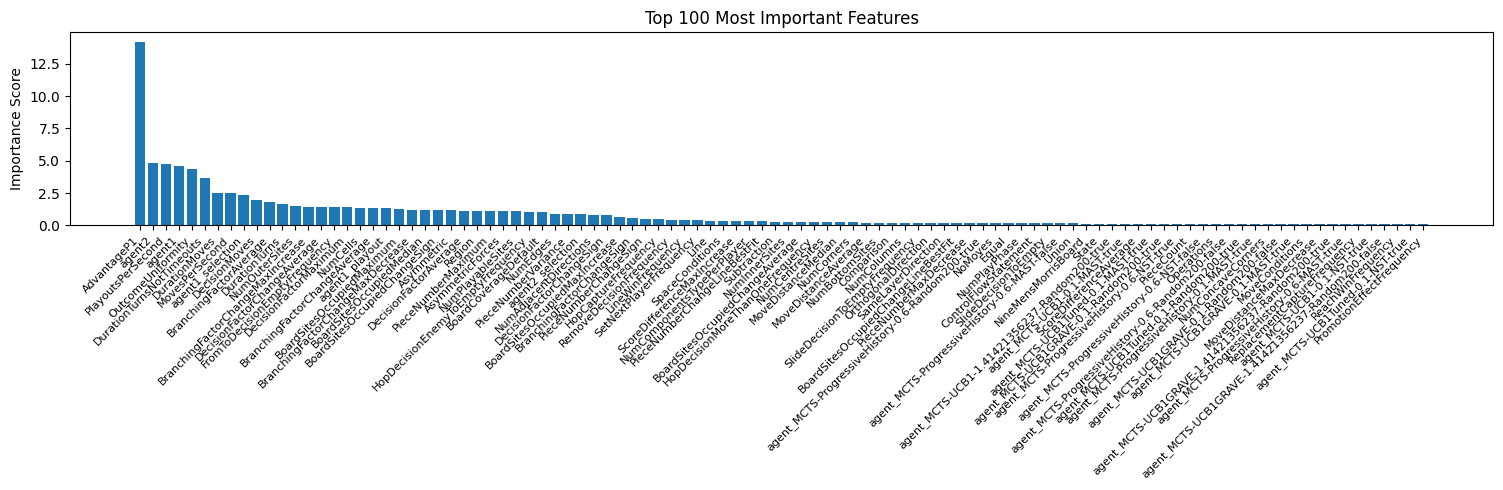

Fold 1 - RMSE: 0.4071033680621828
Fold 2


0:	learn: 0.6331122	test: 0.5464297	best: 0.5464297 (0)	total: 96.8ms	remaining: 16m 7s


50:	learn: 0.5000141	test: 0.4771673	best: 0.4771673 (50)	total: 4.48s	remaining: 14m 34s


100:	learn: 0.4527688	test: 0.4520423	best: 0.4520423 (100)	total: 8.89s	remaining: 14m 31s


150:	learn: 0.4258227	test: 0.4386317	best: 0.4386317 (150)	total: 13.4s	remaining: 14m 32s


200:	learn: 0.4075721	test: 0.4314130	best: 0.4313940 (199)	total: 18.2s	remaining: 14m 46s


250:	learn: 0.3950068	test: 0.4271530	best: 0.4271530 (250)	total: 23.2s	remaining: 14m 59s


300:	learn: 0.3845784	test: 0.4237216	best: 0.4237216 (300)	total: 28s	remaining: 15m 3s


350:	learn: 0.3761359	test: 0.4206250	best: 0.4206250 (350)	total: 32.9s	remaining: 15m 5s


400:	learn: 0.3687622	test: 0.4180502	best: 0.4180502 (400)	total: 37.8s	remaining: 15m 5s


450:	learn: 0.3624550	test: 0.4160607	best: 0.4160607 (450)	total: 42.7s	remaining: 15m 5s


500:	learn: 0.3565844	test: 0.4141162	best: 0.4141162 (500)	total: 47.5s	remaining: 14m 59s


550:	learn: 0.3514239	test: 0.4127448	best: 0.4127448 (550)	total: 52.2s	remaining: 14m 55s


600:	learn: 0.3467142	test: 0.4111569	best: 0.4111569 (600)	total: 57s	remaining: 14m 51s


650:	learn: 0.3426062	test: 0.4103027	best: 0.4102816 (649)	total: 1m 1s	remaining: 14m 48s


700:	learn: 0.3388649	test: 0.4095276	best: 0.4095276 (700)	total: 1m 6s	remaining: 14m 44s


750:	learn: 0.3354805	test: 0.4087815	best: 0.4087815 (750)	total: 1m 11s	remaining: 14m 40s


800:	learn: 0.3322095	test: 0.4081427	best: 0.4081058 (797)	total: 1m 16s	remaining: 14m 36s


850:	learn: 0.3290325	test: 0.4073915	best: 0.4073915 (850)	total: 1m 21s	remaining: 14m 32s


900:	learn: 0.3265274	test: 0.4069313	best: 0.4069276 (899)	total: 1m 26s	remaining: 14m 29s


950:	learn: 0.3239454	test: 0.4064208	best: 0.4064208 (950)	total: 1m 31s	remaining: 14m 25s


1000:	learn: 0.3215719	test: 0.4058674	best: 0.4058412 (995)	total: 1m 35s	remaining: 14m 21s


1050:	learn: 0.3189869	test: 0.4052458	best: 0.4052453 (1049)	total: 1m 40s	remaining: 14m 16s


1100:	learn: 0.3166226	test: 0.4047609	best: 0.4047609 (1100)	total: 1m 45s	remaining: 14m 13s


1150:	learn: 0.3142960	test: 0.4042731	best: 0.4042731 (1150)	total: 1m 50s	remaining: 14m 9s


1200:	learn: 0.3123136	test: 0.4039422	best: 0.4039377 (1199)	total: 1m 55s	remaining: 14m 5s


1250:	learn: 0.3102313	test: 0.4035040	best: 0.4035040 (1250)	total: 2m	remaining: 14m 1s


1300:	learn: 0.3084671	test: 0.4031668	best: 0.4031668 (1300)	total: 2m 5s	remaining: 13m 58s


1350:	learn: 0.3066769	test: 0.4029194	best: 0.4029116 (1348)	total: 2m 10s	remaining: 13m 54s


1400:	learn: 0.3049080	test: 0.4026522	best: 0.4026522 (1400)	total: 2m 15s	remaining: 13m 51s


1450:	learn: 0.3032256	test: 0.4024159	best: 0.4024159 (1450)	total: 2m 20s	remaining: 13m 47s


1500:	learn: 0.3014783	test: 0.4022065	best: 0.4022064 (1499)	total: 2m 25s	remaining: 13m 42s


1550:	learn: 0.2998433	test: 0.4020131	best: 0.4020078 (1549)	total: 2m 30s	remaining: 13m 38s


1600:	learn: 0.2984409	test: 0.4018531	best: 0.4018531 (1600)	total: 2m 35s	remaining: 13m 34s


1650:	learn: 0.2970257	test: 0.4017053	best: 0.4016936 (1643)	total: 2m 40s	remaining: 13m 30s


1700:	learn: 0.2956043	test: 0.4015384	best: 0.4015384 (1700)	total: 2m 45s	remaining: 13m 26s


1750:	learn: 0.2941990	test: 0.4013476	best: 0.4013423 (1746)	total: 2m 50s	remaining: 13m 22s


1800:	learn: 0.2927977	test: 0.4011779	best: 0.4011779 (1800)	total: 2m 55s	remaining: 13m 18s


1850:	learn: 0.2915054	test: 0.4009693	best: 0.4009693 (1850)	total: 3m	remaining: 13m 14s


1900:	learn: 0.2902286	test: 0.4008194	best: 0.4008044 (1897)	total: 3m 5s	remaining: 13m 10s


1950:	learn: 0.2889787	test: 0.4006828	best: 0.4006687 (1941)	total: 3m 10s	remaining: 13m 6s


2000:	learn: 0.2876825	test: 0.4005605	best: 0.4005515 (1999)	total: 3m 15s	remaining: 13m 1s


2050:	learn: 0.2864911	test: 0.4003638	best: 0.4003638 (2050)	total: 3m 20s	remaining: 12m 57s


2100:	learn: 0.2853571	test: 0.4002800	best: 0.4002800 (2100)	total: 3m 25s	remaining: 12m 53s


2150:	learn: 0.2841749	test: 0.4001192	best: 0.4001190 (2147)	total: 3m 30s	remaining: 12m 48s


2200:	learn: 0.2830653	test: 0.4000329	best: 0.4000224 (2198)	total: 3m 35s	remaining: 12m 44s


2250:	learn: 0.2819653	test: 0.3999308	best: 0.3999308 (2250)	total: 3m 40s	remaining: 12m 40s


2300:	learn: 0.2809109	test: 0.3998168	best: 0.3998060 (2298)	total: 3m 45s	remaining: 12m 35s


2350:	learn: 0.2799381	test: 0.3997499	best: 0.3997499 (2350)	total: 3m 51s	remaining: 12m 31s


2400:	learn: 0.2788743	test: 0.3995886	best: 0.3995886 (2400)	total: 3m 56s	remaining: 12m 27s


2450:	learn: 0.2777847	test: 0.3994187	best: 0.3994104 (2449)	total: 4m 1s	remaining: 12m 23s


2500:	learn: 0.2768624	test: 0.3993064	best: 0.3993064 (2500)	total: 4m 6s	remaining: 12m 19s


2550:	learn: 0.2759132	test: 0.3992255	best: 0.3992255 (2550)	total: 4m 11s	remaining: 12m 15s


2600:	learn: 0.2749016	test: 0.3991172	best: 0.3991172 (2600)	total: 4m 16s	remaining: 12m 10s


2650:	learn: 0.2739574	test: 0.3990374	best: 0.3990361 (2649)	total: 4m 21s	remaining: 12m 5s


2700:	learn: 0.2729942	test: 0.3989503	best: 0.3989503 (2700)	total: 4m 26s	remaining: 12m 1s


2750:	learn: 0.2721337	test: 0.3988988	best: 0.3988900 (2747)	total: 4m 31s	remaining: 11m 56s


2800:	learn: 0.2712855	test: 0.3988423	best: 0.3988423 (2800)	total: 4m 36s	remaining: 11m 51s


2850:	learn: 0.2704547	test: 0.3987401	best: 0.3987376 (2849)	total: 4m 42s	remaining: 11m 47s


2900:	learn: 0.2696033	test: 0.3987176	best: 0.3987176 (2900)	total: 4m 47s	remaining: 11m 42s


2950:	learn: 0.2687698	test: 0.3986021	best: 0.3986021 (2950)	total: 4m 52s	remaining: 11m 37s


3000:	learn: 0.2679106	test: 0.3985375	best: 0.3985347 (2994)	total: 4m 57s	remaining: 11m 33s


3050:	learn: 0.2670914	test: 0.3984489	best: 0.3984436 (3045)	total: 5m 2s	remaining: 11m 28s


3100:	learn: 0.2663032	test: 0.3983997	best: 0.3983955 (3090)	total: 5m 7s	remaining: 11m 24s


3150:	learn: 0.2654829	test: 0.3983308	best: 0.3983308 (3150)	total: 5m 12s	remaining: 11m 19s


3200:	learn: 0.2646650	test: 0.3983336	best: 0.3983042 (3162)	total: 5m 17s	remaining: 11m 14s


3250:	learn: 0.2639466	test: 0.3982538	best: 0.3982538 (3250)	total: 5m 22s	remaining: 11m 10s


3300:	learn: 0.2631683	test: 0.3981997	best: 0.3981993 (3299)	total: 5m 27s	remaining: 11m 5s


3350:	learn: 0.2624251	test: 0.3981372	best: 0.3981294 (3331)	total: 5m 32s	remaining: 11m


3400:	learn: 0.2616955	test: 0.3980874	best: 0.3980855 (3398)	total: 5m 37s	remaining: 10m 55s


3450:	learn: 0.2609054	test: 0.3980351	best: 0.3980351 (3450)	total: 5m 42s	remaining: 10m 50s


3500:	learn: 0.2601695	test: 0.3979679	best: 0.3979586 (3489)	total: 5m 48s	remaining: 10m 46s


3550:	learn: 0.2594535	test: 0.3979191	best: 0.3979097 (3545)	total: 5m 53s	remaining: 10m 41s


3600:	learn: 0.2586979	test: 0.3978945	best: 0.3978753 (3585)	total: 5m 58s	remaining: 10m 36s


3650:	learn: 0.2579873	test: 0.3978748	best: 0.3978580 (3639)	total: 6m 3s	remaining: 10m 31s


3700:	learn: 0.2573403	test: 0.3978349	best: 0.3978322 (3699)	total: 6m 8s	remaining: 10m 26s


3750:	learn: 0.2566155	test: 0.3977971	best: 0.3977969 (3749)	total: 6m 13s	remaining: 10m 22s


3800:	learn: 0.2559223	test: 0.3977452	best: 0.3977437 (3783)	total: 6m 18s	remaining: 10m 17s


3850:	learn: 0.2552556	test: 0.3976915	best: 0.3976915 (3850)	total: 6m 23s	remaining: 10m 12s


3900:	learn: 0.2545688	test: 0.3976702	best: 0.3976629 (3894)	total: 6m 28s	remaining: 10m 7s


3950:	learn: 0.2538987	test: 0.3976286	best: 0.3976275 (3949)	total: 6m 33s	remaining: 10m 2s


4000:	learn: 0.2532860	test: 0.3975915	best: 0.3975915 (4000)	total: 6m 38s	remaining: 9m 58s


4050:	learn: 0.2526668	test: 0.3975514	best: 0.3975399 (4046)	total: 6m 44s	remaining: 9m 53s


4100:	learn: 0.2520532	test: 0.3975093	best: 0.3975093 (4100)	total: 6m 49s	remaining: 9m 48s


4150:	learn: 0.2514505	test: 0.3975063	best: 0.3975045 (4109)	total: 6m 54s	remaining: 9m 43s


4200:	learn: 0.2508900	test: 0.3974935	best: 0.3974910 (4177)	total: 6m 59s	remaining: 9m 38s


4250:	learn: 0.2503247	test: 0.3974969	best: 0.3974748 (4201)	total: 7m 4s	remaining: 9m 34s


4300:	learn: 0.2497566	test: 0.3974841	best: 0.3974748 (4201)	total: 7m 9s	remaining: 9m 29s


4350:	learn: 0.2491405	test: 0.3974502	best: 0.3974492 (4349)	total: 7m 14s	remaining: 9m 24s


4400:	learn: 0.2486023	test: 0.3974296	best: 0.3974220 (4372)	total: 7m 19s	remaining: 9m 19s


4450:	learn: 0.2480457	test: 0.3974020	best: 0.3974012 (4449)	total: 7m 24s	remaining: 9m 14s


4500:	learn: 0.2474689	test: 0.3974326	best: 0.3974002 (4452)	total: 7m 29s	remaining: 9m 9s


4550:	learn: 0.2469151	test: 0.3974048	best: 0.3974002 (4452)	total: 7m 35s	remaining: 9m 4s


4600:	learn: 0.2464016	test: 0.3973863	best: 0.3973863 (4600)	total: 7m 40s	remaining: 9m


4650:	learn: 0.2458782	test: 0.3973196	best: 0.3973161 (4644)	total: 7m 45s	remaining: 8m 55s


4700:	learn: 0.2453589	test: 0.3973041	best: 0.3973026 (4699)	total: 7m 50s	remaining: 8m 50s


4750:	learn: 0.2448008	test: 0.3972567	best: 0.3972495 (4740)	total: 7m 55s	remaining: 8m 45s


4800:	learn: 0.2442645	test: 0.3972218	best: 0.3972218 (4800)	total: 8m	remaining: 8m 40s


4850:	learn: 0.2437366	test: 0.3971904	best: 0.3971842 (4840)	total: 8m 6s	remaining: 8m 35s


4900:	learn: 0.2432444	test: 0.3971984	best: 0.3971842 (4840)	total: 8m 11s	remaining: 8m 30s


4950:	learn: 0.2427275	test: 0.3971703	best: 0.3971691 (4949)	total: 8m 16s	remaining: 8m 26s


5000:	learn: 0.2421903	test: 0.3971453	best: 0.3971415 (4991)	total: 8m 21s	remaining: 8m 21s


5050:	learn: 0.2416927	test: 0.3971166	best: 0.3971112 (5033)	total: 8m 26s	remaining: 8m 16s


5100:	learn: 0.2412304	test: 0.3971102	best: 0.3971049 (5078)	total: 8m 31s	remaining: 8m 11s


5150:	learn: 0.2407129	test: 0.3970715	best: 0.3970677 (5149)	total: 8m 36s	remaining: 8m 6s


5200:	learn: 0.2401883	test: 0.3971053	best: 0.3970675 (5154)	total: 8m 41s	remaining: 8m 1s


5250:	learn: 0.2397008	test: 0.3971020	best: 0.3970675 (5154)	total: 8m 47s	remaining: 7m 56s


5300:	learn: 0.2391838	test: 0.3970842	best: 0.3970675 (5154)	total: 8m 52s	remaining: 7m 51s


5350:	learn: 0.2386901	test: 0.3970639	best: 0.3970594 (5341)	total: 8m 57s	remaining: 7m 47s


5400:	learn: 0.2381978	test: 0.3970399	best: 0.3970344 (5399)	total: 9m 3s	remaining: 7m 42s


5450:	learn: 0.2377048	test: 0.3970154	best: 0.3970126 (5446)	total: 9m 8s	remaining: 7m 38s


5500:	learn: 0.2372158	test: 0.3970048	best: 0.3969990 (5464)	total: 9m 14s	remaining: 7m 33s


5550:	learn: 0.2367582	test: 0.3970071	best: 0.3969937 (5510)	total: 9m 19s	remaining: 7m 28s


5600:	learn: 0.2363195	test: 0.3970070	best: 0.3969937 (5510)	total: 9m 24s	remaining: 7m 23s


5650:	learn: 0.2358842	test: 0.3970106	best: 0.3969937 (5510)	total: 9m 29s	remaining: 7m 18s


5700:	learn: 0.2354278	test: 0.3969751	best: 0.3969699 (5698)	total: 9m 34s	remaining: 7m 13s


5750:	learn: 0.2349967	test: 0.3969591	best: 0.3969523 (5738)	total: 9m 39s	remaining: 7m 8s


5800:	learn: 0.2345499	test: 0.3969341	best: 0.3969330 (5794)	total: 9m 45s	remaining: 7m 3s


5850:	learn: 0.2340901	test: 0.3969179	best: 0.3969080 (5838)	total: 9m 50s	remaining: 6m 58s


5900:	learn: 0.2336409	test: 0.3969114	best: 0.3969065 (5894)	total: 9m 55s	remaining: 6m 53s


5950:	learn: 0.2332321	test: 0.3968911	best: 0.3968881 (5937)	total: 10m 1s	remaining: 6m 48s


6000:	learn: 0.2327749	test: 0.3968892	best: 0.3968753 (5962)	total: 10m 6s	remaining: 6m 44s


6050:	learn: 0.2323476	test: 0.3968853	best: 0.3968753 (5962)	total: 10m 11s	remaining: 6m 39s


6100:	learn: 0.2319001	test: 0.3968884	best: 0.3968753 (5962)	total: 10m 16s	remaining: 6m 34s


6150:	learn: 0.2315199	test: 0.3968570	best: 0.3968497 (6133)	total: 10m 22s	remaining: 6m 29s


6200:	learn: 0.2310690	test: 0.3968678	best: 0.3968497 (6133)	total: 10m 27s	remaining: 6m 24s


6250:	learn: 0.2306553	test: 0.3968752	best: 0.3968497 (6133)	total: 10m 32s	remaining: 6m 19s


6300:	learn: 0.2302250	test: 0.3968399	best: 0.3968397 (6299)	total: 10m 37s	remaining: 6m 14s


6350:	learn: 0.2297867	test: 0.3968183	best: 0.3968136 (6349)	total: 10m 42s	remaining: 6m 9s


6400:	learn: 0.2293688	test: 0.3968323	best: 0.3968136 (6349)	total: 10m 47s	remaining: 6m 3s


6450:	learn: 0.2289594	test: 0.3968125	best: 0.3968082 (6446)	total: 10m 52s	remaining: 5m 59s


6500:	learn: 0.2285273	test: 0.3967964	best: 0.3967877 (6481)	total: 10m 57s	remaining: 5m 53s


6550:	learn: 0.2281431	test: 0.3967759	best: 0.3967720 (6543)	total: 11m 2s	remaining: 5m 48s


6600:	learn: 0.2277441	test: 0.3967746	best: 0.3967715 (6594)	total: 11m 8s	remaining: 5m 44s


6650:	learn: 0.2273487	test: 0.3967547	best: 0.3967547 (6650)	total: 11m 13s	remaining: 5m 39s


6700:	learn: 0.2268923	test: 0.3967471	best: 0.3967457 (6699)	total: 11m 18s	remaining: 5m 34s


6750:	learn: 0.2265317	test: 0.3967271	best: 0.3967243 (6746)	total: 11m 23s	remaining: 5m 29s


6800:	learn: 0.2261199	test: 0.3967282	best: 0.3967164 (6782)	total: 11m 29s	remaining: 5m 24s


6850:	learn: 0.2257114	test: 0.3967086	best: 0.3967070 (6848)	total: 11m 34s	remaining: 5m 19s


6900:	learn: 0.2252859	test: 0.3966950	best: 0.3966950 (6900)	total: 11m 39s	remaining: 5m 13s


6950:	learn: 0.2249145	test: 0.3966988	best: 0.3966884 (6912)	total: 11m 44s	remaining: 5m 8s


7000:	learn: 0.2245383	test: 0.3966748	best: 0.3966678 (6972)	total: 11m 49s	remaining: 5m 4s


7050:	learn: 0.2241950	test: 0.3966868	best: 0.3966678 (6972)	total: 11m 55s	remaining: 4m 59s


7100:	learn: 0.2238133	test: 0.3966805	best: 0.3966678 (6972)	total: 12m	remaining: 4m 54s


7150:	learn: 0.2234122	test: 0.3966593	best: 0.3966498 (7142)	total: 12m 5s	remaining: 4m 49s


7200:	learn: 0.2230116	test: 0.3966408	best: 0.3966408 (7200)	total: 12m 10s	remaining: 4m 44s


7250:	learn: 0.2226326	test: 0.3966146	best: 0.3966146 (7250)	total: 12m 16s	remaining: 4m 39s


7300:	learn: 0.2222723	test: 0.3966069	best: 0.3966008 (7274)	total: 12m 21s	remaining: 4m 34s


7350:	learn: 0.2218723	test: 0.3965791	best: 0.3965783 (7349)	total: 12m 26s	remaining: 4m 29s


7400:	learn: 0.2215012	test: 0.3965610	best: 0.3965600 (7395)	total: 12m 32s	remaining: 4m 24s


7450:	learn: 0.2211270	test: 0.3965663	best: 0.3965587 (7402)	total: 12m 37s	remaining: 4m 19s


7500:	learn: 0.2207255	test: 0.3965546	best: 0.3965546 (7500)	total: 12m 42s	remaining: 4m 14s


7550:	learn: 0.2203793	test: 0.3965492	best: 0.3965434 (7527)	total: 12m 47s	remaining: 4m 9s


7600:	learn: 0.2200372	test: 0.3965346	best: 0.3965291 (7591)	total: 12m 53s	remaining: 4m 4s


7650:	learn: 0.2196766	test: 0.3965292	best: 0.3965273 (7641)	total: 12m 58s	remaining: 3m 59s


7700:	learn: 0.2193249	test: 0.3965212	best: 0.3965211 (7697)	total: 13m 3s	remaining: 3m 53s


7750:	learn: 0.2189664	test: 0.3965209	best: 0.3965150 (7731)	total: 13m 8s	remaining: 3m 48s


7800:	learn: 0.2185739	test: 0.3964980	best: 0.3964974 (7799)	total: 13m 13s	remaining: 3m 43s


7850:	learn: 0.2182243	test: 0.3964834	best: 0.3964834 (7850)	total: 13m 19s	remaining: 3m 38s


7900:	learn: 0.2178838	test: 0.3964763	best: 0.3964737 (7871)	total: 13m 24s	remaining: 3m 33s


7950:	learn: 0.2175616	test: 0.3964779	best: 0.3964737 (7871)	total: 13m 29s	remaining: 3m 28s


8000:	learn: 0.2172359	test: 0.3964648	best: 0.3964642 (7998)	total: 13m 35s	remaining: 3m 23s


8050:	learn: 0.2168844	test: 0.3964603	best: 0.3964552 (8010)	total: 13m 40s	remaining: 3m 18s


8100:	learn: 0.2165288	test: 0.3964459	best: 0.3964459 (8100)	total: 13m 45s	remaining: 3m 13s


8150:	learn: 0.2161943	test: 0.3964395	best: 0.3964343 (8143)	total: 13m 51s	remaining: 3m 8s


8200:	learn: 0.2158566	test: 0.3964252	best: 0.3964252 (8200)	total: 13m 56s	remaining: 3m 3s


8250:	learn: 0.2155480	test: 0.3964058	best: 0.3964055 (8249)	total: 14m 1s	remaining: 2m 58s


8300:	learn: 0.2151957	test: 0.3964002	best: 0.3963966 (8292)	total: 14m 7s	remaining: 2m 53s


8350:	learn: 0.2148617	test: 0.3963945	best: 0.3963928 (8321)	total: 14m 12s	remaining: 2m 48s


8400:	learn: 0.2145081	test: 0.3963935	best: 0.3963884 (8373)	total: 14m 17s	remaining: 2m 43s


8450:	learn: 0.2141777	test: 0.3963849	best: 0.3963797 (8433)	total: 14m 22s	remaining: 2m 38s


8500:	learn: 0.2138210	test: 0.3963727	best: 0.3963711 (8489)	total: 14m 28s	remaining: 2m 33s


8550:	learn: 0.2135300	test: 0.3963698	best: 0.3963655 (8535)	total: 14m 33s	remaining: 2m 28s


8600:	learn: 0.2132229	test: 0.3963790	best: 0.3963655 (8535)	total: 14m 38s	remaining: 2m 22s


8650:	learn: 0.2129113	test: 0.3963701	best: 0.3963655 (8535)	total: 14m 43s	remaining: 2m 17s


8700:	learn: 0.2126073	test: 0.3963735	best: 0.3963655 (8535)	total: 14m 49s	remaining: 2m 12s


8750:	learn: 0.2122963	test: 0.3963710	best: 0.3963655 (8535)	total: 14m 54s	remaining: 2m 7s


8800:	learn: 0.2119448	test: 0.3963516	best: 0.3963461 (8791)	total: 14m 59s	remaining: 2m 2s


8850:	learn: 0.2115958	test: 0.3963202	best: 0.3963202 (8850)	total: 15m 4s	remaining: 1m 57s


8900:	learn: 0.2112704	test: 0.3962980	best: 0.3962980 (8900)	total: 15m 9s	remaining: 1m 52s


8950:	learn: 0.2109252	test: 0.3962977	best: 0.3962959 (8947)	total: 15m 14s	remaining: 1m 47s


9000:	learn: 0.2106165	test: 0.3962840	best: 0.3962840 (9000)	total: 15m 20s	remaining: 1m 42s


9050:	learn: 0.2103280	test: 0.3962874	best: 0.3962802 (9006)	total: 15m 25s	remaining: 1m 37s


9100:	learn: 0.2100244	test: 0.3962761	best: 0.3962761 (9100)	total: 15m 30s	remaining: 1m 31s


9150:	learn: 0.2097089	test: 0.3962653	best: 0.3962653 (9150)	total: 15m 35s	remaining: 1m 26s


9200:	learn: 0.2093983	test: 0.3962425	best: 0.3962404 (9199)	total: 15m 40s	remaining: 1m 21s


9250:	learn: 0.2090917	test: 0.3962447	best: 0.3962404 (9199)	total: 15m 46s	remaining: 1m 16s


9300:	learn: 0.2087889	test: 0.3962293	best: 0.3962293 (9300)	total: 15m 51s	remaining: 1m 11s


9350:	learn: 0.2084752	test: 0.3962172	best: 0.3962115 (9328)	total: 15m 56s	remaining: 1m 6s


9400:	learn: 0.2081640	test: 0.3962203	best: 0.3962115 (9328)	total: 16m 1s	remaining: 1m 1s


9450:	learn: 0.2078580	test: 0.3962397	best: 0.3962115 (9328)	total: 16m 6s	remaining: 56.2s


9500:	learn: 0.2075393	test: 0.3962461	best: 0.3962115 (9328)	total: 16m 12s	remaining: 51s


9550:	learn: 0.2072550	test: 0.3962326	best: 0.3962115 (9328)	total: 16m 17s	remaining: 45.9s


9600:	learn: 0.2069740	test: 0.3962242	best: 0.3962115 (9328)	total: 16m 22s	remaining: 40.8s


9650:	learn: 0.2066835	test: 0.3962116	best: 0.3962092 (9649)	total: 16m 27s	remaining: 35.7s


9700:	learn: 0.2063747	test: 0.3961922	best: 0.3961904 (9699)	total: 16m 32s	remaining: 30.6s


9750:	learn: 0.2060964	test: 0.3961896	best: 0.3961841 (9745)	total: 16m 38s	remaining: 25.5s


9800:	learn: 0.2058092	test: 0.3961848	best: 0.3961822 (9776)	total: 16m 43s	remaining: 20.4s


9850:	learn: 0.2055297	test: 0.3961789	best: 0.3961756 (9827)	total: 16m 48s	remaining: 15.3s


9900:	learn: 0.2052268	test: 0.3961815	best: 0.3961728 (9856)	total: 16m 53s	remaining: 10.1s


9950:	learn: 0.2049132	test: 0.3961596	best: 0.3961596 (9950)	total: 16m 59s	remaining: 5.02s


9999:	learn: 0.2046150	test: 0.3961468	best: 0.3961426 (9982)	total: 17m 4s	remaining: 0us

bestTest = 0.3961425791
bestIteration = 9982

Shrink model to first 9983 iterations.


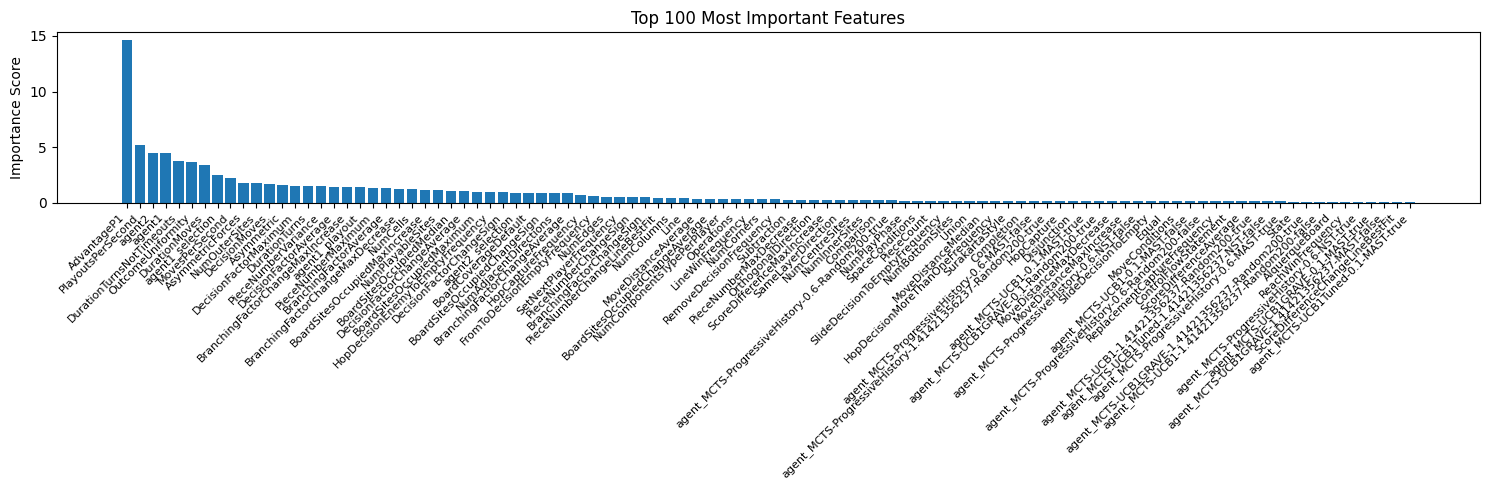

Fold 2 - RMSE: 0.3958133809974048
Fold 3


0:	learn: 0.6197212	test: 0.6134954	best: 0.6134954 (0)	total: 93.7ms	remaining: 15m 37s


50:	learn: 0.4872499	test: 0.5490244	best: 0.5490244 (50)	total: 4.64s	remaining: 15m 5s


100:	learn: 0.4429780	test: 0.5176915	best: 0.5176915 (100)	total: 9.23s	remaining: 15m 4s


150:	learn: 0.4168450	test: 0.4999817	best: 0.4999817 (150)	total: 13.9s	remaining: 15m 8s


200:	learn: 0.3994722	test: 0.4869659	best: 0.4869659 (200)	total: 18.8s	remaining: 15m 14s


250:	learn: 0.3873149	test: 0.4786962	best: 0.4786962 (250)	total: 23.8s	remaining: 15m 23s


300:	learn: 0.3779194	test: 0.4719856	best: 0.4719856 (300)	total: 29s	remaining: 15m 34s


350:	learn: 0.3702148	test: 0.4662323	best: 0.4662323 (350)	total: 34.1s	remaining: 15m 36s


400:	learn: 0.3634603	test: 0.4616175	best: 0.4616175 (400)	total: 39.1s	remaining: 15m 36s


450:	learn: 0.3569300	test: 0.4581572	best: 0.4581572 (450)	total: 44.1s	remaining: 15m 32s


500:	learn: 0.3510341	test: 0.4551247	best: 0.4551247 (500)	total: 48.9s	remaining: 15m 26s


550:	learn: 0.3458724	test: 0.4524091	best: 0.4524091 (550)	total: 53.7s	remaining: 15m 21s


600:	learn: 0.3413984	test: 0.4503134	best: 0.4503134 (600)	total: 58.6s	remaining: 15m 16s


650:	learn: 0.3376439	test: 0.4484195	best: 0.4484195 (650)	total: 1m 3s	remaining: 15m 12s


700:	learn: 0.3341435	test: 0.4467177	best: 0.4467177 (700)	total: 1m 8s	remaining: 15m 9s


750:	learn: 0.3306586	test: 0.4449148	best: 0.4449148 (750)	total: 1m 13s	remaining: 15m 3s


800:	learn: 0.3278247	test: 0.4437877	best: 0.4437877 (800)	total: 1m 18s	remaining: 14m 59s


850:	learn: 0.3246524	test: 0.4424367	best: 0.4424367 (850)	total: 1m 23s	remaining: 14m 54s


900:	learn: 0.3220565	test: 0.4412907	best: 0.4412907 (900)	total: 1m 28s	remaining: 14m 50s


950:	learn: 0.3194553	test: 0.4403021	best: 0.4403021 (950)	total: 1m 33s	remaining: 14m 45s


1000:	learn: 0.3168900	test: 0.4393344	best: 0.4393344 (1000)	total: 1m 37s	remaining: 14m 40s


1050:	learn: 0.3144438	test: 0.4385420	best: 0.4385420 (1050)	total: 1m 42s	remaining: 14m 36s


1100:	learn: 0.3120416	test: 0.4377167	best: 0.4377167 (1100)	total: 1m 48s	remaining: 14m 33s


1150:	learn: 0.3099537	test: 0.4371131	best: 0.4371131 (1150)	total: 1m 53s	remaining: 14m 28s


1200:	learn: 0.3078063	test: 0.4365388	best: 0.4365388 (1200)	total: 1m 58s	remaining: 14m 25s


1250:	learn: 0.3059054	test: 0.4360137	best: 0.4360137 (1250)	total: 2m 3s	remaining: 14m 21s


1300:	learn: 0.3040222	test: 0.4354996	best: 0.4354996 (1300)	total: 2m 8s	remaining: 14m 16s


1350:	learn: 0.3022636	test: 0.4351814	best: 0.4351814 (1350)	total: 2m 13s	remaining: 14m 11s


1400:	learn: 0.3005902	test: 0.4346329	best: 0.4346285 (1399)	total: 2m 18s	remaining: 14m 8s


1450:	learn: 0.2988930	test: 0.4340778	best: 0.4340778 (1450)	total: 2m 23s	remaining: 14m 3s


1500:	learn: 0.2973724	test: 0.4336182	best: 0.4336182 (1500)	total: 2m 28s	remaining: 13m 59s


1550:	learn: 0.2956071	test: 0.4331596	best: 0.4331596 (1550)	total: 2m 33s	remaining: 13m 54s


1600:	learn: 0.2941639	test: 0.4328798	best: 0.4328770 (1599)	total: 2m 37s	remaining: 13m 48s


1650:	learn: 0.2927235	test: 0.4324356	best: 0.4324313 (1649)	total: 2m 43s	remaining: 13m 44s


1700:	learn: 0.2912158	test: 0.4320594	best: 0.4320594 (1700)	total: 2m 48s	remaining: 13m 40s


1750:	learn: 0.2898524	test: 0.4317131	best: 0.4317131 (1750)	total: 2m 53s	remaining: 13m 36s


1800:	learn: 0.2885743	test: 0.4313290	best: 0.4313290 (1800)	total: 2m 58s	remaining: 13m 33s


1850:	learn: 0.2871926	test: 0.4309688	best: 0.4309688 (1850)	total: 3m 3s	remaining: 13m 28s


1900:	learn: 0.2858806	test: 0.4305092	best: 0.4305092 (1900)	total: 3m 8s	remaining: 13m 24s


1950:	learn: 0.2846222	test: 0.4302365	best: 0.4302365 (1950)	total: 3m 14s	remaining: 13m 20s


2000:	learn: 0.2834524	test: 0.4300509	best: 0.4300509 (2000)	total: 3m 19s	remaining: 13m 15s


2050:	learn: 0.2822347	test: 0.4297234	best: 0.4297234 (2050)	total: 3m 24s	remaining: 13m 11s


2100:	learn: 0.2811491	test: 0.4295233	best: 0.4295233 (2100)	total: 3m 29s	remaining: 13m 6s


2150:	learn: 0.2799322	test: 0.4292794	best: 0.4292794 (2150)	total: 3m 34s	remaining: 13m 1s


2200:	learn: 0.2788910	test: 0.4289877	best: 0.4289873 (2199)	total: 3m 39s	remaining: 12m 56s


2250:	learn: 0.2777924	test: 0.4287554	best: 0.4287553 (2249)	total: 3m 44s	remaining: 12m 52s


2300:	learn: 0.2766990	test: 0.4285619	best: 0.4285618 (2299)	total: 3m 49s	remaining: 12m 47s


2350:	learn: 0.2756231	test: 0.4283183	best: 0.4283183 (2350)	total: 3m 54s	remaining: 12m 42s


2400:	learn: 0.2745916	test: 0.4280430	best: 0.4280430 (2400)	total: 3m 59s	remaining: 12m 37s


2450:	learn: 0.2736358	test: 0.4278286	best: 0.4278286 (2450)	total: 4m 4s	remaining: 12m 32s


2500:	learn: 0.2727467	test: 0.4276237	best: 0.4276237 (2500)	total: 4m 9s	remaining: 12m 28s


2550:	learn: 0.2717519	test: 0.4274560	best: 0.4274560 (2550)	total: 4m 14s	remaining: 12m 23s


2600:	learn: 0.2707945	test: 0.4273328	best: 0.4273328 (2600)	total: 4m 19s	remaining: 12m 18s


2650:	learn: 0.2699466	test: 0.4272106	best: 0.4272106 (2650)	total: 4m 24s	remaining: 12m 13s


2700:	learn: 0.2690076	test: 0.4270004	best: 0.4270004 (2700)	total: 4m 29s	remaining: 12m 8s


2750:	learn: 0.2680591	test: 0.4267927	best: 0.4267927 (2750)	total: 4m 34s	remaining: 12m 3s


2800:	learn: 0.2672049	test: 0.4266135	best: 0.4266135 (2800)	total: 4m 39s	remaining: 11m 58s


2850:	learn: 0.2663802	test: 0.4264459	best: 0.4264459 (2850)	total: 4m 44s	remaining: 11m 54s


2900:	learn: 0.2656260	test: 0.4263289	best: 0.4263289 (2900)	total: 4m 50s	remaining: 11m 50s


2950:	learn: 0.2647624	test: 0.4261562	best: 0.4261562 (2950)	total: 4m 55s	remaining: 11m 45s


3000:	learn: 0.2639704	test: 0.4260479	best: 0.4260465 (2999)	total: 5m	remaining: 11m 40s


3050:	learn: 0.2632237	test: 0.4259294	best: 0.4259233 (3046)	total: 5m 5s	remaining: 11m 35s


3100:	learn: 0.2624015	test: 0.4257867	best: 0.4257859 (3099)	total: 5m 10s	remaining: 11m 31s


3150:	learn: 0.2616733	test: 0.4256144	best: 0.4256144 (3150)	total: 5m 15s	remaining: 11m 26s


3200:	learn: 0.2609172	test: 0.4254675	best: 0.4254675 (3200)	total: 5m 21s	remaining: 11m 21s


3250:	learn: 0.2601945	test: 0.4253291	best: 0.4253277 (3249)	total: 5m 26s	remaining: 11m 17s


3300:	learn: 0.2594872	test: 0.4252469	best: 0.4252338 (3288)	total: 5m 31s	remaining: 11m 12s


3350:	learn: 0.2587619	test: 0.4251404	best: 0.4251386 (3347)	total: 5m 36s	remaining: 11m 7s


3400:	learn: 0.2580518	test: 0.4250010	best: 0.4250010 (3400)	total: 5m 41s	remaining: 11m 2s


3450:	learn: 0.2573369	test: 0.4249050	best: 0.4249042 (3437)	total: 5m 46s	remaining: 10m 58s


3500:	learn: 0.2566582	test: 0.4247796	best: 0.4247796 (3500)	total: 5m 52s	remaining: 10m 53s


3550:	learn: 0.2560154	test: 0.4246743	best: 0.4246741 (3549)	total: 5m 57s	remaining: 10m 48s


3600:	learn: 0.2553176	test: 0.4246182	best: 0.4246109 (3584)	total: 6m 2s	remaining: 10m 44s


3650:	learn: 0.2546862	test: 0.4245191	best: 0.4245191 (3650)	total: 6m 7s	remaining: 10m 39s


3700:	learn: 0.2540247	test: 0.4244400	best: 0.4244351 (3699)	total: 6m 12s	remaining: 10m 34s


3750:	learn: 0.2533989	test: 0.4243002	best: 0.4243002 (3750)	total: 6m 17s	remaining: 10m 29s


3800:	learn: 0.2527351	test: 0.4242078	best: 0.4242078 (3800)	total: 6m 23s	remaining: 10m 24s


3850:	learn: 0.2521361	test: 0.4241008	best: 0.4241008 (3850)	total: 6m 28s	remaining: 10m 20s


3900:	learn: 0.2515214	test: 0.4240277	best: 0.4240211 (3899)	total: 6m 33s	remaining: 10m 15s


3950:	learn: 0.2509129	test: 0.4239475	best: 0.4239415 (3947)	total: 6m 38s	remaining: 10m 10s


4000:	learn: 0.2503196	test: 0.4238872	best: 0.4238872 (4000)	total: 6m 44s	remaining: 10m 5s


4050:	learn: 0.2497127	test: 0.4237997	best: 0.4237994 (4049)	total: 6m 49s	remaining: 10m


4100:	learn: 0.2490577	test: 0.4237119	best: 0.4237119 (4100)	total: 6m 54s	remaining: 9m 56s


4150:	learn: 0.2485183	test: 0.4236578	best: 0.4236570 (4149)	total: 6m 59s	remaining: 9m 51s


4200:	learn: 0.2478959	test: 0.4235906	best: 0.4235906 (4200)	total: 7m 4s	remaining: 9m 46s


4250:	learn: 0.2472941	test: 0.4234878	best: 0.4234878 (4250)	total: 7m 9s	remaining: 9m 41s


4300:	learn: 0.2467426	test: 0.4233869	best: 0.4233857 (4299)	total: 7m 15s	remaining: 9m 36s


4350:	learn: 0.2462115	test: 0.4233020	best: 0.4233020 (4350)	total: 7m 20s	remaining: 9m 31s


4400:	learn: 0.2456306	test: 0.4232221	best: 0.4232198 (4398)	total: 7m 25s	remaining: 9m 26s


4450:	learn: 0.2450817	test: 0.4231625	best: 0.4231625 (4450)	total: 7m 30s	remaining: 9m 21s


4500:	learn: 0.2445295	test: 0.4231067	best: 0.4231067 (4500)	total: 7m 36s	remaining: 9m 17s


4550:	learn: 0.2439696	test: 0.4230484	best: 0.4230478 (4549)	total: 7m 41s	remaining: 9m 12s


4600:	learn: 0.2434734	test: 0.4229860	best: 0.4229860 (4600)	total: 7m 46s	remaining: 9m 7s


4650:	learn: 0.2429569	test: 0.4228994	best: 0.4228994 (4650)	total: 7m 52s	remaining: 9m 2s


4700:	learn: 0.2424276	test: 0.4228353	best: 0.4228353 (4700)	total: 7m 57s	remaining: 8m 58s


4750:	learn: 0.2419045	test: 0.4227546	best: 0.4227546 (4750)	total: 8m 2s	remaining: 8m 53s


4800:	learn: 0.2413765	test: 0.4227177	best: 0.4227129 (4799)	total: 8m 8s	remaining: 8m 48s


4850:	learn: 0.2408925	test: 0.4226431	best: 0.4226431 (4850)	total: 8m 13s	remaining: 8m 44s


4900:	learn: 0.2403407	test: 0.4225972	best: 0.4225922 (4896)	total: 8m 19s	remaining: 8m 39s


4950:	learn: 0.2398058	test: 0.4225296	best: 0.4225296 (4950)	total: 8m 25s	remaining: 8m 35s


5000:	learn: 0.2393339	test: 0.4224663	best: 0.4224661 (4999)	total: 8m 30s	remaining: 8m 30s


5050:	learn: 0.2388716	test: 0.4224230	best: 0.4224191 (5041)	total: 8m 36s	remaining: 8m 25s


5100:	learn: 0.2383715	test: 0.4223353	best: 0.4223340 (5099)	total: 8m 41s	remaining: 8m 20s


5150:	learn: 0.2379245	test: 0.4222737	best: 0.4222737 (5150)	total: 8m 46s	remaining: 8m 15s


5200:	learn: 0.2374552	test: 0.4222063	best: 0.4222063 (5200)	total: 8m 52s	remaining: 8m 11s


5250:	learn: 0.2369942	test: 0.4221678	best: 0.4221624 (5246)	total: 8m 57s	remaining: 8m 6s


5300:	learn: 0.2365288	test: 0.4221145	best: 0.4221145 (5300)	total: 9m 2s	remaining: 8m 1s


5350:	learn: 0.2360769	test: 0.4220614	best: 0.4220583 (5342)	total: 9m 7s	remaining: 7m 56s


5400:	learn: 0.2355916	test: 0.4220093	best: 0.4220085 (5399)	total: 9m 13s	remaining: 7m 51s


5450:	learn: 0.2351334	test: 0.4219468	best: 0.4219462 (5446)	total: 9m 18s	remaining: 7m 45s


5500:	learn: 0.2346794	test: 0.4219079	best: 0.4219079 (5500)	total: 9m 23s	remaining: 7m 40s


5550:	learn: 0.2341977	test: 0.4218734	best: 0.4218730 (5549)	total: 9m 29s	remaining: 7m 36s


5600:	learn: 0.2337508	test: 0.4217955	best: 0.4217954 (5598)	total: 9m 34s	remaining: 7m 31s


5650:	learn: 0.2333151	test: 0.4217590	best: 0.4217590 (5650)	total: 9m 39s	remaining: 7m 26s


5700:	learn: 0.2329271	test: 0.4217419	best: 0.4217369 (5697)	total: 9m 45s	remaining: 7m 21s


5750:	learn: 0.2325093	test: 0.4217308	best: 0.4217127 (5735)	total: 9m 50s	remaining: 7m 16s


5800:	learn: 0.2320824	test: 0.4216805	best: 0.4216786 (5799)	total: 9m 56s	remaining: 7m 11s


5850:	learn: 0.2316523	test: 0.4216490	best: 0.4216482 (5849)	total: 10m 1s	remaining: 7m 6s


5900:	learn: 0.2312471	test: 0.4216181	best: 0.4216167 (5899)	total: 10m 6s	remaining: 7m 1s


5950:	learn: 0.2308363	test: 0.4215925	best: 0.4215925 (5950)	total: 10m 11s	remaining: 6m 56s


6000:	learn: 0.2304351	test: 0.4215470	best: 0.4215470 (6000)	total: 10m 17s	remaining: 6m 51s


6050:	learn: 0.2299989	test: 0.4215126	best: 0.4215126 (6050)	total: 10m 22s	remaining: 6m 46s


6100:	learn: 0.2295401	test: 0.4214402	best: 0.4214398 (6099)	total: 10m 27s	remaining: 6m 41s


6150:	learn: 0.2291365	test: 0.4213910	best: 0.4213907 (6149)	total: 10m 32s	remaining: 6m 35s


6200:	learn: 0.2287373	test: 0.4213337	best: 0.4213337 (6200)	total: 10m 37s	remaining: 6m 30s


6250:	learn: 0.2283230	test: 0.4212874	best: 0.4212859 (6248)	total: 10m 43s	remaining: 6m 25s


6300:	learn: 0.2279214	test: 0.4212642	best: 0.4212621 (6299)	total: 10m 48s	remaining: 6m 20s


6350:	learn: 0.2275351	test: 0.4212232	best: 0.4212154 (6337)	total: 10m 53s	remaining: 6m 15s


6400:	learn: 0.2271519	test: 0.4211757	best: 0.4211757 (6400)	total: 10m 58s	remaining: 6m 10s


6450:	learn: 0.2267751	test: 0.4211424	best: 0.4211424 (6450)	total: 11m 3s	remaining: 6m 5s


6500:	learn: 0.2263658	test: 0.4211003	best: 0.4211003 (6500)	total: 11m 9s	remaining: 6m


6550:	learn: 0.2259878	test: 0.4210744	best: 0.4210744 (6550)	total: 11m 14s	remaining: 5m 55s


6600:	learn: 0.2255871	test: 0.4210235	best: 0.4210235 (6600)	total: 11m 19s	remaining: 5m 50s


6650:	learn: 0.2252200	test: 0.4209841	best: 0.4209841 (6650)	total: 11m 25s	remaining: 5m 45s


6700:	learn: 0.2248250	test: 0.4209367	best: 0.4209367 (6700)	total: 11m 30s	remaining: 5m 39s


6750:	learn: 0.2244680	test: 0.4208739	best: 0.4208739 (6750)	total: 11m 35s	remaining: 5m 34s


6800:	learn: 0.2240547	test: 0.4208372	best: 0.4208369 (6799)	total: 11m 41s	remaining: 5m 29s


6850:	learn: 0.2236854	test: 0.4208290	best: 0.4208272 (6849)	total: 11m 46s	remaining: 5m 24s


6900:	learn: 0.2232961	test: 0.4208035	best: 0.4208009 (6890)	total: 11m 51s	remaining: 5m 19s


6950:	learn: 0.2229568	test: 0.4207705	best: 0.4207705 (6950)	total: 11m 57s	remaining: 5m 14s


7000:	learn: 0.2225676	test: 0.4207275	best: 0.4207263 (6991)	total: 12m 2s	remaining: 5m 9s


7050:	learn: 0.2222490	test: 0.4206951	best: 0.4206951 (7050)	total: 12m 7s	remaining: 5m 4s


7100:	learn: 0.2218952	test: 0.4206753	best: 0.4206735 (7098)	total: 12m 13s	remaining: 4m 59s


7150:	learn: 0.2215472	test: 0.4206295	best: 0.4206295 (7150)	total: 12m 18s	remaining: 4m 54s


7200:	learn: 0.2211665	test: 0.4206123	best: 0.4206074 (7190)	total: 12m 23s	remaining: 4m 49s


7250:	learn: 0.2208109	test: 0.4205894	best: 0.4205893 (7245)	total: 12m 29s	remaining: 4m 43s


7300:	learn: 0.2204263	test: 0.4205576	best: 0.4205576 (7300)	total: 12m 34s	remaining: 4m 38s


7350:	learn: 0.2200818	test: 0.4205351	best: 0.4205272 (7331)	total: 12m 39s	remaining: 4m 33s


7400:	learn: 0.2197532	test: 0.4205186	best: 0.4205166 (7395)	total: 12m 44s	remaining: 4m 28s


7450:	learn: 0.2193950	test: 0.4204995	best: 0.4204981 (7448)	total: 12m 49s	remaining: 4m 23s


7500:	learn: 0.2190477	test: 0.4204745	best: 0.4204743 (7496)	total: 12m 55s	remaining: 4m 18s


7550:	learn: 0.2187143	test: 0.4204354	best: 0.4204354 (7550)	total: 13m	remaining: 4m 13s


7600:	learn: 0.2183887	test: 0.4204137	best: 0.4204137 (7600)	total: 13m 5s	remaining: 4m 8s


7650:	learn: 0.2180288	test: 0.4203828	best: 0.4203828 (7650)	total: 13m 11s	remaining: 4m 2s


7700:	learn: 0.2177127	test: 0.4203641	best: 0.4203614 (7684)	total: 13m 16s	remaining: 3m 57s


7750:	learn: 0.2173729	test: 0.4203453	best: 0.4203453 (7750)	total: 13m 21s	remaining: 3m 52s


7800:	learn: 0.2170372	test: 0.4203268	best: 0.4203243 (7784)	total: 13m 27s	remaining: 3m 47s


7850:	learn: 0.2166968	test: 0.4203076	best: 0.4203049 (7846)	total: 13m 32s	remaining: 3m 42s


7900:	learn: 0.2163477	test: 0.4202655	best: 0.4202655 (7900)	total: 13m 37s	remaining: 3m 37s


7950:	learn: 0.2159776	test: 0.4202492	best: 0.4202492 (7950)	total: 13m 42s	remaining: 3m 31s


8000:	learn: 0.2156528	test: 0.4202052	best: 0.4202023 (7998)	total: 13m 47s	remaining: 3m 26s


8050:	learn: 0.2153207	test: 0.4201867	best: 0.4201863 (8048)	total: 13m 52s	remaining: 3m 21s


8100:	learn: 0.2149889	test: 0.4201758	best: 0.4201758 (8100)	total: 13m 57s	remaining: 3m 16s


8150:	learn: 0.2146830	test: 0.4201510	best: 0.4201510 (8150)	total: 14m 3s	remaining: 3m 11s


8200:	learn: 0.2143285	test: 0.4201204	best: 0.4201139 (8189)	total: 14m 8s	remaining: 3m 6s


8250:	learn: 0.2140093	test: 0.4200767	best: 0.4200763 (8248)	total: 14m 13s	remaining: 3m


8300:	learn: 0.2136662	test: 0.4200452	best: 0.4200428 (8293)	total: 14m 18s	remaining: 2m 55s


8350:	learn: 0.2133316	test: 0.4200143	best: 0.4200143 (8350)	total: 14m 23s	remaining: 2m 50s


8400:	learn: 0.2129832	test: 0.4199989	best: 0.4199988 (8399)	total: 14m 28s	remaining: 2m 45s


8450:	learn: 0.2126698	test: 0.4199826	best: 0.4199817 (8448)	total: 14m 33s	remaining: 2m 40s


8500:	learn: 0.2123596	test: 0.4199590	best: 0.4199580 (8492)	total: 14m 38s	remaining: 2m 34s


8550:	learn: 0.2120424	test: 0.4199103	best: 0.4199078 (8548)	total: 14m 44s	remaining: 2m 29s


8600:	learn: 0.2117341	test: 0.4198827	best: 0.4198827 (8600)	total: 14m 49s	remaining: 2m 24s


8650:	learn: 0.2114392	test: 0.4198542	best: 0.4198542 (8650)	total: 14m 54s	remaining: 2m 19s


8700:	learn: 0.2111310	test: 0.4198350	best: 0.4198347 (8695)	total: 14m 59s	remaining: 2m 14s


8750:	learn: 0.2108087	test: 0.4198146	best: 0.4198146 (8750)	total: 15m 4s	remaining: 2m 9s


8800:	learn: 0.2105015	test: 0.4197960	best: 0.4197960 (8800)	total: 15m 9s	remaining: 2m 3s


8850:	learn: 0.2102204	test: 0.4197926	best: 0.4197876 (8828)	total: 15m 15s	remaining: 1m 58s


8900:	learn: 0.2099217	test: 0.4197708	best: 0.4197596 (8897)	total: 15m 20s	remaining: 1m 53s


8950:	learn: 0.2095988	test: 0.4197233	best: 0.4197192 (8945)	total: 15m 25s	remaining: 1m 48s


9000:	learn: 0.2092765	test: 0.4197115	best: 0.4197115 (9000)	total: 15m 30s	remaining: 1m 43s


9050:	learn: 0.2090039	test: 0.4196715	best: 0.4196715 (9050)	total: 15m 35s	remaining: 1m 38s


9100:	learn: 0.2086735	test: 0.4196581	best: 0.4196571 (9099)	total: 15m 40s	remaining: 1m 32s


9150:	learn: 0.2083845	test: 0.4196373	best: 0.4196353 (9147)	total: 15m 46s	remaining: 1m 27s


9200:	learn: 0.2080564	test: 0.4196126	best: 0.4196126 (9200)	total: 15m 51s	remaining: 1m 22s


9250:	learn: 0.2077499	test: 0.4195936	best: 0.4195936 (9250)	total: 15m 56s	remaining: 1m 17s


9300:	learn: 0.2074474	test: 0.4195671	best: 0.4195671 (9300)	total: 16m 1s	remaining: 1m 12s


9350:	learn: 0.2071449	test: 0.4195507	best: 0.4195481 (9345)	total: 16m 6s	remaining: 1m 7s


9400:	learn: 0.2068467	test: 0.4195252	best: 0.4195242 (9397)	total: 16m 11s	remaining: 1m 1s


9450:	learn: 0.2065323	test: 0.4194925	best: 0.4194922 (9429)	total: 16m 16s	remaining: 56.7s


9500:	learn: 0.2062117	test: 0.4194565	best: 0.4194559 (9498)	total: 16m 21s	remaining: 51.6s


9550:	learn: 0.2059451	test: 0.4194445	best: 0.4194444 (9549)	total: 16m 26s	remaining: 46.4s


9600:	learn: 0.2056748	test: 0.4194139	best: 0.4194138 (9599)	total: 16m 32s	remaining: 41.2s


9650:	learn: 0.2053928	test: 0.4193885	best: 0.4193877 (9649)	total: 16m 37s	remaining: 36.1s


9700:	learn: 0.2051054	test: 0.4193747	best: 0.4193671 (9686)	total: 16m 42s	remaining: 30.9s


9750:	learn: 0.2048305	test: 0.4193364	best: 0.4193349 (9749)	total: 16m 47s	remaining: 25.7s


9800:	learn: 0.2045506	test: 0.4193151	best: 0.4193151 (9800)	total: 16m 52s	remaining: 20.6s


9850:	learn: 0.2042524	test: 0.4193041	best: 0.4193028 (9849)	total: 16m 57s	remaining: 15.4s


9900:	learn: 0.2039791	test: 0.4192777	best: 0.4192777 (9900)	total: 17m 3s	remaining: 10.2s


9950:	learn: 0.2036880	test: 0.4192437	best: 0.4192428 (9941)	total: 17m 8s	remaining: 5.06s


9999:	learn: 0.2033855	test: 0.4192344	best: 0.4192333 (9996)	total: 17m 13s	remaining: 0us

bestTest = 0.4192333416
bestIteration = 9996

Shrink model to first 9997 iterations.


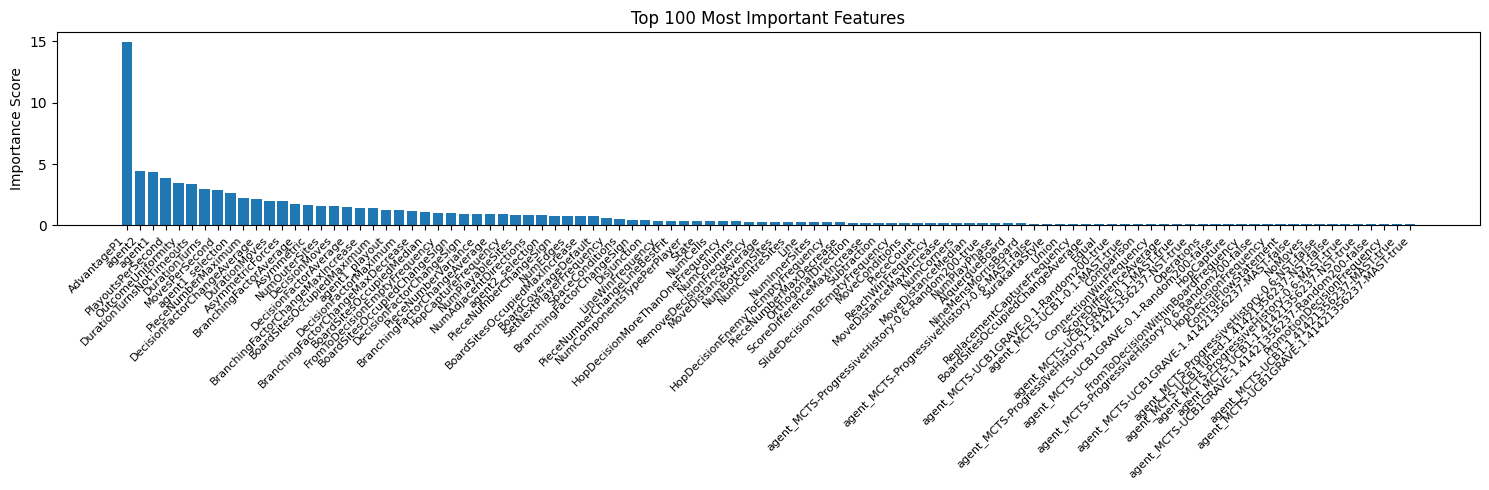

Fold 3 - RMSE: 0.4187233522608535
Fold 4


0:	learn: 0.6212909	test: 0.6059530	best: 0.6059530 (0)	total: 93ms	remaining: 15m 29s


50:	learn: 0.4913447	test: 0.5423935	best: 0.5423935 (50)	total: 4.46s	remaining: 14m 30s


100:	learn: 0.4484487	test: 0.5160711	best: 0.5160711 (100)	total: 8.88s	remaining: 14m 30s


150:	learn: 0.4236993	test: 0.4974354	best: 0.4974354 (150)	total: 13.5s	remaining: 14m 40s


200:	learn: 0.4073463	test: 0.4858595	best: 0.4858595 (200)	total: 18.5s	remaining: 15m


250:	learn: 0.3953954	test: 0.4782797	best: 0.4782797 (250)	total: 23.5s	remaining: 15m 13s


300:	learn: 0.3860463	test: 0.4722226	best: 0.4722226 (300)	total: 28.6s	remaining: 15m 21s


350:	learn: 0.3781133	test: 0.4672566	best: 0.4672566 (350)	total: 33.8s	remaining: 15m 27s


400:	learn: 0.3712033	test: 0.4636760	best: 0.4636760 (400)	total: 38.8s	remaining: 15m 29s


450:	learn: 0.3643697	test: 0.4600637	best: 0.4600637 (450)	total: 43.7s	remaining: 15m 24s


500:	learn: 0.3589860	test: 0.4575575	best: 0.4575575 (500)	total: 48.6s	remaining: 15m 20s


550:	learn: 0.3541305	test: 0.4557035	best: 0.4557035 (550)	total: 53.6s	remaining: 15m 18s


600:	learn: 0.3497168	test: 0.4541081	best: 0.4541081 (600)	total: 58.6s	remaining: 15m 15s


650:	learn: 0.3457438	test: 0.4525956	best: 0.4525956 (650)	total: 1m 3s	remaining: 15m 11s


700:	learn: 0.3419249	test: 0.4513940	best: 0.4513940 (700)	total: 1m 8s	remaining: 15m 8s


750:	learn: 0.3387076	test: 0.4502302	best: 0.4502285 (749)	total: 1m 13s	remaining: 15m 3s


800:	learn: 0.3358421	test: 0.4494902	best: 0.4494803 (799)	total: 1m 18s	remaining: 14m 59s


850:	learn: 0.3329135	test: 0.4486318	best: 0.4486318 (850)	total: 1m 23s	remaining: 14m 55s


900:	learn: 0.3299924	test: 0.4477822	best: 0.4477822 (900)	total: 1m 28s	remaining: 14m 51s


950:	learn: 0.3274201	test: 0.4469380	best: 0.4469360 (949)	total: 1m 33s	remaining: 14m 47s


1000:	learn: 0.3250647	test: 0.4463490	best: 0.4463490 (1000)	total: 1m 38s	remaining: 14m 44s


1050:	learn: 0.3227648	test: 0.4458372	best: 0.4458372 (1050)	total: 1m 43s	remaining: 14m 40s


1100:	learn: 0.3204230	test: 0.4452346	best: 0.4452346 (1100)	total: 1m 48s	remaining: 14m 35s


1150:	learn: 0.3182596	test: 0.4445805	best: 0.4445805 (1150)	total: 1m 53s	remaining: 14m 32s


1200:	learn: 0.3159620	test: 0.4440823	best: 0.4440782 (1199)	total: 1m 58s	remaining: 14m 28s


1250:	learn: 0.3138993	test: 0.4435302	best: 0.4435302 (1250)	total: 2m 3s	remaining: 14m 23s


1300:	learn: 0.3118243	test: 0.4430159	best: 0.4430159 (1300)	total: 2m 8s	remaining: 14m 18s


1350:	learn: 0.3099802	test: 0.4426525	best: 0.4426525 (1350)	total: 2m 13s	remaining: 14m 13s


1400:	learn: 0.3079696	test: 0.4419276	best: 0.4419276 (1400)	total: 2m 18s	remaining: 14m 8s


1450:	learn: 0.3060550	test: 0.4413840	best: 0.4413840 (1450)	total: 2m 23s	remaining: 14m 3s


1500:	learn: 0.3043736	test: 0.4408819	best: 0.4408819 (1500)	total: 2m 28s	remaining: 13m 58s


1550:	learn: 0.3028402	test: 0.4404852	best: 0.4404852 (1550)	total: 2m 33s	remaining: 13m 55s


1600:	learn: 0.3011428	test: 0.4401666	best: 0.4401436 (1597)	total: 2m 38s	remaining: 13m 49s


1650:	learn: 0.2995565	test: 0.4398660	best: 0.4398445 (1644)	total: 2m 43s	remaining: 13m 45s


1700:	learn: 0.2980841	test: 0.4394318	best: 0.4394318 (1700)	total: 2m 48s	remaining: 13m 39s


1750:	learn: 0.2966703	test: 0.4390200	best: 0.4390200 (1750)	total: 2m 53s	remaining: 13m 35s


1800:	learn: 0.2953911	test: 0.4386798	best: 0.4386796 (1799)	total: 2m 58s	remaining: 13m 30s


1850:	learn: 0.2940466	test: 0.4383930	best: 0.4383890 (1848)	total: 3m 3s	remaining: 13m 26s


1900:	learn: 0.2927977	test: 0.4381340	best: 0.4381340 (1900)	total: 3m 8s	remaining: 13m 21s


1950:	learn: 0.2914430	test: 0.4378665	best: 0.4378665 (1950)	total: 3m 13s	remaining: 13m 17s


2000:	learn: 0.2901818	test: 0.4376239	best: 0.4376239 (2000)	total: 3m 18s	remaining: 13m 12s


2050:	learn: 0.2890349	test: 0.4372530	best: 0.4372530 (2050)	total: 3m 23s	remaining: 13m 7s


2100:	learn: 0.2878118	test: 0.4369288	best: 0.4369288 (2100)	total: 3m 28s	remaining: 13m 3s


2150:	learn: 0.2866437	test: 0.4367341	best: 0.4367341 (2150)	total: 3m 33s	remaining: 12m 59s


2200:	learn: 0.2855114	test: 0.4365123	best: 0.4365123 (2200)	total: 3m 38s	remaining: 12m 54s


2250:	learn: 0.2843923	test: 0.4363286	best: 0.4363286 (2250)	total: 3m 43s	remaining: 12m 49s


2300:	learn: 0.2833569	test: 0.4362926	best: 0.4362903 (2299)	total: 3m 48s	remaining: 12m 45s


2350:	learn: 0.2823143	test: 0.4360980	best: 0.4360980 (2350)	total: 3m 53s	remaining: 12m 40s


2400:	learn: 0.2812987	test: 0.4358821	best: 0.4358821 (2400)	total: 3m 58s	remaining: 12m 35s


2450:	learn: 0.2803024	test: 0.4357139	best: 0.4357139 (2450)	total: 4m 3s	remaining: 12m 31s


2500:	learn: 0.2792942	test: 0.4355272	best: 0.4355272 (2500)	total: 4m 9s	remaining: 12m 26s


2550:	learn: 0.2782674	test: 0.4353311	best: 0.4353311 (2550)	total: 4m 14s	remaining: 12m 22s


2600:	learn: 0.2773803	test: 0.4352030	best: 0.4351981 (2597)	total: 4m 19s	remaining: 12m 18s


2650:	learn: 0.2764723	test: 0.4350345	best: 0.4350345 (2650)	total: 4m 24s	remaining: 12m 13s


2700:	learn: 0.2755748	test: 0.4349076	best: 0.4349051 (2697)	total: 4m 29s	remaining: 12m 8s


2750:	learn: 0.2747478	test: 0.4347251	best: 0.4347251 (2750)	total: 4m 34s	remaining: 12m 3s


2800:	learn: 0.2739573	test: 0.4345450	best: 0.4345450 (2800)	total: 4m 39s	remaining: 11m 59s


2850:	learn: 0.2730998	test: 0.4344344	best: 0.4344344 (2850)	total: 4m 44s	remaining: 11m 54s


2900:	learn: 0.2722525	test: 0.4342826	best: 0.4342826 (2900)	total: 4m 50s	remaining: 11m 49s


2950:	learn: 0.2713588	test: 0.4340861	best: 0.4340861 (2950)	total: 4m 55s	remaining: 11m 45s


3000:	learn: 0.2705285	test: 0.4339280	best: 0.4339280 (3000)	total: 5m	remaining: 11m 40s


3050:	learn: 0.2697083	test: 0.4338046	best: 0.4338046 (3050)	total: 5m 5s	remaining: 11m 35s


3100:	learn: 0.2688549	test: 0.4336947	best: 0.4336947 (3100)	total: 5m 10s	remaining: 11m 30s


3150:	learn: 0.2680662	test: 0.4335472	best: 0.4335429 (3143)	total: 5m 15s	remaining: 11m 25s


3200:	learn: 0.2672918	test: 0.4334474	best: 0.4334474 (3200)	total: 5m 20s	remaining: 11m 21s


3250:	learn: 0.2665104	test: 0.4333166	best: 0.4333166 (3250)	total: 5m 25s	remaining: 11m 16s


3300:	learn: 0.2657472	test: 0.4332243	best: 0.4332212 (3299)	total: 5m 30s	remaining: 11m 11s


3350:	learn: 0.2650762	test: 0.4331672	best: 0.4331644 (3348)	total: 5m 36s	remaining: 11m 6s


3400:	learn: 0.2643525	test: 0.4330577	best: 0.4330577 (3400)	total: 5m 41s	remaining: 11m 2s


3450:	learn: 0.2636169	test: 0.4329495	best: 0.4329495 (3450)	total: 5m 46s	remaining: 10m 58s


3500:	learn: 0.2628805	test: 0.4328050	best: 0.4328050 (3500)	total: 5m 52s	remaining: 10m 54s


3550:	learn: 0.2622133	test: 0.4327327	best: 0.4327291 (3546)	total: 5m 57s	remaining: 10m 50s


3600:	learn: 0.2614940	test: 0.4326617	best: 0.4326506 (3598)	total: 6m 3s	remaining: 10m 45s


3650:	learn: 0.2608155	test: 0.4325698	best: 0.4325587 (3647)	total: 6m 8s	remaining: 10m 41s


3700:	learn: 0.2601330	test: 0.4324758	best: 0.4324758 (3700)	total: 6m 14s	remaining: 10m 36s


3750:	learn: 0.2594496	test: 0.4324489	best: 0.4324192 (3738)	total: 6m 19s	remaining: 10m 31s


3800:	learn: 0.2587690	test: 0.4323703	best: 0.4323580 (3791)	total: 6m 24s	remaining: 10m 27s


3850:	learn: 0.2580765	test: 0.4322235	best: 0.4322210 (3848)	total: 6m 30s	remaining: 10m 22s


3900:	learn: 0.2574419	test: 0.4321679	best: 0.4321670 (3899)	total: 6m 35s	remaining: 10m 17s


3950:	learn: 0.2568246	test: 0.4321011	best: 0.4321006 (3949)	total: 6m 40s	remaining: 10m 12s


4000:	learn: 0.2561759	test: 0.4320387	best: 0.4320387 (4000)	total: 6m 46s	remaining: 10m 9s


4050:	learn: 0.2555442	test: 0.4319590	best: 0.4319483 (4044)	total: 6m 51s	remaining: 10m 4s


4100:	learn: 0.2549116	test: 0.4318955	best: 0.4318872 (4091)	total: 6m 56s	remaining: 9m 59s


4150:	learn: 0.2543202	test: 0.4318452	best: 0.4318305 (4135)	total: 7m 2s	remaining: 9m 55s


4200:	learn: 0.2537514	test: 0.4317747	best: 0.4317747 (4200)	total: 7m 7s	remaining: 9m 50s


4250:	learn: 0.2531725	test: 0.4316961	best: 0.4316957 (4246)	total: 7m 13s	remaining: 9m 45s


4300:	learn: 0.2525801	test: 0.4316092	best: 0.4316092 (4300)	total: 7m 18s	remaining: 9m 41s


4350:	learn: 0.2520247	test: 0.4315525	best: 0.4315488 (4338)	total: 7m 23s	remaining: 9m 36s


4400:	learn: 0.2514273	test: 0.4314933	best: 0.4314933 (4400)	total: 7m 29s	remaining: 9m 31s


4450:	learn: 0.2508713	test: 0.4314223	best: 0.4314211 (4445)	total: 7m 34s	remaining: 9m 26s


4500:	learn: 0.2502943	test: 0.4313604	best: 0.4313543 (4491)	total: 7m 40s	remaining: 9m 22s


4550:	learn: 0.2497516	test: 0.4313022	best: 0.4312978 (4548)	total: 7m 45s	remaining: 9m 17s


4600:	learn: 0.2491647	test: 0.4312485	best: 0.4312420 (4593)	total: 7m 51s	remaining: 9m 12s


4650:	learn: 0.2486644	test: 0.4312054	best: 0.4311987 (4647)	total: 7m 56s	remaining: 9m 8s


4700:	learn: 0.2481650	test: 0.4311677	best: 0.4311626 (4693)	total: 8m 1s	remaining: 9m 3s


4750:	learn: 0.2476759	test: 0.4311269	best: 0.4311269 (4750)	total: 8m 7s	remaining: 8m 58s


4800:	learn: 0.2471155	test: 0.4310539	best: 0.4310539 (4800)	total: 8m 12s	remaining: 8m 53s


4850:	learn: 0.2465735	test: 0.4309870	best: 0.4309840 (4844)	total: 8m 17s	remaining: 8m 48s


4900:	learn: 0.2460484	test: 0.4309342	best: 0.4309341 (4899)	total: 8m 23s	remaining: 8m 43s


4950:	learn: 0.2455098	test: 0.4308810	best: 0.4308777 (4947)	total: 8m 28s	remaining: 8m 38s


5000:	learn: 0.2450251	test: 0.4308686	best: 0.4308544 (4976)	total: 8m 33s	remaining: 8m 33s


5050:	learn: 0.2445758	test: 0.4308253	best: 0.4308220 (5047)	total: 8m 38s	remaining: 8m 28s


5100:	learn: 0.2440655	test: 0.4307706	best: 0.4307705 (5099)	total: 8m 43s	remaining: 8m 23s


5150:	learn: 0.2435807	test: 0.4307053	best: 0.4307053 (5150)	total: 8m 49s	remaining: 8m 18s


5200:	learn: 0.2430571	test: 0.4306599	best: 0.4306591 (5198)	total: 8m 54s	remaining: 8m 12s


5250:	learn: 0.2425649	test: 0.4306143	best: 0.4306108 (5239)	total: 8m 59s	remaining: 8m 7s


5300:	learn: 0.2420889	test: 0.4305635	best: 0.4305554 (5290)	total: 9m 4s	remaining: 8m 2s


5350:	learn: 0.2415991	test: 0.4305207	best: 0.4305013 (5333)	total: 9m 9s	remaining: 7m 57s


5400:	learn: 0.2411184	test: 0.4304421	best: 0.4304421 (5400)	total: 9m 14s	remaining: 7m 52s


5450:	learn: 0.2406945	test: 0.4304189	best: 0.4304137 (5449)	total: 9m 20s	remaining: 7m 47s


5500:	learn: 0.2402125	test: 0.4303835	best: 0.4303835 (5500)	total: 9m 25s	remaining: 7m 42s


5550:	learn: 0.2397368	test: 0.4303420	best: 0.4303420 (5550)	total: 9m 30s	remaining: 7m 37s


5600:	learn: 0.2392857	test: 0.4302344	best: 0.4302343 (5595)	total: 9m 36s	remaining: 7m 32s


5650:	learn: 0.2387863	test: 0.4301765	best: 0.4301765 (5650)	total: 9m 42s	remaining: 7m 27s


5700:	learn: 0.2383368	test: 0.4301333	best: 0.4301333 (5700)	total: 9m 47s	remaining: 7m 22s


5750:	learn: 0.2378928	test: 0.4301035	best: 0.4300970 (5744)	total: 9m 52s	remaining: 7m 17s


5800:	learn: 0.2374414	test: 0.4300489	best: 0.4300460 (5790)	total: 9m 57s	remaining: 7m 12s


5850:	learn: 0.2369937	test: 0.4300291	best: 0.4300278 (5848)	total: 10m 3s	remaining: 7m 7s


5900:	learn: 0.2365603	test: 0.4299633	best: 0.4299633 (5900)	total: 10m 8s	remaining: 7m 2s


5950:	learn: 0.2361510	test: 0.4299439	best: 0.4299373 (5931)	total: 10m 13s	remaining: 6m 57s


6000:	learn: 0.2356991	test: 0.4299363	best: 0.4299271 (5993)	total: 10m 18s	remaining: 6m 52s


6050:	learn: 0.2352659	test: 0.4298933	best: 0.4298909 (6048)	total: 10m 24s	remaining: 6m 47s


6100:	learn: 0.2348103	test: 0.4298332	best: 0.4298309 (6094)	total: 10m 29s	remaining: 6m 42s


6150:	learn: 0.2344111	test: 0.4297793	best: 0.4297793 (6150)	total: 10m 34s	remaining: 6m 37s


6200:	learn: 0.2339906	test: 0.4297678	best: 0.4297678 (6200)	total: 10m 39s	remaining: 6m 32s


6250:	learn: 0.2335364	test: 0.4297005	best: 0.4296999 (6247)	total: 10m 45s	remaining: 6m 26s


6300:	learn: 0.2331350	test: 0.4296554	best: 0.4296554 (6300)	total: 10m 50s	remaining: 6m 21s


6350:	learn: 0.2326957	test: 0.4296031	best: 0.4296031 (6350)	total: 10m 55s	remaining: 6m 16s


6400:	learn: 0.2323066	test: 0.4295663	best: 0.4295658 (6396)	total: 11m	remaining: 6m 11s


6450:	learn: 0.2318710	test: 0.4295227	best: 0.4295221 (6448)	total: 11m 5s	remaining: 6m 6s


6500:	learn: 0.2314695	test: 0.4295015	best: 0.4294976 (6495)	total: 11m 11s	remaining: 6m 1s


6550:	learn: 0.2310747	test: 0.4294417	best: 0.4294396 (6546)	total: 11m 16s	remaining: 5m 56s


6600:	learn: 0.2306754	test: 0.4294250	best: 0.4294250 (6600)	total: 11m 21s	remaining: 5m 51s


6650:	learn: 0.2302952	test: 0.4293975	best: 0.4293933 (6640)	total: 11m 27s	remaining: 5m 46s


6700:	learn: 0.2298844	test: 0.4293648	best: 0.4293648 (6700)	total: 11m 32s	remaining: 5m 40s


6750:	learn: 0.2295009	test: 0.4293356	best: 0.4293356 (6750)	total: 11m 37s	remaining: 5m 35s


6800:	learn: 0.2290757	test: 0.4293259	best: 0.4293157 (6784)	total: 11m 43s	remaining: 5m 30s


6850:	learn: 0.2286567	test: 0.4292615	best: 0.4292609 (6849)	total: 11m 48s	remaining: 5m 25s


6900:	learn: 0.2282547	test: 0.4292449	best: 0.4292417 (6888)	total: 11m 53s	remaining: 5m 20s


6950:	learn: 0.2278770	test: 0.4292271	best: 0.4292245 (6941)	total: 11m 58s	remaining: 5m 15s


7000:	learn: 0.2274841	test: 0.4291906	best: 0.4291906 (7000)	total: 12m 4s	remaining: 5m 10s


7050:	learn: 0.2271015	test: 0.4291583	best: 0.4291558 (7046)	total: 12m 9s	remaining: 5m 5s


7100:	learn: 0.2267076	test: 0.4291410	best: 0.4291410 (7100)	total: 12m 15s	remaining: 5m


7150:	learn: 0.2263090	test: 0.4290826	best: 0.4290788 (7149)	total: 12m 20s	remaining: 4m 55s


7200:	learn: 0.2259159	test: 0.4290405	best: 0.4290405 (7200)	total: 12m 25s	remaining: 4m 49s


7250:	learn: 0.2255699	test: 0.4290105	best: 0.4290105 (7250)	total: 12m 31s	remaining: 4m 44s


7300:	learn: 0.2252076	test: 0.4290110	best: 0.4290027 (7253)	total: 12m 37s	remaining: 4m 39s


7350:	learn: 0.2248393	test: 0.4289963	best: 0.4289958 (7347)	total: 12m 42s	remaining: 4m 34s


7400:	learn: 0.2244692	test: 0.4289766	best: 0.4289740 (7395)	total: 12m 47s	remaining: 4m 29s


7450:	learn: 0.2240852	test: 0.4289527	best: 0.4289479 (7445)	total: 12m 52s	remaining: 4m 24s


7500:	learn: 0.2237308	test: 0.4289473	best: 0.4289460 (7488)	total: 12m 58s	remaining: 4m 19s


7550:	learn: 0.2233709	test: 0.4289175	best: 0.4289167 (7539)	total: 13m 3s	remaining: 4m 14s


7600:	learn: 0.2230381	test: 0.4289026	best: 0.4288989 (7587)	total: 13m 8s	remaining: 4m 8s


7650:	learn: 0.2227019	test: 0.4288891	best: 0.4288888 (7649)	total: 13m 14s	remaining: 4m 3s


7700:	learn: 0.2223376	test: 0.4288697	best: 0.4288697 (7700)	total: 13m 19s	remaining: 3m 58s


7750:	learn: 0.2219934	test: 0.4288635	best: 0.4288603 (7715)	total: 13m 24s	remaining: 3m 53s


7800:	learn: 0.2216207	test: 0.4288431	best: 0.4288358 (7795)	total: 13m 29s	remaining: 3m 48s


7850:	learn: 0.2213045	test: 0.4288332	best: 0.4288332 (7850)	total: 13m 35s	remaining: 3m 43s


7900:	learn: 0.2209299	test: 0.4288277	best: 0.4288274 (7899)	total: 13m 40s	remaining: 3m 37s


7950:	learn: 0.2205758	test: 0.4287825	best: 0.4287811 (7948)	total: 13m 45s	remaining: 3m 32s


8000:	learn: 0.2202562	test: 0.4287376	best: 0.4287360 (7997)	total: 13m 51s	remaining: 3m 27s


8050:	learn: 0.2199106	test: 0.4287263	best: 0.4287228 (8020)	total: 13m 56s	remaining: 3m 22s


8100:	learn: 0.2195572	test: 0.4287077	best: 0.4287050 (8097)	total: 14m 1s	remaining: 3m 17s


8150:	learn: 0.2191953	test: 0.4286861	best: 0.4286861 (8150)	total: 14m 6s	remaining: 3m 12s


8200:	learn: 0.2188386	test: 0.4286735	best: 0.4286655 (8192)	total: 14m 12s	remaining: 3m 6s


8250:	learn: 0.2184713	test: 0.4286353	best: 0.4286273 (8241)	total: 14m 17s	remaining: 3m 1s


8300:	learn: 0.2181365	test: 0.4285777	best: 0.4285777 (8300)	total: 14m 22s	remaining: 2m 56s


8350:	learn: 0.2177868	test: 0.4285728	best: 0.4285704 (8340)	total: 14m 28s	remaining: 2m 51s


8400:	learn: 0.2174648	test: 0.4285567	best: 0.4285554 (8372)	total: 14m 33s	remaining: 2m 46s


8450:	learn: 0.2171499	test: 0.4285438	best: 0.4285438 (8450)	total: 14m 38s	remaining: 2m 41s


8500:	learn: 0.2168123	test: 0.4285145	best: 0.4285145 (8500)	total: 14m 44s	remaining: 2m 35s


8550:	learn: 0.2164578	test: 0.4284841	best: 0.4284839 (8548)	total: 14m 49s	remaining: 2m 30s


8600:	learn: 0.2161338	test: 0.4284466	best: 0.4284452 (8597)	total: 14m 54s	remaining: 2m 25s


8650:	learn: 0.2158131	test: 0.4284309	best: 0.4284283 (8634)	total: 15m	remaining: 2m 20s


8700:	learn: 0.2154858	test: 0.4284121	best: 0.4284121 (8700)	total: 15m 5s	remaining: 2m 15s


8750:	learn: 0.2151474	test: 0.4283953	best: 0.4283953 (8750)	total: 15m 10s	remaining: 2m 10s


8800:	learn: 0.2148248	test: 0.4283750	best: 0.4283692 (8788)	total: 15m 16s	remaining: 2m 4s


8850:	learn: 0.2145041	test: 0.4283531	best: 0.4283531 (8850)	total: 15m 21s	remaining: 1m 59s


8900:	learn: 0.2142046	test: 0.4283440	best: 0.4283305 (8897)	total: 15m 26s	remaining: 1m 54s


8950:	learn: 0.2138822	test: 0.4283188	best: 0.4283158 (8941)	total: 15m 32s	remaining: 1m 49s


9000:	learn: 0.2135564	test: 0.4283091	best: 0.4283075 (8972)	total: 15m 37s	remaining: 1m 44s


9050:	learn: 0.2132601	test: 0.4282812	best: 0.4282810 (9048)	total: 15m 42s	remaining: 1m 38s


9100:	learn: 0.2129427	test: 0.4282952	best: 0.4282731 (9085)	total: 15m 47s	remaining: 1m 33s


9150:	learn: 0.2126037	test: 0.4282629	best: 0.4282617 (9149)	total: 15m 53s	remaining: 1m 28s


9200:	learn: 0.2122700	test: 0.4282300	best: 0.4282240 (9186)	total: 15m 58s	remaining: 1m 23s


9250:	learn: 0.2119401	test: 0.4282249	best: 0.4282206 (9237)	total: 16m 3s	remaining: 1m 17s


9300:	learn: 0.2116421	test: 0.4281812	best: 0.4281811 (9297)	total: 16m 8s	remaining: 1m 12s


9350:	learn: 0.2113522	test: 0.4281521	best: 0.4281521 (9350)	total: 16m 13s	remaining: 1m 7s


9400:	learn: 0.2110517	test: 0.4281354	best: 0.4281354 (9400)	total: 16m 18s	remaining: 1m 2s


9450:	learn: 0.2107658	test: 0.4281213	best: 0.4281205 (9449)	total: 16m 24s	remaining: 57.2s


9500:	learn: 0.2104570	test: 0.4281128	best: 0.4281021 (9465)	total: 16m 29s	remaining: 52s


9550:	learn: 0.2101703	test: 0.4280984	best: 0.4280978 (9547)	total: 16m 34s	remaining: 46.8s


9600:	learn: 0.2098762	test: 0.4280867	best: 0.4280819 (9598)	total: 16m 40s	remaining: 41.6s


9650:	learn: 0.2095767	test: 0.4280809	best: 0.4280716 (9638)	total: 16m 45s	remaining: 36.4s


9700:	learn: 0.2092758	test: 0.4280721	best: 0.4280711 (9685)	total: 16m 50s	remaining: 31.1s


9750:	learn: 0.2089841	test: 0.4280363	best: 0.4280341 (9746)	total: 16m 55s	remaining: 25.9s


9800:	learn: 0.2086610	test: 0.4279986	best: 0.4279922 (9795)	total: 17m	remaining: 20.7s


9850:	learn: 0.2083605	test: 0.4279785	best: 0.4279765 (9846)	total: 17m 6s	remaining: 15.5s


9900:	learn: 0.2080512	test: 0.4279757	best: 0.4279722 (9852)	total: 17m 11s	remaining: 10.3s


9950:	learn: 0.2077626	test: 0.4279509	best: 0.4279472 (9941)	total: 17m 16s	remaining: 5.11s


9999:	learn: 0.2075031	test: 0.4279299	best: 0.4279272 (9992)	total: 17m 22s	remaining: 0us

bestTest = 0.4279271947
bestIteration = 9992

Shrink model to first 9993 iterations.


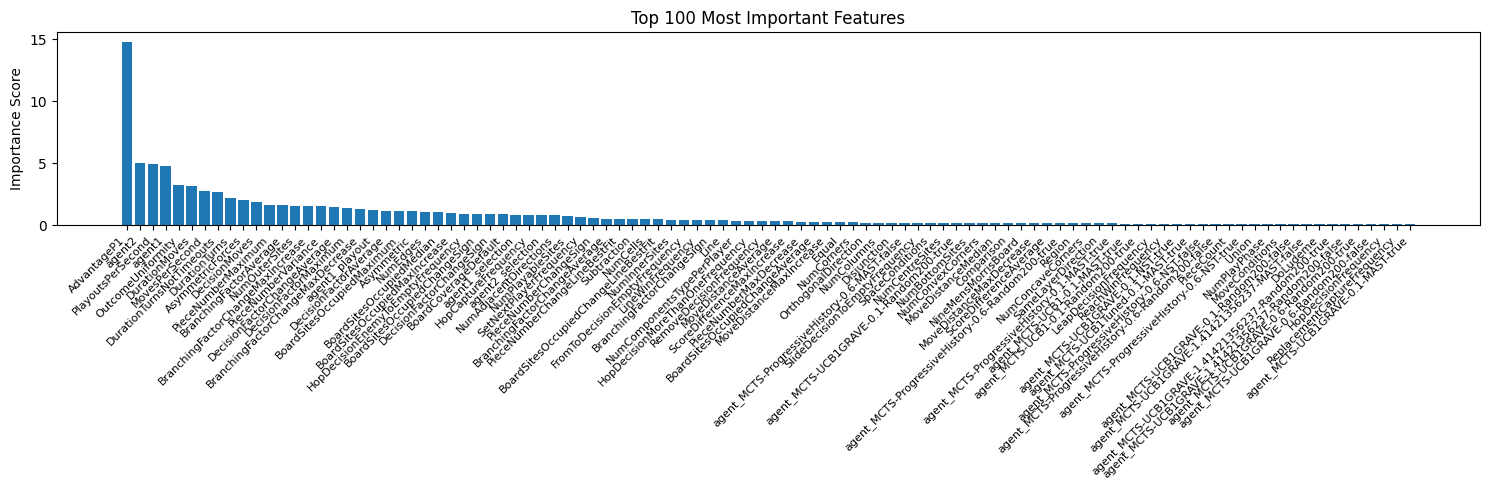

Fold 4 - RMSE: 0.4275407693013964
Fold 5


0:	learn: 0.6239683	test: 0.5916882	best: 0.5916882 (0)	total: 92.1ms	remaining: 15m 21s


50:	learn: 0.4897577	test: 0.5412628	best: 0.5412628 (50)	total: 4.53s	remaining: 14m 44s


100:	learn: 0.4437121	test: 0.5164066	best: 0.5164066 (100)	total: 9.01s	remaining: 14m 43s


150:	learn: 0.4168890	test: 0.4989858	best: 0.4989858 (150)	total: 13.6s	remaining: 14m 44s


200:	learn: 0.4001461	test: 0.4878320	best: 0.4878320 (200)	total: 18.6s	remaining: 15m 4s


250:	learn: 0.3880527	test: 0.4805655	best: 0.4805655 (250)	total: 23.4s	remaining: 15m 8s


300:	learn: 0.3796082	test: 0.4753417	best: 0.4753417 (300)	total: 28.6s	remaining: 15m 21s


350:	learn: 0.3721246	test: 0.4716374	best: 0.4716374 (350)	total: 33.6s	remaining: 15m 23s


400:	learn: 0.3657332	test: 0.4680675	best: 0.4680675 (400)	total: 38.6s	remaining: 15m 24s


450:	learn: 0.3594203	test: 0.4641663	best: 0.4641663 (450)	total: 43.6s	remaining: 15m 23s


500:	learn: 0.3539989	test: 0.4611763	best: 0.4611763 (500)	total: 48.5s	remaining: 15m 18s


550:	learn: 0.3490147	test: 0.4587401	best: 0.4587401 (550)	total: 53.3s	remaining: 15m 14s


600:	learn: 0.3448432	test: 0.4572649	best: 0.4572649 (600)	total: 58.2s	remaining: 15m 10s


650:	learn: 0.3407264	test: 0.4551600	best: 0.4551600 (650)	total: 1m 3s	remaining: 15m 10s


700:	learn: 0.3372762	test: 0.4538207	best: 0.4538207 (700)	total: 1m 8s	remaining: 15m 10s


750:	learn: 0.3340722	test: 0.4526647	best: 0.4526647 (750)	total: 1m 13s	remaining: 15m 9s


800:	learn: 0.3309378	test: 0.4515012	best: 0.4515012 (800)	total: 1m 19s	remaining: 15m 8s


850:	learn: 0.3280795	test: 0.4504627	best: 0.4504627 (850)	total: 1m 24s	remaining: 15m 5s


900:	learn: 0.3253822	test: 0.4496426	best: 0.4496426 (900)	total: 1m 29s	remaining: 15m 1s


950:	learn: 0.3228494	test: 0.4489735	best: 0.4489580 (948)	total: 1m 34s	remaining: 14m 58s


1000:	learn: 0.3204098	test: 0.4481497	best: 0.4481497 (1000)	total: 1m 39s	remaining: 14m 53s


1050:	learn: 0.3182155	test: 0.4473131	best: 0.4473098 (1048)	total: 1m 44s	remaining: 14m 49s


1100:	learn: 0.3160247	test: 0.4465412	best: 0.4465412 (1100)	total: 1m 49s	remaining: 14m 45s


1150:	learn: 0.3140389	test: 0.4459140	best: 0.4459111 (1149)	total: 1m 54s	remaining: 14m 41s


1200:	learn: 0.3121093	test: 0.4453035	best: 0.4453035 (1200)	total: 1m 59s	remaining: 14m 35s


1250:	learn: 0.3101756	test: 0.4446631	best: 0.4446631 (1250)	total: 2m 4s	remaining: 14m 30s


1300:	learn: 0.3083086	test: 0.4441474	best: 0.4441474 (1300)	total: 2m 9s	remaining: 14m 26s


1350:	learn: 0.3064872	test: 0.4434404	best: 0.4434404 (1350)	total: 2m 14s	remaining: 14m 21s


1400:	learn: 0.3046931	test: 0.4430096	best: 0.4430096 (1400)	total: 2m 19s	remaining: 14m 16s


1450:	learn: 0.3031224	test: 0.4425735	best: 0.4425735 (1450)	total: 2m 24s	remaining: 14m 12s


1500:	learn: 0.3015184	test: 0.4420200	best: 0.4420191 (1498)	total: 2m 29s	remaining: 14m 7s


1550:	learn: 0.3000587	test: 0.4415173	best: 0.4415173 (1550)	total: 2m 34s	remaining: 14m 3s


1600:	learn: 0.2984750	test: 0.4409839	best: 0.4409839 (1600)	total: 2m 40s	remaining: 14m


1650:	learn: 0.2969362	test: 0.4406052	best: 0.4406052 (1650)	total: 2m 45s	remaining: 13m 55s


1700:	learn: 0.2955567	test: 0.4403135	best: 0.4403135 (1700)	total: 2m 50s	remaining: 13m 51s


1750:	learn: 0.2940488	test: 0.4399728	best: 0.4399728 (1750)	total: 2m 55s	remaining: 13m 46s


1800:	learn: 0.2927575	test: 0.4396272	best: 0.4396272 (1800)	total: 3m	remaining: 13m 42s


1850:	learn: 0.2914485	test: 0.4393793	best: 0.4393793 (1850)	total: 3m 5s	remaining: 13m 37s


1900:	learn: 0.2901142	test: 0.4390607	best: 0.4390607 (1900)	total: 3m 10s	remaining: 13m 33s


1950:	learn: 0.2888807	test: 0.4388266	best: 0.4388266 (1950)	total: 3m 16s	remaining: 13m 29s


2000:	learn: 0.2876415	test: 0.4385781	best: 0.4385781 (2000)	total: 3m 21s	remaining: 13m 24s


2050:	learn: 0.2864423	test: 0.4383211	best: 0.4383211 (2050)	total: 3m 26s	remaining: 13m 19s


2100:	learn: 0.2853331	test: 0.4380942	best: 0.4380890 (2098)	total: 3m 31s	remaining: 13m 14s


2150:	learn: 0.2842920	test: 0.4377631	best: 0.4377631 (2150)	total: 3m 36s	remaining: 13m 9s


2200:	learn: 0.2831458	test: 0.4374690	best: 0.4374690 (2200)	total: 3m 41s	remaining: 13m 5s


2250:	learn: 0.2820657	test: 0.4372700	best: 0.4372535 (2248)	total: 3m 46s	remaining: 13m


2300:	learn: 0.2809744	test: 0.4370582	best: 0.4370582 (2300)	total: 3m 51s	remaining: 12m 55s


2350:	learn: 0.2799004	test: 0.4368316	best: 0.4368309 (2349)	total: 3m 56s	remaining: 12m 50s


2400:	learn: 0.2788686	test: 0.4366922	best: 0.4366922 (2400)	total: 4m 1s	remaining: 12m 45s


2450:	learn: 0.2779157	test: 0.4365049	best: 0.4365049 (2450)	total: 4m 7s	remaining: 12m 40s


2500:	learn: 0.2769456	test: 0.4364044	best: 0.4364044 (2500)	total: 4m 12s	remaining: 12m 36s


2550:	learn: 0.2759500	test: 0.4361961	best: 0.4361961 (2550)	total: 4m 17s	remaining: 12m 31s


2600:	learn: 0.2750142	test: 0.4361074	best: 0.4361018 (2595)	total: 4m 22s	remaining: 12m 26s


2650:	learn: 0.2741449	test: 0.4359940	best: 0.4359940 (2650)	total: 4m 27s	remaining: 12m 21s


2700:	learn: 0.2732281	test: 0.4358838	best: 0.4358838 (2700)	total: 4m 32s	remaining: 12m 16s


2750:	learn: 0.2723147	test: 0.4357475	best: 0.4357475 (2750)	total: 4m 37s	remaining: 12m 11s


2800:	learn: 0.2714866	test: 0.4355724	best: 0.4355724 (2800)	total: 4m 42s	remaining: 12m 7s


2850:	learn: 0.2706457	test: 0.4354062	best: 0.4354062 (2850)	total: 4m 48s	remaining: 12m 2s


2900:	learn: 0.2698678	test: 0.4353312	best: 0.4353293 (2899)	total: 4m 53s	remaining: 11m 57s


2950:	learn: 0.2689897	test: 0.4351985	best: 0.4351983 (2949)	total: 4m 58s	remaining: 11m 52s


3000:	learn: 0.2682187	test: 0.4350674	best: 0.4350634 (2999)	total: 5m 3s	remaining: 11m 48s


3050:	learn: 0.2673991	test: 0.4349400	best: 0.4349400 (3050)	total: 5m 8s	remaining: 11m 43s


3100:	learn: 0.2666653	test: 0.4348126	best: 0.4348126 (3100)	total: 5m 14s	remaining: 11m 38s


3150:	learn: 0.2659537	test: 0.4347844	best: 0.4347844 (3150)	total: 5m 19s	remaining: 11m 33s


3200:	learn: 0.2652186	test: 0.4346447	best: 0.4346447 (3200)	total: 5m 24s	remaining: 11m 28s


3250:	learn: 0.2644334	test: 0.4344311	best: 0.4344311 (3250)	total: 5m 29s	remaining: 11m 23s


3300:	learn: 0.2636498	test: 0.4343006	best: 0.4343006 (3300)	total: 5m 34s	remaining: 11m 18s


3350:	learn: 0.2629652	test: 0.4341907	best: 0.4341907 (3350)	total: 5m 39s	remaining: 11m 13s


3400:	learn: 0.2621944	test: 0.4340319	best: 0.4340319 (3400)	total: 5m 44s	remaining: 11m 9s


3450:	learn: 0.2615068	test: 0.4339850	best: 0.4339559 (3429)	total: 5m 49s	remaining: 11m 4s


3500:	learn: 0.2607681	test: 0.4338934	best: 0.4338934 (3500)	total: 5m 54s	remaining: 10m 58s


3550:	learn: 0.2600573	test: 0.4337699	best: 0.4337699 (3550)	total: 6m	remaining: 10m 53s


3600:	learn: 0.2593804	test: 0.4336735	best: 0.4336735 (3600)	total: 6m 5s	remaining: 10m 49s


3650:	learn: 0.2586998	test: 0.4335583	best: 0.4335564 (3639)	total: 6m 10s	remaining: 10m 44s


3700:	learn: 0.2579975	test: 0.4334848	best: 0.4334848 (3700)	total: 6m 15s	remaining: 10m 38s


3750:	learn: 0.2573217	test: 0.4333986	best: 0.4333986 (3750)	total: 6m 20s	remaining: 10m 33s


3800:	learn: 0.2566862	test: 0.4333419	best: 0.4333419 (3800)	total: 6m 25s	remaining: 10m 29s


3850:	learn: 0.2560678	test: 0.4332775	best: 0.4332764 (3846)	total: 6m 30s	remaining: 10m 24s


3900:	learn: 0.2554261	test: 0.4331936	best: 0.4331936 (3900)	total: 6m 36s	remaining: 10m 19s


3950:	learn: 0.2547207	test: 0.4330802	best: 0.4330802 (3950)	total: 6m 41s	remaining: 10m 14s


4000:	learn: 0.2540752	test: 0.4329869	best: 0.4329861 (3999)	total: 6m 46s	remaining: 10m 9s


4050:	learn: 0.2534304	test: 0.4328972	best: 0.4328960 (4049)	total: 6m 51s	remaining: 10m 4s


4100:	learn: 0.2528257	test: 0.4328425	best: 0.4328419 (4099)	total: 6m 56s	remaining: 9m 59s


4150:	learn: 0.2522723	test: 0.4328168	best: 0.4328168 (4150)	total: 7m 2s	remaining: 9m 55s


4200:	learn: 0.2516821	test: 0.4327570	best: 0.4327547 (4198)	total: 7m 7s	remaining: 9m 50s


4250:	learn: 0.2510615	test: 0.4326768	best: 0.4326768 (4250)	total: 7m 12s	remaining: 9m 45s


4300:	learn: 0.2504551	test: 0.4325988	best: 0.4325988 (4300)	total: 7m 17s	remaining: 9m 39s


4350:	learn: 0.2499093	test: 0.4325385	best: 0.4325385 (4350)	total: 7m 22s	remaining: 9m 35s


4400:	learn: 0.2493072	test: 0.4324146	best: 0.4324146 (4400)	total: 7m 28s	remaining: 9m 30s


4450:	learn: 0.2487556	test: 0.4323439	best: 0.4323439 (4450)	total: 7m 33s	remaining: 9m 25s


4500:	learn: 0.2481580	test: 0.4322615	best: 0.4322590 (4499)	total: 7m 38s	remaining: 9m 20s


4550:	learn: 0.2476073	test: 0.4321730	best: 0.4321730 (4550)	total: 7m 43s	remaining: 9m 15s


4600:	learn: 0.2470714	test: 0.4321381	best: 0.4321381 (4600)	total: 7m 48s	remaining: 9m 10s


4650:	learn: 0.2464860	test: 0.4320654	best: 0.4320654 (4650)	total: 7m 54s	remaining: 9m 5s


4700:	learn: 0.2459076	test: 0.4320196	best: 0.4320196 (4700)	total: 7m 59s	remaining: 9m


4750:	learn: 0.2453589	test: 0.4319453	best: 0.4319430 (4747)	total: 8m 4s	remaining: 8m 55s


4800:	learn: 0.2448271	test: 0.4318901	best: 0.4318901 (4800)	total: 8m 9s	remaining: 8m 50s


4850:	learn: 0.2442644	test: 0.4318462	best: 0.4318407 (4838)	total: 8m 14s	remaining: 8m 45s


4900:	learn: 0.2437193	test: 0.4318098	best: 0.4318098 (4900)	total: 8m 19s	remaining: 8m 40s


4950:	learn: 0.2432069	test: 0.4317650	best: 0.4317643 (4948)	total: 8m 25s	remaining: 8m 35s


5000:	learn: 0.2426633	test: 0.4317003	best: 0.4317003 (5000)	total: 8m 30s	remaining: 8m 30s


5050:	learn: 0.2421581	test: 0.4316430	best: 0.4316314 (5037)	total: 8m 36s	remaining: 8m 25s


5100:	learn: 0.2416578	test: 0.4315965	best: 0.4315965 (5100)	total: 8m 41s	remaining: 8m 20s


5150:	learn: 0.2411790	test: 0.4315370	best: 0.4315333 (5145)	total: 8m 46s	remaining: 8m 15s


5200:	learn: 0.2406972	test: 0.4315186	best: 0.4315162 (5191)	total: 8m 52s	remaining: 8m 10s


5250:	learn: 0.2402140	test: 0.4314931	best: 0.4314910 (5244)	total: 8m 57s	remaining: 8m 5s


5300:	learn: 0.2397629	test: 0.4314463	best: 0.4314457 (5299)	total: 9m 2s	remaining: 8m


5350:	learn: 0.2393241	test: 0.4313862	best: 0.4313842 (5345)	total: 9m 7s	remaining: 7m 55s


5400:	learn: 0.2388292	test: 0.4313375	best: 0.4313368 (5399)	total: 9m 12s	remaining: 7m 50s


5450:	learn: 0.2383716	test: 0.4313071	best: 0.4313029 (5444)	total: 9m 18s	remaining: 7m 45s


5500:	learn: 0.2378691	test: 0.4312519	best: 0.4312518 (5498)	total: 9m 23s	remaining: 7m 40s


5550:	learn: 0.2373820	test: 0.4311925	best: 0.4311925 (5550)	total: 9m 28s	remaining: 7m 35s


5600:	learn: 0.2369512	test: 0.4311420	best: 0.4311404 (5598)	total: 9m 33s	remaining: 7m 30s


5650:	learn: 0.2364728	test: 0.4310926	best: 0.4310923 (5645)	total: 9m 38s	remaining: 7m 25s


5700:	learn: 0.2359780	test: 0.4310293	best: 0.4310293 (5700)	total: 9m 44s	remaining: 7m 20s


5750:	learn: 0.2355745	test: 0.4309997	best: 0.4309997 (5750)	total: 9m 49s	remaining: 7m 15s


5800:	learn: 0.2351464	test: 0.4309688	best: 0.4309688 (5800)	total: 9m 54s	remaining: 7m 10s


5850:	learn: 0.2347092	test: 0.4309297	best: 0.4309297 (5850)	total: 9m 59s	remaining: 7m 5s


5900:	learn: 0.2342547	test: 0.4308606	best: 0.4308606 (5900)	total: 10m 5s	remaining: 7m


5950:	learn: 0.2338109	test: 0.4307937	best: 0.4307908 (5946)	total: 10m 10s	remaining: 6m 55s


6000:	learn: 0.2333570	test: 0.4307622	best: 0.4307561 (5993)	total: 10m 15s	remaining: 6m 50s


6050:	learn: 0.2329326	test: 0.4307299	best: 0.4307289 (6047)	total: 10m 20s	remaining: 6m 45s


6100:	learn: 0.2324947	test: 0.4306913	best: 0.4306906 (6098)	total: 10m 25s	remaining: 6m 39s


6150:	learn: 0.2321041	test: 0.4306584	best: 0.4306584 (6150)	total: 10m 31s	remaining: 6m 34s


6200:	learn: 0.2316808	test: 0.4306284	best: 0.4306263 (6196)	total: 10m 36s	remaining: 6m 29s


6250:	learn: 0.2312746	test: 0.4305949	best: 0.4305946 (6249)	total: 10m 41s	remaining: 6m 24s


6300:	learn: 0.2308608	test: 0.4305653	best: 0.4305635 (6295)	total: 10m 46s	remaining: 6m 19s


6350:	learn: 0.2304645	test: 0.4305354	best: 0.4305348 (6349)	total: 10m 51s	remaining: 6m 14s


6400:	learn: 0.2300739	test: 0.4305113	best: 0.4305088 (6396)	total: 10m 57s	remaining: 6m 9s


6450:	learn: 0.2296468	test: 0.4304768	best: 0.4304757 (6449)	total: 11m 2s	remaining: 6m 4s


6500:	learn: 0.2292589	test: 0.4304627	best: 0.4304627 (6500)	total: 11m 7s	remaining: 5m 59s


6550:	learn: 0.2288547	test: 0.4304229	best: 0.4304214 (6549)	total: 11m 13s	remaining: 5m 54s


6600:	learn: 0.2284634	test: 0.4303662	best: 0.4303640 (6596)	total: 11m 18s	remaining: 5m 49s


6650:	learn: 0.2280839	test: 0.4303540	best: 0.4303479 (6624)	total: 11m 23s	remaining: 5m 44s


6700:	learn: 0.2276994	test: 0.4303022	best: 0.4303022 (6698)	total: 11m 29s	remaining: 5m 39s


6750:	learn: 0.2273118	test: 0.4302574	best: 0.4302574 (6750)	total: 11m 34s	remaining: 5m 34s


6800:	learn: 0.2269227	test: 0.4302247	best: 0.4302247 (6800)	total: 11m 39s	remaining: 5m 29s


6850:	learn: 0.2265342	test: 0.4301966	best: 0.4301956 (6849)	total: 11m 44s	remaining: 5m 23s


6900:	learn: 0.2261508	test: 0.4301494	best: 0.4301492 (6899)	total: 11m 49s	remaining: 5m 18s


6950:	learn: 0.2258026	test: 0.4301019	best: 0.4301005 (6947)	total: 11m 55s	remaining: 5m 13s


7000:	learn: 0.2254801	test: 0.4300769	best: 0.4300747 (6998)	total: 12m	remaining: 5m 8s


7050:	learn: 0.2250946	test: 0.4300385	best: 0.4300373 (7044)	total: 12m 5s	remaining: 5m 3s


7100:	learn: 0.2247315	test: 0.4300128	best: 0.4300128 (7100)	total: 12m 10s	remaining: 4m 58s


7150:	learn: 0.2243325	test: 0.4299761	best: 0.4299725 (7144)	total: 12m 16s	remaining: 4m 53s


7200:	learn: 0.2239551	test: 0.4299307	best: 0.4299293 (7198)	total: 12m 21s	remaining: 4m 48s


7250:	learn: 0.2236054	test: 0.4299304	best: 0.4299276 (7228)	total: 12m 26s	remaining: 4m 43s


7300:	learn: 0.2232504	test: 0.4298994	best: 0.4298981 (7299)	total: 12m 31s	remaining: 4m 37s


7350:	learn: 0.2228797	test: 0.4298625	best: 0.4298618 (7348)	total: 12m 37s	remaining: 4m 32s


7400:	learn: 0.2224904	test: 0.4298365	best: 0.4298365 (7400)	total: 12m 42s	remaining: 4m 27s


7450:	learn: 0.2221256	test: 0.4298011	best: 0.4298006 (7444)	total: 12m 47s	remaining: 4m 22s


7500:	learn: 0.2217376	test: 0.4297692	best: 0.4297662 (7496)	total: 12m 52s	remaining: 4m 17s


7550:	learn: 0.2213974	test: 0.4297536	best: 0.4297498 (7548)	total: 12m 58s	remaining: 4m 12s


7600:	learn: 0.2210279	test: 0.4297201	best: 0.4297173 (7590)	total: 13m 3s	remaining: 4m 7s


7650:	learn: 0.2206866	test: 0.4296783	best: 0.4296783 (7650)	total: 13m 8s	remaining: 4m 2s


7700:	learn: 0.2203331	test: 0.4296546	best: 0.4296546 (7700)	total: 13m 13s	remaining: 3m 56s


7750:	learn: 0.2200033	test: 0.4296460	best: 0.4296416 (7742)	total: 13m 19s	remaining: 3m 51s


7800:	learn: 0.2196572	test: 0.4296352	best: 0.4296315 (7786)	total: 13m 24s	remaining: 3m 46s


7850:	learn: 0.2192844	test: 0.4295867	best: 0.4295867 (7850)	total: 13m 29s	remaining: 3m 41s


7900:	learn: 0.2189242	test: 0.4295408	best: 0.4295408 (7900)	total: 13m 34s	remaining: 3m 36s


7950:	learn: 0.2185843	test: 0.4295123	best: 0.4295123 (7950)	total: 13m 39s	remaining: 3m 31s


8000:	learn: 0.2182411	test: 0.4294750	best: 0.4294750 (8000)	total: 13m 45s	remaining: 3m 26s


8050:	learn: 0.2179061	test: 0.4294599	best: 0.4294590 (8026)	total: 13m 50s	remaining: 3m 20s


8100:	learn: 0.2175637	test: 0.4294213	best: 0.4294181 (8097)	total: 13m 55s	remaining: 3m 15s


8150:	learn: 0.2172239	test: 0.4294110	best: 0.4294071 (8146)	total: 14m	remaining: 3m 10s


8200:	learn: 0.2168979	test: 0.4293978	best: 0.4293978 (8200)	total: 14m 6s	remaining: 3m 5s


8250:	learn: 0.2165700	test: 0.4293783	best: 0.4293783 (8250)	total: 14m 11s	remaining: 3m


8300:	learn: 0.2162361	test: 0.4293552	best: 0.4293552 (8300)	total: 14m 16s	remaining: 2m 55s


8350:	learn: 0.2159101	test: 0.4293111	best: 0.4293085 (8348)	total: 14m 21s	remaining: 2m 50s


8400:	learn: 0.2156066	test: 0.4293142	best: 0.4293055 (8357)	total: 14m 27s	remaining: 2m 45s


8450:	learn: 0.2152792	test: 0.4292670	best: 0.4292669 (8449)	total: 14m 32s	remaining: 2m 39s


8500:	learn: 0.2149331	test: 0.4292326	best: 0.4292314 (8492)	total: 14m 37s	remaining: 2m 34s


8550:	learn: 0.2146422	test: 0.4292253	best: 0.4292231 (8547)	total: 14m 42s	remaining: 2m 29s


8600:	learn: 0.2143277	test: 0.4292146	best: 0.4292146 (8600)	total: 14m 48s	remaining: 2m 24s


8650:	learn: 0.2140051	test: 0.4291954	best: 0.4291925 (8623)	total: 14m 53s	remaining: 2m 19s


8700:	learn: 0.2136766	test: 0.4291911	best: 0.4291805 (8693)	total: 14m 58s	remaining: 2m 14s


8750:	learn: 0.2133673	test: 0.4291661	best: 0.4291622 (8744)	total: 15m 3s	remaining: 2m 8s


8800:	learn: 0.2130454	test: 0.4291485	best: 0.4291459 (8798)	total: 15m 9s	remaining: 2m 3s


8850:	learn: 0.2127302	test: 0.4291354	best: 0.4291314 (8843)	total: 15m 14s	remaining: 1m 58s


8900:	learn: 0.2123727	test: 0.4291216	best: 0.4291177 (8883)	total: 15m 19s	remaining: 1m 53s


8950:	learn: 0.2120541	test: 0.4291184	best: 0.4291124 (8909)	total: 15m 24s	remaining: 1m 48s


9000:	learn: 0.2117522	test: 0.4290980	best: 0.4290864 (8992)	total: 15m 30s	remaining: 1m 43s


9050:	learn: 0.2114551	test: 0.4290753	best: 0.4290753 (9050)	total: 15m 35s	remaining: 1m 38s


9100:	learn: 0.2111692	test: 0.4290517	best: 0.4290496 (9098)	total: 15m 40s	remaining: 1m 32s


9150:	learn: 0.2108771	test: 0.4290530	best: 0.4290462 (9105)	total: 15m 46s	remaining: 1m 27s


9200:	learn: 0.2105580	test: 0.4290365	best: 0.4290365 (9200)	total: 15m 51s	remaining: 1m 22s


9250:	learn: 0.2102344	test: 0.4290354	best: 0.4290264 (9227)	total: 15m 56s	remaining: 1m 17s


9300:	learn: 0.2099185	test: 0.4290396	best: 0.4290264 (9227)	total: 16m 2s	remaining: 1m 12s


9350:	learn: 0.2096276	test: 0.4290273	best: 0.4290264 (9227)	total: 16m 7s	remaining: 1m 7s


9400:	learn: 0.2093470	test: 0.4290133	best: 0.4290117 (9395)	total: 16m 12s	remaining: 1m 1s


9450:	learn: 0.2090518	test: 0.4289971	best: 0.4289971 (9450)	total: 16m 17s	remaining: 56.8s


9500:	learn: 0.2087916	test: 0.4289814	best: 0.4289814 (9499)	total: 16m 23s	remaining: 51.6s


9550:	learn: 0.2084665	test: 0.4289667	best: 0.4289643 (9549)	total: 16m 28s	remaining: 46.5s


9600:	learn: 0.2081377	test: 0.4289606	best: 0.4289602 (9599)	total: 16m 33s	remaining: 41.3s


9650:	learn: 0.2078224	test: 0.4289506	best: 0.4289435 (9641)	total: 16m 38s	remaining: 36.1s


9700:	learn: 0.2075052	test: 0.4289273	best: 0.4289273 (9700)	total: 16m 43s	remaining: 30.9s


9750:	learn: 0.2072288	test: 0.4289161	best: 0.4289146 (9749)	total: 16m 49s	remaining: 25.8s


9800:	learn: 0.2069537	test: 0.4289268	best: 0.4289093 (9761)	total: 16m 54s	remaining: 20.6s


9850:	learn: 0.2066611	test: 0.4289108	best: 0.4289062 (9845)	total: 16m 59s	remaining: 15.4s


9900:	learn: 0.2063899	test: 0.4289063	best: 0.4288952 (9886)	total: 17m 5s	remaining: 10.2s


9950:	learn: 0.2061221	test: 0.4288901	best: 0.4288851 (9945)	total: 17m 10s	remaining: 5.07s


9999:	learn: 0.2058223	test: 0.4288560	best: 0.4288560 (9999)	total: 17m 15s	remaining: 0us

bestTest = 0.4288559525
bestIteration = 9999



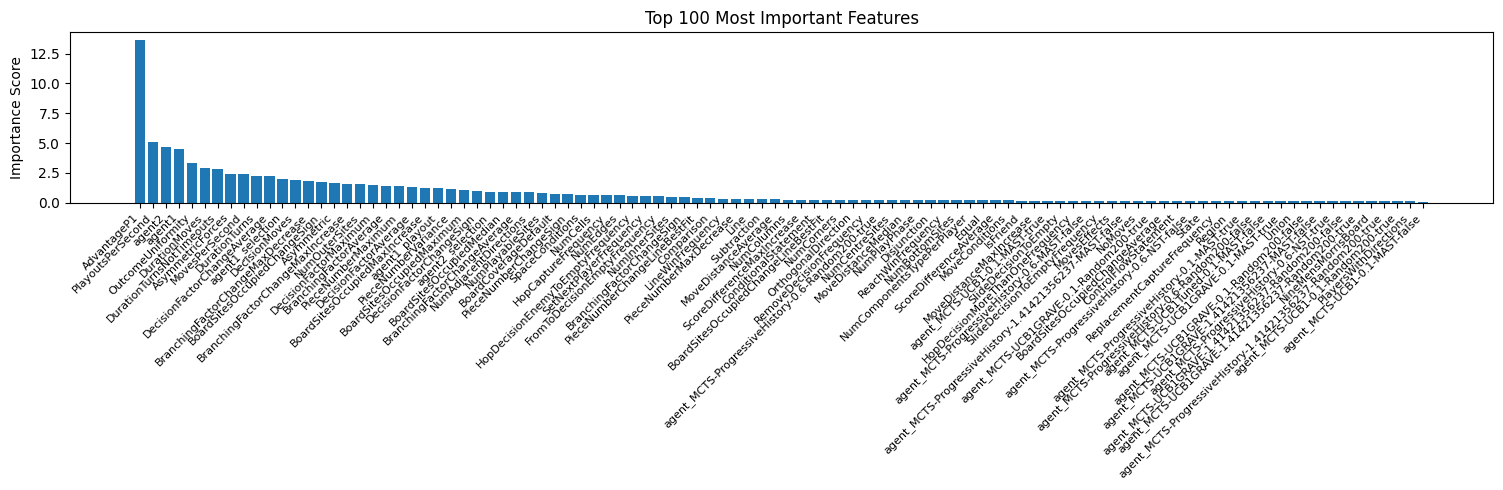

Fold 5 - RMSE: 0.42841801315509687
List of oof scores: [0.4071033680621828, 0.3958133809974048, 0.4187233522608535, 0.4275407693013964, 0.42841801315509687]
Average oof score: 0.41551977675538687


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6270380	test: 0.5754103	best: 0.5754103 (0)	total: 83.4ms	remaining: 13m 54s


50:	learn: 0.4928236	test: 0.5229345	best: 0.5229345 (50)	total: 4.38s	remaining: 14m 14s


100:	learn: 0.4460691	test: 0.4984788	best: 0.4984788 (100)	total: 8.71s	remaining: 14m 13s


150:	learn: 0.4206587	test: 0.4822492	best: 0.4822492 (150)	total: 13.2s	remaining: 14m 20s


200:	learn: 0.4034951	test: 0.4717270	best: 0.4717270 (200)	total: 18.1s	remaining: 14m 40s


250:	learn: 0.3914303	test: 0.4656880	best: 0.4656880 (250)	total: 23s	remaining: 14m 51s


300:	learn: 0.3824922	test: 0.4613156	best: 0.4613156 (300)	total: 28s	remaining: 15m 1s


350:	learn: 0.3740721	test: 0.4573446	best: 0.4573446 (350)	total: 32.9s	remaining: 15m 3s


400:	learn: 0.3670152	test: 0.4550139	best: 0.4550139 (400)	total: 37.7s	remaining: 15m 2s


450:	learn: 0.3602710	test: 0.4524608	best: 0.4524608 (450)	total: 42.6s	remaining: 15m 1s


500:	learn: 0.3537089	test: 0.4497837	best: 0.4497837 (500)	total: 47.3s	remaining: 14m 56s


550:	learn: 0.3485051	test: 0.4481794	best: 0.4481794 (550)	total: 52s	remaining: 14m 51s


600:	learn: 0.3439665	test: 0.4463727	best: 0.4463727 (600)	total: 56.8s	remaining: 14m 47s


650:	learn: 0.3397014	test: 0.4452257	best: 0.4452257 (650)	total: 1m 1s	remaining: 14m 43s


700:	learn: 0.3357104	test: 0.4441536	best: 0.4441536 (700)	total: 1m 6s	remaining: 14m 38s


750:	learn: 0.3322661	test: 0.4430281	best: 0.4430281 (750)	total: 1m 11s	remaining: 14m 34s


800:	learn: 0.3291936	test: 0.4421427	best: 0.4421145 (798)	total: 1m 15s	remaining: 14m 30s


850:	learn: 0.3261775	test: 0.4413660	best: 0.4413660 (850)	total: 1m 20s	remaining: 14m 25s


900:	learn: 0.3235521	test: 0.4405390	best: 0.4405248 (899)	total: 1m 25s	remaining: 14m 22s


950:	learn: 0.3210206	test: 0.4396835	best: 0.4396821 (949)	total: 1m 30s	remaining: 14m 17s


1000:	learn: 0.3187488	test: 0.4391747	best: 0.4391747 (1000)	total: 1m 34s	remaining: 14m 13s


1050:	learn: 0.3166798	test: 0.4386766	best: 0.4386745 (1049)	total: 1m 39s	remaining: 14m 10s


1100:	learn: 0.3145919	test: 0.4381503	best: 0.4381484 (1099)	total: 1m 44s	remaining: 14m 7s


1150:	learn: 0.3127443	test: 0.4376579	best: 0.4376579 (1150)	total: 1m 49s	remaining: 14m 3s


1200:	learn: 0.3107675	test: 0.4371129	best: 0.4371129 (1200)	total: 1m 54s	remaining: 13m 59s


1250:	learn: 0.3087985	test: 0.4367803	best: 0.4367743 (1246)	total: 1m 59s	remaining: 13m 55s


1300:	learn: 0.3070232	test: 0.4363135	best: 0.4363135 (1300)	total: 2m 4s	remaining: 13m 51s


1350:	learn: 0.3052867	test: 0.4358170	best: 0.4358170 (1350)	total: 2m 9s	remaining: 13m 48s


1400:	learn: 0.3037096	test: 0.4354916	best: 0.4354916 (1400)	total: 2m 14s	remaining: 13m 44s


1450:	learn: 0.3020359	test: 0.4350858	best: 0.4350702 (1448)	total: 2m 19s	remaining: 13m 40s


1500:	learn: 0.3004855	test: 0.4347050	best: 0.4346879 (1498)	total: 2m 24s	remaining: 13m 37s


1550:	learn: 0.2989241	test: 0.4343312	best: 0.4343301 (1549)	total: 2m 29s	remaining: 13m 33s


1600:	learn: 0.2974335	test: 0.4339947	best: 0.4339947 (1600)	total: 2m 34s	remaining: 13m 29s


1650:	learn: 0.2960580	test: 0.4336979	best: 0.4336979 (1650)	total: 2m 39s	remaining: 13m 25s


1700:	learn: 0.2946460	test: 0.4334403	best: 0.4334392 (1697)	total: 2m 44s	remaining: 13m 21s


1750:	learn: 0.2932652	test: 0.4331710	best: 0.4331710 (1750)	total: 2m 49s	remaining: 13m 17s


1800:	learn: 0.2919432	test: 0.4328703	best: 0.4328703 (1800)	total: 2m 54s	remaining: 13m 13s


1850:	learn: 0.2906882	test: 0.4326367	best: 0.4326304 (1845)	total: 2m 59s	remaining: 13m 9s


1900:	learn: 0.2894431	test: 0.4324436	best: 0.4324436 (1900)	total: 3m 4s	remaining: 13m 5s


1950:	learn: 0.2882585	test: 0.4322931	best: 0.4322873 (1949)	total: 3m 9s	remaining: 13m


2000:	learn: 0.2870319	test: 0.4320325	best: 0.4320325 (2000)	total: 3m 14s	remaining: 12m 56s


2050:	learn: 0.2858028	test: 0.4319000	best: 0.4318926 (2045)	total: 3m 19s	remaining: 12m 52s


2100:	learn: 0.2846447	test: 0.4316915	best: 0.4316915 (2100)	total: 3m 24s	remaining: 12m 47s


2150:	learn: 0.2835325	test: 0.4314739	best: 0.4314661 (2146)	total: 3m 29s	remaining: 12m 43s


2200:	learn: 0.2824853	test: 0.4312801	best: 0.4312799 (2199)	total: 3m 34s	remaining: 12m 39s


2250:	learn: 0.2813390	test: 0.4310403	best: 0.4310403 (2250)	total: 3m 39s	remaining: 12m 35s


2300:	learn: 0.2802800	test: 0.4308939	best: 0.4308835 (2293)	total: 3m 44s	remaining: 12m 30s


2350:	learn: 0.2792258	test: 0.4307320	best: 0.4307320 (2350)	total: 3m 49s	remaining: 12m 25s


2400:	learn: 0.2782396	test: 0.4306164	best: 0.4306155 (2399)	total: 3m 54s	remaining: 12m 21s


2450:	learn: 0.2772010	test: 0.4304343	best: 0.4304298 (2446)	total: 3m 59s	remaining: 12m 17s


2500:	learn: 0.2762670	test: 0.4303045	best: 0.4303045 (2500)	total: 4m 4s	remaining: 12m 13s


2550:	learn: 0.2753127	test: 0.4301727	best: 0.4301727 (2550)	total: 4m 9s	remaining: 12m 8s


2600:	learn: 0.2744255	test: 0.4299622	best: 0.4299622 (2600)	total: 4m 14s	remaining: 12m 4s


2650:	learn: 0.2735107	test: 0.4298367	best: 0.4298305 (2642)	total: 4m 19s	remaining: 11m 59s


2700:	learn: 0.2725988	test: 0.4296944	best: 0.4296944 (2700)	total: 4m 24s	remaining: 11m 55s


2750:	learn: 0.2717400	test: 0.4295762	best: 0.4295722 (2745)	total: 4m 29s	remaining: 11m 50s


2800:	learn: 0.2709031	test: 0.4295181	best: 0.4295181 (2800)	total: 4m 34s	remaining: 11m 46s


2850:	learn: 0.2700234	test: 0.4293132	best: 0.4293132 (2850)	total: 4m 39s	remaining: 11m 41s


2900:	learn: 0.2691994	test: 0.4292054	best: 0.4292054 (2900)	total: 4m 44s	remaining: 11m 36s


2950:	learn: 0.2682468	test: 0.4290446	best: 0.4290446 (2950)	total: 4m 49s	remaining: 11m 31s


3000:	learn: 0.2673674	test: 0.4288982	best: 0.4288982 (3000)	total: 4m 54s	remaining: 11m 27s


3050:	learn: 0.2665389	test: 0.4287689	best: 0.4287640 (3049)	total: 4m 59s	remaining: 11m 22s


3100:	learn: 0.2657186	test: 0.4286874	best: 0.4286835 (3088)	total: 5m 4s	remaining: 11m 18s


3150:	learn: 0.2648699	test: 0.4285523	best: 0.4285518 (3149)	total: 5m 9s	remaining: 11m 13s


3200:	learn: 0.2641149	test: 0.4284749	best: 0.4284749 (3200)	total: 5m 14s	remaining: 11m 9s


3250:	learn: 0.2633328	test: 0.4284082	best: 0.4284059 (3245)	total: 5m 20s	remaining: 11m 4s


3300:	learn: 0.2626383	test: 0.4283281	best: 0.4283281 (3300)	total: 5m 25s	remaining: 10m 59s


3350:	learn: 0.2618832	test: 0.4282707	best: 0.4282707 (3350)	total: 5m 30s	remaining: 10m 55s


3400:	learn: 0.2612261	test: 0.4282369	best: 0.4282290 (3396)	total: 5m 35s	remaining: 10m 50s


3450:	learn: 0.2604639	test: 0.4281192	best: 0.4281170 (3449)	total: 5m 40s	remaining: 10m 46s


3500:	learn: 0.2597841	test: 0.4280703	best: 0.4280703 (3500)	total: 5m 45s	remaining: 10m 41s


3550:	learn: 0.2590543	test: 0.4280128	best: 0.4280128 (3550)	total: 5m 50s	remaining: 10m 36s


3600:	learn: 0.2584137	test: 0.4279283	best: 0.4279283 (3600)	total: 5m 55s	remaining: 10m 32s


3650:	learn: 0.2576861	test: 0.4278151	best: 0.4278151 (3650)	total: 6m	remaining: 10m 27s


3700:	learn: 0.2570064	test: 0.4277460	best: 0.4277460 (3700)	total: 6m 5s	remaining: 10m 22s


3750:	learn: 0.2563216	test: 0.4276654	best: 0.4276593 (3746)	total: 6m 10s	remaining: 10m 17s


3800:	learn: 0.2557266	test: 0.4276291	best: 0.4276253 (3798)	total: 6m 16s	remaining: 10m 13s


3850:	learn: 0.2550849	test: 0.4275823	best: 0.4275815 (3843)	total: 6m 21s	remaining: 10m 8s


3900:	learn: 0.2543706	test: 0.4275106	best: 0.4275082 (3889)	total: 6m 26s	remaining: 10m 3s


3950:	learn: 0.2537292	test: 0.4274799	best: 0.4274733 (3937)	total: 6m 31s	remaining: 9m 58s


4000:	learn: 0.2531272	test: 0.4274052	best: 0.4274041 (3996)	total: 6m 36s	remaining: 9m 54s


4050:	learn: 0.2524887	test: 0.4273580	best: 0.4273580 (4050)	total: 6m 41s	remaining: 9m 49s


4100:	learn: 0.2518997	test: 0.4272691	best: 0.4272691 (4100)	total: 6m 46s	remaining: 9m 44s


4150:	learn: 0.2512447	test: 0.4271815	best: 0.4271815 (4150)	total: 6m 51s	remaining: 9m 39s


4200:	learn: 0.2507210	test: 0.4271214	best: 0.4271214 (4200)	total: 6m 56s	remaining: 9m 34s


4250:	learn: 0.2500534	test: 0.4271129	best: 0.4271056 (4239)	total: 7m 1s	remaining: 9m 29s


4300:	learn: 0.2495146	test: 0.4270538	best: 0.4270538 (4300)	total: 7m 6s	remaining: 9m 25s


4350:	learn: 0.2489355	test: 0.4269975	best: 0.4269871 (4342)	total: 7m 11s	remaining: 9m 20s


4400:	learn: 0.2483805	test: 0.4269324	best: 0.4269320 (4399)	total: 7m 16s	remaining: 9m 15s


4450:	learn: 0.2478001	test: 0.4268776	best: 0.4268776 (4450)	total: 7m 21s	remaining: 9m 10s


4500:	learn: 0.2472642	test: 0.4268059	best: 0.4268021 (4496)	total: 7m 26s	remaining: 9m 6s


4550:	learn: 0.2466913	test: 0.4267481	best: 0.4267448 (4548)	total: 7m 32s	remaining: 9m 1s


4600:	learn: 0.2461393	test: 0.4266960	best: 0.4266960 (4600)	total: 7m 37s	remaining: 8m 56s


4650:	learn: 0.2455916	test: 0.4266280	best: 0.4266268 (4642)	total: 7m 42s	remaining: 8m 51s


4700:	learn: 0.2450269	test: 0.4265486	best: 0.4265486 (4700)	total: 7m 47s	remaining: 8m 46s


4750:	learn: 0.2444950	test: 0.4265011	best: 0.4264992 (4749)	total: 7m 52s	remaining: 8m 41s


4800:	learn: 0.2439620	test: 0.4264397	best: 0.4264397 (4800)	total: 7m 57s	remaining: 8m 36s


4850:	learn: 0.2434383	test: 0.4263750	best: 0.4263750 (4850)	total: 8m 2s	remaining: 8m 31s


4900:	learn: 0.2429140	test: 0.4263340	best: 0.4263282 (4891)	total: 8m 7s	remaining: 8m 26s


4950:	learn: 0.2423833	test: 0.4263009	best: 0.4263009 (4950)	total: 8m 12s	remaining: 8m 22s


5000:	learn: 0.2418977	test: 0.4262446	best: 0.4262446 (5000)	total: 8m 17s	remaining: 8m 17s


5050:	learn: 0.2413828	test: 0.4262162	best: 0.4262081 (5046)	total: 8m 22s	remaining: 8m 12s


5100:	learn: 0.2409035	test: 0.4261667	best: 0.4261632 (5091)	total: 8m 27s	remaining: 8m 7s


5150:	learn: 0.2404253	test: 0.4261243	best: 0.4261200 (5148)	total: 8m 32s	remaining: 8m 2s


5200:	learn: 0.2399526	test: 0.4260828	best: 0.4260795 (5199)	total: 8m 38s	remaining: 7m 58s


5250:	learn: 0.2394710	test: 0.4260181	best: 0.4260181 (5250)	total: 8m 43s	remaining: 7m 53s


5300:	learn: 0.2389886	test: 0.4259698	best: 0.4259657 (5297)	total: 8m 48s	remaining: 7m 48s


5350:	learn: 0.2384990	test: 0.4259361	best: 0.4259186 (5345)	total: 8m 53s	remaining: 7m 43s


5400:	learn: 0.2380475	test: 0.4258664	best: 0.4258551 (5388)	total: 8m 58s	remaining: 7m 38s


5450:	learn: 0.2375794	test: 0.4258411	best: 0.4258392 (5448)	total: 9m 3s	remaining: 7m 33s


5500:	learn: 0.2371128	test: 0.4257801	best: 0.4257797 (5498)	total: 9m 8s	remaining: 7m 28s


5550:	learn: 0.2366525	test: 0.4257611	best: 0.4257611 (5550)	total: 9m 13s	remaining: 7m 23s


5600:	learn: 0.2362471	test: 0.4257276	best: 0.4257181 (5591)	total: 9m 19s	remaining: 7m 19s


5650:	learn: 0.2358278	test: 0.4257263	best: 0.4257181 (5591)	total: 9m 24s	remaining: 7m 14s


5700:	learn: 0.2353532	test: 0.4256921	best: 0.4256904 (5696)	total: 9m 29s	remaining: 7m 9s


5750:	learn: 0.2349301	test: 0.4256215	best: 0.4256196 (5741)	total: 9m 34s	remaining: 7m 4s


5800:	learn: 0.2344988	test: 0.4256257	best: 0.4256130 (5774)	total: 9m 39s	remaining: 6m 59s


5850:	learn: 0.2340633	test: 0.4255971	best: 0.4255954 (5847)	total: 9m 45s	remaining: 6m 54s


5900:	learn: 0.2336364	test: 0.4255479	best: 0.4255479 (5900)	total: 9m 50s	remaining: 6m 50s


5950:	learn: 0.2331974	test: 0.4255334	best: 0.4255202 (5927)	total: 9m 55s	remaining: 6m 45s


6000:	learn: 0.2327909	test: 0.4255030	best: 0.4254989 (5991)	total: 10m	remaining: 6m 40s


6050:	learn: 0.2323520	test: 0.4254755	best: 0.4254755 (6050)	total: 10m 5s	remaining: 6m 35s


6100:	learn: 0.2319189	test: 0.4254361	best: 0.4254351 (6098)	total: 10m 10s	remaining: 6m 30s


6150:	learn: 0.2315427	test: 0.4254074	best: 0.4254062 (6147)	total: 10m 15s	remaining: 6m 25s


6200:	learn: 0.2311515	test: 0.4253967	best: 0.4253967 (6200)	total: 10m 20s	remaining: 6m 20s


6250:	learn: 0.2307201	test: 0.4253740	best: 0.4253661 (6244)	total: 10m 26s	remaining: 6m 15s


6300:	learn: 0.2303076	test: 0.4253316	best: 0.4253310 (6299)	total: 10m 31s	remaining: 6m 10s


6350:	learn: 0.2298946	test: 0.4253061	best: 0.4253030 (6347)	total: 10m 36s	remaining: 6m 5s


6400:	learn: 0.2294669	test: 0.4252764	best: 0.4252751 (6389)	total: 10m 41s	remaining: 6m


6450:	learn: 0.2290964	test: 0.4252502	best: 0.4252464 (6430)	total: 10m 46s	remaining: 5m 55s


6500:	learn: 0.2287352	test: 0.4252216	best: 0.4252192 (6499)	total: 10m 51s	remaining: 5m 50s


6550:	learn: 0.2283425	test: 0.4251856	best: 0.4251824 (6544)	total: 10m 56s	remaining: 5m 45s


6600:	learn: 0.2279811	test: 0.4251672	best: 0.4251667 (6599)	total: 11m 1s	remaining: 5m 40s


6650:	learn: 0.2275804	test: 0.4251296	best: 0.4251296 (6650)	total: 11m 7s	remaining: 5m 35s


6700:	learn: 0.2271968	test: 0.4250884	best: 0.4250868 (6699)	total: 11m 12s	remaining: 5m 30s


6750:	learn: 0.2267682	test: 0.4250537	best: 0.4250523 (6748)	total: 11m 17s	remaining: 5m 25s


6800:	learn: 0.2263923	test: 0.4250375	best: 0.4250356 (6783)	total: 11m 22s	remaining: 5m 20s


6850:	learn: 0.2260126	test: 0.4250190	best: 0.4250162 (6846)	total: 11m 27s	remaining: 5m 15s


6900:	learn: 0.2256467	test: 0.4249962	best: 0.4249895 (6898)	total: 11m 32s	remaining: 5m 10s


6950:	learn: 0.2252803	test: 0.4249894	best: 0.4249894 (6950)	total: 11m 37s	remaining: 5m 6s


7000:	learn: 0.2248692	test: 0.4249474	best: 0.4249474 (7000)	total: 11m 42s	remaining: 5m 1s


7050:	learn: 0.2244762	test: 0.4249281	best: 0.4249239 (7046)	total: 11m 47s	remaining: 4m 56s


7100:	learn: 0.2240866	test: 0.4249197	best: 0.4249174 (7093)	total: 11m 52s	remaining: 4m 51s


7150:	learn: 0.2237144	test: 0.4249149	best: 0.4249149 (7150)	total: 11m 58s	remaining: 4m 46s


7200:	learn: 0.2233560	test: 0.4248810	best: 0.4248810 (7200)	total: 12m 3s	remaining: 4m 41s


7250:	learn: 0.2230048	test: 0.4248706	best: 0.4248690 (7228)	total: 12m 8s	remaining: 4m 36s


7300:	learn: 0.2226526	test: 0.4248601	best: 0.4248550 (7288)	total: 12m 13s	remaining: 4m 31s


7350:	learn: 0.2222892	test: 0.4248370	best: 0.4248313 (7339)	total: 12m 18s	remaining: 4m 26s


7400:	learn: 0.2219333	test: 0.4248144	best: 0.4248141 (7399)	total: 12m 23s	remaining: 4m 21s


7450:	learn: 0.2215866	test: 0.4247688	best: 0.4247672 (7449)	total: 12m 28s	remaining: 4m 16s


7500:	learn: 0.2212562	test: 0.4247507	best: 0.4247455 (7472)	total: 12m 34s	remaining: 4m 11s


7550:	learn: 0.2208895	test: 0.4247370	best: 0.4247370 (7550)	total: 12m 39s	remaining: 4m 6s


7600:	learn: 0.2205691	test: 0.4247350	best: 0.4247208 (7590)	total: 12m 44s	remaining: 4m 1s


7650:	learn: 0.2202530	test: 0.4247223	best: 0.4247200 (7649)	total: 12m 49s	remaining: 3m 56s


7700:	learn: 0.2199056	test: 0.4246962	best: 0.4246962 (7700)	total: 12m 54s	remaining: 3m 51s


7750:	learn: 0.2195445	test: 0.4246753	best: 0.4246753 (7750)	total: 12m 59s	remaining: 3m 46s


7800:	learn: 0.2192073	test: 0.4246599	best: 0.4246567 (7796)	total: 13m 4s	remaining: 3m 41s


7850:	learn: 0.2188767	test: 0.4246535	best: 0.4246496 (7846)	total: 13m 10s	remaining: 3m 36s


7900:	learn: 0.2185593	test: 0.4246345	best: 0.4246305 (7894)	total: 13m 15s	remaining: 3m 31s


7950:	learn: 0.2182313	test: 0.4246130	best: 0.4246128 (7949)	total: 13m 20s	remaining: 3m 26s


8000:	learn: 0.2179236	test: 0.4246012	best: 0.4246012 (8000)	total: 13m 25s	remaining: 3m 21s


8050:	learn: 0.2175778	test: 0.4245800	best: 0.4245707 (8030)	total: 13m 30s	remaining: 3m 16s


8100:	learn: 0.2172617	test: 0.4245818	best: 0.4245707 (8030)	total: 13m 35s	remaining: 3m 11s


8150:	learn: 0.2169751	test: 0.4245694	best: 0.4245694 (8150)	total: 13m 41s	remaining: 3m 6s


8200:	learn: 0.2166318	test: 0.4245537	best: 0.4245502 (8195)	total: 13m 46s	remaining: 3m 1s


8250:	learn: 0.2163041	test: 0.4245551	best: 0.4245502 (8195)	total: 13m 51s	remaining: 2m 56s


8300:	learn: 0.2159881	test: 0.4245167	best: 0.4245118 (8283)	total: 13m 56s	remaining: 2m 51s


8350:	learn: 0.2156453	test: 0.4244988	best: 0.4244930 (8343)	total: 14m 1s	remaining: 2m 46s


8400:	learn: 0.2153479	test: 0.4244881	best: 0.4244869 (8370)	total: 14m 6s	remaining: 2m 41s


8450:	learn: 0.2149988	test: 0.4244591	best: 0.4244525 (8443)	total: 14m 11s	remaining: 2m 36s


8500:	learn: 0.2146856	test: 0.4244581	best: 0.4244525 (8443)	total: 14m 17s	remaining: 2m 31s


8550:	learn: 0.2143442	test: 0.4244377	best: 0.4244377 (8550)	total: 14m 22s	remaining: 2m 26s


8600:	learn: 0.2140363	test: 0.4244384	best: 0.4244377 (8550)	total: 14m 27s	remaining: 2m 21s


8650:	learn: 0.2137053	test: 0.4244211	best: 0.4244211 (8650)	total: 14m 32s	remaining: 2m 16s


8700:	learn: 0.2134089	test: 0.4244067	best: 0.4244060 (8683)	total: 14m 37s	remaining: 2m 11s


8750:	learn: 0.2131346	test: 0.4243786	best: 0.4243778 (8749)	total: 14m 42s	remaining: 2m 5s


8800:	learn: 0.2128506	test: 0.4243822	best: 0.4243691 (8785)	total: 14m 47s	remaining: 2m


8850:	learn: 0.2125526	test: 0.4243758	best: 0.4243691 (8785)	total: 14m 52s	remaining: 1m 55s


8900:	learn: 0.2122385	test: 0.4243363	best: 0.4243350 (8899)	total: 14m 57s	remaining: 1m 50s


8950:	learn: 0.2119345	test: 0.4243055	best: 0.4243006 (8938)	total: 15m 3s	remaining: 1m 45s


9000:	learn: 0.2116411	test: 0.4242951	best: 0.4242951 (9000)	total: 15m 8s	remaining: 1m 40s


9050:	learn: 0.2113655	test: 0.4242864	best: 0.4242847 (9048)	total: 15m 13s	remaining: 1m 35s


9100:	learn: 0.2110476	test: 0.4242904	best: 0.4242729 (9069)	total: 15m 18s	remaining: 1m 30s


9150:	learn: 0.2107590	test: 0.4242770	best: 0.4242717 (9143)	total: 15m 23s	remaining: 1m 25s


9200:	learn: 0.2104665	test: 0.4242302	best: 0.4242299 (9199)	total: 15m 28s	remaining: 1m 20s


9250:	learn: 0.2101468	test: 0.4242114	best: 0.4242114 (9250)	total: 15m 34s	remaining: 1m 15s


9300:	learn: 0.2098434	test: 0.4242083	best: 0.4242063 (9299)	total: 15m 39s	remaining: 1m 10s


9350:	learn: 0.2095545	test: 0.4241750	best: 0.4241739 (9349)	total: 15m 44s	remaining: 1m 5s


9400:	learn: 0.2092560	test: 0.4241771	best: 0.4241739 (9349)	total: 15m 49s	remaining: 1m


9450:	learn: 0.2089670	test: 0.4241656	best: 0.4241577 (9448)	total: 15m 54s	remaining: 55.5s


9500:	learn: 0.2086879	test: 0.4241493	best: 0.4241480 (9469)	total: 15m 59s	remaining: 50.4s


9550:	learn: 0.2083964	test: 0.4241401	best: 0.4241345 (9536)	total: 16m 5s	remaining: 45.4s


9600:	learn: 0.2081393	test: 0.4241421	best: 0.4241345 (9536)	total: 16m 10s	remaining: 40.3s


9650:	learn: 0.2078591	test: 0.4241145	best: 0.4241138 (9635)	total: 16m 15s	remaining: 35.3s


9700:	learn: 0.2075676	test: 0.4240949	best: 0.4240941 (9695)	total: 16m 20s	remaining: 30.2s


9750:	learn: 0.2072820	test: 0.4240888	best: 0.4240878 (9748)	total: 16m 25s	remaining: 25.2s


9800:	learn: 0.2070154	test: 0.4240691	best: 0.4240691 (9800)	total: 16m 30s	remaining: 20.1s


9850:	learn: 0.2067210	test: 0.4240494	best: 0.4240490 (9849)	total: 16m 35s	remaining: 15.1s


9900:	learn: 0.2064439	test: 0.4240215	best: 0.4240206 (9888)	total: 16m 41s	remaining: 10s


9950:	learn: 0.2061314	test: 0.4240179	best: 0.4240171 (9912)	total: 16m 46s	remaining: 4.95s


9999:	learn: 0.2058756	test: 0.4240032	best: 0.4240029 (9998)	total: 16m 51s	remaining: 0us

bestTest = 0.4240029318
bestIteration = 9998

Shrink model to first 9999 iterations.


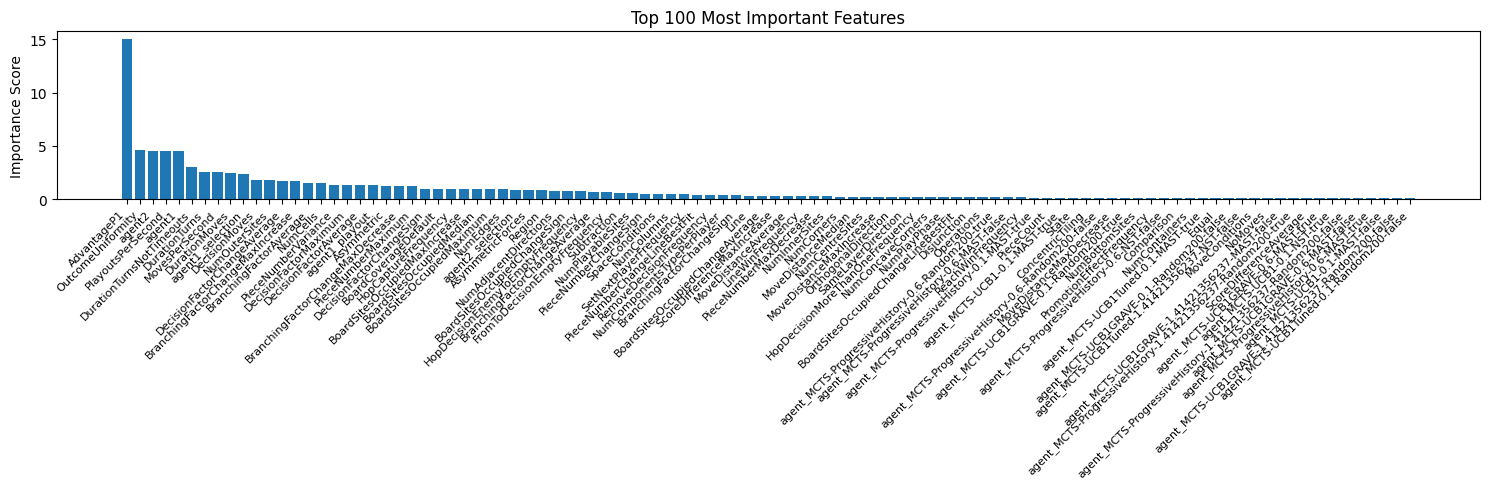

Fold 1 - RMSE: 0.4237174357238684
Fold 2


0:	learn: 0.6265783	test: 0.5760209	best: 0.5760209 (0)	total: 91.8ms	remaining: 15m 17s


50:	learn: 0.4911084	test: 0.5293955	best: 0.5293955 (50)	total: 4.38s	remaining: 14m 14s


100:	learn: 0.4467453	test: 0.5048522	best: 0.5048522 (100)	total: 8.86s	remaining: 14m 28s


150:	learn: 0.4206716	test: 0.4883998	best: 0.4883998 (150)	total: 13.3s	remaining: 14m 30s


200:	learn: 0.4051232	test: 0.4791289	best: 0.4791289 (200)	total: 18.1s	remaining: 14m 43s


250:	learn: 0.3928221	test: 0.4714772	best: 0.4714772 (250)	total: 23.1s	remaining: 14m 56s


300:	learn: 0.3836305	test: 0.4655790	best: 0.4655790 (300)	total: 28.1s	remaining: 15m 6s


350:	learn: 0.3759982	test: 0.4611187	best: 0.4611187 (350)	total: 33.3s	remaining: 15m 14s


400:	learn: 0.3688777	test: 0.4568373	best: 0.4568373 (400)	total: 38.2s	remaining: 15m 13s


450:	learn: 0.3621388	test: 0.4535339	best: 0.4535339 (450)	total: 43s	remaining: 15m 9s


500:	learn: 0.3564433	test: 0.4509109	best: 0.4509090 (499)	total: 47.6s	remaining: 15m 3s


550:	learn: 0.3514390	test: 0.4481122	best: 0.4481122 (550)	total: 52.4s	remaining: 14m 58s


600:	learn: 0.3469003	test: 0.4456906	best: 0.4456906 (600)	total: 57.2s	remaining: 14m 54s


650:	learn: 0.3426406	test: 0.4435456	best: 0.4435456 (650)	total: 1m 1s	remaining: 14m 49s


700:	learn: 0.3385942	test: 0.4416700	best: 0.4416700 (700)	total: 1m 6s	remaining: 14m 44s


750:	learn: 0.3351919	test: 0.4402461	best: 0.4402275 (749)	total: 1m 11s	remaining: 14m 38s


800:	learn: 0.3323425	test: 0.4390623	best: 0.4390623 (800)	total: 1m 16s	remaining: 14m 36s


850:	learn: 0.3295708	test: 0.4378876	best: 0.4378876 (850)	total: 1m 21s	remaining: 14m 31s


900:	learn: 0.3267357	test: 0.4367876	best: 0.4367876 (900)	total: 1m 25s	remaining: 14m 28s


950:	learn: 0.3240162	test: 0.4356942	best: 0.4356942 (950)	total: 1m 30s	remaining: 14m 24s


1000:	learn: 0.3215762	test: 0.4347836	best: 0.4347836 (1000)	total: 1m 35s	remaining: 14m 21s


1050:	learn: 0.3192865	test: 0.4338894	best: 0.4338894 (1050)	total: 1m 40s	remaining: 14m 17s


1100:	learn: 0.3169562	test: 0.4330082	best: 0.4330082 (1100)	total: 1m 45s	remaining: 14m 13s


1150:	learn: 0.3146751	test: 0.4322429	best: 0.4322429 (1150)	total: 1m 50s	remaining: 14m 9s


1200:	learn: 0.3125753	test: 0.4314662	best: 0.4314662 (1200)	total: 1m 55s	remaining: 14m 6s


1250:	learn: 0.3106627	test: 0.4309262	best: 0.4309262 (1250)	total: 2m	remaining: 14m 2s


1300:	learn: 0.3086655	test: 0.4303217	best: 0.4303217 (1300)	total: 2m 5s	remaining: 13m 58s


1350:	learn: 0.3068172	test: 0.4298005	best: 0.4297827 (1346)	total: 2m 10s	remaining: 13m 54s


1400:	learn: 0.3049751	test: 0.4293151	best: 0.4293151 (1400)	total: 2m 15s	remaining: 13m 49s


1450:	learn: 0.3031402	test: 0.4287769	best: 0.4287769 (1450)	total: 2m 20s	remaining: 13m 45s


1500:	learn: 0.3015232	test: 0.4282856	best: 0.4282856 (1500)	total: 2m 24s	remaining: 13m 40s


1550:	learn: 0.2999294	test: 0.4278721	best: 0.4278693 (1548)	total: 2m 29s	remaining: 13m 36s


1600:	learn: 0.2985963	test: 0.4275479	best: 0.4275479 (1600)	total: 2m 34s	remaining: 13m 32s


1650:	learn: 0.2971071	test: 0.4271206	best: 0.4271206 (1650)	total: 2m 39s	remaining: 13m 28s


1700:	learn: 0.2956771	test: 0.4266955	best: 0.4266955 (1700)	total: 2m 44s	remaining: 13m 24s


1750:	learn: 0.2943481	test: 0.4263839	best: 0.4263839 (1750)	total: 2m 49s	remaining: 13m 20s


1800:	learn: 0.2930777	test: 0.4261424	best: 0.4261292 (1793)	total: 2m 54s	remaining: 13m 16s


1850:	learn: 0.2917819	test: 0.4257731	best: 0.4257731 (1850)	total: 2m 59s	remaining: 13m 12s


1900:	learn: 0.2904624	test: 0.4254516	best: 0.4254516 (1900)	total: 3m 4s	remaining: 13m 7s


1950:	learn: 0.2892580	test: 0.4250895	best: 0.4250895 (1950)	total: 3m 9s	remaining: 13m 3s


2000:	learn: 0.2879517	test: 0.4246481	best: 0.4246481 (2000)	total: 3m 14s	remaining: 12m 58s


2050:	learn: 0.2866272	test: 0.4243466	best: 0.4243466 (2050)	total: 3m 19s	remaining: 12m 54s


2100:	learn: 0.2854717	test: 0.4241595	best: 0.4241595 (2100)	total: 3m 24s	remaining: 12m 49s


2150:	learn: 0.2843637	test: 0.4238361	best: 0.4238361 (2150)	total: 3m 29s	remaining: 12m 45s


2200:	learn: 0.2830993	test: 0.4235109	best: 0.4235109 (2200)	total: 3m 34s	remaining: 12m 40s


2250:	learn: 0.2820401	test: 0.4232969	best: 0.4232960 (2249)	total: 3m 39s	remaining: 12m 36s


2300:	learn: 0.2809694	test: 0.4230700	best: 0.4230564 (2297)	total: 3m 44s	remaining: 12m 32s


2350:	learn: 0.2799155	test: 0.4228539	best: 0.4228499 (2349)	total: 3m 49s	remaining: 12m 27s


2400:	learn: 0.2788673	test: 0.4226109	best: 0.4226109 (2400)	total: 3m 55s	remaining: 12m 24s


2450:	learn: 0.2778897	test: 0.4224199	best: 0.4224160 (2448)	total: 4m	remaining: 12m 19s


2500:	learn: 0.2769368	test: 0.4222025	best: 0.4222025 (2500)	total: 4m 5s	remaining: 12m 15s


2550:	learn: 0.2760069	test: 0.4219638	best: 0.4219638 (2550)	total: 4m 10s	remaining: 12m 10s


2600:	learn: 0.2750767	test: 0.4217406	best: 0.4217406 (2600)	total: 4m 15s	remaining: 12m 6s


2650:	learn: 0.2741533	test: 0.4215011	best: 0.4215011 (2650)	total: 4m 20s	remaining: 12m 1s


2700:	learn: 0.2732034	test: 0.4212510	best: 0.4212510 (2700)	total: 4m 25s	remaining: 11m 56s


2750:	learn: 0.2723439	test: 0.4210692	best: 0.4210692 (2750)	total: 4m 30s	remaining: 11m 52s


2800:	learn: 0.2714109	test: 0.4208483	best: 0.4208403 (2799)	total: 4m 35s	remaining: 11m 47s


2850:	learn: 0.2704785	test: 0.4207071	best: 0.4206979 (2843)	total: 4m 40s	remaining: 11m 43s


2900:	learn: 0.2695744	test: 0.4204940	best: 0.4204940 (2900)	total: 4m 45s	remaining: 11m 38s


2950:	learn: 0.2686563	test: 0.4202356	best: 0.4202356 (2950)	total: 4m 50s	remaining: 11m 33s


3000:	learn: 0.2677889	test: 0.4200989	best: 0.4200989 (3000)	total: 4m 55s	remaining: 11m 28s


3050:	learn: 0.2670115	test: 0.4198761	best: 0.4198761 (3050)	total: 5m	remaining: 11m 24s


3100:	learn: 0.2662511	test: 0.4197179	best: 0.4197179 (3100)	total: 5m 5s	remaining: 11m 19s


3150:	learn: 0.2654531	test: 0.4195805	best: 0.4195783 (3149)	total: 5m 10s	remaining: 11m 14s


3200:	learn: 0.2646243	test: 0.4194514	best: 0.4194514 (3200)	total: 5m 15s	remaining: 11m 9s


3250:	learn: 0.2637299	test: 0.4193167	best: 0.4193167 (3250)	total: 5m 20s	remaining: 11m 4s


3300:	learn: 0.2630546	test: 0.4191848	best: 0.4191784 (3290)	total: 5m 25s	remaining: 11m


3350:	learn: 0.2622821	test: 0.4190491	best: 0.4190439 (3346)	total: 5m 30s	remaining: 10m 55s


3400:	learn: 0.2615604	test: 0.4189281	best: 0.4189281 (3400)	total: 5m 35s	remaining: 10m 50s


3450:	learn: 0.2608305	test: 0.4187840	best: 0.4187840 (3450)	total: 5m 40s	remaining: 10m 45s


3500:	learn: 0.2600575	test: 0.4186410	best: 0.4186377 (3499)	total: 5m 45s	remaining: 10m 41s


3550:	learn: 0.2593695	test: 0.4185000	best: 0.4185000 (3550)	total: 5m 50s	remaining: 10m 36s


3600:	learn: 0.2586579	test: 0.4184011	best: 0.4183985 (3590)	total: 5m 55s	remaining: 10m 31s


3650:	learn: 0.2579910	test: 0.4182305	best: 0.4182305 (3650)	total: 6m	remaining: 10m 26s


3700:	learn: 0.2572955	test: 0.4181270	best: 0.4181149 (3692)	total: 6m 5s	remaining: 10m 21s


3750:	learn: 0.2565843	test: 0.4180448	best: 0.4180448 (3750)	total: 6m 10s	remaining: 10m 16s


3800:	learn: 0.2559478	test: 0.4179444	best: 0.4179398 (3792)	total: 6m 15s	remaining: 10m 12s


3850:	learn: 0.2552864	test: 0.4178688	best: 0.4178688 (3850)	total: 6m 20s	remaining: 10m 7s


3900:	learn: 0.2546519	test: 0.4177162	best: 0.4177115 (3894)	total: 6m 25s	remaining: 10m 2s


3950:	learn: 0.2539940	test: 0.4176680	best: 0.4176652 (3938)	total: 6m 30s	remaining: 9m 58s


4000:	learn: 0.2533886	test: 0.4175492	best: 0.4175475 (3999)	total: 6m 35s	remaining: 9m 53s


4050:	learn: 0.2527472	test: 0.4174008	best: 0.4174008 (4050)	total: 6m 40s	remaining: 9m 48s


4100:	learn: 0.2520891	test: 0.4173443	best: 0.4173442 (4099)	total: 6m 45s	remaining: 9m 43s


4150:	learn: 0.2515430	test: 0.4172563	best: 0.4172563 (4150)	total: 6m 50s	remaining: 9m 38s


4200:	learn: 0.2509293	test: 0.4171551	best: 0.4171551 (4200)	total: 6m 55s	remaining: 9m 33s


4250:	learn: 0.2503271	test: 0.4170781	best: 0.4170766 (4247)	total: 7m	remaining: 9m 29s


4300:	learn: 0.2496788	test: 0.4169830	best: 0.4169830 (4300)	total: 7m 6s	remaining: 9m 24s


4350:	learn: 0.2490656	test: 0.4168698	best: 0.4168698 (4350)	total: 7m 11s	remaining: 9m 19s


4400:	learn: 0.2485158	test: 0.4168053	best: 0.4168053 (4400)	total: 7m 16s	remaining: 9m 15s


4450:	learn: 0.2479336	test: 0.4166868	best: 0.4166832 (4447)	total: 7m 21s	remaining: 9m 10s


4500:	learn: 0.2474394	test: 0.4165957	best: 0.4165957 (4500)	total: 7m 26s	remaining: 9m 5s


4550:	learn: 0.2468826	test: 0.4164928	best: 0.4164928 (4550)	total: 7m 31s	remaining: 9m


4600:	learn: 0.2463032	test: 0.4164133	best: 0.4164133 (4600)	total: 7m 36s	remaining: 8m 55s


4650:	learn: 0.2457689	test: 0.4163588	best: 0.4163570 (4647)	total: 7m 41s	remaining: 8m 51s


4700:	learn: 0.2452254	test: 0.4162956	best: 0.4162955 (4699)	total: 7m 46s	remaining: 8m 46s


4750:	learn: 0.2447406	test: 0.4162679	best: 0.4162670 (4749)	total: 7m 51s	remaining: 8m 41s


4800:	learn: 0.2442266	test: 0.4162178	best: 0.4162125 (4788)	total: 7m 57s	remaining: 8m 36s


4850:	learn: 0.2436841	test: 0.4161121	best: 0.4161121 (4850)	total: 8m 2s	remaining: 8m 31s


4900:	learn: 0.2431602	test: 0.4160373	best: 0.4160373 (4900)	total: 8m 7s	remaining: 8m 26s


4950:	learn: 0.2426932	test: 0.4159593	best: 0.4159593 (4950)	total: 8m 12s	remaining: 8m 22s


5000:	learn: 0.2421803	test: 0.4158874	best: 0.4158874 (4999)	total: 8m 17s	remaining: 8m 17s


5050:	learn: 0.2417034	test: 0.4158583	best: 0.4158557 (5048)	total: 8m 22s	remaining: 8m 12s


5100:	learn: 0.2412146	test: 0.4157950	best: 0.4157950 (5100)	total: 8m 27s	remaining: 8m 7s


5150:	learn: 0.2406945	test: 0.4157345	best: 0.4157345 (5150)	total: 8m 32s	remaining: 8m 2s


5200:	learn: 0.2402252	test: 0.4156859	best: 0.4156781 (5196)	total: 8m 37s	remaining: 7m 57s


5250:	learn: 0.2397137	test: 0.4156262	best: 0.4156262 (5250)	total: 8m 43s	remaining: 7m 53s


5300:	learn: 0.2392520	test: 0.4155642	best: 0.4155642 (5300)	total: 8m 48s	remaining: 7m 48s


5350:	learn: 0.2387799	test: 0.4155070	best: 0.4155042 (5348)	total: 8m 53s	remaining: 7m 43s


5400:	learn: 0.2382963	test: 0.4154625	best: 0.4154605 (5399)	total: 8m 58s	remaining: 7m 38s


5450:	learn: 0.2378484	test: 0.4154096	best: 0.4154057 (5445)	total: 9m 3s	remaining: 7m 33s


5500:	learn: 0.2373636	test: 0.4153742	best: 0.4153629 (5477)	total: 9m 8s	remaining: 7m 28s


5550:	learn: 0.2369000	test: 0.4153144	best: 0.4153144 (5550)	total: 9m 13s	remaining: 7m 23s


5600:	learn: 0.2363887	test: 0.4152342	best: 0.4152342 (5597)	total: 9m 18s	remaining: 7m 18s


5650:	learn: 0.2359494	test: 0.4152157	best: 0.4152097 (5622)	total: 9m 23s	remaining: 7m 13s


5700:	learn: 0.2354554	test: 0.4151508	best: 0.4151508 (5700)	total: 9m 28s	remaining: 7m 8s


5750:	learn: 0.2350175	test: 0.4150969	best: 0.4150935 (5745)	total: 9m 33s	remaining: 7m 4s


5800:	learn: 0.2346290	test: 0.4150662	best: 0.4150632 (5797)	total: 9m 39s	remaining: 6m 59s


5850:	learn: 0.2341830	test: 0.4150432	best: 0.4150345 (5846)	total: 9m 44s	remaining: 6m 54s


5900:	learn: 0.2336984	test: 0.4149920	best: 0.4149920 (5900)	total: 9m 49s	remaining: 6m 49s


5950:	learn: 0.2332273	test: 0.4149264	best: 0.4149264 (5950)	total: 9m 54s	remaining: 6m 44s


6000:	learn: 0.2327973	test: 0.4148755	best: 0.4148755 (6000)	total: 9m 59s	remaining: 6m 39s


6050:	learn: 0.2323815	test: 0.4148439	best: 0.4148434 (6047)	total: 10m 4s	remaining: 6m 34s


6100:	learn: 0.2319396	test: 0.4147765	best: 0.4147671 (6089)	total: 10m 9s	remaining: 6m 29s


6150:	learn: 0.2315129	test: 0.4147670	best: 0.4147612 (6112)	total: 10m 14s	remaining: 6m 24s


6200:	learn: 0.2311072	test: 0.4147381	best: 0.4147381 (6200)	total: 10m 19s	remaining: 6m 19s


6250:	learn: 0.2306611	test: 0.4146640	best: 0.4146622 (6243)	total: 10m 24s	remaining: 6m 14s


6300:	learn: 0.2302095	test: 0.4146129	best: 0.4146129 (6300)	total: 10m 29s	remaining: 6m 9s


6350:	learn: 0.2297893	test: 0.4145855	best: 0.4145846 (6349)	total: 10m 34s	remaining: 6m 4s


6400:	learn: 0.2293138	test: 0.4145534	best: 0.4145432 (6381)	total: 10m 39s	remaining: 5m 59s


6450:	learn: 0.2288806	test: 0.4145229	best: 0.4145120 (6441)	total: 10m 44s	remaining: 5m 54s


6500:	learn: 0.2284582	test: 0.4145118	best: 0.4145104 (6460)	total: 10m 50s	remaining: 5m 49s


6550:	learn: 0.2280687	test: 0.4144831	best: 0.4144822 (6548)	total: 10m 55s	remaining: 5m 44s


6600:	learn: 0.2277176	test: 0.4144570	best: 0.4144570 (6600)	total: 11m	remaining: 5m 40s


6650:	learn: 0.2273123	test: 0.4144221	best: 0.4144188 (6649)	total: 11m 5s	remaining: 5m 35s


6700:	learn: 0.2269360	test: 0.4143563	best: 0.4143563 (6700)	total: 11m 10s	remaining: 5m 30s


6750:	learn: 0.2265695	test: 0.4143195	best: 0.4143195 (6750)	total: 11m 15s	remaining: 5m 25s


6800:	learn: 0.2261721	test: 0.4142801	best: 0.4142780 (6784)	total: 11m 21s	remaining: 5m 20s


6850:	learn: 0.2257829	test: 0.4142463	best: 0.4142439 (6848)	total: 11m 26s	remaining: 5m 15s


6900:	learn: 0.2253953	test: 0.4141966	best: 0.4141966 (6900)	total: 11m 31s	remaining: 5m 10s


6950:	learn: 0.2250038	test: 0.4141938	best: 0.4141859 (6930)	total: 11m 36s	remaining: 5m 5s


7000:	learn: 0.2246299	test: 0.4141615	best: 0.4141615 (7000)	total: 11m 41s	remaining: 5m


7050:	learn: 0.2242486	test: 0.4141457	best: 0.4141428 (7045)	total: 11m 46s	remaining: 4m 55s


7100:	learn: 0.2238938	test: 0.4141137	best: 0.4141104 (7093)	total: 11m 52s	remaining: 4m 50s


7150:	learn: 0.2235180	test: 0.4140648	best: 0.4140596 (7143)	total: 11m 57s	remaining: 4m 45s


7200:	learn: 0.2231489	test: 0.4140168	best: 0.4140168 (7200)	total: 12m 2s	remaining: 4m 40s


7250:	learn: 0.2228131	test: 0.4139897	best: 0.4139893 (7248)	total: 12m 7s	remaining: 4m 35s


7300:	learn: 0.2224726	test: 0.4139612	best: 0.4139612 (7300)	total: 12m 12s	remaining: 4m 30s


7350:	learn: 0.2220902	test: 0.4139147	best: 0.4139142 (7349)	total: 12m 17s	remaining: 4m 25s


7400:	learn: 0.2217114	test: 0.4138643	best: 0.4138643 (7400)	total: 12m 23s	remaining: 4m 20s


7450:	learn: 0.2213666	test: 0.4138362	best: 0.4138343 (7446)	total: 12m 28s	remaining: 4m 15s


7500:	learn: 0.2210143	test: 0.4137961	best: 0.4137961 (7500)	total: 12m 33s	remaining: 4m 11s


7550:	learn: 0.2206469	test: 0.4137660	best: 0.4137660 (7550)	total: 12m 38s	remaining: 4m 6s


7600:	learn: 0.2202740	test: 0.4137328	best: 0.4137328 (7600)	total: 12m 43s	remaining: 4m


7650:	learn: 0.2199401	test: 0.4137180	best: 0.4137114 (7642)	total: 12m 48s	remaining: 3m 55s


7700:	learn: 0.2195731	test: 0.4136893	best: 0.4136893 (7700)	total: 12m 53s	remaining: 3m 50s


7750:	learn: 0.2192401	test: 0.4136793	best: 0.4136793 (7750)	total: 12m 58s	remaining: 3m 45s


7800:	learn: 0.2189097	test: 0.4136671	best: 0.4136617 (7792)	total: 13m 3s	remaining: 3m 40s


7850:	learn: 0.2185932	test: 0.4136380	best: 0.4136379 (7847)	total: 13m 9s	remaining: 3m 36s


7900:	learn: 0.2182264	test: 0.4136026	best: 0.4136026 (7900)	total: 13m 14s	remaining: 3m 30s


7950:	learn: 0.2178723	test: 0.4135764	best: 0.4135764 (7950)	total: 13m 19s	remaining: 3m 25s


8000:	learn: 0.2175162	test: 0.4135371	best: 0.4135352 (7998)	total: 13m 24s	remaining: 3m 20s


8050:	learn: 0.2171443	test: 0.4135065	best: 0.4135049 (8044)	total: 13m 29s	remaining: 3m 15s


8100:	learn: 0.2168313	test: 0.4134546	best: 0.4134519 (8099)	total: 13m 34s	remaining: 3m 10s


8150:	learn: 0.2164888	test: 0.4134014	best: 0.4134011 (8148)	total: 13m 39s	remaining: 3m 5s


8200:	learn: 0.2161317	test: 0.4133876	best: 0.4133876 (8200)	total: 13m 44s	remaining: 3m


8250:	learn: 0.2158284	test: 0.4133745	best: 0.4133745 (8250)	total: 13m 50s	remaining: 2m 55s


8300:	learn: 0.2155031	test: 0.4133584	best: 0.4133524 (8293)	total: 13m 55s	remaining: 2m 50s


8350:	learn: 0.2151637	test: 0.4133132	best: 0.4133126 (8348)	total: 14m	remaining: 2m 45s


8400:	learn: 0.2148754	test: 0.4132790	best: 0.4132742 (8398)	total: 14m 5s	remaining: 2m 40s


8450:	learn: 0.2145565	test: 0.4132529	best: 0.4132507 (8444)	total: 14m 10s	remaining: 2m 35s


8500:	learn: 0.2142010	test: 0.4132315	best: 0.4132301 (8492)	total: 14m 15s	remaining: 2m 30s


8550:	learn: 0.2138661	test: 0.4131988	best: 0.4131988 (8550)	total: 14m 21s	remaining: 2m 25s


8600:	learn: 0.2135471	test: 0.4131841	best: 0.4131835 (8599)	total: 14m 26s	remaining: 2m 20s


8650:	learn: 0.2132410	test: 0.4131531	best: 0.4131505 (8643)	total: 14m 31s	remaining: 2m 15s


8700:	learn: 0.2129674	test: 0.4131221	best: 0.4131221 (8700)	total: 14m 36s	remaining: 2m 10s


8750:	learn: 0.2126586	test: 0.4130955	best: 0.4130902 (8739)	total: 14m 41s	remaining: 2m 5s


8800:	learn: 0.2123373	test: 0.4130663	best: 0.4130627 (8795)	total: 14m 46s	remaining: 2m


8850:	learn: 0.2120405	test: 0.4130327	best: 0.4130327 (8850)	total: 14m 52s	remaining: 1m 55s


8900:	learn: 0.2116936	test: 0.4129851	best: 0.4129851 (8900)	total: 14m 57s	remaining: 1m 50s


8950:	learn: 0.2113909	test: 0.4129632	best: 0.4129632 (8950)	total: 15m 2s	remaining: 1m 45s


9000:	learn: 0.2111006	test: 0.4129408	best: 0.4129351 (8990)	total: 15m 7s	remaining: 1m 40s


9050:	learn: 0.2107842	test: 0.4129236	best: 0.4129218 (9047)	total: 15m 12s	remaining: 1m 35s


9100:	learn: 0.2104532	test: 0.4128989	best: 0.4128925 (9087)	total: 15m 17s	remaining: 1m 30s


9150:	learn: 0.2101530	test: 0.4128542	best: 0.4128542 (9150)	total: 15m 22s	remaining: 1m 25s


9200:	learn: 0.2098167	test: 0.4128475	best: 0.4128461 (9193)	total: 15m 27s	remaining: 1m 20s


9250:	learn: 0.2094909	test: 0.4128310	best: 0.4128310 (9250)	total: 15m 32s	remaining: 1m 15s


9300:	learn: 0.2092009	test: 0.4128291	best: 0.4128246 (9291)	total: 15m 37s	remaining: 1m 10s


9350:	learn: 0.2089166	test: 0.4128097	best: 0.4128093 (9349)	total: 15m 43s	remaining: 1m 5s


9400:	learn: 0.2086478	test: 0.4127779	best: 0.4127779 (9400)	total: 15m 48s	remaining: 1m


9450:	learn: 0.2083744	test: 0.4127828	best: 0.4127757 (9432)	total: 15m 53s	remaining: 55.4s


9500:	learn: 0.2080834	test: 0.4127530	best: 0.4127530 (9500)	total: 15m 58s	remaining: 50.4s


9550:	learn: 0.2077835	test: 0.4126958	best: 0.4126958 (9550)	total: 16m 3s	remaining: 45.3s


9600:	learn: 0.2074664	test: 0.4126757	best: 0.4126757 (9600)	total: 16m 8s	remaining: 40.3s


9650:	learn: 0.2071797	test: 0.4126498	best: 0.4126441 (9646)	total: 16m 14s	remaining: 35.2s


9700:	learn: 0.2069073	test: 0.4126476	best: 0.4126441 (9646)	total: 16m 19s	remaining: 30.2s


9750:	learn: 0.2066377	test: 0.4126250	best: 0.4126238 (9731)	total: 16m 24s	remaining: 25.1s


9800:	learn: 0.2063288	test: 0.4125926	best: 0.4125918 (9799)	total: 16m 29s	remaining: 20.1s


9850:	learn: 0.2060660	test: 0.4125617	best: 0.4125614 (9849)	total: 16m 34s	remaining: 15s


9900:	learn: 0.2057943	test: 0.4125582	best: 0.4125555 (9894)	total: 16m 39s	remaining: 10s


9950:	learn: 0.2055254	test: 0.4125381	best: 0.4125381 (9950)	total: 16m 44s	remaining: 4.95s


9999:	learn: 0.2052377	test: 0.4125207	best: 0.4125179 (9995)	total: 16m 49s	remaining: 0us

bestTest = 0.4125178788
bestIteration = 9995

Shrink model to first 9996 iterations.


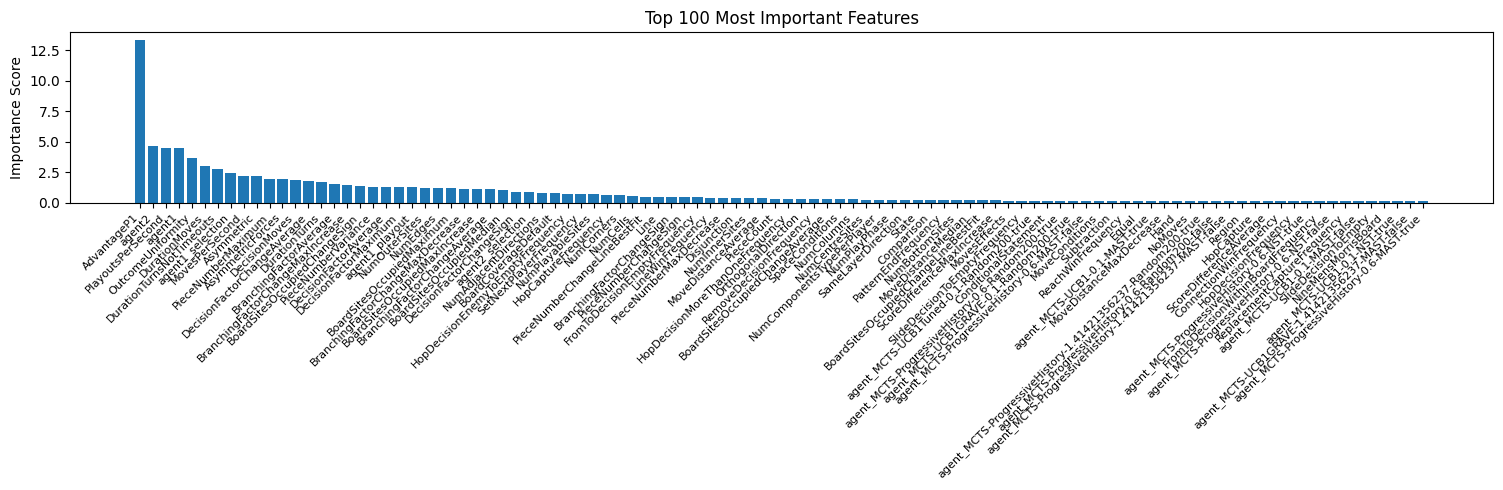

Fold 2 - RMSE: 0.41224649278301445
Fold 3


0:	learn: 0.6287326	test: 0.5777714	best: 0.5777714 (0)	total: 94ms	remaining: 15m 40s


50:	learn: 0.4940797	test: 0.5171898	best: 0.5171898 (50)	total: 4.3s	remaining: 13m 59s


100:	learn: 0.4496231	test: 0.4914732	best: 0.4914732 (100)	total: 8.71s	remaining: 14m 13s


150:	learn: 0.4224184	test: 0.4777219	best: 0.4777219 (150)	total: 13.1s	remaining: 14m 13s


200:	learn: 0.4059999	test: 0.4688789	best: 0.4688789 (200)	total: 17.8s	remaining: 14m 28s


250:	learn: 0.3938654	test: 0.4630508	best: 0.4630508 (250)	total: 22.6s	remaining: 14m 39s


300:	learn: 0.3832959	test: 0.4579464	best: 0.4579464 (300)	total: 27.6s	remaining: 14m 48s


350:	learn: 0.3749823	test: 0.4534564	best: 0.4534564 (350)	total: 32.6s	remaining: 14m 55s


400:	learn: 0.3673293	test: 0.4501534	best: 0.4501534 (400)	total: 37.4s	remaining: 14m 55s


450:	learn: 0.3601255	test: 0.4471740	best: 0.4471740 (450)	total: 42.1s	remaining: 14m 51s


500:	learn: 0.3535094	test: 0.4444531	best: 0.4444531 (500)	total: 46.7s	remaining: 14m 44s


550:	learn: 0.3477747	test: 0.4419223	best: 0.4419223 (550)	total: 51.2s	remaining: 14m 38s


600:	learn: 0.3434110	test: 0.4404682	best: 0.4404682 (600)	total: 55.8s	remaining: 14m 33s


650:	learn: 0.3395216	test: 0.4389244	best: 0.4389244 (650)	total: 1m	remaining: 14m 30s


700:	learn: 0.3359266	test: 0.4376391	best: 0.4376391 (700)	total: 1m 5s	remaining: 14m 28s


750:	learn: 0.3324991	test: 0.4365807	best: 0.4365775 (748)	total: 1m 10s	remaining: 14m 23s


800:	learn: 0.3291156	test: 0.4354649	best: 0.4354579 (799)	total: 1m 14s	remaining: 14m 19s


850:	learn: 0.3263027	test: 0.4346614	best: 0.4346614 (850)	total: 1m 19s	remaining: 14m 15s


900:	learn: 0.3233601	test: 0.4339212	best: 0.4339212 (900)	total: 1m 24s	remaining: 14m 10s


950:	learn: 0.3207312	test: 0.4331851	best: 0.4331851 (950)	total: 1m 28s	remaining: 14m 6s


1000:	learn: 0.3179929	test: 0.4325125	best: 0.4325125 (1000)	total: 1m 33s	remaining: 14m 2s


1050:	learn: 0.3156692	test: 0.4319105	best: 0.4319105 (1050)	total: 1m 38s	remaining: 13m 58s


1100:	learn: 0.3134491	test: 0.4312597	best: 0.4312597 (1100)	total: 1m 43s	remaining: 13m 53s


1150:	learn: 0.3112584	test: 0.4306236	best: 0.4306236 (1150)	total: 1m 48s	remaining: 13m 50s


1200:	learn: 0.3091477	test: 0.4299923	best: 0.4299923 (1200)	total: 1m 53s	remaining: 13m 48s


1250:	learn: 0.3071338	test: 0.4293639	best: 0.4293639 (1250)	total: 1m 57s	remaining: 13m 44s


1300:	learn: 0.3053066	test: 0.4287874	best: 0.4287874 (1300)	total: 2m 2s	remaining: 13m 40s


1350:	learn: 0.3034912	test: 0.4283604	best: 0.4283604 (1350)	total: 2m 7s	remaining: 13m 36s


1400:	learn: 0.3017292	test: 0.4279297	best: 0.4279297 (1400)	total: 2m 12s	remaining: 13m 32s


1450:	learn: 0.3000872	test: 0.4275218	best: 0.4275218 (1450)	total: 2m 17s	remaining: 13m 29s


1500:	learn: 0.2985738	test: 0.4272855	best: 0.4272608 (1482)	total: 2m 22s	remaining: 13m 25s


1550:	learn: 0.2970843	test: 0.4268911	best: 0.4268911 (1550)	total: 2m 27s	remaining: 13m 20s


1600:	learn: 0.2956498	test: 0.4266092	best: 0.4266092 (1600)	total: 2m 31s	remaining: 13m 16s


1650:	learn: 0.2943142	test: 0.4262887	best: 0.4262887 (1650)	total: 2m 36s	remaining: 13m 12s


1700:	learn: 0.2928571	test: 0.4259864	best: 0.4259864 (1700)	total: 2m 41s	remaining: 13m 8s


1750:	learn: 0.2914511	test: 0.4257545	best: 0.4257508 (1743)	total: 2m 46s	remaining: 13m 4s


1800:	learn: 0.2901222	test: 0.4254709	best: 0.4254654 (1799)	total: 2m 51s	remaining: 12m 59s


1850:	learn: 0.2888500	test: 0.4252151	best: 0.4252151 (1850)	total: 2m 56s	remaining: 12m 55s


1900:	learn: 0.2876232	test: 0.4248686	best: 0.4248628 (1899)	total: 3m 1s	remaining: 12m 51s


1950:	learn: 0.2864179	test: 0.4245995	best: 0.4245995 (1950)	total: 3m 5s	remaining: 12m 47s


2000:	learn: 0.2852192	test: 0.4244133	best: 0.4244130 (1999)	total: 3m 10s	remaining: 12m 42s


2050:	learn: 0.2840479	test: 0.4241338	best: 0.4241280 (2049)	total: 3m 15s	remaining: 12m 38s


2100:	learn: 0.2829586	test: 0.4239426	best: 0.4239426 (2100)	total: 3m 20s	remaining: 12m 34s


2150:	learn: 0.2819047	test: 0.4236231	best: 0.4236229 (2149)	total: 3m 25s	remaining: 12m 30s


2200:	learn: 0.2808551	test: 0.4233443	best: 0.4233443 (2200)	total: 3m 30s	remaining: 12m 26s


2250:	learn: 0.2797403	test: 0.4231759	best: 0.4231746 (2245)	total: 3m 35s	remaining: 12m 21s


2300:	learn: 0.2787080	test: 0.4230124	best: 0.4230124 (2300)	total: 3m 40s	remaining: 12m 17s


2350:	learn: 0.2776989	test: 0.4228040	best: 0.4228040 (2350)	total: 3m 45s	remaining: 12m 13s


2400:	learn: 0.2766859	test: 0.4226583	best: 0.4226581 (2399)	total: 3m 50s	remaining: 12m 8s


2450:	learn: 0.2757167	test: 0.4225343	best: 0.4225323 (2444)	total: 3m 55s	remaining: 12m 4s


2500:	learn: 0.2747148	test: 0.4224033	best: 0.4224033 (2500)	total: 4m	remaining: 12m


2550:	learn: 0.2737541	test: 0.4222466	best: 0.4222456 (2549)	total: 4m 5s	remaining: 11m 55s


2600:	learn: 0.2728387	test: 0.4221262	best: 0.4221262 (2600)	total: 4m 10s	remaining: 11m 51s


2650:	learn: 0.2718863	test: 0.4219996	best: 0.4219974 (2649)	total: 4m 15s	remaining: 11m 47s


2700:	learn: 0.2708929	test: 0.4218379	best: 0.4218379 (2700)	total: 4m 20s	remaining: 11m 42s


2750:	learn: 0.2700115	test: 0.4216687	best: 0.4216670 (2749)	total: 4m 25s	remaining: 11m 38s


2800:	learn: 0.2691382	test: 0.4215289	best: 0.4215289 (2800)	total: 4m 29s	remaining: 11m 33s


2850:	learn: 0.2682804	test: 0.4214286	best: 0.4214286 (2850)	total: 4m 34s	remaining: 11m 29s


2900:	learn: 0.2674713	test: 0.4213153	best: 0.4213153 (2899)	total: 4m 39s	remaining: 11m 24s


2950:	learn: 0.2666846	test: 0.4212270	best: 0.4212267 (2948)	total: 4m 44s	remaining: 11m 20s


3000:	learn: 0.2659143	test: 0.4210906	best: 0.4210867 (2998)	total: 4m 49s	remaining: 11m 15s


3050:	learn: 0.2651046	test: 0.4209753	best: 0.4209724 (3048)	total: 4m 54s	remaining: 11m 11s


3100:	learn: 0.2643362	test: 0.4208090	best: 0.4208090 (3100)	total: 4m 59s	remaining: 11m 6s


3150:	learn: 0.2635473	test: 0.4206882	best: 0.4206882 (3150)	total: 5m 4s	remaining: 11m 2s


3200:	learn: 0.2627725	test: 0.4205710	best: 0.4205710 (3200)	total: 5m 9s	remaining: 10m 57s


3250:	learn: 0.2620573	test: 0.4204269	best: 0.4204269 (3250)	total: 5m 14s	remaining: 10m 53s


3300:	learn: 0.2612921	test: 0.4202940	best: 0.4202936 (3299)	total: 5m 19s	remaining: 10m 48s


3350:	learn: 0.2605892	test: 0.4202268	best: 0.4202268 (3350)	total: 5m 24s	remaining: 10m 43s


3400:	learn: 0.2598650	test: 0.4201204	best: 0.4201204 (3400)	total: 5m 29s	remaining: 10m 39s


3450:	learn: 0.2591294	test: 0.4200137	best: 0.4200137 (3450)	total: 5m 34s	remaining: 10m 34s


3500:	learn: 0.2584077	test: 0.4199051	best: 0.4199016 (3498)	total: 5m 39s	remaining: 10m 30s


3550:	learn: 0.2577744	test: 0.4198258	best: 0.4198258 (3549)	total: 5m 44s	remaining: 10m 25s


3600:	learn: 0.2570877	test: 0.4197212	best: 0.4197212 (3600)	total: 5m 49s	remaining: 10m 21s


3650:	learn: 0.2564173	test: 0.4196511	best: 0.4196508 (3647)	total: 5m 54s	remaining: 10m 16s


3700:	learn: 0.2557905	test: 0.4195348	best: 0.4195256 (3696)	total: 5m 59s	remaining: 10m 12s


3750:	learn: 0.2550935	test: 0.4194417	best: 0.4194417 (3750)	total: 6m 4s	remaining: 10m 7s


3800:	learn: 0.2544868	test: 0.4193560	best: 0.4193560 (3800)	total: 6m 9s	remaining: 10m 3s


3850:	learn: 0.2538303	test: 0.4192713	best: 0.4192687 (3839)	total: 6m 14s	remaining: 9m 58s


3900:	learn: 0.2531945	test: 0.4192086	best: 0.4192086 (3900)	total: 6m 19s	remaining: 9m 53s


3950:	learn: 0.2525606	test: 0.4191333	best: 0.4191333 (3950)	total: 6m 24s	remaining: 9m 49s


4000:	learn: 0.2519561	test: 0.4189998	best: 0.4189998 (4000)	total: 6m 29s	remaining: 9m 44s


4050:	learn: 0.2513149	test: 0.4189484	best: 0.4189484 (4050)	total: 6m 34s	remaining: 9m 39s


4100:	learn: 0.2507060	test: 0.4188629	best: 0.4188629 (4100)	total: 6m 39s	remaining: 9m 35s


4150:	learn: 0.2501318	test: 0.4188023	best: 0.4187980 (4129)	total: 6m 44s	remaining: 9m 30s


4200:	learn: 0.2495848	test: 0.4187775	best: 0.4187764 (4197)	total: 6m 50s	remaining: 9m 26s


4250:	learn: 0.2489924	test: 0.4186733	best: 0.4186733 (4250)	total: 6m 55s	remaining: 9m 21s


4300:	learn: 0.2484243	test: 0.4186224	best: 0.4186224 (4300)	total: 7m	remaining: 9m 16s


4350:	learn: 0.2478486	test: 0.4185262	best: 0.4185262 (4350)	total: 7m 5s	remaining: 9m 12s


4400:	learn: 0.2472839	test: 0.4184254	best: 0.4184254 (4400)	total: 7m 10s	remaining: 9m 7s


4450:	learn: 0.2467831	test: 0.4183653	best: 0.4183652 (4443)	total: 7m 15s	remaining: 9m 2s


4500:	learn: 0.2461743	test: 0.4182862	best: 0.4182862 (4500)	total: 7m 20s	remaining: 8m 58s


4550:	learn: 0.2456560	test: 0.4182629	best: 0.4182625 (4548)	total: 7m 25s	remaining: 8m 53s


4600:	learn: 0.2451736	test: 0.4181934	best: 0.4181880 (4592)	total: 7m 30s	remaining: 8m 48s


4650:	learn: 0.2446146	test: 0.4181426	best: 0.4181416 (4649)	total: 7m 35s	remaining: 8m 44s


4700:	learn: 0.2440524	test: 0.4180637	best: 0.4180597 (4698)	total: 7m 40s	remaining: 8m 39s


4750:	learn: 0.2435257	test: 0.4179827	best: 0.4179808 (4746)	total: 7m 45s	remaining: 8m 34s


4800:	learn: 0.2429862	test: 0.4179247	best: 0.4179232 (4798)	total: 7m 50s	remaining: 8m 29s


4850:	learn: 0.2424916	test: 0.4179013	best: 0.4179013 (4850)	total: 7m 55s	remaining: 8m 25s


4900:	learn: 0.2419497	test: 0.4178553	best: 0.4178553 (4900)	total: 8m	remaining: 8m 20s


4950:	learn: 0.2414686	test: 0.4178239	best: 0.4178219 (4945)	total: 8m 6s	remaining: 8m 15s


5000:	learn: 0.2409468	test: 0.4177872	best: 0.4177837 (4989)	total: 8m 11s	remaining: 8m 10s


5050:	learn: 0.2404924	test: 0.4177059	best: 0.4177059 (5050)	total: 8m 16s	remaining: 8m 6s


5100:	learn: 0.2400249	test: 0.4176621	best: 0.4176609 (5086)	total: 8m 21s	remaining: 8m 1s


5150:	learn: 0.2394699	test: 0.4175985	best: 0.4175956 (5148)	total: 8m 26s	remaining: 7m 56s


5200:	learn: 0.2390092	test: 0.4175441	best: 0.4175401 (5196)	total: 8m 31s	remaining: 7m 51s


5250:	learn: 0.2384594	test: 0.4174758	best: 0.4174739 (5246)	total: 8m 36s	remaining: 7m 46s


5300:	learn: 0.2379787	test: 0.4174393	best: 0.4174393 (5300)	total: 8m 41s	remaining: 7m 41s


5350:	learn: 0.2375131	test: 0.4173979	best: 0.4173910 (5349)	total: 8m 46s	remaining: 7m 37s


5400:	learn: 0.2370519	test: 0.4173790	best: 0.4173708 (5386)	total: 8m 51s	remaining: 7m 32s


5450:	learn: 0.2365946	test: 0.4173534	best: 0.4173480 (5449)	total: 8m 56s	remaining: 7m 27s


5500:	learn: 0.2361341	test: 0.4173026	best: 0.4173014 (5492)	total: 9m 1s	remaining: 7m 22s


5550:	learn: 0.2356796	test: 0.4172644	best: 0.4172588 (5547)	total: 9m 6s	remaining: 7m 18s


5600:	learn: 0.2351792	test: 0.4171967	best: 0.4171956 (5596)	total: 9m 11s	remaining: 7m 13s


5650:	learn: 0.2347439	test: 0.4171590	best: 0.4171563 (5647)	total: 9m 16s	remaining: 7m 8s


5700:	learn: 0.2342995	test: 0.4171195	best: 0.4171195 (5700)	total: 9m 21s	remaining: 7m 3s


5750:	learn: 0.2338402	test: 0.4171033	best: 0.4170989 (5748)	total: 9m 26s	remaining: 6m 58s


5800:	learn: 0.2333977	test: 0.4170693	best: 0.4170693 (5800)	total: 9m 31s	remaining: 6m 54s


5850:	learn: 0.2329577	test: 0.4170078	best: 0.4170022 (5848)	total: 9m 37s	remaining: 6m 49s


5900:	learn: 0.2325067	test: 0.4169878	best: 0.4169771 (5888)	total: 9m 42s	remaining: 6m 44s


5950:	learn: 0.2320467	test: 0.4169176	best: 0.4169176 (5950)	total: 9m 47s	remaining: 6m 39s


6000:	learn: 0.2316302	test: 0.4168579	best: 0.4168579 (6000)	total: 9m 52s	remaining: 6m 34s


6050:	learn: 0.2311813	test: 0.4167956	best: 0.4167925 (6041)	total: 9m 57s	remaining: 6m 29s


6100:	learn: 0.2307498	test: 0.4167513	best: 0.4167511 (6099)	total: 10m 2s	remaining: 6m 24s


6150:	learn: 0.2303457	test: 0.4167083	best: 0.4167083 (6150)	total: 10m 7s	remaining: 6m 20s


6200:	learn: 0.2298912	test: 0.4166968	best: 0.4166936 (6192)	total: 10m 12s	remaining: 6m 15s


6250:	learn: 0.2294930	test: 0.4166667	best: 0.4166542 (6248)	total: 10m 17s	remaining: 6m 10s


6300:	learn: 0.2290560	test: 0.4166319	best: 0.4166319 (6300)	total: 10m 22s	remaining: 6m 5s


6350:	learn: 0.2286558	test: 0.4165626	best: 0.4165626 (6350)	total: 10m 27s	remaining: 6m


6400:	learn: 0.2282568	test: 0.4165207	best: 0.4165196 (6399)	total: 10m 32s	remaining: 5m 55s


6450:	learn: 0.2278365	test: 0.4165020	best: 0.4165020 (6450)	total: 10m 37s	remaining: 5m 50s


6500:	learn: 0.2274309	test: 0.4165209	best: 0.4165011 (6451)	total: 10m 42s	remaining: 5m 46s


6550:	learn: 0.2270175	test: 0.4164982	best: 0.4164981 (6549)	total: 10m 47s	remaining: 5m 41s


6600:	learn: 0.2266174	test: 0.4164583	best: 0.4164517 (6582)	total: 10m 53s	remaining: 5m 36s


6650:	learn: 0.2262380	test: 0.4164367	best: 0.4164361 (6649)	total: 10m 58s	remaining: 5m 31s


6700:	learn: 0.2258554	test: 0.4164155	best: 0.4164155 (6700)	total: 11m 3s	remaining: 5m 26s


6750:	learn: 0.2254496	test: 0.4163678	best: 0.4163678 (6750)	total: 11m 8s	remaining: 5m 21s


6800:	learn: 0.2250481	test: 0.4163447	best: 0.4163424 (6798)	total: 11m 13s	remaining: 5m 16s


6850:	learn: 0.2246671	test: 0.4162913	best: 0.4162913 (6850)	total: 11m 18s	remaining: 5m 11s


6900:	learn: 0.2243169	test: 0.4162595	best: 0.4162540 (6895)	total: 11m 23s	remaining: 5m 7s


6950:	learn: 0.2238975	test: 0.4162178	best: 0.4162178 (6950)	total: 11m 28s	remaining: 5m 2s


7000:	learn: 0.2235253	test: 0.4162012	best: 0.4161959 (6995)	total: 11m 33s	remaining: 4m 57s


7050:	learn: 0.2231736	test: 0.4161798	best: 0.4161798 (7050)	total: 11m 38s	remaining: 4m 52s


7100:	learn: 0.2227814	test: 0.4161448	best: 0.4161448 (7100)	total: 11m 44s	remaining: 4m 47s


7150:	learn: 0.2224318	test: 0.4161285	best: 0.4161285 (7150)	total: 11m 49s	remaining: 4m 42s


7200:	learn: 0.2220771	test: 0.4160957	best: 0.4160957 (7200)	total: 11m 54s	remaining: 4m 37s


7250:	learn: 0.2216916	test: 0.4160579	best: 0.4160575 (7239)	total: 11m 59s	remaining: 4m 32s


7300:	learn: 0.2212636	test: 0.4159813	best: 0.4159784 (7297)	total: 12m 4s	remaining: 4m 27s


7350:	learn: 0.2209169	test: 0.4159519	best: 0.4159519 (7350)	total: 12m 9s	remaining: 4m 22s


7400:	learn: 0.2205602	test: 0.4159398	best: 0.4159385 (7399)	total: 12m 14s	remaining: 4m 18s


7450:	learn: 0.2202035	test: 0.4159101	best: 0.4159093 (7449)	total: 12m 19s	remaining: 4m 13s


7500:	learn: 0.2198043	test: 0.4158736	best: 0.4158722 (7497)	total: 12m 25s	remaining: 4m 8s


7550:	learn: 0.2194314	test: 0.4158484	best: 0.4158484 (7550)	total: 12m 30s	remaining: 4m 3s


7600:	learn: 0.2190735	test: 0.4158244	best: 0.4158238 (7599)	total: 12m 35s	remaining: 3m 58s


7650:	learn: 0.2187178	test: 0.4157954	best: 0.4157954 (7650)	total: 12m 40s	remaining: 3m 53s


7700:	learn: 0.2183729	test: 0.4157498	best: 0.4157498 (7700)	total: 12m 45s	remaining: 3m 48s


7750:	learn: 0.2180118	test: 0.4157398	best: 0.4157347 (7741)	total: 12m 50s	remaining: 3m 43s


7800:	learn: 0.2176387	test: 0.4157087	best: 0.4157068 (7799)	total: 12m 55s	remaining: 3m 38s


7850:	learn: 0.2173059	test: 0.4156826	best: 0.4156817 (7849)	total: 13m	remaining: 3m 33s


7900:	learn: 0.2169642	test: 0.4156632	best: 0.4156627 (7892)	total: 13m 5s	remaining: 3m 28s


7950:	learn: 0.2166294	test: 0.4156594	best: 0.4156576 (7935)	total: 13m 10s	remaining: 3m 23s


8000:	learn: 0.2162645	test: 0.4156294	best: 0.4156278 (7998)	total: 13m 15s	remaining: 3m 18s


8050:	learn: 0.2159125	test: 0.4156328	best: 0.4156132 (8026)	total: 13m 21s	remaining: 3m 13s


8100:	learn: 0.2155800	test: 0.4155896	best: 0.4155894 (8099)	total: 13m 26s	remaining: 3m 8s


8150:	learn: 0.2152574	test: 0.4155997	best: 0.4155894 (8105)	total: 13m 31s	remaining: 3m 4s


8200:	learn: 0.2149105	test: 0.4156007	best: 0.4155894 (8105)	total: 13m 36s	remaining: 2m 59s


8250:	learn: 0.2145961	test: 0.4155732	best: 0.4155732 (8250)	total: 13m 41s	remaining: 2m 54s


8300:	learn: 0.2142880	test: 0.4155606	best: 0.4155544 (8270)	total: 13m 46s	remaining: 2m 49s


8350:	learn: 0.2139517	test: 0.4155126	best: 0.4155121 (8349)	total: 13m 51s	remaining: 2m 44s


8400:	learn: 0.2135903	test: 0.4154887	best: 0.4154879 (8398)	total: 13m 56s	remaining: 2m 39s


8450:	learn: 0.2132485	test: 0.4154628	best: 0.4154586 (8441)	total: 14m 2s	remaining: 2m 34s


8500:	learn: 0.2129405	test: 0.4154576	best: 0.4154540 (8497)	total: 14m 7s	remaining: 2m 29s


8550:	learn: 0.2126037	test: 0.4154132	best: 0.4154113 (8545)	total: 14m 12s	remaining: 2m 24s


8600:	learn: 0.2122539	test: 0.4154010	best: 0.4153983 (8579)	total: 14m 17s	remaining: 2m 19s


8650:	learn: 0.2119003	test: 0.4153759	best: 0.4153747 (8646)	total: 14m 22s	remaining: 2m 14s


8700:	learn: 0.2115685	test: 0.4153564	best: 0.4153539 (8688)	total: 14m 27s	remaining: 2m 9s


8750:	learn: 0.2112419	test: 0.4153491	best: 0.4153490 (8748)	total: 14m 32s	remaining: 2m 4s


8800:	learn: 0.2109411	test: 0.4153339	best: 0.4153295 (8782)	total: 14m 37s	remaining: 1m 59s


8850:	learn: 0.2106207	test: 0.4153283	best: 0.4153274 (8847)	total: 14m 42s	remaining: 1m 54s


8900:	learn: 0.2102940	test: 0.4153000	best: 0.4152979 (8893)	total: 14m 47s	remaining: 1m 49s


8950:	learn: 0.2100027	test: 0.4152917	best: 0.4152819 (8927)	total: 14m 53s	remaining: 1m 44s


9000:	learn: 0.2096856	test: 0.4152685	best: 0.4152685 (9000)	total: 14m 58s	remaining: 1m 39s


9050:	learn: 0.2093876	test: 0.4152593	best: 0.4152563 (9048)	total: 15m 3s	remaining: 1m 34s


9100:	learn: 0.2090736	test: 0.4152425	best: 0.4152407 (9098)	total: 15m 8s	remaining: 1m 29s


9150:	learn: 0.2087588	test: 0.4152197	best: 0.4152197 (9150)	total: 15m 13s	remaining: 1m 24s


9200:	learn: 0.2084589	test: 0.4151995	best: 0.4151990 (9198)	total: 15m 18s	remaining: 1m 19s


9250:	learn: 0.2081422	test: 0.4151805	best: 0.4151783 (9247)	total: 15m 23s	remaining: 1m 14s


9300:	learn: 0.2078287	test: 0.4151448	best: 0.4151438 (9299)	total: 15m 28s	remaining: 1m 9s


9350:	learn: 0.2075141	test: 0.4151195	best: 0.4151186 (9342)	total: 15m 33s	remaining: 1m 4s


9400:	learn: 0.2072334	test: 0.4151348	best: 0.4151186 (9342)	total: 15m 39s	remaining: 59.8s


9450:	learn: 0.2069190	test: 0.4151198	best: 0.4151174 (9444)	total: 15m 44s	remaining: 54.9s


9500:	learn: 0.2066143	test: 0.4151011	best: 0.4150993 (9486)	total: 15m 49s	remaining: 49.9s


9550:	learn: 0.2062993	test: 0.4150897	best: 0.4150897 (9550)	total: 15m 54s	remaining: 44.9s


9600:	learn: 0.2060126	test: 0.4150838	best: 0.4150788 (9578)	total: 15m 59s	remaining: 39.9s


9650:	learn: 0.2057189	test: 0.4150533	best: 0.4150483 (9631)	total: 16m 4s	remaining: 34.9s


9700:	learn: 0.2053889	test: 0.4150434	best: 0.4150391 (9673)	total: 16m 9s	remaining: 29.9s


9750:	learn: 0.2050824	test: 0.4150195	best: 0.4150188 (9749)	total: 16m 15s	remaining: 24.9s


9800:	learn: 0.2047861	test: 0.4150025	best: 0.4150008 (9788)	total: 16m 20s	remaining: 19.9s


9850:	learn: 0.2044929	test: 0.4150106	best: 0.4149924 (9821)	total: 16m 25s	remaining: 14.9s


9900:	learn: 0.2042222	test: 0.4149978	best: 0.4149924 (9821)	total: 16m 30s	remaining: 9.9s


9950:	learn: 0.2039268	test: 0.4149862	best: 0.4149858 (9946)	total: 16m 35s	remaining: 4.9s


9999:	learn: 0.2036509	test: 0.4149656	best: 0.4149656 (9999)	total: 16m 40s	remaining: 0us

bestTest = 0.4149655503
bestIteration = 9999



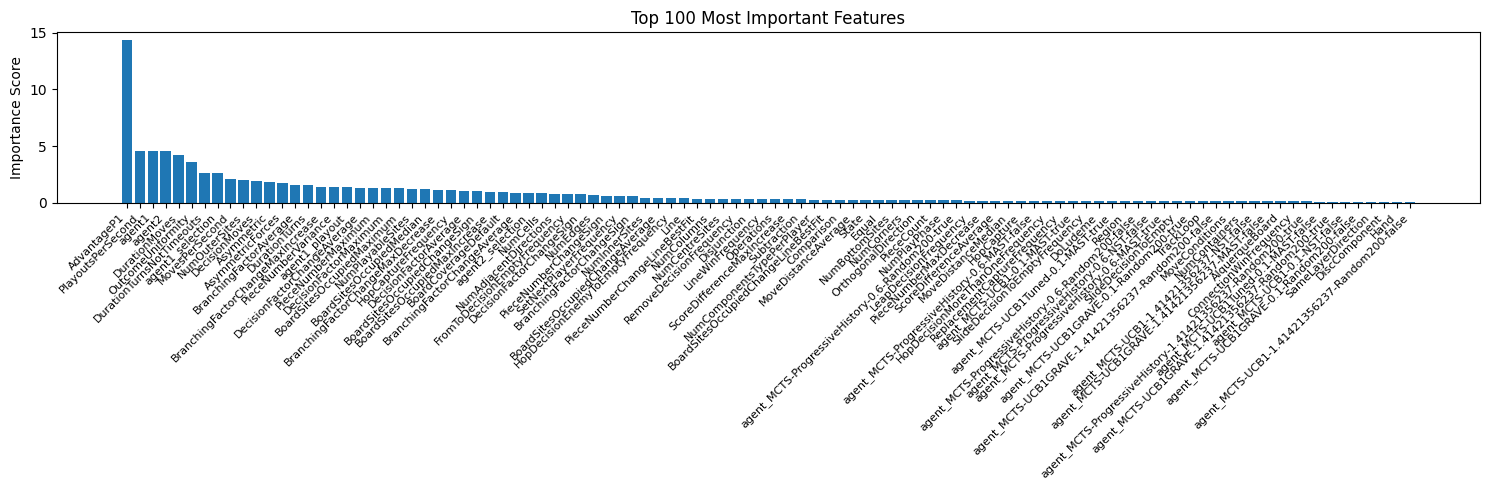

Fold 3 - RMSE: 0.414705831774623
Fold 4


0:	learn: 0.6284757	test: 0.5752251	best: 0.5752251 (0)	total: 95.7ms	remaining: 15m 56s


50:	learn: 0.4952323	test: 0.5082679	best: 0.5082679 (50)	total: 4.39s	remaining: 14m 17s


100:	learn: 0.4487041	test: 0.4855713	best: 0.4855713 (100)	total: 8.68s	remaining: 14m 10s


150:	learn: 0.4241805	test: 0.4726332	best: 0.4726332 (150)	total: 13.1s	remaining: 14m 16s


200:	learn: 0.4056033	test: 0.4624427	best: 0.4624427 (200)	total: 17.9s	remaining: 14m 30s


250:	learn: 0.3933483	test: 0.4571852	best: 0.4571852 (250)	total: 22.7s	remaining: 14m 40s


300:	learn: 0.3844768	test: 0.4537032	best: 0.4537032 (300)	total: 27.7s	remaining: 14m 53s


350:	learn: 0.3762926	test: 0.4497955	best: 0.4497955 (350)	total: 32.7s	remaining: 15m


400:	learn: 0.3692288	test: 0.4467618	best: 0.4467618 (400)	total: 37.7s	remaining: 15m 1s


450:	learn: 0.3631024	test: 0.4448078	best: 0.4448078 (450)	total: 42.5s	remaining: 15m


500:	learn: 0.3563407	test: 0.4420352	best: 0.4420350 (499)	total: 47.2s	remaining: 14m 54s


550:	learn: 0.3507540	test: 0.4400957	best: 0.4400957 (550)	total: 51.7s	remaining: 14m 47s


600:	learn: 0.3462578	test: 0.4388041	best: 0.4388041 (600)	total: 56.4s	remaining: 14m 42s


650:	learn: 0.3421675	test: 0.4373827	best: 0.4373827 (650)	total: 1m 1s	remaining: 14m 39s


700:	learn: 0.3385426	test: 0.4362380	best: 0.4362380 (700)	total: 1m 5s	remaining: 14m 35s


750:	learn: 0.3353043	test: 0.4353017	best: 0.4353017 (750)	total: 1m 10s	remaining: 14m 31s


800:	learn: 0.3322256	test: 0.4343787	best: 0.4343787 (800)	total: 1m 15s	remaining: 14m 27s


850:	learn: 0.3293409	test: 0.4336104	best: 0.4336104 (850)	total: 1m 20s	remaining: 14m 24s


900:	learn: 0.3266258	test: 0.4327480	best: 0.4327480 (900)	total: 1m 25s	remaining: 14m 19s


950:	learn: 0.3241462	test: 0.4321682	best: 0.4321682 (950)	total: 1m 29s	remaining: 14m 15s


1000:	learn: 0.3220285	test: 0.4314246	best: 0.4314246 (1000)	total: 1m 34s	remaining: 14m 13s


1050:	learn: 0.3196645	test: 0.4307724	best: 0.4307684 (1049)	total: 1m 39s	remaining: 14m 10s


1100:	learn: 0.3175559	test: 0.4302246	best: 0.4302246 (1100)	total: 1m 44s	remaining: 14m 7s


1150:	learn: 0.3155027	test: 0.4296962	best: 0.4296855 (1148)	total: 1m 49s	remaining: 14m 3s


1200:	learn: 0.3135667	test: 0.4291812	best: 0.4291812 (1200)	total: 1m 54s	remaining: 13m 58s


1250:	learn: 0.3115985	test: 0.4287713	best: 0.4287713 (1250)	total: 1m 59s	remaining: 13m 55s


1300:	learn: 0.3098319	test: 0.4283423	best: 0.4283423 (1300)	total: 2m 4s	remaining: 13m 51s


1350:	learn: 0.3081279	test: 0.4279940	best: 0.4279940 (1350)	total: 2m 9s	remaining: 13m 48s


1400:	learn: 0.3064562	test: 0.4275870	best: 0.4275870 (1400)	total: 2m 14s	remaining: 13m 45s


1450:	learn: 0.3047766	test: 0.4273778	best: 0.4273778 (1450)	total: 2m 19s	remaining: 13m 41s


1500:	learn: 0.3031481	test: 0.4269756	best: 0.4269756 (1500)	total: 2m 24s	remaining: 13m 37s


1550:	learn: 0.3014894	test: 0.4266420	best: 0.4266358 (1549)	total: 2m 29s	remaining: 13m 33s


1600:	learn: 0.2998567	test: 0.4263394	best: 0.4263394 (1600)	total: 2m 34s	remaining: 13m 28s


1650:	learn: 0.2984907	test: 0.4261080	best: 0.4261080 (1650)	total: 2m 39s	remaining: 13m 24s


1700:	learn: 0.2969821	test: 0.4258242	best: 0.4258242 (1700)	total: 2m 44s	remaining: 13m 20s


1750:	learn: 0.2955427	test: 0.4256403	best: 0.4256356 (1748)	total: 2m 48s	remaining: 13m 15s


1800:	learn: 0.2942447	test: 0.4254612	best: 0.4254589 (1796)	total: 2m 54s	remaining: 13m 12s


1850:	learn: 0.2929980	test: 0.4251123	best: 0.4251123 (1850)	total: 2m 59s	remaining: 13m 8s


1900:	learn: 0.2917442	test: 0.4249930	best: 0.4249924 (1899)	total: 3m 3s	remaining: 13m 3s


1950:	learn: 0.2905623	test: 0.4246486	best: 0.4246422 (1949)	total: 3m 9s	remaining: 12m 59s


2000:	learn: 0.2893017	test: 0.4242286	best: 0.4242286 (2000)	total: 3m 13s	remaining: 12m 55s


2050:	learn: 0.2881293	test: 0.4240386	best: 0.4240368 (2048)	total: 3m 19s	remaining: 12m 51s


2100:	learn: 0.2869090	test: 0.4238319	best: 0.4238178 (2097)	total: 3m 24s	remaining: 12m 48s


2150:	learn: 0.2856537	test: 0.4235986	best: 0.4235986 (2150)	total: 3m 29s	remaining: 12m 44s


2200:	learn: 0.2844951	test: 0.4233451	best: 0.4233451 (2200)	total: 3m 34s	remaining: 12m 40s


2250:	learn: 0.2833956	test: 0.4231647	best: 0.4231616 (2247)	total: 3m 39s	remaining: 12m 36s


2300:	learn: 0.2823686	test: 0.4229687	best: 0.4229560 (2299)	total: 3m 44s	remaining: 12m 31s


2350:	learn: 0.2813750	test: 0.4227802	best: 0.4227802 (2350)	total: 3m 49s	remaining: 12m 27s


2400:	learn: 0.2803277	test: 0.4225998	best: 0.4225998 (2400)	total: 3m 54s	remaining: 12m 22s


2450:	learn: 0.2793651	test: 0.4224688	best: 0.4224688 (2450)	total: 3m 59s	remaining: 12m 18s


2500:	learn: 0.2783014	test: 0.4222316	best: 0.4222316 (2500)	total: 4m 4s	remaining: 12m 13s


2550:	learn: 0.2773057	test: 0.4220895	best: 0.4220895 (2550)	total: 4m 9s	remaining: 12m 8s


2600:	learn: 0.2763416	test: 0.4219652	best: 0.4219652 (2600)	total: 4m 14s	remaining: 12m 4s


2650:	learn: 0.2752910	test: 0.4218363	best: 0.4218363 (2650)	total: 4m 19s	remaining: 11m 59s


2700:	learn: 0.2744014	test: 0.4216867	best: 0.4216735 (2697)	total: 4m 24s	remaining: 11m 54s


2750:	learn: 0.2734886	test: 0.4215980	best: 0.4215980 (2750)	total: 4m 29s	remaining: 11m 50s


2800:	learn: 0.2726044	test: 0.4214560	best: 0.4214480 (2790)	total: 4m 34s	remaining: 11m 45s


2850:	learn: 0.2718115	test: 0.4213080	best: 0.4213052 (2849)	total: 4m 39s	remaining: 11m 41s


2900:	learn: 0.2709200	test: 0.4211321	best: 0.4211290 (2899)	total: 4m 44s	remaining: 11m 36s


2950:	learn: 0.2701143	test: 0.4210376	best: 0.4210345 (2948)	total: 4m 49s	remaining: 11m 31s


3000:	learn: 0.2692844	test: 0.4208926	best: 0.4208917 (2992)	total: 4m 54s	remaining: 11m 27s


3050:	learn: 0.2684930	test: 0.4208104	best: 0.4208104 (3050)	total: 4m 59s	remaining: 11m 22s


3100:	learn: 0.2677200	test: 0.4207242	best: 0.4207242 (3100)	total: 5m 4s	remaining: 11m 18s


3150:	learn: 0.2669198	test: 0.4206211	best: 0.4206197 (3148)	total: 5m 9s	remaining: 11m 13s


3200:	learn: 0.2662218	test: 0.4205374	best: 0.4205345 (3196)	total: 5m 14s	remaining: 11m 8s


3250:	learn: 0.2654709	test: 0.4204108	best: 0.4204108 (3250)	total: 5m 19s	remaining: 11m 4s


3300:	learn: 0.2647320	test: 0.4202685	best: 0.4202685 (3300)	total: 5m 25s	remaining: 10m 59s


3350:	learn: 0.2639919	test: 0.4201644	best: 0.4201624 (3349)	total: 5m 30s	remaining: 10m 55s


3400:	learn: 0.2632434	test: 0.4200630	best: 0.4200630 (3400)	total: 5m 35s	remaining: 10m 50s


3450:	learn: 0.2625408	test: 0.4199977	best: 0.4199918 (3440)	total: 5m 40s	remaining: 10m 45s


3500:	learn: 0.2618220	test: 0.4199309	best: 0.4199309 (3500)	total: 5m 45s	remaining: 10m 41s


3550:	learn: 0.2611572	test: 0.4197982	best: 0.4197982 (3550)	total: 5m 50s	remaining: 10m 36s


3600:	learn: 0.2604716	test: 0.4196828	best: 0.4196828 (3600)	total: 5m 55s	remaining: 10m 31s


3650:	learn: 0.2597912	test: 0.4195715	best: 0.4195675 (3649)	total: 6m	remaining: 10m 27s


3700:	learn: 0.2591572	test: 0.4194973	best: 0.4194930 (3687)	total: 6m 6s	remaining: 10m 23s


3750:	learn: 0.2584932	test: 0.4193783	best: 0.4193783 (3750)	total: 6m 11s	remaining: 10m 18s


3800:	learn: 0.2578113	test: 0.4192954	best: 0.4192954 (3800)	total: 6m 16s	remaining: 10m 14s


3850:	learn: 0.2571674	test: 0.4192468	best: 0.4192468 (3850)	total: 6m 21s	remaining: 10m 9s


3900:	learn: 0.2565388	test: 0.4192464	best: 0.4192304 (3885)	total: 6m 26s	remaining: 10m 4s


3950:	learn: 0.2559693	test: 0.4192162	best: 0.4192161 (3948)	total: 6m 31s	remaining: 9m 59s


4000:	learn: 0.2553531	test: 0.4191617	best: 0.4191524 (3993)	total: 6m 36s	remaining: 9m 55s


4050:	learn: 0.2546974	test: 0.4190724	best: 0.4190724 (4050)	total: 6m 41s	remaining: 9m 50s


4100:	learn: 0.2540711	test: 0.4190266	best: 0.4190183 (4097)	total: 6m 46s	remaining: 9m 45s


4150:	learn: 0.2534421	test: 0.4189632	best: 0.4189632 (4150)	total: 6m 51s	remaining: 9m 40s


4200:	learn: 0.2528195	test: 0.4188694	best: 0.4188694 (4200)	total: 6m 56s	remaining: 9m 35s


4250:	learn: 0.2522423	test: 0.4187453	best: 0.4187453 (4250)	total: 7m 1s	remaining: 9m 30s


4300:	learn: 0.2516796	test: 0.4186862	best: 0.4186862 (4300)	total: 7m 7s	remaining: 9m 25s


4350:	learn: 0.2511399	test: 0.4185991	best: 0.4185946 (4348)	total: 7m 12s	remaining: 9m 21s


4400:	learn: 0.2505040	test: 0.4185021	best: 0.4185021 (4400)	total: 7m 17s	remaining: 9m 16s


4450:	learn: 0.2499618	test: 0.4184487	best: 0.4184487 (4450)	total: 7m 22s	remaining: 9m 11s


4500:	learn: 0.2493676	test: 0.4183730	best: 0.4183624 (4494)	total: 7m 27s	remaining: 9m 6s


4550:	learn: 0.2487780	test: 0.4183323	best: 0.4183315 (4549)	total: 7m 32s	remaining: 9m 1s


4600:	learn: 0.2482082	test: 0.4182747	best: 0.4182713 (4595)	total: 7m 37s	remaining: 8m 56s


4650:	learn: 0.2476358	test: 0.4182019	best: 0.4182019 (4650)	total: 7m 42s	remaining: 8m 51s


4700:	learn: 0.2470980	test: 0.4181627	best: 0.4181580 (4696)	total: 7m 47s	remaining: 8m 46s


4750:	learn: 0.2465332	test: 0.4181008	best: 0.4180982 (4740)	total: 7m 52s	remaining: 8m 41s


4800:	learn: 0.2460247	test: 0.4180585	best: 0.4180501 (4790)	total: 7m 57s	remaining: 8m 36s


4850:	learn: 0.2454909	test: 0.4179759	best: 0.4179740 (4847)	total: 8m 2s	remaining: 8m 31s


4900:	learn: 0.2449744	test: 0.4179346	best: 0.4179304 (4892)	total: 8m 7s	remaining: 8m 26s


4950:	learn: 0.2444012	test: 0.4178455	best: 0.4178455 (4950)	total: 8m 12s	remaining: 8m 22s


5000:	learn: 0.2438783	test: 0.4177953	best: 0.4177919 (4992)	total: 8m 17s	remaining: 8m 17s


5050:	learn: 0.2433655	test: 0.4177403	best: 0.4177401 (5049)	total: 8m 22s	remaining: 8m 12s


5100:	learn: 0.2429093	test: 0.4177127	best: 0.4177030 (5091)	total: 8m 27s	remaining: 8m 7s


5150:	learn: 0.2424045	test: 0.4176799	best: 0.4176736 (5134)	total: 8m 32s	remaining: 8m 2s


5200:	learn: 0.2419030	test: 0.4176551	best: 0.4176551 (5200)	total: 8m 37s	remaining: 7m 57s


5250:	learn: 0.2414024	test: 0.4176107	best: 0.4176031 (5244)	total: 8m 42s	remaining: 7m 52s


5300:	learn: 0.2409059	test: 0.4175717	best: 0.4175676 (5289)	total: 8m 48s	remaining: 7m 48s


5350:	learn: 0.2404429	test: 0.4175317	best: 0.4175308 (5348)	total: 8m 53s	remaining: 7m 43s


5400:	learn: 0.2399628	test: 0.4174932	best: 0.4174921 (5394)	total: 8m 58s	remaining: 7m 38s


5450:	learn: 0.2394732	test: 0.4174365	best: 0.4174363 (5447)	total: 9m 3s	remaining: 7m 33s


5500:	learn: 0.2389511	test: 0.4173710	best: 0.4173710 (5500)	total: 9m 8s	remaining: 7m 28s


5550:	learn: 0.2384929	test: 0.4173467	best: 0.4173419 (5547)	total: 9m 13s	remaining: 7m 23s


5600:	learn: 0.2380466	test: 0.4173249	best: 0.4173249 (5600)	total: 9m 18s	remaining: 7m 18s


5650:	learn: 0.2375689	test: 0.4173119	best: 0.4173119 (5650)	total: 9m 23s	remaining: 7m 13s


5700:	learn: 0.2371152	test: 0.4172603	best: 0.4172592 (5699)	total: 9m 28s	remaining: 7m 8s


5750:	learn: 0.2366570	test: 0.4172197	best: 0.4172197 (5750)	total: 9m 33s	remaining: 7m 3s


5800:	learn: 0.2362580	test: 0.4171738	best: 0.4171738 (5800)	total: 9m 38s	remaining: 6m 58s


5850:	learn: 0.2358291	test: 0.4171908	best: 0.4171714 (5811)	total: 9m 43s	remaining: 6m 54s


5900:	learn: 0.2353811	test: 0.4171749	best: 0.4171637 (5882)	total: 9m 49s	remaining: 6m 49s


5950:	learn: 0.2349329	test: 0.4171486	best: 0.4171382 (5931)	total: 9m 54s	remaining: 6m 44s


6000:	learn: 0.2345078	test: 0.4171081	best: 0.4171050 (5995)	total: 9m 59s	remaining: 6m 39s


6050:	learn: 0.2340553	test: 0.4170630	best: 0.4170630 (6050)	total: 10m 4s	remaining: 6m 34s


6100:	learn: 0.2336531	test: 0.4170238	best: 0.4170212 (6099)	total: 10m 9s	remaining: 6m 29s


6150:	learn: 0.2332152	test: 0.4169940	best: 0.4169870 (6135)	total: 10m 14s	remaining: 6m 24s


6200:	learn: 0.2327978	test: 0.4169697	best: 0.4169686 (6197)	total: 10m 20s	remaining: 6m 19s


6250:	learn: 0.2323611	test: 0.4169251	best: 0.4169226 (6248)	total: 10m 25s	remaining: 6m 14s


6300:	learn: 0.2319313	test: 0.4168815	best: 0.4168815 (6300)	total: 10m 30s	remaining: 6m 9s


6350:	learn: 0.2315048	test: 0.4168137	best: 0.4168137 (6350)	total: 10m 35s	remaining: 6m 4s


6400:	learn: 0.2311159	test: 0.4167907	best: 0.4167907 (6400)	total: 10m 40s	remaining: 6m


6450:	learn: 0.2306826	test: 0.4167682	best: 0.4167675 (6448)	total: 10m 45s	remaining: 5m 55s


6500:	learn: 0.2302460	test: 0.4166945	best: 0.4166945 (6500)	total: 10m 50s	remaining: 5m 50s


6550:	learn: 0.2298260	test: 0.4166455	best: 0.4166422 (6549)	total: 10m 55s	remaining: 5m 45s


6600:	learn: 0.2294130	test: 0.4166195	best: 0.4166195 (6600)	total: 11m	remaining: 5m 40s


6650:	learn: 0.2290010	test: 0.4165657	best: 0.4165657 (6650)	total: 11m 5s	remaining: 5m 35s


6700:	learn: 0.2285746	test: 0.4165285	best: 0.4165272 (6698)	total: 11m 10s	remaining: 5m 30s


6750:	learn: 0.2281618	test: 0.4165128	best: 0.4165088 (6734)	total: 11m 15s	remaining: 5m 25s


6800:	learn: 0.2277857	test: 0.4164737	best: 0.4164702 (6797)	total: 11m 21s	remaining: 5m 20s


6850:	learn: 0.2273941	test: 0.4164180	best: 0.4164180 (6850)	total: 11m 26s	remaining: 5m 15s


6900:	learn: 0.2269721	test: 0.4163539	best: 0.4163535 (6896)	total: 11m 31s	remaining: 5m 10s


6950:	learn: 0.2265854	test: 0.4163709	best: 0.4163509 (6902)	total: 11m 36s	remaining: 5m 5s


7000:	learn: 0.2261795	test: 0.4163754	best: 0.4163509 (6902)	total: 11m 41s	remaining: 5m


7050:	learn: 0.2257992	test: 0.4163646	best: 0.4163509 (6902)	total: 11m 46s	remaining: 4m 55s


7100:	learn: 0.2254181	test: 0.4163285	best: 0.4163280 (7099)	total: 11m 51s	remaining: 4m 50s


7150:	learn: 0.2250050	test: 0.4163041	best: 0.4163010 (7148)	total: 11m 56s	remaining: 4m 45s


7200:	learn: 0.2246065	test: 0.4162827	best: 0.4162792 (7199)	total: 12m 1s	remaining: 4m 40s


7250:	learn: 0.2242387	test: 0.4162386	best: 0.4162373 (7249)	total: 12m 6s	remaining: 4m 35s


7300:	learn: 0.2238307	test: 0.4161871	best: 0.4161868 (7296)	total: 12m 11s	remaining: 4m 30s


7350:	learn: 0.2234591	test: 0.4161783	best: 0.4161778 (7312)	total: 12m 17s	remaining: 4m 25s


7400:	learn: 0.2230771	test: 0.4161445	best: 0.4161445 (7400)	total: 12m 22s	remaining: 4m 20s


7450:	learn: 0.2227095	test: 0.4161463	best: 0.4161392 (7405)	total: 12m 27s	remaining: 4m 15s


7500:	learn: 0.2223458	test: 0.4161217	best: 0.4161217 (7500)	total: 12m 32s	remaining: 4m 10s


7550:	learn: 0.2219879	test: 0.4160963	best: 0.4160963 (7550)	total: 12m 37s	remaining: 4m 5s


7600:	learn: 0.2216546	test: 0.4160771	best: 0.4160762 (7587)	total: 12m 42s	remaining: 4m


7650:	learn: 0.2212772	test: 0.4160304	best: 0.4160304 (7650)	total: 12m 47s	remaining: 3m 55s


7700:	learn: 0.2208870	test: 0.4159942	best: 0.4159877 (7696)	total: 12m 52s	remaining: 3m 50s


7750:	learn: 0.2205495	test: 0.4159719	best: 0.4159719 (7750)	total: 12m 58s	remaining: 3m 45s


7800:	learn: 0.2202243	test: 0.4159457	best: 0.4159441 (7799)	total: 13m 3s	remaining: 3m 40s


7850:	learn: 0.2198842	test: 0.4159353	best: 0.4159302 (7822)	total: 13m 8s	remaining: 3m 35s


7900:	learn: 0.2195372	test: 0.4159086	best: 0.4159079 (7897)	total: 13m 13s	remaining: 3m 30s


7950:	learn: 0.2191579	test: 0.4158978	best: 0.4158963 (7947)	total: 13m 18s	remaining: 3m 25s


8000:	learn: 0.2188331	test: 0.4158625	best: 0.4158608 (7999)	total: 13m 23s	remaining: 3m 20s


8050:	learn: 0.2184908	test: 0.4158432	best: 0.4158409 (8047)	total: 13m 28s	remaining: 3m 15s


8100:	learn: 0.2181539	test: 0.4158250	best: 0.4158244 (8095)	total: 13m 33s	remaining: 3m 10s


8150:	learn: 0.2178193	test: 0.4157993	best: 0.4157989 (8149)	total: 13m 39s	remaining: 3m 5s


8200:	learn: 0.2174514	test: 0.4157892	best: 0.4157868 (8192)	total: 13m 44s	remaining: 3m


8250:	learn: 0.2171228	test: 0.4157563	best: 0.4157555 (8249)	total: 13m 49s	remaining: 2m 55s


8300:	learn: 0.2167648	test: 0.4157564	best: 0.4157504 (8284)	total: 13m 54s	remaining: 2m 50s


8350:	learn: 0.2164261	test: 0.4157439	best: 0.4157428 (8335)	total: 13m 59s	remaining: 2m 45s


8400:	learn: 0.2160519	test: 0.4157007	best: 0.4156965 (8392)	total: 14m 4s	remaining: 2m 40s


8450:	learn: 0.2157189	test: 0.4157031	best: 0.4156919 (8422)	total: 14m 9s	remaining: 2m 35s


8500:	learn: 0.2153890	test: 0.4156849	best: 0.4156826 (8495)	total: 14m 14s	remaining: 2m 30s


8550:	learn: 0.2150552	test: 0.4156728	best: 0.4156728 (8550)	total: 14m 19s	remaining: 2m 25s


8600:	learn: 0.2147224	test: 0.4156153	best: 0.4156153 (8600)	total: 14m 24s	remaining: 2m 20s


8650:	learn: 0.2143924	test: 0.4156141	best: 0.4156077 (8626)	total: 14m 30s	remaining: 2m 15s


8700:	learn: 0.2140805	test: 0.4155776	best: 0.4155776 (8700)	total: 14m 35s	remaining: 2m 10s


8750:	learn: 0.2137868	test: 0.4155705	best: 0.4155688 (8721)	total: 14m 40s	remaining: 2m 5s


8800:	learn: 0.2134798	test: 0.4155463	best: 0.4155463 (8800)	total: 14m 45s	remaining: 2m


8850:	learn: 0.2131896	test: 0.4155256	best: 0.4155256 (8850)	total: 14m 51s	remaining: 1m 55s


8900:	learn: 0.2128837	test: 0.4155019	best: 0.4155004 (8899)	total: 14m 56s	remaining: 1m 50s


8950:	learn: 0.2125491	test: 0.4154810	best: 0.4154810 (8950)	total: 15m 1s	remaining: 1m 45s


9000:	learn: 0.2122171	test: 0.4154846	best: 0.4154808 (8954)	total: 15m 6s	remaining: 1m 40s


9050:	learn: 0.2119007	test: 0.4154514	best: 0.4154483 (9047)	total: 15m 11s	remaining: 1m 35s


9100:	learn: 0.2115889	test: 0.4154274	best: 0.4154223 (9096)	total: 15m 16s	remaining: 1m 30s


9150:	learn: 0.2112870	test: 0.4153949	best: 0.4153941 (9149)	total: 15m 21s	remaining: 1m 25s


9200:	learn: 0.2109836	test: 0.4153777	best: 0.4153777 (9200)	total: 15m 27s	remaining: 1m 20s


9250:	learn: 0.2106646	test: 0.4153521	best: 0.4153514 (9241)	total: 15m 32s	remaining: 1m 15s


9300:	learn: 0.2103402	test: 0.4153281	best: 0.4153281 (9300)	total: 15m 37s	remaining: 1m 10s


9350:	learn: 0.2100391	test: 0.4153259	best: 0.4153231 (9316)	total: 15m 42s	remaining: 1m 5s


9400:	learn: 0.2097463	test: 0.4152948	best: 0.4152941 (9397)	total: 15m 47s	remaining: 1m


9450:	learn: 0.2094451	test: 0.4152773	best: 0.4152761 (9449)	total: 15m 52s	remaining: 55.3s


9500:	learn: 0.2091573	test: 0.4152643	best: 0.4152623 (9496)	total: 15m 57s	remaining: 50.3s


9550:	learn: 0.2088336	test: 0.4152309	best: 0.4152276 (9548)	total: 16m 2s	remaining: 45.3s


9600:	learn: 0.2085421	test: 0.4152193	best: 0.4152143 (9594)	total: 16m 8s	remaining: 40.2s


9650:	learn: 0.2082469	test: 0.4151920	best: 0.4151919 (9642)	total: 16m 13s	remaining: 35.2s


9700:	learn: 0.2079281	test: 0.4151582	best: 0.4151577 (9699)	total: 16m 18s	remaining: 30.2s


9750:	learn: 0.2076377	test: 0.4151536	best: 0.4151528 (9746)	total: 16m 23s	remaining: 25.1s


9800:	learn: 0.2073359	test: 0.4151413	best: 0.4151408 (9797)	total: 16m 28s	remaining: 20.1s


9850:	learn: 0.2070476	test: 0.4151203	best: 0.4151198 (9848)	total: 16m 33s	remaining: 15s


9900:	learn: 0.2067590	test: 0.4151083	best: 0.4151051 (9884)	total: 16m 38s	remaining: 9.99s


9950:	learn: 0.2064597	test: 0.4150972	best: 0.4150969 (9949)	total: 16m 43s	remaining: 4.94s


9999:	learn: 0.2061769	test: 0.4150868	best: 0.4150854 (9994)	total: 16m 48s	remaining: 0us

bestTest = 0.4150854015
bestIteration = 9994

Shrink model to first 9995 iterations.


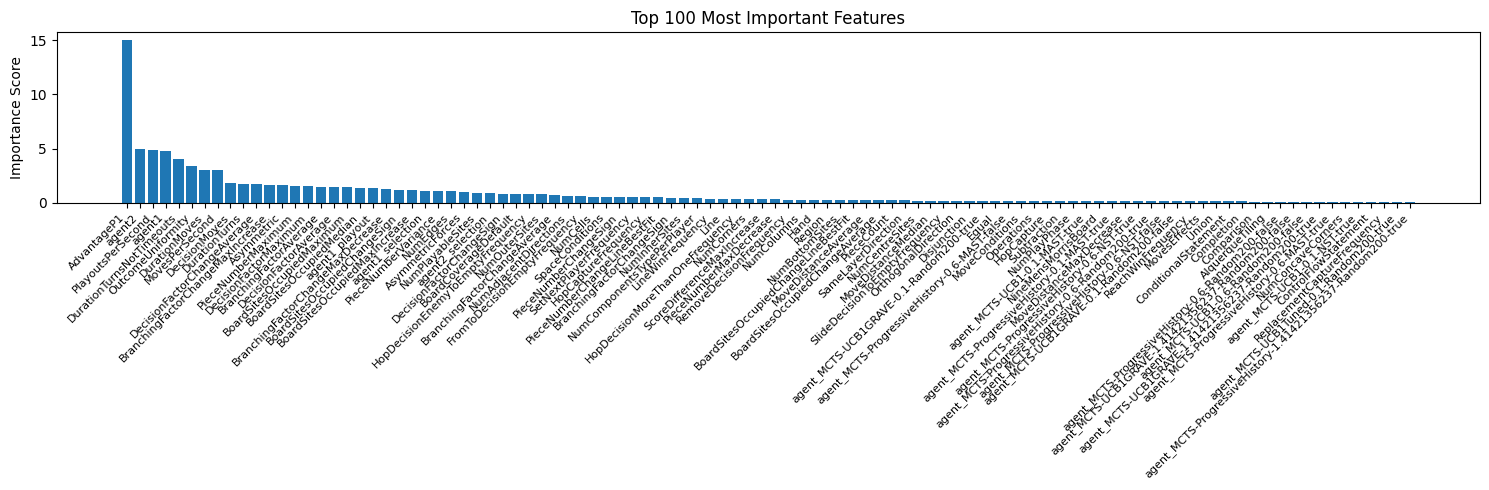

Fold 4 - RMSE: 0.4145299566514878
Fold 5


0:	learn: 0.6245969	test: 0.5871608	best: 0.5871608 (0)	total: 84.1ms	remaining: 14m


50:	learn: 0.4922767	test: 0.5325774	best: 0.5325774 (50)	total: 4.3s	remaining: 13m 58s


100:	learn: 0.4476418	test: 0.5030695	best: 0.5030695 (100)	total: 8.61s	remaining: 14m 3s


150:	learn: 0.4213102	test: 0.4872039	best: 0.4872039 (150)	total: 13.1s	remaining: 14m 12s


200:	learn: 0.4048280	test: 0.4762755	best: 0.4762755 (200)	total: 17.9s	remaining: 14m 33s


250:	learn: 0.3935363	test: 0.4690534	best: 0.4690534 (250)	total: 22.8s	remaining: 14m 47s


300:	learn: 0.3846986	test: 0.4639757	best: 0.4639757 (300)	total: 27.9s	remaining: 14m 57s


350:	learn: 0.3776123	test: 0.4601401	best: 0.4601401 (350)	total: 32.8s	remaining: 15m 2s


400:	learn: 0.3704353	test: 0.4555055	best: 0.4555055 (400)	total: 37.7s	remaining: 15m 3s


450:	learn: 0.3633861	test: 0.4512444	best: 0.4512444 (450)	total: 42.6s	remaining: 15m 1s


500:	learn: 0.3582327	test: 0.4488007	best: 0.4487345 (498)	total: 47.4s	remaining: 14m 58s


550:	learn: 0.3527899	test: 0.4461581	best: 0.4461581 (550)	total: 52.1s	remaining: 14m 53s


600:	learn: 0.3481464	test: 0.4438595	best: 0.4438595 (600)	total: 56.8s	remaining: 14m 47s


650:	learn: 0.3442804	test: 0.4423286	best: 0.4423286 (650)	total: 1m 1s	remaining: 14m 43s


700:	learn: 0.3403458	test: 0.4405541	best: 0.4405541 (700)	total: 1m 6s	remaining: 14m 38s


750:	learn: 0.3368383	test: 0.4393252	best: 0.4393252 (750)	total: 1m 10s	remaining: 14m 33s


800:	learn: 0.3334709	test: 0.4380104	best: 0.4380104 (800)	total: 1m 15s	remaining: 14m 29s


850:	learn: 0.3303219	test: 0.4370387	best: 0.4370374 (849)	total: 1m 20s	remaining: 14m 24s


900:	learn: 0.3276067	test: 0.4359822	best: 0.4359822 (900)	total: 1m 25s	remaining: 14m 20s


950:	learn: 0.3250072	test: 0.4352418	best: 0.4352418 (950)	total: 1m 30s	remaining: 14m 16s


1000:	learn: 0.3224940	test: 0.4344040	best: 0.4344040 (1000)	total: 1m 34s	remaining: 14m 11s


1050:	learn: 0.3201200	test: 0.4336465	best: 0.4336465 (1050)	total: 1m 39s	remaining: 14m 8s


1100:	learn: 0.3176850	test: 0.4328616	best: 0.4328616 (1100)	total: 1m 44s	remaining: 14m 3s


1150:	learn: 0.3153134	test: 0.4321363	best: 0.4321348 (1148)	total: 1m 49s	remaining: 13m 58s


1200:	learn: 0.3132828	test: 0.4315333	best: 0.4315333 (1200)	total: 1m 53s	remaining: 13m 54s


1250:	learn: 0.3113592	test: 0.4310866	best: 0.4310866 (1250)	total: 1m 58s	remaining: 13m 50s


1300:	learn: 0.3095911	test: 0.4304958	best: 0.4304958 (1300)	total: 2m 3s	remaining: 13m 45s


1350:	learn: 0.3077419	test: 0.4298948	best: 0.4298948 (1350)	total: 2m 8s	remaining: 13m 42s


1400:	learn: 0.3059191	test: 0.4294481	best: 0.4294481 (1400)	total: 2m 13s	remaining: 13m 37s


1450:	learn: 0.3042614	test: 0.4288728	best: 0.4288728 (1450)	total: 2m 18s	remaining: 13m 33s


1500:	learn: 0.3026238	test: 0.4284426	best: 0.4284426 (1500)	total: 2m 23s	remaining: 13m 30s


1550:	learn: 0.3010505	test: 0.4279129	best: 0.4279129 (1550)	total: 2m 28s	remaining: 13m 26s


1600:	learn: 0.2995017	test: 0.4274194	best: 0.4274194 (1600)	total: 2m 32s	remaining: 13m 21s


1650:	learn: 0.2977965	test: 0.4268898	best: 0.4268898 (1650)	total: 2m 37s	remaining: 13m 17s


1700:	learn: 0.2964347	test: 0.4266025	best: 0.4266025 (1700)	total: 2m 42s	remaining: 13m 14s


1750:	learn: 0.2949351	test: 0.4262704	best: 0.4262704 (1750)	total: 2m 47s	remaining: 13m 9s


1800:	learn: 0.2936421	test: 0.4259205	best: 0.4259205 (1800)	total: 2m 52s	remaining: 13m 5s


1850:	learn: 0.2923116	test: 0.4257306	best: 0.4257306 (1850)	total: 2m 57s	remaining: 13m 1s


1900:	learn: 0.2910364	test: 0.4254610	best: 0.4254610 (1900)	total: 3m 2s	remaining: 12m 57s


1950:	learn: 0.2897152	test: 0.4252430	best: 0.4252430 (1950)	total: 3m 7s	remaining: 12m 53s


2000:	learn: 0.2884363	test: 0.4249057	best: 0.4249057 (2000)	total: 3m 12s	remaining: 12m 49s


2050:	learn: 0.2871480	test: 0.4246232	best: 0.4246232 (2050)	total: 3m 17s	remaining: 12m 44s


2100:	learn: 0.2859328	test: 0.4242797	best: 0.4242797 (2100)	total: 3m 22s	remaining: 12m 40s


2150:	learn: 0.2848201	test: 0.4240129	best: 0.4240129 (2150)	total: 3m 27s	remaining: 12m 35s


2200:	learn: 0.2835935	test: 0.4238565	best: 0.4238528 (2199)	total: 3m 31s	remaining: 12m 31s


2250:	learn: 0.2825411	test: 0.4237031	best: 0.4236986 (2249)	total: 3m 36s	remaining: 12m 26s


2300:	learn: 0.2814496	test: 0.4234297	best: 0.4234297 (2300)	total: 3m 41s	remaining: 12m 21s


2350:	learn: 0.2803725	test: 0.4232333	best: 0.4232333 (2350)	total: 3m 46s	remaining: 12m 17s


2400:	learn: 0.2792884	test: 0.4229887	best: 0.4229887 (2400)	total: 3m 51s	remaining: 12m 12s


2450:	learn: 0.2782662	test: 0.4227475	best: 0.4227475 (2450)	total: 3m 56s	remaining: 12m 8s


2500:	learn: 0.2773022	test: 0.4226276	best: 0.4226276 (2500)	total: 4m 1s	remaining: 12m 3s


2550:	learn: 0.2762131	test: 0.4224602	best: 0.4224451 (2540)	total: 4m 6s	remaining: 11m 58s


2600:	learn: 0.2752178	test: 0.4222506	best: 0.4222506 (2600)	total: 4m 10s	remaining: 11m 53s


2650:	learn: 0.2742579	test: 0.4220640	best: 0.4220640 (2650)	total: 4m 15s	remaining: 11m 49s


2700:	learn: 0.2733948	test: 0.4219434	best: 0.4219434 (2700)	total: 4m 20s	remaining: 11m 45s


2750:	learn: 0.2725513	test: 0.4217608	best: 0.4217608 (2750)	total: 4m 25s	remaining: 11m 40s


2800:	learn: 0.2716704	test: 0.4216263	best: 0.4216261 (2797)	total: 4m 30s	remaining: 11m 36s


2850:	learn: 0.2707599	test: 0.4214590	best: 0.4214590 (2850)	total: 4m 35s	remaining: 11m 31s


2900:	learn: 0.2699201	test: 0.4213415	best: 0.4213393 (2898)	total: 4m 40s	remaining: 11m 27s


2950:	learn: 0.2690908	test: 0.4211995	best: 0.4211995 (2950)	total: 4m 46s	remaining: 11m 23s


3000:	learn: 0.2682800	test: 0.4211169	best: 0.4211169 (3000)	total: 4m 51s	remaining: 11m 18s


3050:	learn: 0.2674724	test: 0.4209780	best: 0.4209780 (3050)	total: 4m 56s	remaining: 11m 14s


3100:	learn: 0.2666891	test: 0.4208806	best: 0.4208806 (3100)	total: 5m 1s	remaining: 11m 9s


3150:	learn: 0.2659719	test: 0.4207629	best: 0.4207628 (3149)	total: 5m 6s	remaining: 11m 5s


3200:	learn: 0.2651128	test: 0.4206595	best: 0.4206595 (3200)	total: 5m 11s	remaining: 11m 1s


3250:	learn: 0.2643369	test: 0.4205926	best: 0.4205914 (3249)	total: 5m 16s	remaining: 10m 56s


3300:	learn: 0.2635553	test: 0.4205297	best: 0.4205245 (3299)	total: 5m 21s	remaining: 10m 52s


3350:	learn: 0.2628489	test: 0.4204517	best: 0.4204517 (3350)	total: 5m 26s	remaining: 10m 47s


3400:	learn: 0.2620337	test: 0.4203637	best: 0.4203637 (3400)	total: 5m 31s	remaining: 10m 42s


3450:	learn: 0.2613143	test: 0.4202319	best: 0.4202297 (3449)	total: 5m 36s	remaining: 10m 38s


3500:	learn: 0.2605835	test: 0.4201024	best: 0.4201024 (3500)	total: 5m 41s	remaining: 10m 33s


3550:	learn: 0.2599129	test: 0.4199843	best: 0.4199843 (3550)	total: 5m 46s	remaining: 10m 29s


3600:	learn: 0.2592576	test: 0.4199417	best: 0.4199417 (3600)	total: 5m 51s	remaining: 10m 24s


3650:	learn: 0.2585707	test: 0.4198981	best: 0.4198852 (3637)	total: 5m 56s	remaining: 10m 20s


3700:	learn: 0.2578998	test: 0.4198547	best: 0.4198387 (3683)	total: 6m 1s	remaining: 10m 15s


3750:	learn: 0.2572578	test: 0.4197891	best: 0.4197891 (3750)	total: 6m 6s	remaining: 10m 11s


3800:	learn: 0.2565960	test: 0.4197153	best: 0.4197153 (3800)	total: 6m 11s	remaining: 10m 6s


3850:	learn: 0.2559518	test: 0.4196435	best: 0.4196352 (3847)	total: 6m 16s	remaining: 10m 1s


3900:	learn: 0.2553435	test: 0.4196074	best: 0.4196074 (3900)	total: 6m 22s	remaining: 9m 57s


3950:	learn: 0.2547527	test: 0.4194989	best: 0.4194989 (3950)	total: 6m 27s	remaining: 9m 52s


4000:	learn: 0.2541117	test: 0.4194009	best: 0.4194009 (4000)	total: 6m 32s	remaining: 9m 48s


4050:	learn: 0.2535018	test: 0.4192780	best: 0.4192780 (4050)	total: 6m 37s	remaining: 9m 43s


4100:	learn: 0.2528850	test: 0.4191794	best: 0.4191794 (4100)	total: 6m 42s	remaining: 9m 38s


4150:	learn: 0.2522449	test: 0.4190646	best: 0.4190640 (4148)	total: 6m 47s	remaining: 9m 34s


4200:	learn: 0.2516678	test: 0.4189838	best: 0.4189838 (4200)	total: 6m 52s	remaining: 9m 29s


4250:	learn: 0.2510671	test: 0.4189514	best: 0.4189412 (4231)	total: 6m 57s	remaining: 9m 24s


4300:	learn: 0.2505120	test: 0.4188850	best: 0.4188850 (4300)	total: 7m 2s	remaining: 9m 19s


4350:	learn: 0.2498782	test: 0.4187885	best: 0.4187885 (4350)	total: 7m 7s	remaining: 9m 15s


4400:	learn: 0.2493140	test: 0.4187453	best: 0.4187366 (4390)	total: 7m 12s	remaining: 9m 10s


4450:	learn: 0.2487782	test: 0.4186876	best: 0.4186876 (4450)	total: 7m 17s	remaining: 9m 5s


4500:	learn: 0.2482181	test: 0.4186077	best: 0.4186024 (4497)	total: 7m 22s	remaining: 9m


4550:	learn: 0.2476770	test: 0.4185510	best: 0.4185502 (4544)	total: 7m 27s	remaining: 8m 56s


4600:	learn: 0.2471685	test: 0.4185055	best: 0.4185018 (4588)	total: 7m 32s	remaining: 8m 51s


4650:	learn: 0.2466023	test: 0.4184312	best: 0.4184284 (4649)	total: 7m 37s	remaining: 8m 46s


4700:	learn: 0.2460854	test: 0.4184061	best: 0.4184061 (4700)	total: 7m 42s	remaining: 8m 41s


4750:	learn: 0.2455214	test: 0.4183173	best: 0.4183173 (4750)	total: 7m 48s	remaining: 8m 37s


4800:	learn: 0.2450292	test: 0.4182839	best: 0.4182839 (4800)	total: 7m 53s	remaining: 8m 32s


4850:	learn: 0.2444979	test: 0.4182234	best: 0.4182234 (4850)	total: 7m 58s	remaining: 8m 27s


4900:	learn: 0.2439915	test: 0.4181836	best: 0.4181825 (4888)	total: 8m 3s	remaining: 8m 22s


4950:	learn: 0.2435095	test: 0.4181410	best: 0.4181358 (4944)	total: 8m 8s	remaining: 8m 18s


5000:	learn: 0.2430500	test: 0.4181304	best: 0.4181270 (4992)	total: 8m 13s	remaining: 8m 13s


5050:	learn: 0.2425766	test: 0.4180837	best: 0.4180837 (5050)	total: 8m 18s	remaining: 8m 8s


5100:	learn: 0.2421140	test: 0.4180602	best: 0.4180602 (5100)	total: 8m 23s	remaining: 8m 3s


5150:	learn: 0.2416100	test: 0.4180292	best: 0.4180291 (5149)	total: 8m 28s	remaining: 7m 58s


5200:	learn: 0.2411211	test: 0.4179516	best: 0.4179509 (5199)	total: 8m 33s	remaining: 7m 54s


5250:	learn: 0.2406680	test: 0.4179224	best: 0.4179204 (5248)	total: 8m 38s	remaining: 7m 49s


5300:	learn: 0.2401572	test: 0.4178653	best: 0.4178647 (5299)	total: 8m 44s	remaining: 7m 44s


5350:	learn: 0.2396860	test: 0.4178159	best: 0.4178159 (5350)	total: 8m 49s	remaining: 7m 39s


5400:	learn: 0.2391909	test: 0.4177503	best: 0.4177480 (5393)	total: 8m 54s	remaining: 7m 34s


5450:	learn: 0.2387391	test: 0.4177010	best: 0.4177010 (5450)	total: 8m 59s	remaining: 7m 30s


5500:	learn: 0.2383171	test: 0.4176350	best: 0.4176343 (5497)	total: 9m 4s	remaining: 7m 25s


5550:	learn: 0.2378788	test: 0.4176046	best: 0.4176046 (5550)	total: 9m 9s	remaining: 7m 20s


5600:	learn: 0.2374187	test: 0.4175911	best: 0.4175798 (5585)	total: 9m 14s	remaining: 7m 15s


5650:	learn: 0.2369365	test: 0.4175252	best: 0.4175244 (5647)	total: 9m 19s	remaining: 7m 10s


5700:	learn: 0.2364914	test: 0.4175030	best: 0.4175030 (5700)	total: 9m 24s	remaining: 7m 5s


5750:	learn: 0.2360244	test: 0.4174776	best: 0.4174711 (5747)	total: 9m 30s	remaining: 7m 1s


5800:	learn: 0.2356097	test: 0.4174400	best: 0.4174400 (5800)	total: 9m 35s	remaining: 6m 56s


5850:	learn: 0.2351670	test: 0.4174007	best: 0.4174005 (5849)	total: 9m 40s	remaining: 6m 51s


5900:	learn: 0.2347447	test: 0.4173589	best: 0.4173580 (5893)	total: 9m 45s	remaining: 6m 46s


5950:	learn: 0.2343158	test: 0.4173371	best: 0.4173345 (5948)	total: 9m 50s	remaining: 6m 41s


6000:	learn: 0.2338728	test: 0.4172856	best: 0.4172819 (5993)	total: 9m 55s	remaining: 6m 36s


6050:	learn: 0.2334233	test: 0.4172550	best: 0.4172550 (6050)	total: 10m	remaining: 6m 31s


6100:	learn: 0.2329989	test: 0.4172293	best: 0.4172293 (6100)	total: 10m 5s	remaining: 6m 26s


6150:	learn: 0.2325674	test: 0.4171941	best: 0.4171892 (6136)	total: 10m 10s	remaining: 6m 22s


6200:	learn: 0.2321357	test: 0.4171853	best: 0.4171811 (6194)	total: 10m 15s	remaining: 6m 17s


6250:	learn: 0.2317438	test: 0.4171898	best: 0.4171811 (6194)	total: 10m 20s	remaining: 6m 12s


6300:	learn: 0.2313765	test: 0.4171349	best: 0.4171349 (6300)	total: 10m 25s	remaining: 6m 7s


6350:	learn: 0.2309681	test: 0.4171102	best: 0.4171102 (6350)	total: 10m 30s	remaining: 6m 2s


6400:	learn: 0.2305748	test: 0.4170770	best: 0.4170764 (6399)	total: 10m 35s	remaining: 5m 57s


6450:	learn: 0.2301505	test: 0.4170496	best: 0.4170496 (6450)	total: 10m 40s	remaining: 5m 52s


6500:	learn: 0.2297681	test: 0.4170291	best: 0.4170291 (6500)	total: 10m 45s	remaining: 5m 47s


6550:	learn: 0.2293656	test: 0.4169941	best: 0.4169941 (6550)	total: 10m 51s	remaining: 5m 42s


6600:	learn: 0.2289784	test: 0.4169783	best: 0.4169783 (6600)	total: 10m 56s	remaining: 5m 37s


6650:	learn: 0.2285880	test: 0.4169436	best: 0.4169436 (6650)	total: 11m 1s	remaining: 5m 32s


6700:	learn: 0.2281574	test: 0.4169189	best: 0.4169189 (6700)	total: 11m 6s	remaining: 5m 28s


6750:	learn: 0.2277789	test: 0.4168864	best: 0.4168815 (6740)	total: 11m 11s	remaining: 5m 23s


6800:	learn: 0.2273814	test: 0.4168581	best: 0.4168581 (6800)	total: 11m 16s	remaining: 5m 18s


6850:	learn: 0.2270012	test: 0.4168165	best: 0.4168165 (6850)	total: 11m 21s	remaining: 5m 13s


6900:	learn: 0.2266027	test: 0.4168004	best: 0.4167936 (6893)	total: 11m 26s	remaining: 5m 8s


6950:	learn: 0.2262525	test: 0.4167856	best: 0.4167856 (6950)	total: 11m 31s	remaining: 5m 3s


7000:	learn: 0.2258735	test: 0.4167476	best: 0.4167466 (6997)	total: 11m 36s	remaining: 4m 58s


7050:	learn: 0.2255109	test: 0.4167102	best: 0.4167078 (7046)	total: 11m 42s	remaining: 4m 53s


7100:	learn: 0.2251545	test: 0.4166679	best: 0.4166678 (7099)	total: 11m 47s	remaining: 4m 48s


7150:	learn: 0.2247642	test: 0.4166282	best: 0.4166233 (7139)	total: 11m 52s	remaining: 4m 43s


7200:	learn: 0.2243914	test: 0.4166090	best: 0.4166064 (7187)	total: 11m 57s	remaining: 4m 38s


7250:	learn: 0.2240157	test: 0.4165989	best: 0.4165900 (7233)	total: 12m 2s	remaining: 4m 33s


7300:	learn: 0.2236034	test: 0.4165728	best: 0.4165714 (7283)	total: 12m 7s	remaining: 4m 28s


7350:	learn: 0.2232789	test: 0.4165575	best: 0.4165575 (7350)	total: 12m 12s	remaining: 4m 23s


7400:	learn: 0.2229240	test: 0.4165191	best: 0.4165191 (7400)	total: 12m 17s	remaining: 4m 18s


7450:	learn: 0.2225475	test: 0.4164746	best: 0.4164746 (7450)	total: 12m 22s	remaining: 4m 14s


7500:	learn: 0.2222023	test: 0.4164636	best: 0.4164611 (7482)	total: 12m 27s	remaining: 4m 9s


7550:	learn: 0.2218416	test: 0.4164196	best: 0.4164196 (7550)	total: 12m 32s	remaining: 4m 4s


7600:	learn: 0.2214874	test: 0.4164060	best: 0.4164060 (7600)	total: 12m 37s	remaining: 3m 59s


7650:	learn: 0.2211243	test: 0.4163755	best: 0.4163755 (7650)	total: 12m 42s	remaining: 3m 54s


7700:	learn: 0.2207791	test: 0.4163787	best: 0.4163666 (7685)	total: 12m 47s	remaining: 3m 49s


7750:	learn: 0.2204620	test: 0.4163658	best: 0.4163658 (7750)	total: 12m 53s	remaining: 3m 44s


7800:	learn: 0.2201023	test: 0.4163563	best: 0.4163532 (7783)	total: 12m 58s	remaining: 3m 39s


7850:	learn: 0.2197539	test: 0.4163207	best: 0.4163168 (7846)	total: 13m 3s	remaining: 3m 34s


7900:	learn: 0.2194264	test: 0.4163198	best: 0.4163154 (7893)	total: 13m 8s	remaining: 3m 29s


7950:	learn: 0.2190974	test: 0.4162785	best: 0.4162785 (7950)	total: 13m 13s	remaining: 3m 24s


8000:	learn: 0.2187486	test: 0.4162573	best: 0.4162573 (8000)	total: 13m 18s	remaining: 3m 19s


8050:	learn: 0.2183755	test: 0.4162375	best: 0.4162348 (8047)	total: 13m 23s	remaining: 3m 14s


8100:	learn: 0.2179913	test: 0.4161929	best: 0.4161929 (8100)	total: 13m 28s	remaining: 3m 9s


8150:	learn: 0.2176567	test: 0.4161430	best: 0.4161430 (8150)	total: 13m 33s	remaining: 3m 4s


8200:	learn: 0.2173174	test: 0.4161302	best: 0.4161302 (8200)	total: 13m 38s	remaining: 2m 59s


8250:	learn: 0.2169985	test: 0.4161207	best: 0.4161162 (8243)	total: 13m 44s	remaining: 2m 54s


8300:	learn: 0.2166321	test: 0.4160856	best: 0.4160856 (8300)	total: 13m 49s	remaining: 2m 49s


8350:	learn: 0.2163091	test: 0.4160830	best: 0.4160802 (8335)	total: 13m 54s	remaining: 2m 44s


8400:	learn: 0.2159402	test: 0.4160606	best: 0.4160606 (8400)	total: 13m 59s	remaining: 2m 39s


8450:	learn: 0.2155848	test: 0.4160356	best: 0.4160347 (8447)	total: 14m 4s	remaining: 2m 34s


8500:	learn: 0.2152612	test: 0.4160041	best: 0.4160041 (8500)	total: 14m 9s	remaining: 2m 29s


8550:	learn: 0.2149422	test: 0.4159926	best: 0.4159918 (8541)	total: 14m 14s	remaining: 2m 24s


8600:	learn: 0.2146149	test: 0.4159683	best: 0.4159683 (8600)	total: 14m 19s	remaining: 2m 19s


8650:	learn: 0.2142622	test: 0.4159465	best: 0.4159452 (8647)	total: 14m 24s	remaining: 2m 14s


8700:	learn: 0.2139668	test: 0.4159415	best: 0.4159346 (8684)	total: 14m 29s	remaining: 2m 9s


8750:	learn: 0.2136334	test: 0.4159156	best: 0.4159156 (8750)	total: 14m 35s	remaining: 2m 4s


8800:	learn: 0.2133105	test: 0.4159031	best: 0.4158944 (8773)	total: 14m 40s	remaining: 1m 59s


8850:	learn: 0.2129837	test: 0.4158728	best: 0.4158728 (8850)	total: 14m 45s	remaining: 1m 54s


8900:	learn: 0.2126515	test: 0.4158503	best: 0.4158503 (8900)	total: 14m 50s	remaining: 1m 49s


8950:	learn: 0.2123435	test: 0.4158439	best: 0.4158405 (8948)	total: 14m 55s	remaining: 1m 44s


9000:	learn: 0.2119854	test: 0.4158250	best: 0.4158198 (8992)	total: 15m	remaining: 1m 39s


9050:	learn: 0.2116622	test: 0.4158393	best: 0.4158198 (8992)	total: 15m 5s	remaining: 1m 34s


9100:	learn: 0.2113578	test: 0.4158208	best: 0.4158194 (9076)	total: 15m 10s	remaining: 1m 29s


9150:	learn: 0.2110367	test: 0.4158150	best: 0.4158150 (9150)	total: 15m 15s	remaining: 1m 24s


9200:	learn: 0.2106997	test: 0.4158168	best: 0.4158075 (9181)	total: 15m 20s	remaining: 1m 19s


9250:	learn: 0.2104039	test: 0.4157908	best: 0.4157908 (9250)	total: 15m 25s	remaining: 1m 14s


9300:	learn: 0.2101063	test: 0.4157811	best: 0.4157804 (9298)	total: 15m 31s	remaining: 1m 9s


9350:	learn: 0.2098020	test: 0.4157666	best: 0.4157652 (9347)	total: 15m 36s	remaining: 1m 4s


9400:	learn: 0.2094821	test: 0.4157491	best: 0.4157445 (9390)	total: 15m 41s	remaining: 60s


9450:	learn: 0.2091994	test: 0.4157179	best: 0.4157175 (9444)	total: 15m 46s	remaining: 55s


9500:	learn: 0.2089125	test: 0.4157010	best: 0.4156955 (9482)	total: 15m 51s	remaining: 50s


9550:	learn: 0.2085985	test: 0.4156733	best: 0.4156685 (9541)	total: 15m 56s	remaining: 45s


9600:	learn: 0.2082902	test: 0.4156523	best: 0.4156389 (9590)	total: 16m 1s	remaining: 40s


9650:	learn: 0.2079764	test: 0.4156475	best: 0.4156389 (9590)	total: 16m 6s	remaining: 35s


9700:	learn: 0.2076731	test: 0.4156343	best: 0.4156343 (9700)	total: 16m 11s	remaining: 30s


9750:	learn: 0.2073839	test: 0.4156138	best: 0.4156138 (9750)	total: 16m 16s	remaining: 24.9s


9800:	learn: 0.2070471	test: 0.4156136	best: 0.4156112 (9751)	total: 16m 22s	remaining: 19.9s


9850:	learn: 0.2067646	test: 0.4156045	best: 0.4156033 (9849)	total: 16m 27s	remaining: 14.9s


9900:	learn: 0.2064445	test: 0.4155984	best: 0.4155940 (9870)	total: 16m 32s	remaining: 9.92s


9950:	learn: 0.2061307	test: 0.4155900	best: 0.4155801 (9931)	total: 16m 37s	remaining: 4.91s


9999:	learn: 0.2058449	test: 0.4155763	best: 0.4155705 (9994)	total: 16m 42s	remaining: 0us

bestTest = 0.4155705402
bestIteration = 9994

Shrink model to first 9995 iterations.


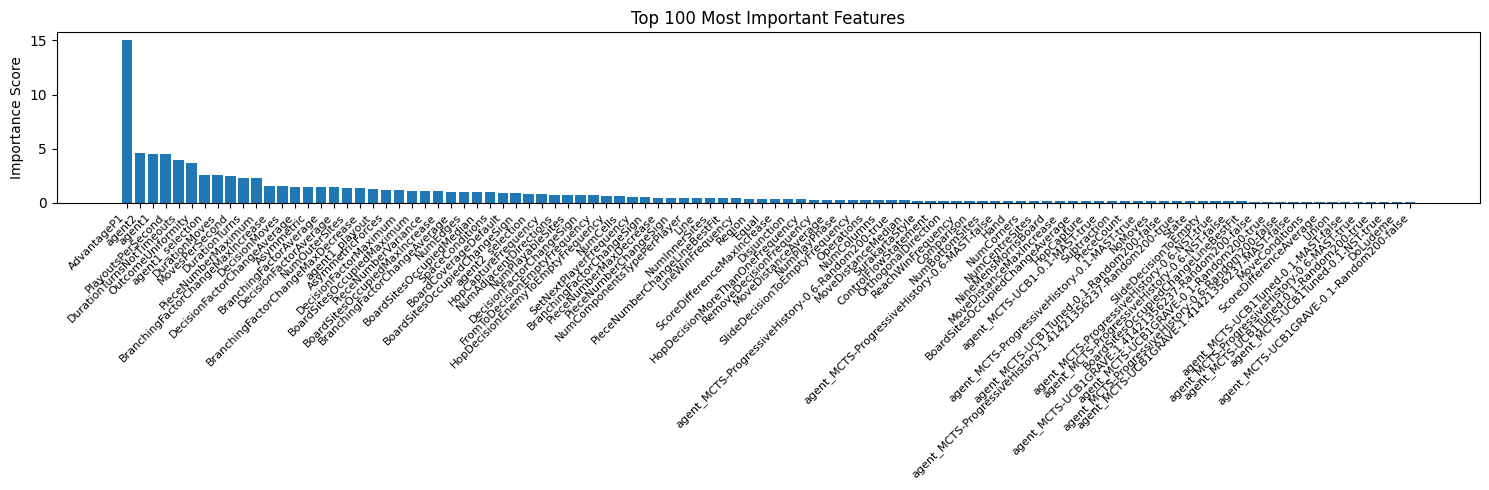

Fold 5 - RMSE: 0.4152011330247699
List of oof scores: [0.4237174357238684, 0.41224649278301445, 0.414705831774623, 0.4145299566514878, 0.4152011330247699]
Average oof score: 0.4160801699915527


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4173
Score: 0.4303
Score: 0.4191
Score: 0.4363
Score: 0.3972
Average CV1 Score: 0.4200

CV2 OOF Scores:
Score: 0.4071
Score: 0.3958
Score: 0.4187
Score: 0.4275
Score: 0.4284
Average CV2 Score: 0.4155

CV3 OOF Scores:
Score: 0.4237
Score: 0.4122
Score: 0.4147
Score: 0.4145
Score: 0.4152
Average CV3 Score: 0.4161


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

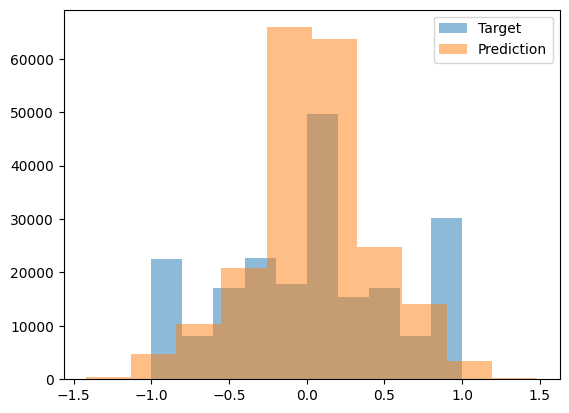

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.102741       │
│ 233235 ┆ -0.12762       │
│ 233236 ┆ -0.058867      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***